In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
import mlsmote
from skmultilearn.problem_transform import BinaryRelevance
import json
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm
from inspect import signature
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,hamming_loss
from tensorflow.estimator import DNNClassifier

In [2]:
# Load the dataset
data = pd.read_csv('ai4i2020.csv',index_col=None)


In [3]:
no_data_entries = data.shape[0]
repetition_class_ratio= data[['TWF','HDF','PWF','OSF','RNF']].sum(axis=0)/no_data_entries
print(repetition_class_ratio)

TWF    0.0046
HDF    0.0115
PWF    0.0095
OSF    0.0098
RNF    0.0019
dtype: float64


In [4]:
non_failure_samples_no= no_data_entries-data[["Machine failure"]].sum(axis=0).values[0]
print(non_failure_samples_no)

9661


In [5]:
classifiers = [
    XGBClassifier,
    LGBMClassifier,
    CatBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    LogisticRegression,
    SVC,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    MLPClassifier
]

hyperparameters = [
    { 
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'gamma': [0.0, 0.1, 0.5],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'tree_method': ['gpu_hist'],  # Use GPU for XGBoost
        'gpu_id': [0]  # Set GPU ID to 0
    },
    {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'num_leaves': [31, 62, 127],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'reg_lambda': [0.0, 0.1, 0.5],
        'device': ['gpu'],  # Use GPU for LightGBM
        'gpu_device_id': [0],  # Set GPU ID to 0
        'verbose': [-1],  # Disable text information
        'silent': [True]  # Disable text information (alternative)
    },
    {
        'depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'l2_leaf_reg': [0.0, 0.1, 0.5],
        'task_type': ['GPU'],  # Use GPU for CatBoost
        'verbose': [False]  # Disable text information
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1.0]
    },
    {
        'C': [0.1, 1.0, 10.0]
    },
    {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    },
    {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance']
    },
    {
        'hidden_layer_sizes': [(50, 50), (100, 100), (200, 200)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling']
    }
]

In [6]:

# Encode categorical feature
type_dict = {"L": 1, "M": 2, "H": 3}
data['Type'] = data['Type'].map(type_dict)

# Separate features and labels
X = data.drop(['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

repetition_class_ratio_before_da= y_train.sum(axis=0)/y_train.shape[0]
print("before MLSMOTE \n", repetition_class_ratio_before_da)


# Infer the categorical feature from the data columns
categorical_features = [i for i, col in enumerate(X.columns) if col == 'Type']

# Create an instance of MLSMOTE
mlsmote = mlsmote.MLSMOTE(categorical_features=categorical_features,input_columns=X_train.columns, label_columns=y_train.columns,random_state=77)

# Resample the data using MLSMOTE
X_train_res, y_train_res = mlsmote.fit_resample(X_train, y_train)   

# Convert X_train_res and y_train_res to DataFrames
X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train = pd.DataFrame(y_train_res, columns=y_train.columns)


repetition_class_ratio_after_da= y_train.sum(axis=0)/y_train.shape[0]
print("after MLSMOTE \n", repetition_class_ratio_after_da)




# Standardize the features
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Scale the continuous features
X_train_res_continuous = scaler.fit_transform(X_train.drop('Type', axis=1))
X_test_continuous = scaler.transform(X_test.drop('Type', axis=1))

# Concatenate the categorical feature with the scaled continuous features
X_train = np.concatenate((X_train[['Type']], X_train_res_continuous), axis=1)
X_test = np.concatenate((X_test[['Type']], X_test_continuous), axis=1)



best_score = 0
best_params = None
best_classifier = None

results = []
for classifier, hyperparameter in zip(classifiers, hyperparameters):
    hyperparameter_combinations = [dict(zip(hyperparameter.keys(), v)) for v in product(*hyperparameter.values())]
    for hyperparameter_combination in tqdm(hyperparameter_combinations, desc=f"Training {classifier.__name__}"):
        clf_params = hyperparameter_combination.copy()
        if 'random_state' in signature(classifier).parameters:
            clf_params['random_state'] = 77
        clf = BinaryRelevance(classifier(**clf_params))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_test_non_failure = ~np.any(y_test, axis=1)
        y_test_stack = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
        y_pred_dense = y_pred.toarray()
        y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
        y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
        # accuracy
        accuracy= accuracy_score(y_test_stack, y_pred_dense)
        f1 = f1_score(y_test_stack, y_pred_dense, average='weighted')
        precision = precision_score(y_test_stack, y_pred_dense, average='weighted')
        recall = recall_score(y_test_stack, y_pred_dense, average='weighted')
        hamming = 1-hamming_loss(y_test_stack, y_pred_dense)
        auc = roc_auc_score(y_test_stack, y_pred_dense, average='weighted')
        score = (0.4 * f1) + (0.3 * auc) + (0.2 * accuracy) + (0.1 * hamming)
        print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Hamming Loss: {hamming:.4f}, AUC: {auc:.4f}, Score: {score:.6f}")
        results.append({
            'classifier': classifier.__name__,
            'hyperparameters': hyperparameter_combination,
            'f1': f1,
            'hamming_loss': hamming,
            'auc': auc,
            'precision': precision,
            'accuracy': accuracy,
            'recall': recall,
            'score': score
        })

with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)



before MLSMOTE 
 TWF    0.004625
HDF    0.011625
PWF    0.010375
OSF    0.010000
RNF    0.001875
dtype: float64
after MLSMOTE 
 TWF    0.009190
HDF    0.011550
PWF    0.010308
OSF    0.009935
RNF    0.003726
dtype: float64


Training XGBClassifier:   0%|          | 0/972 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   0%|          | 1/972 [00:01<31:44,  1.96s/it]

Accuracy: 0.9790, F1: 0.9733, Hamming Loss: 0.9932, AUC: 0.6914, Score: 0.891860


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   0%|          | 2/972 [00:02<16:43,  1.03s/it]

Accuracy: 0.9825, F1: 0.9786, Hamming Loss: 0.9944, AUC: 0.7496, Score: 0.912277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   0%|          | 3/972 [00:02<12:11,  1.32it/s]

Accuracy: 0.9865, F1: 0.9837, Hamming Loss: 0.9956, AUC: 0.8161, Score: 0.935179


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   0%|          | 4/972 [00:03<09:47,  1.65it/s]

Accuracy: 0.9785, F1: 0.9727, Hamming Loss: 0.9931, AUC: 0.6831, Score: 0.889012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 5/972 [00:03<08:39,  1.86it/s]

Accuracy: 0.9820, F1: 0.9784, Hamming Loss: 0.9942, AUC: 0.7494, Score: 0.911986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 6/972 [00:04<08:34,  1.88it/s]

Accuracy: 0.9860, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940036


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 7/972 [00:04<07:47,  2.07it/s]

Accuracy: 0.9785, F1: 0.9727, Hamming Loss: 0.9931, AUC: 0.6831, Score: 0.889012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 8/972 [00:04<07:15,  2.21it/s]

Accuracy: 0.9815, F1: 0.9779, Hamming Loss: 0.9941, AUC: 0.7491, Score: 0.911606


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 9/972 [00:05<07:00,  2.29it/s]

Accuracy: 0.9865, F1: 0.9842, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940320


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 10/972 [00:05<06:40,  2.40it/s]

Accuracy: 0.9790, F1: 0.9733, Hamming Loss: 0.9932, AUC: 0.6914, Score: 0.891860


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 11/972 [00:06<06:33,  2.44it/s]

Accuracy: 0.9820, F1: 0.9781, Hamming Loss: 0.9942, AUC: 0.7413, Score: 0.909438


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|          | 12/972 [00:06<06:24,  2.50it/s]

Accuracy: 0.9870, F1: 0.9841, Hamming Loss: 0.9958, AUC: 0.8164, Score: 0.935544


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|▏         | 13/972 [00:06<06:17,  2.54it/s]

Accuracy: 0.9785, F1: 0.9727, Hamming Loss: 0.9931, AUC: 0.6831, Score: 0.889012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   1%|▏         | 14/972 [00:07<06:20,  2.52it/s]

Accuracy: 0.9820, F1: 0.9784, Hamming Loss: 0.9942, AUC: 0.7494, Score: 0.911986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 15/972 [00:07<06:15,  2.55it/s]

Accuracy: 0.9855, F1: 0.9837, Hamming Loss: 0.9955, AUC: 0.8320, Score: 0.939744


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 16/972 [00:07<06:14,  2.55it/s]

Accuracy: 0.9785, F1: 0.9727, Hamming Loss: 0.9931, AUC: 0.6831, Score: 0.889012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 17/972 [00:08<06:10,  2.58it/s]

Accuracy: 0.9815, F1: 0.9779, Hamming Loss: 0.9941, AUC: 0.7491, Score: 0.911606


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 18/972 [00:08<06:16,  2.53it/s]

Accuracy: 0.9865, F1: 0.9842, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940320


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 19/972 [00:09<06:07,  2.60it/s]

Accuracy: 0.9795, F1: 0.9738, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.894698


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 20/972 [00:09<06:05,  2.61it/s]

Accuracy: 0.9830, F1: 0.9794, Hamming Loss: 0.9946, AUC: 0.7579, Score: 0.915181


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 21/972 [00:09<06:01,  2.63it/s]

Accuracy: 0.9870, F1: 0.9841, Hamming Loss: 0.9958, AUC: 0.8164, Score: 0.935544


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 22/972 [00:10<05:57,  2.66it/s]

Accuracy: 0.9795, F1: 0.9735, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894485


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 23/972 [00:10<06:03,  2.61it/s]

Accuracy: 0.9820, F1: 0.9784, Hamming Loss: 0.9942, AUC: 0.7494, Score: 0.911986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   2%|▏         | 24/972 [00:11<06:00,  2.63it/s]

Accuracy: 0.9865, F1: 0.9845, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940416


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 25/972 [00:11<05:57,  2.65it/s]

Accuracy: 0.9785, F1: 0.9727, Hamming Loss: 0.9931, AUC: 0.6831, Score: 0.889012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 26/972 [00:11<06:03,  2.60it/s]

Accuracy: 0.9815, F1: 0.9779, Hamming Loss: 0.9941, AUC: 0.7491, Score: 0.911606


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 27/972 [00:12<06:02,  2.61it/s]

Accuracy: 0.9865, F1: 0.9842, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940320


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 28/972 [00:12<07:41,  2.04it/s]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9955, AUC: 0.8239, Score: 0.937393


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 29/972 [00:13<08:53,  1.77it/s]

Accuracy: 0.9865, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8161, Score: 0.935240


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 30/972 [00:14<09:40,  1.62it/s]

Accuracy: 0.9855, F1: 0.9838, Hamming Loss: 0.9954, AUC: 0.8239, Score: 0.937322


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 31/972 [00:15<10:21,  1.51it/s]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9950, AUC: 0.7990, Score: 0.928986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 32/972 [00:15<10:49,  1.45it/s]

Accuracy: 0.9855, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8156, Score: 0.934600


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 33/972 [00:16<11:08,  1.40it/s]

Accuracy: 0.9865, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948079


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   3%|▎         | 34/972 [00:17<11:19,  1.38it/s]

Accuracy: 0.9850, F1: 0.9825, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931721


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▎         | 35/972 [00:18<11:28,  1.36it/s]

Accuracy: 0.9865, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940316


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▎         | 36/972 [00:18<11:30,  1.35it/s]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 37/972 [00:19<11:41,  1.33it/s]

Accuracy: 0.9855, F1: 0.9831, Hamming Loss: 0.9953, AUC: 0.8156, Score: 0.934560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 38/972 [00:20<11:45,  1.32it/s]

Accuracy: 0.9865, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8161, Score: 0.935240


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 39/972 [00:21<11:47,  1.32it/s]

Accuracy: 0.9855, F1: 0.9841, Hamming Loss: 0.9954, AUC: 0.8239, Score: 0.937480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 40/972 [00:22<11:58,  1.30it/s]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9950, AUC: 0.7990, Score: 0.928986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 41/972 [00:22<11:58,  1.30it/s]

Accuracy: 0.9865, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940298


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 42/972 [00:23<11:51,  1.31it/s]

Accuracy: 0.9870, F1: 0.9858, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948391


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   4%|▍         | 43/972 [00:24<11:46,  1.32it/s]

Accuracy: 0.9850, F1: 0.9825, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931721


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▍         | 44/972 [00:25<11:50,  1.31it/s]

Accuracy: 0.9865, F1: 0.9843, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940244


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▍         | 45/972 [00:25<11:44,  1.32it/s]

Accuracy: 0.9880, F1: 0.9861, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.948875


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▍         | 46/972 [00:26<11:43,  1.32it/s]

Accuracy: 0.9865, F1: 0.9836, Hamming Loss: 0.9957, AUC: 0.8161, Score: 0.935144


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▍         | 47/972 [00:27<11:41,  1.32it/s]

Accuracy: 0.9870, F1: 0.9837, Hamming Loss: 0.9958, AUC: 0.8081, Score: 0.932877


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▍         | 48/972 [00:28<11:40,  1.32it/s]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9956, AUC: 0.8161, Score: 0.935079


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▌         | 49/972 [00:28<11:37,  1.32it/s]

Accuracy: 0.9850, F1: 0.9828, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931817


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▌         | 50/972 [00:29<11:59,  1.28it/s]

Accuracy: 0.9870, F1: 0.9851, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940776


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▌         | 51/972 [00:30<11:53,  1.29it/s]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945884


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▌         | 52/972 [00:31<11:49,  1.30it/s]

Accuracy: 0.9845, F1: 0.9820, Hamming Loss: 0.9950, AUC: 0.7990, Score: 0.928882


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   5%|▌         | 53/972 [00:31<11:46,  1.30it/s]

Accuracy: 0.9860, F1: 0.9843, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940144


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 54/972 [00:32<11:35,  1.32it/s]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948588


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 55/972 [00:34<14:44,  1.04it/s]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9950, AUC: 0.8232, Score: 0.936414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 56/972 [00:35<16:35,  1.09s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9959, AUC: 0.8408, Score: 0.943454


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 57/972 [00:36<17:25,  1.14s/it]

Accuracy: 0.9850, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939640


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 58/972 [00:38<18:13,  1.20s/it]

Accuracy: 0.9840, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8312, Score: 0.938928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 59/972 [00:39<18:56,  1.24s/it]

Accuracy: 0.9840, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8474, Score: 0.944006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▌         | 60/972 [00:40<19:08,  1.26s/it]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944673


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▋         | 61/972 [00:42<19:17,  1.27s/it]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.944941


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▋         | 62/972 [00:43<19:24,  1.28s/it]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   6%|▋         | 63/972 [00:44<19:28,  1.29s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.950845


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 64/972 [00:45<19:25,  1.28s/it]

Accuracy: 0.9850, F1: 0.9839, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939633


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 65/972 [00:47<19:34,  1.29s/it]

Accuracy: 0.9865, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943057


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 66/972 [00:48<19:31,  1.29s/it]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9956, AUC: 0.8403, Score: 0.942898


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 67/972 [00:49<19:35,  1.30s/it]

Accuracy: 0.9835, F1: 0.9828, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938619


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 68/972 [00:51<19:39,  1.31s/it]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.944941


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 69/972 [00:52<19:39,  1.31s/it]

Accuracy: 0.9855, F1: 0.9852, Hamming Loss: 0.9954, AUC: 0.8562, Score: 0.947580


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 70/972 [00:53<19:12,  1.28s/it]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942119


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 71/972 [00:54<18:59,  1.26s/it]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945635


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   7%|▋         | 72/972 [00:56<18:36,  1.24s/it]

Accuracy: 0.9870, F1: 0.9860, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.950895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 73/972 [00:57<18:51,  1.26s/it]

Accuracy: 0.9850, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 74/972 [00:58<18:52,  1.26s/it]

Accuracy: 0.9860, F1: 0.9847, Hamming Loss: 0.9956, AUC: 0.8403, Score: 0.942738


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 75/972 [00:59<18:37,  1.25s/it]

Accuracy: 0.9855, F1: 0.9844, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942423


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 76/972 [01:01<18:35,  1.24s/it]

Accuracy: 0.9845, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939366


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 77/972 [01:02<18:37,  1.25s/it]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942518


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 78/972 [01:03<18:23,  1.23s/it]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 79/972 [01:04<17:48,  1.20s/it]

Accuracy: 0.9860, F1: 0.9839, Hamming Loss: 0.9955, AUC: 0.8320, Score: 0.939910


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 80/972 [01:05<17:13,  1.16s/it]

Accuracy: 0.9860, F1: 0.9845, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942674


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 81/972 [01:06<16:32,  1.11s/it]

Accuracy: 0.9870, F1: 0.9853, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945772


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   8%|▊         | 82/972 [01:07<13:40,  1.08it/s]

Accuracy: 0.9845, F1: 0.9829, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▊         | 83/972 [01:07<11:36,  1.28it/s]

Accuracy: 0.9855, F1: 0.9842, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▊         | 84/972 [01:08<10:09,  1.46it/s]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942274


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▊         | 85/972 [01:08<09:13,  1.60it/s]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938464


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 86/972 [01:09<08:33,  1.73it/s]

Accuracy: 0.9875, F1: 0.9863, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943957


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 87/972 [01:09<08:08,  1.81it/s]

Accuracy: 0.9865, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948279


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 88/972 [01:10<07:50,  1.88it/s]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945622


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 89/972 [01:10<07:38,  1.92it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944530


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 90/972 [01:11<07:26,  1.97it/s]

Accuracy: 0.9850, F1: 0.9850, Hamming Loss: 0.9954, AUC: 0.8562, Score: 0.947394


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 91/972 [01:11<07:29,  1.96it/s]

Accuracy: 0.9830, F1: 0.9820, Hamming Loss: 0.9946, AUC: 0.8227, Score: 0.935651


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:   9%|▉         | 92/972 [01:12<07:26,  1.97it/s]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.944962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|▉         | 93/972 [01:12<07:16,  2.01it/s]

Accuracy: 0.9860, F1: 0.9848, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942681


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|▉         | 94/972 [01:13<07:12,  2.03it/s]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8393, Score: 0.941578


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|▉         | 95/972 [01:13<07:12,  2.03it/s]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8650, Score: 0.951214


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|▉         | 96/972 [01:14<07:13,  2.02it/s]

Accuracy: 0.9850, F1: 0.9840, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942090


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|▉         | 97/972 [01:14<07:06,  2.05it/s]

Accuracy: 0.9860, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|█         | 98/972 [01:15<07:05,  2.05it/s]

Accuracy: 0.9840, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8396, Score: 0.941642


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|█         | 99/972 [01:15<06:55,  2.10it/s]

Accuracy: 0.9850, F1: 0.9853, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.949935


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|█         | 100/972 [01:15<06:52,  2.12it/s]

Accuracy: 0.9825, F1: 0.9808, Hamming Loss: 0.9942, AUC: 0.8058, Score: 0.929983


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|█         | 101/972 [01:16<06:50,  2.12it/s]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.944965


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  10%|█         | 102/972 [01:16<06:50,  2.12it/s]

Accuracy: 0.9855, F1: 0.9835, Hamming Loss: 0.9952, AUC: 0.8076, Score: 0.932278


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 103/972 [01:17<07:00,  2.07it/s]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939240


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 104/972 [01:17<07:06,  2.04it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.949964


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 105/972 [01:18<07:05,  2.04it/s]

Accuracy: 0.9840, F1: 0.9834, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941471


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 106/972 [01:18<07:01,  2.06it/s]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942167


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 107/972 [01:19<06:49,  2.11it/s]

Accuracy: 0.9860, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942663


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 108/972 [01:19<06:34,  2.19it/s]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951215


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█         | 109/972 [01:20<08:06,  1.77it/s]

Accuracy: 0.9830, F1: 0.9822, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935743


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█▏        | 110/972 [01:21<09:01,  1.59it/s]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9955, AUC: 0.8320, Score: 0.939828


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  11%|█▏        | 111/972 [01:22<09:38,  1.49it/s]

Accuracy: 0.9855, F1: 0.9852, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.945150


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 112/972 [01:22<10:06,  1.42it/s]

Accuracy: 0.9855, F1: 0.9841, Hamming Loss: 0.9954, AUC: 0.8317, Score: 0.939791


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 113/972 [01:23<10:26,  1.37it/s]

Accuracy: 0.9845, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.941884


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 114/972 [01:24<10:30,  1.36it/s]

Accuracy: 0.9855, F1: 0.9852, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947599


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 115/972 [01:25<10:31,  1.36it/s]

Accuracy: 0.9860, F1: 0.9849, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942801


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 116/972 [01:25<10:22,  1.37it/s]

Accuracy: 0.9845, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944392


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 117/972 [01:26<10:15,  1.39it/s]

Accuracy: 0.9845, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.946892


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 118/972 [01:27<10:21,  1.37it/s]

Accuracy: 0.9810, F1: 0.9807, Hamming Loss: 0.9940, AUC: 0.8136, Score: 0.931962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 119/972 [01:28<10:31,  1.35it/s]

Accuracy: 0.9825, F1: 0.9815, Hamming Loss: 0.9942, AUC: 0.8141, Score: 0.932757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 120/972 [01:28<10:30,  1.35it/s]

Accuracy: 0.9860, F1: 0.9852, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942951


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  12%|█▏        | 121/972 [01:29<10:28,  1.35it/s]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938670


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 122/972 [01:30<10:36,  1.34it/s]

Accuracy: 0.9865, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950707


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 123/972 [01:31<10:33,  1.34it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944377


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 124/972 [01:31<10:01,  1.41it/s]

Accuracy: 0.9860, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 125/972 [01:32<09:37,  1.47it/s]

Accuracy: 0.9840, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8396, Score: 0.941642


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 126/972 [01:32<09:20,  1.51it/s]

Accuracy: 0.9850, F1: 0.9853, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.949935


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 127/972 [01:33<09:47,  1.44it/s]

Accuracy: 0.9815, F1: 0.9797, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926763


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 128/972 [01:34<10:04,  1.40it/s]

Accuracy: 0.9830, F1: 0.9828, Hamming Loss: 0.9947, AUC: 0.8307, Score: 0.938390


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 129/972 [01:35<10:00,  1.40it/s]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9956, AUC: 0.8403, Score: 0.943074


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 130/972 [01:35<09:56,  1.41it/s]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939415


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  13%|█▎        | 131/972 [01:36<09:53,  1.42it/s]

Accuracy: 0.9865, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950707


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▎        | 132/972 [01:37<09:45,  1.43it/s]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.945010


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▎        | 133/972 [01:37<09:24,  1.49it/s]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942167


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 134/972 [01:38<09:06,  1.53it/s]

Accuracy: 0.9860, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942663


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 135/972 [01:39<09:02,  1.54it/s]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951215


Training XGBClassifier:  14%|█▍        | 136/972 [01:40<12:06,  1.15it/s]

Accuracy: 0.9825, F1: 0.9819, Hamming Loss: 0.9944, AUC: 0.8144, Score: 0.933025


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 137/972 [01:41<13:39,  1.02it/s]

Accuracy: 0.9840, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941378


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 138/972 [01:42<14:31,  1.04s/it]

Accuracy: 0.9855, F1: 0.9855, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 139/972 [01:44<15:17,  1.10s/it]

Accuracy: 0.9840, F1: 0.9832, Hamming Loss: 0.9949, AUC: 0.8310, Score: 0.938858


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  14%|█▍        | 140/972 [01:45<15:50,  1.14s/it]

Accuracy: 0.9840, F1: 0.9836, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941532


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▍        | 141/972 [01:46<16:15,  1.17s/it]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8564, Score: 0.947958


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▍        | 142/972 [01:47<15:55,  1.15s/it]

Accuracy: 0.9855, F1: 0.9850, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945099


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▍        | 143/972 [01:48<15:40,  1.13s/it]

Accuracy: 0.9850, F1: 0.9846, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.947127


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▍        | 144/972 [01:49<15:20,  1.11s/it]

Accuracy: 0.9855, F1: 0.9852, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947569


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▍        | 145/972 [01:51<15:44,  1.14s/it]

Accuracy: 0.9810, F1: 0.9809, Hamming Loss: 0.9940, AUC: 0.8136, Score: 0.932040


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▌        | 146/972 [01:52<15:53,  1.15s/it]

Accuracy: 0.9825, F1: 0.9818, Hamming Loss: 0.9943, AUC: 0.8144, Score: 0.932957


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▌        | 147/972 [01:53<15:47,  1.15s/it]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944866


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▌        | 148/972 [01:54<15:57,  1.16s/it]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944597


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▌        | 149/972 [01:55<15:53,  1.16s/it]

Accuracy: 0.9865, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950566


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  15%|█▌        | 150/972 [01:56<15:45,  1.15s/it]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945619


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 151/972 [01:57<14:45,  1.08s/it]

Accuracy: 0.9860, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 152/972 [01:58<14:11,  1.04s/it]

Accuracy: 0.9840, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8396, Score: 0.941642


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 153/972 [01:59<13:38,  1.00it/s]

Accuracy: 0.9850, F1: 0.9853, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.949935


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 154/972 [02:00<14:17,  1.05s/it]

Accuracy: 0.9810, F1: 0.9811, Hamming Loss: 0.9941, AUC: 0.8219, Score: 0.934619


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 155/972 [02:01<14:50,  1.09s/it]

Accuracy: 0.9830, F1: 0.9827, Hamming Loss: 0.9946, AUC: 0.8227, Score: 0.935943


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 156/972 [02:03<14:42,  1.08s/it]

Accuracy: 0.9855, F1: 0.9844, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939916


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▌        | 157/972 [02:04<14:31,  1.07s/it]

Accuracy: 0.9850, F1: 0.9839, Hamming Loss: 0.9954, AUC: 0.8320, Score: 0.939703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▋        | 158/972 [02:05<14:23,  1.06s/it]

Accuracy: 0.9865, F1: 0.9861, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950746


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▋        | 159/972 [02:06<14:09,  1.04s/it]

Accuracy: 0.9860, F1: 0.9852, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945337


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  16%|█▋        | 160/972 [02:07<13:34,  1.00s/it]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942167


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 161/972 [02:07<13:06,  1.03it/s]

Accuracy: 0.9860, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942663


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 162/972 [02:08<12:38,  1.07it/s]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951215


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 163/972 [02:09<10:48,  1.25it/s]

Accuracy: 0.9780, F1: 0.9797, Hamming Loss: 0.9932, AUC: 0.8287, Score: 0.935419


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 164/972 [02:09<09:34,  1.41it/s]

Accuracy: 0.9805, F1: 0.9806, Hamming Loss: 0.9937, AUC: 0.8131, Score: 0.931660


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 165/972 [02:10<08:42,  1.54it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8474, Score: 0.944021


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 166/972 [02:10<08:19,  1.61it/s]

Accuracy: 0.9835, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 167/972 [02:11<07:56,  1.69it/s]

Accuracy: 0.9835, F1: 0.9823, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 168/972 [02:11<07:46,  1.72it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950393


Training XGBClassifier:  17%|█▋        | 169/972 [02:12<07:28,  1.79it/s]

Accuracy: 0.9805, F1: 0.9812, Hamming Loss: 0.9938, AUC: 0.8456, Score: 0.941654


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  17%|█▋        | 170/972 [02:12<07:12,  1.85it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9954, AUC: 0.8562, Score: 0.947535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  18%|█▊        | 171/972 [02:13<07:02,  1.90it/s]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.947219


Training XGBClassifier:  18%|█▊        | 172/972 [02:13<07:05,  1.88it/s]

Accuracy: 0.9775, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8360, Score: 0.937052


Training XGBClassifier:  18%|█▊        | 173/972 [02:14<07:09,  1.86it/s]

Accuracy: 0.9805, F1: 0.9809, Hamming Loss: 0.9938, AUC: 0.8217, Score: 0.934349


Training XGBClassifier:  18%|█▊        | 174/972 [02:14<06:58,  1.91it/s]

Accuracy: 0.9830, F1: 0.9830, Hamming Loss: 0.9945, AUC: 0.8305, Score: 0.938399


Training XGBClassifier:  18%|█▊        | 175/972 [02:15<06:51,  1.94it/s]

Accuracy: 0.9800, F1: 0.9806, Hamming Loss: 0.9937, AUC: 0.8292, Score: 0.936365


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  18%|█▊        | 176/972 [02:15<06:45,  1.96it/s]

Accuracy: 0.9825, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8310, Score: 0.938289


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  18%|█▊        | 177/972 [02:16<06:33,  2.02it/s]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947252


Training XGBClassifier:  18%|█▊        | 178/972 [02:16<06:25,  2.06it/s]

Accuracy: 0.9820, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8464, Score: 0.942750


Training XGBClassifier:  18%|█▊        | 179/972 [02:17<06:18,  2.09it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950392


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▊        | 180/972 [02:17<06:16,  2.10it/s]

Accuracy: 0.9865, F1: 0.9857, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950518


Training XGBClassifier:  19%|█▊        | 181/972 [02:18<06:24,  2.06it/s]

Accuracy: 0.9790, F1: 0.9797, Hamming Loss: 0.9933, AUC: 0.8207, Score: 0.933220


Training XGBClassifier:  19%|█▊        | 182/972 [02:18<06:29,  2.03it/s]

Accuracy: 0.9790, F1: 0.9803, Hamming Loss: 0.9934, AUC: 0.8209, Score: 0.933529


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 183/972 [02:19<06:38,  1.98it/s]

Accuracy: 0.9830, F1: 0.9829, Hamming Loss: 0.9946, AUC: 0.8307, Score: 0.938448


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 184/972 [02:19<06:36,  1.99it/s]

Accuracy: 0.9850, F1: 0.9850, Hamming Loss: 0.9953, AUC: 0.8640, Score: 0.949715


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 185/972 [02:20<06:37,  1.98it/s]

Accuracy: 0.9825, F1: 0.9829, Hamming Loss: 0.9944, AUC: 0.8627, Score: 0.947906


Training XGBClassifier:  19%|█▉        | 186/972 [02:20<06:29,  2.02it/s]

Accuracy: 0.9830, F1: 0.9831, Hamming Loss: 0.9947, AUC: 0.8549, Score: 0.945801


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 187/972 [02:21<06:18,  2.07it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947552


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 188/972 [02:21<06:02,  2.17it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.944094


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  19%|█▉        | 189/972 [02:22<05:48,  2.25it/s]

Accuracy: 0.9850, F1: 0.9855, Hamming Loss: 0.9953, AUC: 0.8801, Score: 0.954783


Training XGBClassifier:  20%|█▉        | 190/972 [02:22<07:23,  1.76it/s]

Accuracy: 0.9780, F1: 0.9793, Hamming Loss: 0.9931, AUC: 0.8124, Score: 0.930321


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  20%|█▉        | 191/972 [02:23<08:10,  1.59it/s]

Accuracy: 0.9835, F1: 0.9824, Hamming Loss: 0.9948, AUC: 0.8227, Score: 0.935942


Training XGBClassifier:  20%|█▉        | 192/972 [02:24<08:34,  1.52it/s]

Accuracy: 0.9840, F1: 0.9840, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941675


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  20%|█▉        | 193/972 [02:25<08:55,  1.46it/s]

Accuracy: 0.9820, F1: 0.9814, Hamming Loss: 0.9942, AUC: 0.8219, Score: 0.934973


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  20%|█▉        | 194/972 [02:26<09:15,  1.40it/s]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9945, AUC: 0.8385, Score: 0.940427


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  20%|██        | 195/972 [02:26<09:22,  1.38it/s]

Accuracy: 0.9850, F1: 0.9850, Hamming Loss: 0.9953, AUC: 0.8640, Score: 0.949734


Training XGBClassifier:  20%|██        | 196/972 [02:27<09:14,  1.40it/s]

Accuracy: 0.9835, F1: 0.9838, Hamming Loss: 0.9948, AUC: 0.8632, Score: 0.948694


Training XGBClassifier:  20%|██        | 197/972 [02:28<09:11,  1.41it/s]

Accuracy: 0.9855, F1: 0.9856, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.950164


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  20%|██        | 198/972 [02:28<08:58,  1.44it/s]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947232


Training XGBClassifier:  20%|██        | 199/972 [02:29<09:17,  1.39it/s]

Accuracy: 0.9795, F1: 0.9800, Hamming Loss: 0.9935, AUC: 0.8370, Score: 0.938345


Training XGBClassifier:  21%|██        | 200/972 [02:30<09:25,  1.36it/s]

Accuracy: 0.9815, F1: 0.9811, Hamming Loss: 0.9940, AUC: 0.8136, Score: 0.932239


Training XGBClassifier:  21%|██        | 201/972 [02:31<09:22,  1.37it/s]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9947, AUC: 0.8310, Score: 0.938762


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  21%|██        | 202/972 [02:31<09:20,  1.37it/s]

Accuracy: 0.9830, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8307, Score: 0.938299


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  21%|██        | 203/972 [02:32<09:21,  1.37it/s]

Accuracy: 0.9820, F1: 0.9828, Hamming Loss: 0.9943, AUC: 0.8385, Score: 0.940510


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  21%|██        | 204/972 [02:33<09:12,  1.39it/s]

Accuracy: 0.9860, F1: 0.9852, Hamming Loss: 0.9956, AUC: 0.8562, Score: 0.947678


Training XGBClassifier:  21%|██        | 205/972 [02:33<08:54,  1.43it/s]

Accuracy: 0.9820, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8464, Score: 0.942750


Training XGBClassifier:  21%|██        | 206/972 [02:34<08:37,  1.48it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950392


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  21%|██▏       | 207/972 [02:35<08:22,  1.52it/s]

Accuracy: 0.9860, F1: 0.9854, Hamming Loss: 0.9956, AUC: 0.8642, Score: 0.950196


Training XGBClassifier:  21%|██▏       | 208/972 [02:35<08:55,  1.43it/s]

Accuracy: 0.9825, F1: 0.9826, Hamming Loss: 0.9944, AUC: 0.8383, Score: 0.940465


Training XGBClassifier:  22%|██▏       | 209/972 [02:36<09:01,  1.41it/s]

Accuracy: 0.9810, F1: 0.9821, Hamming Loss: 0.9941, AUC: 0.8380, Score: 0.939856


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 210/972 [02:37<09:00,  1.41it/s]

Accuracy: 0.9845, F1: 0.9847, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.946994


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 211/972 [02:38<08:51,  1.43it/s]

Accuracy: 0.9840, F1: 0.9840, Hamming Loss: 0.9949, AUC: 0.8635, Score: 0.948919


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 212/972 [02:38<08:50,  1.43it/s]

Accuracy: 0.9835, F1: 0.9836, Hamming Loss: 0.9948, AUC: 0.8635, Score: 0.948673


Training XGBClassifier:  22%|██▏       | 213/972 [02:39<08:39,  1.46it/s]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9944, AUC: 0.8464, Score: 0.942783


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 214/972 [02:40<08:27,  1.49it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947552


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 215/972 [02:40<08:23,  1.50it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.944094


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 216/972 [02:41<08:10,  1.54it/s]

Accuracy: 0.9850, F1: 0.9855, Hamming Loss: 0.9953, AUC: 0.8801, Score: 0.954783


Training XGBClassifier:  22%|██▏       | 217/972 [02:42<10:34,  1.19it/s]

Accuracy: 0.9785, F1: 0.9800, Hamming Loss: 0.9932, AUC: 0.8368, Score: 0.938068


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  22%|██▏       | 218/972 [02:43<12:06,  1.04it/s]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9942, AUC: 0.8058, Score: 0.930056


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 219/972 [02:45<12:52,  1.03s/it]

Accuracy: 0.9850, F1: 0.9842, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.942071


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 220/972 [02:46<13:25,  1.07s/it]

Accuracy: 0.9805, F1: 0.9800, Hamming Loss: 0.9937, AUC: 0.8131, Score: 0.931400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 221/972 [02:47<13:49,  1.10s/it]

Accuracy: 0.9830, F1: 0.9831, Hamming Loss: 0.9947, AUC: 0.8469, Score: 0.943376


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 222/972 [02:48<13:55,  1.11s/it]

Accuracy: 0.9835, F1: 0.9835, Hamming Loss: 0.9948, AUC: 0.8471, Score: 0.943712


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 223/972 [02:49<13:31,  1.08s/it]

Accuracy: 0.9840, F1: 0.9841, Hamming Loss: 0.9950, AUC: 0.8635, Score: 0.948986


Training XGBClassifier:  23%|██▎       | 224/972 [02:50<13:17,  1.07s/it]

Accuracy: 0.9855, F1: 0.9856, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.950164


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 225/972 [02:51<12:45,  1.02s/it]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947232


Training XGBClassifier:  23%|██▎       | 226/972 [02:52<13:16,  1.07s/it]

Accuracy: 0.9810, F1: 0.9809, Hamming Loss: 0.9939, AUC: 0.8297, Score: 0.936867


Training XGBClassifier:  23%|██▎       | 227/972 [02:53<13:34,  1.09s/it]

Accuracy: 0.9805, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8212, Score: 0.934129


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  23%|██▎       | 228/972 [02:54<13:40,  1.10s/it]

Accuracy: 0.9840, F1: 0.9833, Hamming Loss: 0.9949, AUC: 0.8312, Score: 0.938971


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  24%|██▎       | 229/972 [02:56<13:37,  1.10s/it]

Accuracy: 0.9820, F1: 0.9818, Hamming Loss: 0.9942, AUC: 0.8302, Score: 0.937623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  24%|██▎       | 230/972 [02:57<13:36,  1.10s/it]

Accuracy: 0.9820, F1: 0.9827, Hamming Loss: 0.9943, AUC: 0.8385, Score: 0.940489


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  24%|██▍       | 231/972 [02:58<13:31,  1.09s/it]

Accuracy: 0.9830, F1: 0.9828, Hamming Loss: 0.9947, AUC: 0.8307, Score: 0.938406


Training XGBClassifier:  24%|██▍       | 232/972 [02:59<12:51,  1.04s/it]

Accuracy: 0.9820, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8464, Score: 0.942750


Training XGBClassifier:  24%|██▍       | 233/972 [03:00<12:20,  1.00s/it]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950392


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  24%|██▍       | 234/972 [03:00<11:53,  1.03it/s]

Accuracy: 0.9860, F1: 0.9854, Hamming Loss: 0.9956, AUC: 0.8642, Score: 0.950196


Training XGBClassifier:  24%|██▍       | 235/972 [03:02<12:31,  1.02s/it]

Accuracy: 0.9805, F1: 0.9813, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936759


Training XGBClassifier:  24%|██▍       | 236/972 [03:03<12:56,  1.06s/it]

Accuracy: 0.9790, F1: 0.9802, Hamming Loss: 0.9934, AUC: 0.8209, Score: 0.933498


Training XGBClassifier:  24%|██▍       | 237/972 [03:04<12:55,  1.05s/it]

Accuracy: 0.9835, F1: 0.9836, Hamming Loss: 0.9947, AUC: 0.8471, Score: 0.943721


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  24%|██▍       | 238/972 [03:05<12:54,  1.05s/it]

Accuracy: 0.9820, F1: 0.9822, Hamming Loss: 0.9942, AUC: 0.8464, Score: 0.942626


Training XGBClassifier:  25%|██▍       | 239/972 [03:06<12:48,  1.05s/it]

Accuracy: 0.9835, F1: 0.9838, Hamming Loss: 0.9948, AUC: 0.8554, Score: 0.946331


Training XGBClassifier:  25%|██▍       | 240/972 [03:07<12:33,  1.03s/it]

Accuracy: 0.9835, F1: 0.9838, Hamming Loss: 0.9948, AUC: 0.8552, Score: 0.946240


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▍       | 241/972 [03:08<12:05,  1.01it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947552


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▍       | 242/972 [03:09<11:41,  1.04it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.944094


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▌       | 243/972 [03:09<11:15,  1.08it/s]

Accuracy: 0.9850, F1: 0.9855, Hamming Loss: 0.9953, AUC: 0.8801, Score: 0.954783


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▌       | 244/972 [03:10<10:19,  1.17it/s]

Accuracy: 0.9810, F1: 0.9757, Hamming Loss: 0.9937, AUC: 0.7083, Score: 0.898328


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▌       | 245/972 [03:11<09:41,  1.25it/s]

Accuracy: 0.9860, F1: 0.9829, Hamming Loss: 0.9955, AUC: 0.7997, Score: 0.929846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▌       | 246/972 [03:11<09:04,  1.33it/s]

Accuracy: 0.9875, F1: 0.9850, Hamming Loss: 0.9961, AUC: 0.8330, Score: 0.941016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  25%|██▌       | 247/972 [03:12<08:45,  1.38it/s]

Accuracy: 0.9835, F1: 0.9795, Hamming Loss: 0.9946, AUC: 0.7579, Score: 0.915333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 248/972 [03:13<08:34,  1.41it/s]

Accuracy: 0.9850, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8154, Score: 0.934196


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 249/972 [03:13<08:27,  1.42it/s]

Accuracy: 0.9885, F1: 0.9861, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 250/972 [03:14<08:23,  1.43it/s]

Accuracy: 0.9840, F1: 0.9797, Hamming Loss: 0.9947, AUC: 0.7660, Score: 0.917959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 251/972 [03:15<08:23,  1.43it/s]

Accuracy: 0.9860, F1: 0.9836, Hamming Loss: 0.9955, AUC: 0.8159, Score: 0.934938


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 252/972 [03:16<08:21,  1.44it/s]

Accuracy: 0.9870, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8572, Score: 0.948328


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 253/972 [03:16<07:56,  1.51it/s]

Accuracy: 0.9810, F1: 0.9762, Hamming Loss: 0.9938, AUC: 0.7166, Score: 0.901066


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 254/972 [03:17<07:49,  1.53it/s]

Accuracy: 0.9860, F1: 0.9829, Hamming Loss: 0.9955, AUC: 0.7997, Score: 0.929846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▌       | 255/972 [03:17<07:38,  1.56it/s]

Accuracy: 0.9875, F1: 0.9850, Hamming Loss: 0.9961, AUC: 0.8330, Score: 0.941016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▋       | 256/972 [03:18<07:39,  1.56it/s]

Accuracy: 0.9825, F1: 0.9782, Hamming Loss: 0.9942, AUC: 0.7413, Score: 0.909591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  26%|██▋       | 257/972 [03:19<07:43,  1.54it/s]

Accuracy: 0.9860, F1: 0.9832, Hamming Loss: 0.9955, AUC: 0.8159, Score: 0.934780


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 258/972 [03:19<07:47,  1.53it/s]

Accuracy: 0.9880, F1: 0.9861, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.948901


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 259/972 [03:20<07:44,  1.53it/s]

Accuracy: 0.9830, F1: 0.9792, Hamming Loss: 0.9945, AUC: 0.7577, Score: 0.915020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 260/972 [03:21<07:52,  1.51it/s]

Accuracy: 0.9860, F1: 0.9834, Hamming Loss: 0.9955, AUC: 0.8159, Score: 0.934864


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 261/972 [03:21<08:00,  1.48it/s]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948437


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 262/972 [03:22<07:33,  1.57it/s]

Accuracy: 0.9805, F1: 0.9756, Hamming Loss: 0.9938, AUC: 0.7164, Score: 0.900646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 263/972 [03:23<07:17,  1.62it/s]

Accuracy: 0.9860, F1: 0.9829, Hamming Loss: 0.9955, AUC: 0.7997, Score: 0.929846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 264/972 [03:23<07:09,  1.65it/s]

Accuracy: 0.9870, F1: 0.9848, Hamming Loss: 0.9959, AUC: 0.8327, Score: 0.940724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 265/972 [03:24<07:11,  1.64it/s]

Accuracy: 0.9835, F1: 0.9793, Hamming Loss: 0.9946, AUC: 0.7579, Score: 0.915273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 266/972 [03:24<07:22,  1.60it/s]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9958, AUC: 0.8244, Score: 0.938073


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  27%|██▋       | 267/972 [03:25<07:23,  1.59it/s]

Accuracy: 0.9870, F1: 0.9852, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 268/972 [03:26<07:19,  1.60it/s]

Accuracy: 0.9840, F1: 0.9802, Hamming Loss: 0.9948, AUC: 0.7662, Score: 0.918214


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 269/972 [03:26<07:19,  1.60it/s]

Accuracy: 0.9860, F1: 0.9836, Hamming Loss: 0.9955, AUC: 0.8159, Score: 0.934938


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 270/972 [03:27<07:26,  1.57it/s]

Accuracy: 0.9870, F1: 0.9852, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948145


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 271/972 [03:28<09:06,  1.28it/s]

Accuracy: 0.9865, F1: 0.9838, Hamming Loss: 0.9956, AUC: 0.8239, Score: 0.937565


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 272/972 [03:29<10:12,  1.14it/s]

Accuracy: 0.9885, F1: 0.9857, Hamming Loss: 0.9963, AUC: 0.8413, Score: 0.943990


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 273/972 [03:30<10:44,  1.08it/s]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8408, Score: 0.943494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 274/972 [03:31<11:30,  1.01it/s]

Accuracy: 0.9875, F1: 0.9849, Hamming Loss: 0.9960, AUC: 0.8327, Score: 0.940882


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 275/972 [03:32<12:09,  1.05s/it]

Accuracy: 0.9880, F1: 0.9869, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949215


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 276/972 [03:34<12:24,  1.07s/it]

Accuracy: 0.9885, F1: 0.9873, Hamming Loss: 0.9964, AUC: 0.8657, Score: 0.952004


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  28%|██▊       | 277/972 [03:35<12:42,  1.10s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▊       | 278/972 [03:36<12:51,  1.11s/it]

Accuracy: 0.9870, F1: 0.9861, Hamming Loss: 0.9960, AUC: 0.8491, Score: 0.946178


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▊       | 279/972 [03:37<12:54,  1.12s/it]

Accuracy: 0.9880, F1: 0.9872, Hamming Loss: 0.9963, AUC: 0.8657, Score: 0.951851


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 280/972 [03:38<12:27,  1.08s/it]

Accuracy: 0.9870, F1: 0.9841, Hamming Loss: 0.9958, AUC: 0.8242, Score: 0.937857


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 281/972 [03:39<12:12,  1.06s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943698


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 282/972 [03:40<12:00,  1.04s/it]

Accuracy: 0.9870, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8408, Score: 0.943444


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 283/972 [03:41<12:09,  1.06s/it]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9958, AUC: 0.8244, Score: 0.938060


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 284/972 [03:42<12:20,  1.08s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946253


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 285/972 [03:43<12:21,  1.08s/it]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  29%|██▉       | 286/972 [03:44<12:24,  1.09s/it]

Accuracy: 0.9880, F1: 0.9861, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|██▉       | 287/972 [03:46<12:27,  1.09s/it]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946521


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|██▉       | 288/972 [03:47<12:26,  1.09s/it]

Accuracy: 0.9875, F1: 0.9869, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951520


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|██▉       | 289/972 [03:48<11:43,  1.03s/it]

Accuracy: 0.9865, F1: 0.9842, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|██▉       | 290/972 [03:48<11:22,  1.00s/it]

Accuracy: 0.9880, F1: 0.9862, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946438


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|██▉       | 291/972 [03:49<11:06,  1.02it/s]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9959, AUC: 0.8408, Score: 0.943454


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|███       | 292/972 [03:50<11:06,  1.02it/s]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8327, Score: 0.941096


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|███       | 293/972 [03:51<11:16,  1.00it/s]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|███       | 294/972 [03:52<11:16,  1.00it/s]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948850


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|███       | 295/972 [03:53<11:08,  1.01it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.947063


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  30%|███       | 296/972 [03:54<10:58,  1.03it/s]

Accuracy: 0.9885, F1: 0.9870, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949457


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 297/972 [03:55<10:58,  1.02it/s]

Accuracy: 0.9875, F1: 0.9861, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948705


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 298/972 [03:57<13:59,  1.25s/it]

Accuracy: 0.9860, F1: 0.9843, Hamming Loss: 0.9955, AUC: 0.8320, Score: 0.940074


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 299/972 [03:59<15:44,  1.40s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9962, AUC: 0.8413, Score: 0.944138


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 300/972 [04:01<16:48,  1.50s/it]

Accuracy: 0.9865, F1: 0.9851, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943094


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 301/972 [04:03<18:11,  1.63s/it]

Accuracy: 0.9880, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949300


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 302/972 [04:05<19:07,  1.71s/it]

Accuracy: 0.9875, F1: 0.9867, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951365


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███       | 303/972 [04:06<19:37,  1.76s/it]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945691


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███▏      | 304/972 [04:08<19:54,  1.79s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9963, AUC: 0.8494, Score: 0.946639


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███▏      | 305/972 [04:10<20:17,  1.83s/it]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9960, AUC: 0.8572, Score: 0.948788


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  31%|███▏      | 306/972 [04:12<20:24,  1.84s/it]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.948054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 307/972 [04:14<20:02,  1.81s/it]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940389


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 308/972 [04:15<19:44,  1.78s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946594


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 309/972 [04:17<19:19,  1.75s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948546


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 310/972 [04:19<19:37,  1.78s/it]

Accuracy: 0.9870, F1: 0.9861, Hamming Loss: 0.9960, AUC: 0.8489, Score: 0.946091


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 311/972 [04:21<19:47,  1.80s/it]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948217


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 312/972 [04:23<20:09,  1.83s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948839


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 313/972 [04:25<20:17,  1.85s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946206


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 314/972 [04:27<20:20,  1.86s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946206


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  32%|███▏      | 315/972 [04:28<20:09,  1.84s/it]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9960, AUC: 0.8652, Score: 0.951194


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 316/972 [04:30<19:55,  1.82s/it]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942193


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 317/972 [04:32<19:50,  1.82s/it]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945600


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 318/972 [04:34<19:43,  1.81s/it]

Accuracy: 0.9860, F1: 0.9853, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945399


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 319/972 [04:36<19:53,  1.83s/it]

Accuracy: 0.9880, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949300


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 320/972 [04:37<19:18,  1.78s/it]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948192


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 321/972 [04:39<18:16,  1.68s/it]

Accuracy: 0.9870, F1: 0.9861, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948518


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 322/972 [04:40<17:09,  1.58s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9963, AUC: 0.8494, Score: 0.946739


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 323/972 [04:41<16:19,  1.51s/it]

Accuracy: 0.9885, F1: 0.9870, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949457


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 324/972 [04:43<15:35,  1.44s/it]

Accuracy: 0.9875, F1: 0.9861, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948705


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  33%|███▎      | 325/972 [04:43<12:59,  1.21s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8149, Score: 0.933822


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▎      | 326/972 [04:44<11:06,  1.03s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9939, AUC: 0.8214, Score: 0.934359


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▎      | 327/972 [04:45<09:50,  1.09it/s]

Accuracy: 0.9860, F1: 0.9858, Hamming Loss: 0.9957, AUC: 0.8564, Score: 0.948006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▎      | 328/972 [04:45<09:18,  1.15it/s]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9953, AUC: 0.8320, Score: 0.939914


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 329/972 [04:46<09:12,  1.16it/s]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8569, Score: 0.948605


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 330/972 [04:47<08:44,  1.22it/s]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9952, AUC: 0.8640, Score: 0.949692


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 331/972 [04:48<08:20,  1.28it/s]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945804


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 332/972 [04:48<08:00,  1.33it/s]

Accuracy: 0.9845, F1: 0.9843, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 333/972 [04:49<07:43,  1.38it/s]

Accuracy: 0.9860, F1: 0.9858, Hamming Loss: 0.9957, AUC: 0.8647, Score: 0.950508


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 334/972 [04:50<07:32,  1.41it/s]

Accuracy: 0.9845, F1: 0.9833, Hamming Loss: 0.9952, AUC: 0.8234, Score: 0.936755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  34%|███▍      | 335/972 [04:50<07:20,  1.45it/s]

Accuracy: 0.9830, F1: 0.9827, Hamming Loss: 0.9947, AUC: 0.8307, Score: 0.938371


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▍      | 336/972 [04:51<07:04,  1.50it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942217


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▍      | 337/972 [04:52<07:08,  1.48it/s]

Accuracy: 0.9860, F1: 0.9848, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942693


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▍      | 338/972 [04:52<07:06,  1.49it/s]

Accuracy: 0.9860, F1: 0.9849, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945243


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▍      | 339/972 [04:53<07:12,  1.46it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9956, AUC: 0.8645, Score: 0.950396


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▍      | 340/972 [04:54<07:10,  1.47it/s]

Accuracy: 0.9870, F1: 0.9860, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.946066


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▌      | 341/972 [04:54<07:05,  1.48it/s]

Accuracy: 0.9880, F1: 0.9873, Hamming Loss: 0.9964, AUC: 0.8738, Score: 0.954287


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▌      | 342/972 [04:55<06:56,  1.51it/s]

Accuracy: 0.9860, F1: 0.9860, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953015


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▌      | 343/972 [04:55<06:42,  1.56it/s]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9943, AUC: 0.8222, Score: 0.935174


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▌      | 344/972 [04:56<06:36,  1.59it/s]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939259


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  35%|███▌      | 345/972 [04:57<06:26,  1.62it/s]

Accuracy: 0.9835, F1: 0.9836, Hamming Loss: 0.9947, AUC: 0.8549, Score: 0.946104


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 346/972 [04:57<06:22,  1.64it/s]

Accuracy: 0.9855, F1: 0.9842, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942356


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 347/972 [04:58<06:15,  1.66it/s]

Accuracy: 0.9845, F1: 0.9838, Hamming Loss: 0.9951, AUC: 0.8396, Score: 0.941790


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 348/972 [04:58<06:05,  1.71it/s]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9959, AUC: 0.8572, Score: 0.948622


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 349/972 [04:59<05:51,  1.77it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940374


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 350/972 [04:59<05:43,  1.81it/s]

Accuracy: 0.9870, F1: 0.9869, Hamming Loss: 0.9960, AUC: 0.8733, Score: 0.953741


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 351/972 [05:00<05:30,  1.88it/s]

Accuracy: 0.9885, F1: 0.9878, Hamming Loss: 0.9965, AUC: 0.8819, Score: 0.957050


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▌      | 352/972 [05:01<06:56,  1.49it/s]

Accuracy: 0.9830, F1: 0.9822, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935743


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▋      | 353/972 [05:02<07:39,  1.35it/s]

Accuracy: 0.9815, F1: 0.9815, Hamming Loss: 0.9941, AUC: 0.8217, Score: 0.934797


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  36%|███▋      | 354/972 [05:03<08:04,  1.28it/s]

Accuracy: 0.9865, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8484, Score: 0.945673


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 355/972 [05:04<08:36,  1.19it/s]

Accuracy: 0.9845, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939549


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 356/972 [05:05<08:58,  1.14it/s]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9960, AUC: 0.8569, Score: 0.948549


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 357/972 [05:06<09:06,  1.12it/s]

Accuracy: 0.9855, F1: 0.9852, Hamming Loss: 0.9954, AUC: 0.8642, Score: 0.950008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 358/972 [05:06<09:03,  1.13it/s]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943288


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 359/972 [05:07<08:58,  1.14it/s]

Accuracy: 0.9850, F1: 0.9850, Hamming Loss: 0.9954, AUC: 0.8562, Score: 0.947413


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 360/972 [05:08<08:54,  1.14it/s]

Accuracy: 0.9860, F1: 0.9858, Hamming Loss: 0.9957, AUC: 0.8647, Score: 0.950508


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 361/972 [05:09<09:04,  1.12it/s]

Accuracy: 0.9820, F1: 0.9811, Hamming Loss: 0.9943, AUC: 0.8061, Score: 0.930101


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 362/972 [05:10<09:09,  1.11it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8244, Score: 0.938245


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 363/972 [05:11<09:01,  1.12it/s]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942526


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  37%|███▋      | 364/972 [05:12<09:07,  1.11it/s]

Accuracy: 0.9860, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945554


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 365/972 [05:13<09:08,  1.11it/s]

Accuracy: 0.9875, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951205


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 366/972 [05:14<09:00,  1.12it/s]

Accuracy: 0.9865, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950648


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 367/972 [05:14<08:36,  1.17it/s]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 368/972 [05:15<08:10,  1.23it/s]

Accuracy: 0.9880, F1: 0.9873, Hamming Loss: 0.9964, AUC: 0.8738, Score: 0.954287


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 369/972 [05:16<07:54,  1.27it/s]

Accuracy: 0.9860, F1: 0.9860, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953015


Training XGBClassifier:  38%|███▊      | 370/972 [05:17<08:03,  1.25it/s]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938767


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 371/972 [05:17<08:04,  1.24it/s]

Accuracy: 0.9840, F1: 0.9820, Hamming Loss: 0.9948, AUC: 0.8149, Score: 0.933545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 372/972 [05:18<08:05,  1.24it/s]

Accuracy: 0.9830, F1: 0.9834, Hamming Loss: 0.9947, AUC: 0.8469, Score: 0.943489


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 373/972 [05:19<08:02,  1.24it/s]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945013


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  38%|███▊      | 374/972 [05:20<07:52,  1.27it/s]

Accuracy: 0.9850, F1: 0.9846, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944732


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▊      | 375/972 [05:21<07:41,  1.29it/s]

Accuracy: 0.9860, F1: 0.9854, Hamming Loss: 0.9956, AUC: 0.8567, Score: 0.947927


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▊      | 376/972 [05:21<07:25,  1.34it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940374


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 377/972 [05:22<07:18,  1.36it/s]

Accuracy: 0.9870, F1: 0.9869, Hamming Loss: 0.9960, AUC: 0.8733, Score: 0.953741


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 378/972 [05:23<07:04,  1.40it/s]

Accuracy: 0.9885, F1: 0.9878, Hamming Loss: 0.9965, AUC: 0.8819, Score: 0.957050


Training XGBClassifier:  39%|███▉      | 379/972 [05:24<09:27,  1.04it/s]

Accuracy: 0.9820, F1: 0.9818, Hamming Loss: 0.9943, AUC: 0.8222, Score: 0.935187


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 380/972 [05:26<11:00,  1.12s/it]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935587


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 381/972 [05:27<11:35,  1.18s/it]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942461


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 382/972 [05:28<12:15,  1.25s/it]

Accuracy: 0.9840, F1: 0.9840, Hamming Loss: 0.9951, AUC: 0.8396, Score: 0.941786


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  39%|███▉      | 383/972 [05:30<12:51,  1.31s/it]

Accuracy: 0.9855, F1: 0.9850, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945070


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|███▉      | 384/972 [05:31<12:57,  1.32s/it]

Accuracy: 0.9845, F1: 0.9844, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946876


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|███▉      | 385/972 [05:32<12:32,  1.28s/it]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943288


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|███▉      | 386/972 [05:34<12:20,  1.26s/it]

Accuracy: 0.9850, F1: 0.9850, Hamming Loss: 0.9954, AUC: 0.8562, Score: 0.947413


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|███▉      | 387/972 [05:35<12:01,  1.23s/it]

Accuracy: 0.9860, F1: 0.9858, Hamming Loss: 0.9957, AUC: 0.8647, Score: 0.950508


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|███▉      | 388/972 [05:36<12:24,  1.27s/it]

Accuracy: 0.9825, F1: 0.9819, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935428


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|████      | 389/972 [05:37<12:33,  1.29s/it]

Accuracy: 0.9855, F1: 0.9837, Hamming Loss: 0.9954, AUC: 0.8239, Score: 0.937304


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|████      | 390/972 [05:39<12:24,  1.28s/it]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8408, Score: 0.943505


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|████      | 391/972 [05:40<12:23,  1.28s/it]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|████      | 392/972 [05:41<12:23,  1.28s/it]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944627


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  40%|████      | 393/972 [05:42<12:07,  1.26s/it]

Accuracy: 0.9870, F1: 0.9864, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.951036


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 394/972 [05:44<11:32,  1.20s/it]

Accuracy: 0.9870, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 395/972 [05:45<11:04,  1.15s/it]

Accuracy: 0.9880, F1: 0.9873, Hamming Loss: 0.9964, AUC: 0.8738, Score: 0.954287


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 396/972 [05:46<10:40,  1.11s/it]

Accuracy: 0.9860, F1: 0.9860, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953015


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 397/972 [05:47<11:05,  1.16s/it]

Accuracy: 0.9835, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8229, Score: 0.936090


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 398/972 [05:48<11:13,  1.17s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9950, AUC: 0.8232, Score: 0.936279


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 399/972 [05:49<11:08,  1.17s/it]

Accuracy: 0.9845, F1: 0.9846, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946951


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████      | 400/972 [05:50<10:53,  1.14s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945013


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████▏     | 401/972 [05:51<10:52,  1.14s/it]

Accuracy: 0.9845, F1: 0.9847, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.947011


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████▏     | 402/972 [05:52<10:33,  1.11s/it]

Accuracy: 0.9855, F1: 0.9849, Hamming Loss: 0.9954, AUC: 0.8484, Score: 0.945111


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  41%|████▏     | 403/972 [05:53<10:10,  1.07s/it]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940374


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 404/972 [05:54<10:03,  1.06s/it]

Accuracy: 0.9870, F1: 0.9869, Hamming Loss: 0.9960, AUC: 0.8733, Score: 0.953741


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 405/972 [05:55<09:42,  1.03s/it]

Accuracy: 0.9885, F1: 0.9878, Hamming Loss: 0.9965, AUC: 0.8819, Score: 0.957050


Training XGBClassifier:  42%|████▏     | 406/972 [05:56<08:32,  1.10it/s]

Accuracy: 0.9750, F1: 0.9768, Hamming Loss: 0.9919, AUC: 0.8106, Score: 0.928079


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 407/972 [05:57<07:53,  1.19it/s]

Accuracy: 0.9840, F1: 0.9833, Hamming Loss: 0.9950, AUC: 0.8232, Score: 0.936570


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 408/972 [05:57<07:12,  1.31it/s]

Accuracy: 0.9840, F1: 0.9840, Hamming Loss: 0.9949, AUC: 0.8552, Score: 0.946441


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 409/972 [05:58<06:55,  1.36it/s]

Accuracy: 0.9845, F1: 0.9840, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944395


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 410/972 [05:59<06:40,  1.40it/s]

Accuracy: 0.9855, F1: 0.9844, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942436


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 411/972 [05:59<06:30,  1.44it/s]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947116


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 412/972 [06:00<06:23,  1.46it/s]

Accuracy: 0.9835, F1: 0.9830, Hamming Loss: 0.9948, AUC: 0.8229, Score: 0.936281


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  42%|████▏     | 413/972 [06:01<06:08,  1.52it/s]

Accuracy: 0.9880, F1: 0.9868, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 414/972 [06:01<05:51,  1.59it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946781


Training XGBClassifier:  43%|████▎     | 415/972 [06:02<05:49,  1.59it/s]

Accuracy: 0.9780, F1: 0.9793, Hamming Loss: 0.9930, AUC: 0.8282, Score: 0.935101


Training XGBClassifier:  43%|████▎     | 416/972 [06:02<05:46,  1.61it/s]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9932, AUC: 0.8126, Score: 0.930512


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 417/972 [06:03<05:37,  1.64it/s]

Accuracy: 0.9805, F1: 0.9814, Hamming Loss: 0.9938, AUC: 0.8375, Score: 0.939324


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 418/972 [06:04<05:43,  1.61it/s]

Accuracy: 0.9805, F1: 0.9801, Hamming Loss: 0.9938, AUC: 0.8134, Score: 0.931527


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 419/972 [06:04<05:37,  1.64it/s]

Accuracy: 0.9855, F1: 0.9845, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942439


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 420/972 [06:05<05:33,  1.66it/s]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9948, AUC: 0.8474, Score: 0.943691


Training XGBClassifier:  43%|████▎     | 421/972 [06:05<05:30,  1.67it/s]

Accuracy: 0.9830, F1: 0.9823, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  43%|████▎     | 422/972 [06:06<05:14,  1.75it/s]

Accuracy: 0.9845, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▎     | 423/972 [06:06<04:59,  1.84it/s]

Accuracy: 0.9830, F1: 0.9836, Hamming Loss: 0.9946, AUC: 0.8632, Score: 0.948452


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▎     | 424/972 [06:07<05:03,  1.81it/s]

Accuracy: 0.9775, F1: 0.9786, Hamming Loss: 0.9929, AUC: 0.8040, Score: 0.927428


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▎     | 425/972 [06:08<05:09,  1.77it/s]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9940, AUC: 0.8058, Score: 0.929850


Training XGBClassifier:  44%|████▍     | 426/972 [06:08<05:06,  1.78it/s]

Accuracy: 0.9805, F1: 0.9814, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.939235


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▍     | 427/972 [06:09<05:01,  1.81it/s]

Accuracy: 0.9815, F1: 0.9821, Hamming Loss: 0.9942, AUC: 0.8464, Score: 0.942479


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▍     | 428/972 [06:09<04:56,  1.84it/s]

Accuracy: 0.9845, F1: 0.9847, Hamming Loss: 0.9950, AUC: 0.8559, Score: 0.947050


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▍     | 429/972 [06:10<04:53,  1.85it/s]

Accuracy: 0.9840, F1: 0.9836, Hamming Loss: 0.9949, AUC: 0.8312, Score: 0.939120


Training XGBClassifier:  44%|████▍     | 430/972 [06:10<04:47,  1.89it/s]

Accuracy: 0.9830, F1: 0.9833, Hamming Loss: 0.9947, AUC: 0.8469, Score: 0.943439


Training XGBClassifier:  44%|████▍     | 431/972 [06:11<04:37,  1.95it/s]

Accuracy: 0.9875, F1: 0.9871, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951521


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  44%|████▍     | 432/972 [06:11<04:31,  1.99it/s]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8569, Score: 0.948219


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▍     | 433/972 [06:12<05:43,  1.57it/s]

Accuracy: 0.9805, F1: 0.9811, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936754


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▍     | 434/972 [06:13<06:17,  1.42it/s]

Accuracy: 0.9825, F1: 0.9817, Hamming Loss: 0.9944, AUC: 0.8141, Score: 0.932848


Training XGBClassifier:  45%|████▍     | 435/972 [06:14<06:35,  1.36it/s]

Accuracy: 0.9830, F1: 0.9824, Hamming Loss: 0.9945, AUC: 0.8222, Score: 0.935651


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▍     | 436/972 [06:15<06:56,  1.29it/s]

Accuracy: 0.9840, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8312, Score: 0.938876


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▍     | 437/972 [06:15<07:08,  1.25it/s]

Accuracy: 0.9840, F1: 0.9833, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941412


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▌     | 438/972 [06:16<07:15,  1.23it/s]

Accuracy: 0.9825, F1: 0.9826, Hamming Loss: 0.9945, AUC: 0.8466, Score: 0.942978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▌     | 439/972 [06:17<07:12,  1.23it/s]

Accuracy: 0.9830, F1: 0.9827, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935966


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▌     | 440/972 [06:18<07:01,  1.26it/s]

Accuracy: 0.9880, F1: 0.9868, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  45%|████▌     | 441/972 [06:19<06:48,  1.30it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946781


Training XGBClassifier:  45%|████▌     | 442/972 [06:19<07:02,  1.26it/s]

Accuracy: 0.9785, F1: 0.9794, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932922


Training XGBClassifier:  46%|████▌     | 443/972 [06:20<07:12,  1.22it/s]

Accuracy: 0.9795, F1: 0.9797, Hamming Loss: 0.9935, AUC: 0.7970, Score: 0.926213


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  46%|████▌     | 444/972 [06:21<07:11,  1.22it/s]

Accuracy: 0.9820, F1: 0.9824, Hamming Loss: 0.9943, AUC: 0.8383, Score: 0.940287


Training XGBClassifier:  46%|████▌     | 445/972 [06:22<07:12,  1.22it/s]

Accuracy: 0.9820, F1: 0.9816, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937448


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  46%|████▌     | 446/972 [06:23<07:11,  1.22it/s]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8396, Score: 0.941645


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  46%|████▌     | 447/972 [06:24<07:06,  1.23it/s]

Accuracy: 0.9835, F1: 0.9831, Hamming Loss: 0.9948, AUC: 0.8393, Score: 0.941226


Training XGBClassifier:  46%|████▌     | 448/972 [06:24<06:52,  1.27it/s]

Accuracy: 0.9830, F1: 0.9823, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  46%|████▌     | 449/972 [06:25<06:41,  1.30it/s]

Accuracy: 0.9845, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  46%|████▋     | 450/972 [06:26<06:23,  1.36it/s]

Accuracy: 0.9830, F1: 0.9836, Hamming Loss: 0.9946, AUC: 0.8632, Score: 0.948452


Training XGBClassifier:  46%|████▋     | 451/972 [06:27<06:37,  1.31it/s]

Accuracy: 0.9790, F1: 0.9806, Hamming Loss: 0.9934, AUC: 0.8290, Score: 0.936061


Training XGBClassifier:  47%|████▋     | 452/972 [06:27<06:43,  1.29it/s]

Accuracy: 0.9805, F1: 0.9811, Hamming Loss: 0.9937, AUC: 0.8295, Score: 0.936746


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 453/972 [06:28<06:38,  1.30it/s]

Accuracy: 0.9805, F1: 0.9810, Hamming Loss: 0.9938, AUC: 0.8214, Score: 0.934319


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 454/972 [06:29<06:31,  1.32it/s]

Accuracy: 0.9825, F1: 0.9830, Hamming Loss: 0.9946, AUC: 0.8388, Score: 0.940809


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 455/972 [06:30<06:27,  1.33it/s]

Accuracy: 0.9850, F1: 0.9847, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.947192


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 456/972 [06:30<06:19,  1.36it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9951, AUC: 0.8476, Score: 0.944367


Training XGBClassifier:  47%|████▋     | 457/972 [06:31<06:09,  1.40it/s]

Accuracy: 0.9830, F1: 0.9833, Hamming Loss: 0.9947, AUC: 0.8469, Score: 0.943439


Training XGBClassifier:  47%|████▋     | 458/972 [06:32<06:04,  1.41it/s]

Accuracy: 0.9875, F1: 0.9871, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951521


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 459/972 [06:32<06:03,  1.41it/s]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8569, Score: 0.948219


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  47%|████▋     | 460/972 [06:34<07:48,  1.09it/s]

Accuracy: 0.9800, F1: 0.9805, Hamming Loss: 0.9936, AUC: 0.8212, Score: 0.933893


Training XGBClassifier:  47%|████▋     | 461/972 [06:35<08:36,  1.01s/it]

Accuracy: 0.9815, F1: 0.9811, Hamming Loss: 0.9941, AUC: 0.8058, Score: 0.929888


Training XGBClassifier:  48%|████▊     | 462/972 [06:36<09:16,  1.09s/it]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9943, AUC: 0.8222, Score: 0.935515


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 463/972 [06:38<10:00,  1.18s/it]

Accuracy: 0.9840, F1: 0.9834, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941468


Training XGBClassifier:  48%|████▊     | 464/972 [06:39<10:28,  1.24s/it]

Accuracy: 0.9825, F1: 0.9820, Hamming Loss: 0.9945, AUC: 0.8305, Score: 0.937905


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 465/972 [06:40<10:48,  1.28s/it]

Accuracy: 0.9840, F1: 0.9831, Hamming Loss: 0.9948, AUC: 0.8391, Score: 0.941246


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 466/972 [06:42<10:50,  1.29s/it]

Accuracy: 0.9830, F1: 0.9827, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935966


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 467/972 [06:43<10:33,  1.25s/it]

Accuracy: 0.9880, F1: 0.9868, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 468/972 [06:44<10:06,  1.20s/it]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946781


Training XGBClassifier:  48%|████▊     | 469/972 [06:45<10:35,  1.26s/it]

Accuracy: 0.9805, F1: 0.9810, Hamming Loss: 0.9938, AUC: 0.8214, Score: 0.934311


Training XGBClassifier:  48%|████▊     | 470/972 [06:47<10:48,  1.29s/it]

Accuracy: 0.9795, F1: 0.9795, Hamming Loss: 0.9934, AUC: 0.7967, Score: 0.926083


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  48%|████▊     | 471/972 [06:48<11:01,  1.32s/it]

Accuracy: 0.9805, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8134, Score: 0.931795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▊     | 472/972 [06:49<10:53,  1.31s/it]

Accuracy: 0.9830, F1: 0.9819, Hamming Loss: 0.9946, AUC: 0.8224, Score: 0.935550


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▊     | 473/972 [06:51<10:34,  1.27s/it]

Accuracy: 0.9845, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939110


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▉     | 474/972 [06:52<10:13,  1.23s/it]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9945, AUC: 0.8307, Score: 0.938088


Training XGBClassifier:  49%|████▉     | 475/972 [06:53<09:37,  1.16s/it]

Accuracy: 0.9830, F1: 0.9823, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▉     | 476/972 [06:54<09:14,  1.12s/it]

Accuracy: 0.9845, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▉     | 477/972 [06:55<08:53,  1.08s/it]

Accuracy: 0.9830, F1: 0.9836, Hamming Loss: 0.9946, AUC: 0.8632, Score: 0.948452


Training XGBClassifier:  49%|████▉     | 478/972 [06:56<09:12,  1.12s/it]

Accuracy: 0.9790, F1: 0.9793, Hamming Loss: 0.9933, AUC: 0.8126, Score: 0.930629


Training XGBClassifier:  49%|████▉     | 479/972 [06:57<09:18,  1.13s/it]

Accuracy: 0.9785, F1: 0.9802, Hamming Loss: 0.9932, AUC: 0.8287, Score: 0.935711


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▉     | 480/972 [06:58<09:11,  1.12s/it]

Accuracy: 0.9790, F1: 0.9793, Hamming Loss: 0.9933, AUC: 0.8045, Score: 0.928209


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  49%|████▉     | 481/972 [06:59<09:08,  1.12s/it]

Accuracy: 0.9830, F1: 0.9838, Hamming Loss: 0.9947, AUC: 0.8471, Score: 0.943700


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|████▉     | 482/972 [07:00<09:00,  1.10s/it]

Accuracy: 0.9845, F1: 0.9843, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.944394


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|████▉     | 483/972 [07:01<08:45,  1.07s/it]

Accuracy: 0.9845, F1: 0.9839, Hamming Loss: 0.9951, AUC: 0.8396, Score: 0.941851


Training XGBClassifier:  50%|████▉     | 484/972 [07:02<08:24,  1.03s/it]

Accuracy: 0.9830, F1: 0.9833, Hamming Loss: 0.9947, AUC: 0.8469, Score: 0.943439


Training XGBClassifier:  50%|████▉     | 485/972 [07:03<08:16,  1.02s/it]

Accuracy: 0.9875, F1: 0.9871, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951521


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|█████     | 486/972 [07:04<07:58,  1.02it/s]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8569, Score: 0.948219


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|█████     | 487/972 [07:05<07:34,  1.07it/s]

Accuracy: 0.9805, F1: 0.9748, Hamming Loss: 0.9935, AUC: 0.7000, Score: 0.895382


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|█████     | 488/972 [07:06<07:12,  1.12it/s]

Accuracy: 0.9860, F1: 0.9829, Hamming Loss: 0.9955, AUC: 0.7997, Score: 0.929846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|█████     | 489/972 [07:07<06:51,  1.17it/s]

Accuracy: 0.9880, F1: 0.9855, Hamming Loss: 0.9962, AUC: 0.8413, Score: 0.943837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  50%|█████     | 490/972 [07:07<06:53,  1.17it/s]

Accuracy: 0.9810, F1: 0.9757, Hamming Loss: 0.9936, AUC: 0.7161, Score: 0.900668


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 491/972 [07:08<06:59,  1.15it/s]

Accuracy: 0.9850, F1: 0.9824, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931657


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 492/972 [07:09<06:59,  1.14it/s]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946015


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 493/972 [07:10<07:09,  1.12it/s]

Accuracy: 0.9825, F1: 0.9775, Hamming Loss: 0.9941, AUC: 0.7330, Score: 0.906800


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 494/972 [07:11<07:11,  1.11it/s]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.946922


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 495/972 [07:12<07:18,  1.09it/s]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8733, Score: 0.953526


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 496/972 [07:13<06:46,  1.17it/s]

Accuracy: 0.9800, F1: 0.9742, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.894943


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 497/972 [07:13<06:26,  1.23it/s]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9952, AUC: 0.7831, Score: 0.924153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████     | 498/972 [07:14<06:15,  1.26it/s]

Accuracy: 0.9875, F1: 0.9850, Hamming Loss: 0.9961, AUC: 0.8330, Score: 0.941016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████▏    | 499/972 [07:15<06:20,  1.24it/s]

Accuracy: 0.9810, F1: 0.9768, Hamming Loss: 0.9938, AUC: 0.7325, Score: 0.906036


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  51%|█████▏    | 500/972 [07:16<06:32,  1.20it/s]

Accuracy: 0.9860, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8239, Score: 0.937321


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 501/972 [07:17<06:33,  1.20it/s]

Accuracy: 0.9885, F1: 0.9862, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949123


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 502/972 [07:18<06:37,  1.18it/s]

Accuracy: 0.9820, F1: 0.9769, Hamming Loss: 0.9939, AUC: 0.7247, Score: 0.903952


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 503/972 [07:19<06:45,  1.16it/s]

Accuracy: 0.9880, F1: 0.9856, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946185


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 504/972 [07:19<06:51,  1.14it/s]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9965, AUC: 0.8741, Score: 0.954541


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 505/972 [07:20<06:22,  1.22it/s]

Accuracy: 0.9805, F1: 0.9756, Hamming Loss: 0.9938, AUC: 0.7164, Score: 0.900646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 506/972 [07:21<05:58,  1.30it/s]

Accuracy: 0.9865, F1: 0.9835, Hamming Loss: 0.9957, AUC: 0.8081, Score: 0.932692


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 507/972 [07:21<05:49,  1.33it/s]

Accuracy: 0.9865, F1: 0.9845, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940432


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 508/972 [07:22<05:50,  1.32it/s]

Accuracy: 0.9820, F1: 0.9778, Hamming Loss: 0.9941, AUC: 0.7411, Score: 0.909228


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 509/972 [07:23<05:51,  1.32it/s]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9955, AUC: 0.8239, Score: 0.937417


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  52%|█████▏    | 510/972 [07:24<05:52,  1.31it/s]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951479


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 511/972 [07:25<05:56,  1.29it/s]

Accuracy: 0.9840, F1: 0.9796, Hamming Loss: 0.9946, AUC: 0.7579, Score: 0.915475


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 512/972 [07:25<05:59,  1.28it/s]

Accuracy: 0.9885, F1: 0.9863, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949075


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 513/972 [07:26<06:03,  1.26it/s]

Accuracy: 0.9870, F1: 0.9861, Hamming Loss: 0.9959, AUC: 0.8731, Score: 0.953343


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 514/972 [07:27<07:03,  1.08it/s]

Accuracy: 0.9860, F1: 0.9836, Hamming Loss: 0.9955, AUC: 0.8239, Score: 0.937381


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 515/972 [07:29<07:44,  1.02s/it]

Accuracy: 0.9865, F1: 0.9842, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940229


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 516/972 [07:30<08:04,  1.06s/it]

Accuracy: 0.9885, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8496, Score: 0.947109


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 517/972 [07:31<09:24,  1.24s/it]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940707


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 518/972 [07:33<10:17,  1.36s/it]

Accuracy: 0.9875, F1: 0.9856, Hamming Loss: 0.9960, AUC: 0.8408, Score: 0.943599


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 519/972 [07:35<10:49,  1.43s/it]

Accuracy: 0.9875, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948731


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  53%|█████▎    | 520/972 [07:36<11:28,  1.52s/it]

Accuracy: 0.9880, F1: 0.9861, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943966


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▎    | 521/972 [07:38<11:56,  1.59s/it]

Accuracy: 0.9865, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▎    | 522/972 [07:40<12:07,  1.62s/it]

Accuracy: 0.9860, F1: 0.9853, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.947900


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 523/972 [07:41<11:14,  1.50s/it]

Accuracy: 0.9860, F1: 0.9843, Hamming Loss: 0.9955, AUC: 0.8320, Score: 0.940074


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 524/972 [07:42<10:38,  1.42s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 525/972 [07:44<10:04,  1.35s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8411, Score: 0.943809


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 526/972 [07:45<10:12,  1.37s/it]

Accuracy: 0.9870, F1: 0.9851, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943209


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 527/972 [07:46<10:11,  1.37s/it]

Accuracy: 0.9885, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952117


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 528/972 [07:48<10:05,  1.36s/it]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  54%|█████▍    | 529/972 [07:49<10:26,  1.41s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9963, AUC: 0.8413, Score: 0.944285


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▍    | 530/972 [07:51<10:43,  1.46s/it]

Accuracy: 0.9880, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949154


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▍    | 531/972 [07:52<11:01,  1.50s/it]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8652, Score: 0.951078


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▍    | 532/972 [07:54<10:14,  1.40s/it]

Accuracy: 0.9860, F1: 0.9839, Hamming Loss: 0.9955, AUC: 0.8239, Score: 0.937489


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▍    | 533/972 [07:55<09:48,  1.34s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9963, AUC: 0.8494, Score: 0.946734


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▍    | 534/972 [07:56<09:19,  1.28s/it]

Accuracy: 0.9865, F1: 0.9852, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943139


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▌    | 535/972 [07:57<09:08,  1.26s/it]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940492


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▌    | 536/972 [07:58<09:02,  1.24s/it]

Accuracy: 0.9885, F1: 0.9875, Hamming Loss: 0.9964, AUC: 0.8657, Score: 0.952054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▌    | 537/972 [07:59<08:54,  1.23s/it]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948343


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▌    | 538/972 [08:01<08:45,  1.21s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9967, AUC: 0.8499, Score: 0.947451


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  55%|█████▌    | 539/972 [08:02<08:41,  1.20s/it]

Accuracy: 0.9885, F1: 0.9870, Hamming Loss: 0.9964, AUC: 0.8577, Score: 0.949457


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 540/972 [08:03<08:28,  1.18s/it]

Accuracy: 0.9875, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951207


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 541/972 [08:05<10:18,  1.43s/it]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942502


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 542/972 [08:07<11:28,  1.60s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 543/972 [08:09<11:58,  1.67s/it]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948878


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 544/972 [08:11<13:29,  1.89s/it]

Accuracy: 0.9885, F1: 0.9870, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.947027


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 545/972 [08:14<14:41,  2.06s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9960, AUC: 0.8569, Score: 0.948578


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▌    | 546/972 [08:16<15:24,  2.17s/it]

Accuracy: 0.9860, F1: 0.9848, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945203


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▋    | 547/972 [08:19<16:04,  2.27s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946393


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▋    | 548/972 [08:21<16:08,  2.28s/it]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945712


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  56%|█████▋    | 549/972 [08:23<16:05,  2.28s/it]

Accuracy: 0.9855, F1: 0.9853, Hamming Loss: 0.9955, AUC: 0.8564, Score: 0.947684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 550/972 [08:25<15:14,  2.17s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9952, AUC: 0.8234, Score: 0.936936


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 551/972 [08:27<14:42,  2.10s/it]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945600


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 552/972 [08:29<14:11,  2.03s/it]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948191


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 553/972 [08:31<14:35,  2.09s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9960, AUC: 0.8489, Score: 0.946148


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 554/972 [08:33<14:44,  2.12s/it]

Accuracy: 0.9855, F1: 0.9849, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945037


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 555/972 [08:35<14:38,  2.11s/it]

Accuracy: 0.9870, F1: 0.9860, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 556/972 [08:37<14:17,  2.06s/it]

Accuracy: 0.9880, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8494, Score: 0.946708


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 557/972 [08:39<13:48,  2.00s/it]

Accuracy: 0.9880, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949154


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  57%|█████▋    | 558/972 [08:41<13:15,  1.92s/it]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8652, Score: 0.951078


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 559/972 [08:43<12:37,  1.83s/it]

Accuracy: 0.9850, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939401


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 560/972 [08:44<12:14,  1.78s/it]

Accuracy: 0.9875, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948731


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 561/972 [08:46<11:59,  1.75s/it]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948191


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 562/972 [08:48<12:10,  1.78s/it]

Accuracy: 0.9875, F1: 0.9857, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 563/972 [08:50<12:08,  1.78s/it]

Accuracy: 0.9880, F1: 0.9871, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951723


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 564/972 [08:51<11:50,  1.74s/it]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 565/972 [08:53<11:27,  1.69s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.947081


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 566/972 [08:54<11:05,  1.64s/it]

Accuracy: 0.9880, F1: 0.9867, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949142


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 567/972 [08:56<10:33,  1.56s/it]

Accuracy: 0.9875, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951207


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  58%|█████▊    | 568/972 [08:56<08:46,  1.30s/it]

Accuracy: 0.9820, F1: 0.9803, Hamming Loss: 0.9942, AUC: 0.7816, Score: 0.922410


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▊    | 569/972 [08:57<07:29,  1.11s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.944993


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▊    | 570/972 [08:58<06:35,  1.02it/s]

Accuracy: 0.9840, F1: 0.9830, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938788


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▊    | 571/972 [08:59<06:10,  1.08it/s]

Accuracy: 0.9855, F1: 0.9851, Hamming Loss: 0.9955, AUC: 0.8481, Score: 0.945109


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 572/972 [08:59<05:49,  1.14it/s]

Accuracy: 0.9860, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950599


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 573/972 [09:00<05:35,  1.19it/s]

Accuracy: 0.9865, F1: 0.9857, Hamming Loss: 0.9958, AUC: 0.8569, Score: 0.948260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 574/972 [09:01<05:26,  1.22it/s]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8489, Score: 0.946192


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 575/972 [09:02<05:14,  1.26it/s]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946641


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 576/972 [09:02<05:04,  1.30it/s]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951331


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 577/972 [09:03<04:52,  1.35it/s]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9951, AUC: 0.8071, Score: 0.931731


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  59%|█████▉    | 578/972 [09:04<04:41,  1.40it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942096


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|█████▉    | 579/972 [09:04<04:35,  1.43it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9950, AUC: 0.8474, Score: 0.944274


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|█████▉    | 580/972 [09:05<04:40,  1.40it/s]

Accuracy: 0.9845, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8234, Score: 0.936709


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|█████▉    | 581/972 [09:06<04:40,  1.39it/s]

Accuracy: 0.9855, F1: 0.9841, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942295


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|█████▉    | 582/972 [09:06<04:37,  1.41it/s]

Accuracy: 0.9845, F1: 0.9838, Hamming Loss: 0.9951, AUC: 0.8476, Score: 0.944229


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|█████▉    | 583/972 [09:07<04:35,  1.41it/s]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940930


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|██████    | 584/972 [09:08<04:26,  1.45it/s]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946042


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|██████    | 585/972 [09:08<04:20,  1.49it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.948043


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|██████    | 586/972 [09:09<04:15,  1.51it/s]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9940, AUC: 0.8136, Score: 0.932005


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|██████    | 587/972 [09:10<04:12,  1.52it/s]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935598


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  60%|██████    | 588/972 [09:10<04:08,  1.55it/s]

Accuracy: 0.9840, F1: 0.9843, Hamming Loss: 0.9950, AUC: 0.8554, Score: 0.946655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 589/972 [09:11<04:08,  1.54it/s]

Accuracy: 0.9845, F1: 0.9836, Hamming Loss: 0.9951, AUC: 0.8393, Score: 0.941656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 590/972 [09:12<04:05,  1.56it/s]

Accuracy: 0.9850, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944864


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 591/972 [09:12<04:01,  1.58it/s]

Accuracy: 0.9835, F1: 0.9838, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.943990


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 592/972 [09:13<03:54,  1.62it/s]

Accuracy: 0.9880, F1: 0.9862, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946438


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 593/972 [09:13<03:44,  1.69it/s]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947214


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 594/972 [09:14<03:36,  1.75it/s]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.951016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████    | 595/972 [09:15<04:30,  1.40it/s]

Accuracy: 0.9830, F1: 0.9812, Hamming Loss: 0.9945, AUC: 0.7982, Score: 0.928001


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████▏   | 596/972 [09:16<05:00,  1.25it/s]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.942978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  61%|██████▏   | 597/972 [09:17<05:13,  1.20it/s]

Accuracy: 0.9840, F1: 0.9825, Hamming Loss: 0.9948, AUC: 0.8149, Score: 0.933724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 598/972 [09:18<05:35,  1.12it/s]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942209


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 599/972 [09:19<05:46,  1.08it/s]

Accuracy: 0.9865, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945659


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 600/972 [09:20<05:48,  1.07it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947064


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 601/972 [09:21<05:47,  1.07it/s]

Accuracy: 0.9865, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945870


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 602/972 [09:22<05:44,  1.07it/s]

Accuracy: 0.9875, F1: 0.9861, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946275


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 603/972 [09:23<05:40,  1.08it/s]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951331


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 604/972 [09:23<05:38,  1.09it/s]

Accuracy: 0.9815, F1: 0.9809, Hamming Loss: 0.9942, AUC: 0.8139, Score: 0.932215


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 605/972 [09:24<05:37,  1.09it/s]

Accuracy: 0.9850, F1: 0.9847, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 606/972 [09:25<05:31,  1.10it/s]

Accuracy: 0.9850, F1: 0.9846, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944635


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  62%|██████▏   | 607/972 [09:26<05:40,  1.07it/s]

Accuracy: 0.9850, F1: 0.9836, Hamming Loss: 0.9953, AUC: 0.8237, Score: 0.937079


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 608/972 [09:27<05:42,  1.06it/s]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942286


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 609/972 [09:28<05:35,  1.08it/s]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948028


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 610/972 [09:29<05:20,  1.13it/s]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8408, Score: 0.943672


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 611/972 [09:30<05:07,  1.18it/s]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946042


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 612/972 [09:30<04:53,  1.23it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.948043


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 613/972 [09:31<04:52,  1.23it/s]

Accuracy: 0.9820, F1: 0.9819, Hamming Loss: 0.9943, AUC: 0.8302, Score: 0.937648


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 614/972 [09:32<04:51,  1.23it/s]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936286


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 615/972 [09:33<04:48,  1.24it/s]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9954, AUC: 0.8479, Score: 0.944912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 616/972 [09:34<04:45,  1.25it/s]

Accuracy: 0.9855, F1: 0.9841, Hamming Loss: 0.9954, AUC: 0.8398, Score: 0.942240


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  63%|██████▎   | 617/972 [09:34<04:41,  1.26it/s]

Accuracy: 0.9850, F1: 0.9839, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942024


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▎   | 618/972 [09:35<04:38,  1.27it/s]

Accuracy: 0.9855, F1: 0.9850, Hamming Loss: 0.9955, AUC: 0.8564, Score: 0.947591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▎   | 619/972 [09:36<04:29,  1.31it/s]

Accuracy: 0.9880, F1: 0.9862, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946438


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 620/972 [09:37<04:21,  1.35it/s]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947214


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 621/972 [09:37<04:15,  1.38it/s]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.951016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 622/972 [09:39<05:40,  1.03it/s]

Accuracy: 0.9820, F1: 0.9798, Hamming Loss: 0.9941, AUC: 0.7897, Score: 0.924648


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 623/972 [09:40<06:26,  1.11s/it]

Accuracy: 0.9875, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8411, Score: 0.943711


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 624/972 [09:42<06:49,  1.18s/it]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942518


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 625/972 [09:43<07:18,  1.26s/it]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9951, AUC: 0.8312, Score: 0.939250


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  64%|██████▍   | 626/972 [09:44<07:35,  1.32s/it]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945641


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▍   | 627/972 [09:46<07:44,  1.35s/it]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9957, AUC: 0.8564, Score: 0.947729


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▍   | 628/972 [09:47<07:39,  1.34s/it]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9960, AUC: 0.8489, Score: 0.946192


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▍   | 629/972 [09:48<07:27,  1.30s/it]

Accuracy: 0.9875, F1: 0.9861, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946275


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▍   | 630/972 [09:50<07:09,  1.26s/it]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951331


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▍   | 631/972 [09:51<07:20,  1.29s/it]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939348


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▌   | 632/972 [09:52<07:25,  1.31s/it]

Accuracy: 0.9845, F1: 0.9839, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.941829


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▌   | 633/972 [09:54<07:26,  1.32s/it]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8479, Score: 0.944818


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▌   | 634/972 [09:55<07:28,  1.33s/it]

Accuracy: 0.9850, F1: 0.9839, Hamming Loss: 0.9952, AUC: 0.8315, Score: 0.939547


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▌   | 635/972 [09:56<07:24,  1.32s/it]

Accuracy: 0.9845, F1: 0.9833, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939178


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  65%|██████▌   | 636/972 [09:58<07:16,  1.30s/it]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948028


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 637/972 [09:59<06:53,  1.23s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8408, Score: 0.943672


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 638/972 [10:00<06:33,  1.18s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946042


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 639/972 [10:01<06:15,  1.13s/it]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.948043


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 640/972 [10:02<06:25,  1.16s/it]

Accuracy: 0.9840, F1: 0.9835, Hamming Loss: 0.9949, AUC: 0.8312, Score: 0.939053


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 641/972 [10:03<06:31,  1.18s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9952, AUC: 0.8237, Score: 0.937012


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 642/972 [10:04<06:32,  1.19s/it]

Accuracy: 0.9875, F1: 0.9863, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948630


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▌   | 643/972 [10:05<06:27,  1.18s/it]

Accuracy: 0.9825, F1: 0.9829, Hamming Loss: 0.9944, AUC: 0.8383, Score: 0.940585


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▋   | 644/972 [10:07<06:18,  1.16s/it]

Accuracy: 0.9860, F1: 0.9856, Hamming Loss: 0.9957, AUC: 0.8564, Score: 0.947921


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▋   | 645/972 [10:08<06:09,  1.13s/it]

Accuracy: 0.9835, F1: 0.9835, Hamming Loss: 0.9948, AUC: 0.8474, Score: 0.943807


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  66%|██████▋   | 646/972 [10:09<06:01,  1.11s/it]

Accuracy: 0.9880, F1: 0.9862, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946438


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 647/972 [10:10<05:50,  1.08s/it]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947214


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 648/972 [10:11<05:37,  1.04s/it]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.951016


Training XGBClassifier:  67%|██████▋   | 649/972 [10:11<04:58,  1.08it/s]

Accuracy: 0.9765, F1: 0.9770, Hamming Loss: 0.9925, AUC: 0.7872, Score: 0.921483


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 650/972 [10:12<04:30,  1.19it/s]

Accuracy: 0.9820, F1: 0.9821, Hamming Loss: 0.9943, AUC: 0.8222, Score: 0.935310


Training XGBClassifier:  67%|██████▋   | 651/972 [10:13<04:07,  1.30it/s]

Accuracy: 0.9810, F1: 0.9822, Hamming Loss: 0.9940, AUC: 0.8459, Score: 0.942248


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 652/972 [10:13<04:01,  1.33it/s]

Accuracy: 0.9820, F1: 0.9815, Hamming Loss: 0.9943, AUC: 0.8222, Score: 0.935070


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 653/972 [10:14<03:51,  1.38it/s]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8154, Score: 0.934379


Training XGBClassifier:  67%|██████▋   | 654/972 [10:15<03:43,  1.43it/s]

Accuracy: 0.9825, F1: 0.9828, Hamming Loss: 0.9945, AUC: 0.8466, Score: 0.943059


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 655/972 [10:15<03:39,  1.44it/s]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.943082


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  67%|██████▋   | 656/972 [10:16<03:33,  1.48it/s]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939435


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 657/972 [10:17<03:27,  1.52it/s]

Accuracy: 0.9870, F1: 0.9865, Hamming Loss: 0.9959, AUC: 0.8811, Score: 0.955946


Training XGBClassifier:  68%|██████▊   | 658/972 [10:17<03:24,  1.53it/s]

Accuracy: 0.9815, F1: 0.9820, Hamming Loss: 0.9941, AUC: 0.8461, Score: 0.942338


Training XGBClassifier:  68%|██████▊   | 659/972 [10:18<03:22,  1.55it/s]

Accuracy: 0.9805, F1: 0.9810, Hamming Loss: 0.9937, AUC: 0.8295, Score: 0.936695


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 660/972 [10:18<03:20,  1.56it/s]

Accuracy: 0.9810, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8134, Score: 0.932018


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 661/972 [10:19<03:22,  1.53it/s]

Accuracy: 0.9825, F1: 0.9819, Hamming Loss: 0.9945, AUC: 0.8305, Score: 0.937841


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 662/972 [10:20<03:22,  1.53it/s]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8237, Score: 0.937153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 663/972 [10:20<03:18,  1.56it/s]

Accuracy: 0.9835, F1: 0.9838, Hamming Loss: 0.9948, AUC: 0.8552, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 664/972 [10:21<03:14,  1.58it/s]

Accuracy: 0.9850, F1: 0.9837, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  68%|██████▊   | 665/972 [10:22<03:08,  1.63it/s]

Accuracy: 0.9830, F1: 0.9820, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935665


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▊   | 666/972 [10:22<03:01,  1.68it/s]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947030


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▊   | 667/972 [10:23<03:01,  1.68it/s]

Accuracy: 0.9775, F1: 0.9778, Hamming Loss: 0.9928, AUC: 0.7957, Score: 0.924603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▊   | 668/972 [10:23<03:03,  1.66it/s]

Accuracy: 0.9815, F1: 0.9817, Hamming Loss: 0.9940, AUC: 0.8219, Score: 0.934939


Training XGBClassifier:  69%|██████▉   | 669/972 [10:24<02:58,  1.70it/s]

Accuracy: 0.9820, F1: 0.9824, Hamming Loss: 0.9943, AUC: 0.8302, Score: 0.937873


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▉   | 670/972 [10:24<02:55,  1.72it/s]

Accuracy: 0.9830, F1: 0.9837, Hamming Loss: 0.9948, AUC: 0.8391, Score: 0.941271


Training XGBClassifier:  69%|██████▉   | 671/972 [10:25<02:52,  1.74it/s]

Accuracy: 0.9820, F1: 0.9822, Hamming Loss: 0.9942, AUC: 0.8305, Score: 0.937862


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▉   | 672/972 [10:26<02:50,  1.76it/s]

Accuracy: 0.9840, F1: 0.9841, Hamming Loss: 0.9950, AUC: 0.8476, Score: 0.944238


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▉   | 673/972 [10:26<02:47,  1.79it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.942011


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▉   | 674/972 [10:27<02:42,  1.83it/s]

Accuracy: 0.9860, F1: 0.9861, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  69%|██████▉   | 675/972 [10:27<02:34,  1.92it/s]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8816, Score: 0.956520


Training XGBClassifier:  70%|██████▉   | 676/972 [10:28<03:13,  1.53it/s]

Accuracy: 0.9805, F1: 0.9791, Hamming Loss: 0.9937, AUC: 0.7809, Score: 0.921364


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|██████▉   | 677/972 [10:29<03:32,  1.39it/s]

Accuracy: 0.9825, F1: 0.9822, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935557


Training XGBClassifier:  70%|██████▉   | 678/972 [10:30<03:43,  1.31it/s]

Accuracy: 0.9800, F1: 0.9808, Hamming Loss: 0.9936, AUC: 0.8209, Score: 0.933974


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|██████▉   | 679/972 [10:31<03:55,  1.24it/s]

Accuracy: 0.9820, F1: 0.9813, Hamming Loss: 0.9943, AUC: 0.8141, Score: 0.932586


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|██████▉   | 680/972 [10:32<04:01,  1.21it/s]

Accuracy: 0.9835, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8229, Score: 0.936218


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|███████   | 681/972 [10:32<04:02,  1.20it/s]

Accuracy: 0.9840, F1: 0.9835, Hamming Loss: 0.9949, AUC: 0.8471, Score: 0.943836


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|███████   | 682/972 [10:33<04:01,  1.20it/s]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942399


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|███████   | 683/972 [10:34<03:57,  1.22it/s]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939435


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|███████   | 684/972 [10:35<03:50,  1.25it/s]

Accuracy: 0.9870, F1: 0.9865, Hamming Loss: 0.9959, AUC: 0.8811, Score: 0.955946


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  70%|███████   | 685/972 [10:36<03:57,  1.21it/s]

Accuracy: 0.9830, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935816


Training XGBClassifier:  71%|███████   | 686/972 [10:37<03:57,  1.20it/s]

Accuracy: 0.9795, F1: 0.9806, Hamming Loss: 0.9935, AUC: 0.8212, Score: 0.933833


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 687/972 [10:37<03:56,  1.21it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9949, AUC: 0.8471, Score: 0.943939


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 688/972 [10:38<03:59,  1.19it/s]

Accuracy: 0.9825, F1: 0.9817, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935372


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 689/972 [10:39<03:58,  1.19it/s]

Accuracy: 0.9835, F1: 0.9828, Hamming Loss: 0.9948, AUC: 0.8229, Score: 0.936163


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 690/972 [10:40<03:54,  1.20it/s]

Accuracy: 0.9840, F1: 0.9836, Hamming Loss: 0.9949, AUC: 0.8474, Score: 0.943943


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 691/972 [10:41<03:49,  1.22it/s]

Accuracy: 0.9850, F1: 0.9837, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████   | 692/972 [10:41<03:40,  1.27it/s]

Accuracy: 0.9830, F1: 0.9820, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935665


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  71%|███████▏  | 693/972 [10:42<03:30,  1.32it/s]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947030


Training XGBClassifier:  71%|███████▏  | 694/972 [10:43<03:35,  1.29it/s]

Accuracy: 0.9790, F1: 0.9785, Hamming Loss: 0.9931, AUC: 0.7882, Score: 0.922978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 695/972 [10:44<03:38,  1.27it/s]

Accuracy: 0.9825, F1: 0.9820, Hamming Loss: 0.9942, AUC: 0.8222, Score: 0.935387


Training XGBClassifier:  72%|███████▏  | 696/972 [10:44<03:36,  1.27it/s]

Accuracy: 0.9830, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935814


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 697/972 [10:45<03:32,  1.29it/s]

Accuracy: 0.9840, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8312, Score: 0.939133


Training XGBClassifier:  72%|███████▏  | 698/972 [10:46<03:31,  1.30it/s]

Accuracy: 0.9820, F1: 0.9824, Hamming Loss: 0.9943, AUC: 0.8227, Score: 0.935583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 699/972 [10:47<03:29,  1.30it/s]

Accuracy: 0.9850, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8481, Score: 0.944900


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 700/972 [10:47<03:27,  1.31it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.942011


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 701/972 [10:48<03:23,  1.33it/s]

Accuracy: 0.9860, F1: 0.9861, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  72%|███████▏  | 702/972 [10:49<03:18,  1.36it/s]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8816, Score: 0.956520


Training XGBClassifier:  72%|███████▏  | 703/972 [10:50<04:17,  1.04it/s]

Accuracy: 0.9805, F1: 0.9795, Hamming Loss: 0.9938, AUC: 0.7892, Score: 0.924054


Training XGBClassifier:  72%|███████▏  | 704/972 [10:52<04:48,  1.08s/it]

Accuracy: 0.9830, F1: 0.9830, Hamming Loss: 0.9947, AUC: 0.8307, Score: 0.938480


Training XGBClassifier:  73%|███████▎  | 705/972 [10:53<05:01,  1.13s/it]

Accuracy: 0.9805, F1: 0.9815, Hamming Loss: 0.9938, AUC: 0.8376, Score: 0.939358


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 706/972 [10:54<05:15,  1.19s/it]

Accuracy: 0.9810, F1: 0.9803, Hamming Loss: 0.9940, AUC: 0.8055, Score: 0.929400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 707/972 [10:56<05:27,  1.24s/it]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939762


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 708/972 [10:57<05:29,  1.25s/it]

Accuracy: 0.9825, F1: 0.9823, Hamming Loss: 0.9944, AUC: 0.8305, Score: 0.938004


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 709/972 [10:58<05:25,  1.24s/it]

Accuracy: 0.9855, F1: 0.9846, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942399


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 710/972 [10:59<05:21,  1.23s/it]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939435


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 711/972 [11:00<05:10,  1.19s/it]

Accuracy: 0.9870, F1: 0.9865, Hamming Loss: 0.9959, AUC: 0.8811, Score: 0.955946


Training XGBClassifier:  73%|███████▎  | 712/972 [11:02<05:20,  1.23s/it]

Accuracy: 0.9825, F1: 0.9822, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935563


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 713/972 [11:03<05:20,  1.24s/it]

Accuracy: 0.9800, F1: 0.9809, Hamming Loss: 0.9937, AUC: 0.8214, Score: 0.934172


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  73%|███████▎  | 714/972 [11:04<05:27,  1.27s/it]

Accuracy: 0.9830, F1: 0.9828, Hamming Loss: 0.9946, AUC: 0.8388, Score: 0.940831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▎  | 715/972 [11:06<05:29,  1.28s/it]

Accuracy: 0.9825, F1: 0.9824, Hamming Loss: 0.9945, AUC: 0.8386, Score: 0.940472


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▎  | 716/972 [11:07<05:23,  1.26s/it]

Accuracy: 0.9835, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8149, Score: 0.933700


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▍  | 717/972 [11:08<05:14,  1.23s/it]

Accuracy: 0.9840, F1: 0.9836, Hamming Loss: 0.9949, AUC: 0.8474, Score: 0.943943


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▍  | 718/972 [11:09<05:00,  1.18s/it]

Accuracy: 0.9850, F1: 0.9837, Hamming Loss: 0.9953, AUC: 0.8317, Score: 0.939535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▍  | 719/972 [11:10<04:46,  1.13s/it]

Accuracy: 0.9830, F1: 0.9820, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935665


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  74%|███████▍  | 720/972 [11:11<04:35,  1.09s/it]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8559, Score: 0.947030


Training XGBClassifier:  74%|███████▍  | 721/972 [11:12<04:41,  1.12s/it]

Accuracy: 0.9785, F1: 0.9789, Hamming Loss: 0.9930, AUC: 0.7962, Score: 0.925450


Training XGBClassifier:  74%|███████▍  | 722/972 [11:13<04:42,  1.13s/it]

Accuracy: 0.9810, F1: 0.9815, Hamming Loss: 0.9939, AUC: 0.8219, Score: 0.934774


Training XGBClassifier:  74%|███████▍  | 723/972 [11:15<04:37,  1.11s/it]

Accuracy: 0.9825, F1: 0.9819, Hamming Loss: 0.9945, AUC: 0.8144, Score: 0.933025


Training XGBClassifier:  74%|███████▍  | 724/972 [11:16<04:30,  1.09s/it]

Accuracy: 0.9825, F1: 0.9828, Hamming Loss: 0.9945, AUC: 0.8305, Score: 0.938213


Training XGBClassifier:  75%|███████▍  | 725/972 [11:17<04:29,  1.09s/it]

Accuracy: 0.9815, F1: 0.9820, Hamming Loss: 0.9941, AUC: 0.8302, Score: 0.937578


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▍  | 726/972 [11:18<04:23,  1.07s/it]

Accuracy: 0.9845, F1: 0.9843, Hamming Loss: 0.9951, AUC: 0.8476, Score: 0.944413


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▍  | 727/972 [11:19<04:15,  1.04s/it]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9952, AUC: 0.8396, Score: 0.942011


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▍  | 728/972 [11:20<04:07,  1.02s/it]

Accuracy: 0.9860, F1: 0.9861, Hamming Loss: 0.9957, AUC: 0.8728, Score: 0.953054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▌  | 729/972 [11:21<03:58,  1.02it/s]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8816, Score: 0.956520


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▌  | 730/972 [11:21<03:48,  1.06it/s]

Accuracy: 0.9795, F1: 0.9736, Hamming Loss: 0.9932, AUC: 0.6914, Score: 0.892096


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▌  | 731/972 [11:22<03:40,  1.09it/s]

Accuracy: 0.9860, F1: 0.9830, Hamming Loss: 0.9955, AUC: 0.7997, Score: 0.929861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▌  | 732/972 [11:23<03:29,  1.14it/s]

Accuracy: 0.9870, F1: 0.9848, Hamming Loss: 0.9959, AUC: 0.8327, Score: 0.940724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  75%|███████▌  | 733/972 [11:24<03:36,  1.10it/s]

Accuracy: 0.9805, F1: 0.9747, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.895255


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 734/972 [11:25<03:40,  1.08it/s]

Accuracy: 0.9850, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8154, Score: 0.934197


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 735/972 [11:26<03:43,  1.06it/s]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946015


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 736/972 [11:27<03:48,  1.03it/s]

Accuracy: 0.9800, F1: 0.9744, Hamming Loss: 0.9932, AUC: 0.7076, Score: 0.897358


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 737/972 [11:28<03:53,  1.01it/s]

Accuracy: 0.9895, F1: 0.9870, Hamming Loss: 0.9967, AUC: 0.8579, Score: 0.949746


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 738/972 [11:29<03:57,  1.02s/it]

Accuracy: 0.9870, F1: 0.9863, Hamming Loss: 0.9959, AUC: 0.8731, Score: 0.953422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 739/972 [11:30<03:37,  1.07it/s]

Accuracy: 0.9805, F1: 0.9751, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 740/972 [11:31<03:24,  1.13it/s]

Accuracy: 0.9870, F1: 0.9841, Hamming Loss: 0.9958, AUC: 0.8164, Score: 0.935525


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▌  | 741/972 [11:31<03:14,  1.19it/s]

Accuracy: 0.9875, F1: 0.9850, Hamming Loss: 0.9961, AUC: 0.8330, Score: 0.941016


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▋  | 742/972 [11:32<03:18,  1.16it/s]

Accuracy: 0.9795, F1: 0.9736, Hamming Loss: 0.9932, AUC: 0.6914, Score: 0.892093


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  76%|███████▋  | 743/972 [11:33<03:24,  1.12it/s]

Accuracy: 0.9860, F1: 0.9832, Hamming Loss: 0.9955, AUC: 0.8159, Score: 0.934781


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 744/972 [11:34<03:24,  1.11it/s]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8652, Score: 0.951233


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 745/972 [11:35<03:29,  1.09it/s]

Accuracy: 0.9810, F1: 0.9751, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.898007


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 746/972 [11:36<03:35,  1.05it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8577, Score: 0.949551


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 747/972 [11:37<03:37,  1.03it/s]

Accuracy: 0.9875, F1: 0.9868, Hamming Loss: 0.9962, AUC: 0.8736, Score: 0.953915


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 748/972 [11:38<03:15,  1.14it/s]

Accuracy: 0.9800, F1: 0.9748, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897682


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 749/972 [11:38<03:01,  1.23it/s]

Accuracy: 0.9870, F1: 0.9841, Hamming Loss: 0.9958, AUC: 0.8164, Score: 0.935532


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 750/972 [11:39<02:52,  1.29it/s]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9961, AUC: 0.8411, Score: 0.943545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 751/972 [11:40<02:51,  1.29it/s]

Accuracy: 0.9800, F1: 0.9756, Hamming Loss: 0.9935, AUC: 0.7161, Score: 0.900412


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 752/972 [11:41<02:52,  1.28it/s]

Accuracy: 0.9870, F1: 0.9843, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940439


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  77%|███████▋  | 753/972 [11:42<02:53,  1.26it/s]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951479


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 754/972 [11:42<02:54,  1.25it/s]

Accuracy: 0.9830, F1: 0.9783, Hamming Loss: 0.9942, AUC: 0.7413, Score: 0.909747


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 755/972 [11:43<02:57,  1.22it/s]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9960, AUC: 0.8489, Score: 0.945967


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 756/972 [11:44<03:02,  1.18it/s]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8733, Score: 0.953655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 757/972 [11:45<03:30,  1.02it/s]

Accuracy: 0.9855, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 758/972 [11:47<03:48,  1.07s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 759/972 [11:48<03:55,  1.11s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9961, AUC: 0.8411, Score: 0.943632


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 760/972 [11:50<04:26,  1.26s/it]

Accuracy: 0.9875, F1: 0.9849, Hamming Loss: 0.9960, AUC: 0.8327, Score: 0.940882


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 761/972 [11:51<04:44,  1.35s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946267


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 762/972 [11:53<04:50,  1.38s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9959, AUC: 0.8650, Score: 0.950974


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  78%|███████▊  | 763/972 [11:54<05:12,  1.49s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9960, AUC: 0.8247, Score: 0.938637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▊  | 764/972 [11:56<05:25,  1.57s/it]

Accuracy: 0.9860, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.942929


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▊  | 765/972 [11:58<05:31,  1.60s/it]

Accuracy: 0.9865, F1: 0.9863, Hamming Loss: 0.9958, AUC: 0.8731, Score: 0.953327


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 766/972 [11:59<05:06,  1.49s/it]

Accuracy: 0.9860, F1: 0.9833, Hamming Loss: 0.9954, AUC: 0.8156, Score: 0.934747


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 767/972 [12:00<04:49,  1.41s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8411, Score: 0.943917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 768/972 [12:01<04:33,  1.34s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8411, Score: 0.943809


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 769/972 [12:03<04:41,  1.39s/it]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8325, Score: 0.940707


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 770/972 [12:04<04:47,  1.42s/it]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.948885


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 771/972 [12:06<04:47,  1.43s/it]

Accuracy: 0.9880, F1: 0.9870, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  79%|███████▉  | 772/972 [12:07<04:57,  1.49s/it]

Accuracy: 0.9870, F1: 0.9843, Hamming Loss: 0.9958, AUC: 0.8164, Score: 0.935601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|███████▉  | 773/972 [12:09<05:03,  1.53s/it]

Accuracy: 0.9865, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945758


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|███████▉  | 774/972 [12:11<05:03,  1.54s/it]

Accuracy: 0.9870, F1: 0.9865, Hamming Loss: 0.9960, AUC: 0.8652, Score: 0.951158


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|███████▉  | 775/972 [12:12<04:33,  1.39s/it]

Accuracy: 0.9865, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940316


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|███████▉  | 776/972 [12:13<04:13,  1.29s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9963, AUC: 0.8494, Score: 0.946734


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|███████▉  | 777/972 [12:14<03:58,  1.22s/it]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|████████  | 778/972 [12:15<03:56,  1.22s/it]

Accuracy: 0.9880, F1: 0.9853, Hamming Loss: 0.9962, AUC: 0.8330, Score: 0.941249


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|████████  | 779/972 [12:16<03:57,  1.23s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946594


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|████████  | 780/972 [12:17<03:56,  1.23s/it]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948343


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|████████  | 781/972 [12:19<03:54,  1.23s/it]

Accuracy: 0.9890, F1: 0.9870, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.947127


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  80%|████████  | 782/972 [12:20<03:51,  1.22s/it]

Accuracy: 0.9875, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946326


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 783/972 [12:21<03:47,  1.20s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951522


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 784/972 [12:23<04:35,  1.46s/it]

Accuracy: 0.9860, F1: 0.9842, Hamming Loss: 0.9954, AUC: 0.8317, Score: 0.939947


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 785/972 [12:25<05:03,  1.63s/it]

Accuracy: 0.9865, F1: 0.9851, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943094


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 786/972 [12:27<05:16,  1.70s/it]

Accuracy: 0.9875, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948878


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 787/972 [12:29<05:58,  1.94s/it]

Accuracy: 0.9870, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8327, Score: 0.940878


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 788/972 [12:32<06:26,  2.10s/it]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945585


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████  | 789/972 [12:34<06:36,  2.17s/it]

Accuracy: 0.9870, F1: 0.9860, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████▏ | 790/972 [12:37<06:50,  2.26s/it]

Accuracy: 0.9870, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8408, Score: 0.943572


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████▏ | 791/972 [12:39<07:03,  2.34s/it]

Accuracy: 0.9865, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945712


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  81%|████████▏ | 792/972 [12:42<07:06,  2.37s/it]

Accuracy: 0.9865, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8647, Score: 0.950648


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 793/972 [12:44<06:41,  2.24s/it]

Accuracy: 0.9845, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8232, Score: 0.936627


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 794/972 [12:46<06:22,  2.15s/it]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945915


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 795/972 [12:48<06:09,  2.09s/it]

Accuracy: 0.9870, F1: 0.9861, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948522


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 796/972 [12:50<06:19,  2.16s/it]

Accuracy: 0.9865, F1: 0.9853, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.943153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 797/972 [12:52<06:23,  2.19s/it]

Accuracy: 0.9860, F1: 0.9853, Hamming Loss: 0.9957, AUC: 0.8564, Score: 0.947801


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 798/972 [12:54<06:18,  2.18s/it]

Accuracy: 0.9875, F1: 0.9866, Hamming Loss: 0.9961, AUC: 0.8572, Score: 0.948896


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 799/972 [12:56<06:09,  2.14s/it]

Accuracy: 0.9880, F1: 0.9853, Hamming Loss: 0.9962, AUC: 0.8330, Score: 0.941249


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 800/972 [12:58<06:02,  2.11s/it]

Accuracy: 0.9860, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.942929


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  82%|████████▏ | 801/972 [13:00<05:48,  2.04s/it]

Accuracy: 0.9860, F1: 0.9855, Hamming Loss: 0.9957, AUC: 0.8567, Score: 0.947979


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 802/972 [13:02<05:25,  1.91s/it]

Accuracy: 0.9860, F1: 0.9848, Hamming Loss: 0.9957, AUC: 0.8322, Score: 0.940375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 803/972 [13:04<05:10,  1.84s/it]

Accuracy: 0.9870, F1: 0.9862, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948546


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 804/972 [13:05<04:56,  1.77s/it]

Accuracy: 0.9865, F1: 0.9858, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948191


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 805/972 [13:07<04:55,  1.77s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946393


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 806/972 [13:09<04:50,  1.75s/it]

Accuracy: 0.9880, F1: 0.9868, Hamming Loss: 0.9962, AUC: 0.8574, Score: 0.949187


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 807/972 [13:10<04:41,  1.71s/it]

Accuracy: 0.9870, F1: 0.9857, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948343


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 808/972 [13:12<04:35,  1.68s/it]

Accuracy: 0.9890, F1: 0.9870, Hamming Loss: 0.9965, AUC: 0.8496, Score: 0.947127


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 809/972 [13:13<04:26,  1.64s/it]

Accuracy: 0.9875, F1: 0.9862, Hamming Loss: 0.9961, AUC: 0.8491, Score: 0.946326


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 810/972 [13:15<04:16,  1.59s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8655, Score: 0.951522


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  83%|████████▎ | 811/972 [13:16<03:33,  1.32s/it]

Accuracy: 0.9825, F1: 0.9812, Hamming Loss: 0.9943, AUC: 0.8061, Score: 0.930248


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▎ | 812/972 [13:16<03:00,  1.13s/it]

Accuracy: 0.9845, F1: 0.9839, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944265


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▎ | 813/972 [13:17<02:36,  1.01it/s]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.945213


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▎ | 814/972 [13:18<02:28,  1.06it/s]

Accuracy: 0.9855, F1: 0.9842, Hamming Loss: 0.9952, AUC: 0.8317, Score: 0.939818


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 815/972 [13:19<02:20,  1.12it/s]

Accuracy: 0.9855, F1: 0.9837, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942160


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 816/972 [13:19<02:12,  1.18it/s]

Accuracy: 0.9870, F1: 0.9858, Hamming Loss: 0.9959, AUC: 0.8569, Score: 0.948388


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 817/972 [13:20<02:09,  1.19it/s]

Accuracy: 0.9840, F1: 0.9825, Hamming Loss: 0.9950, AUC: 0.8071, Score: 0.931425


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 818/972 [13:21<02:07,  1.21it/s]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945626


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 819/972 [13:22<02:04,  1.23it/s]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945304


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 820/972 [13:22<01:58,  1.28it/s]

Accuracy: 0.9800, F1: 0.9784, Hamming Loss: 0.9935, AUC: 0.7645, Score: 0.916054


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  84%|████████▍ | 821/972 [13:23<01:53,  1.33it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950384


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▍ | 822/972 [13:24<01:48,  1.39it/s]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9957, AUC: 0.8484, Score: 0.945542


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▍ | 823/972 [13:24<01:51,  1.34it/s]

Accuracy: 0.9875, F1: 0.9861, Hamming Loss: 0.9961, AUC: 0.8408, Score: 0.943788


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▍ | 824/972 [13:25<01:51,  1.33it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8398, Score: 0.942213


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▍ | 825/972 [13:26<01:48,  1.35it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▍ | 826/972 [13:27<01:46,  1.37it/s]

Accuracy: 0.9850, F1: 0.9836, Hamming Loss: 0.9953, AUC: 0.8076, Score: 0.932231


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▌ | 827/972 [13:27<01:44,  1.39it/s]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946493


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▌ | 828/972 [13:28<01:42,  1.41it/s]

Accuracy: 0.9855, F1: 0.9854, Hamming Loss: 0.9955, AUC: 0.8564, Score: 0.947724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▌ | 829/972 [13:29<01:38,  1.46it/s]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9945, AUC: 0.8144, Score: 0.932916


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▌ | 830/972 [13:29<01:34,  1.50it/s]

Accuracy: 0.9815, F1: 0.9816, Hamming Loss: 0.9941, AUC: 0.8300, Score: 0.937345


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  85%|████████▌ | 831/972 [13:30<01:32,  1.52it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944377


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 832/972 [13:31<01:32,  1.51it/s]

Accuracy: 0.9865, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945578


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 833/972 [13:31<01:31,  1.53it/s]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9955, AUC: 0.8322, Score: 0.940019


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 834/972 [13:32<01:29,  1.54it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.947052


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 835/972 [13:32<01:26,  1.58it/s]

Accuracy: 0.9870, F1: 0.9852, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945629


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 836/972 [13:33<01:24,  1.62it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8554, Score: 0.946455


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 837/972 [13:34<01:21,  1.66it/s]

Accuracy: 0.9865, F1: 0.9864, Hamming Loss: 0.9958, AUC: 0.8731, Score: 0.953376


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▌ | 838/972 [13:35<01:42,  1.31it/s]

Accuracy: 0.9805, F1: 0.9799, Hamming Loss: 0.9937, AUC: 0.7970, Score: 0.926506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▋ | 839/972 [13:36<01:52,  1.19it/s]

Accuracy: 0.9830, F1: 0.9831, Hamming Loss: 0.9947, AUC: 0.8388, Score: 0.940943


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  86%|████████▋ | 840/972 [13:37<01:56,  1.14it/s]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9956, AUC: 0.8322, Score: 0.940412


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 841/972 [13:38<02:05,  1.05it/s]

Accuracy: 0.9850, F1: 0.9841, Hamming Loss: 0.9953, AUC: 0.8237, Score: 0.937291


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 842/972 [13:39<02:08,  1.01it/s]

Accuracy: 0.9860, F1: 0.9842, Hamming Loss: 0.9957, AUC: 0.8403, Score: 0.942549


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 843/972 [13:40<02:08,  1.00it/s]

Accuracy: 0.9845, F1: 0.9841, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.946755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 844/972 [13:41<02:08,  1.00s/it]

Accuracy: 0.9840, F1: 0.9828, Hamming Loss: 0.9950, AUC: 0.8071, Score: 0.931552


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 845/972 [13:42<02:07,  1.01s/it]

Accuracy: 0.9860, F1: 0.9850, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945261


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 846/972 [13:43<02:05,  1.00it/s]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944941


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 847/972 [13:44<02:03,  1.01it/s]

Accuracy: 0.9790, F1: 0.9775, Hamming Loss: 0.9931, AUC: 0.7640, Score: 0.915322


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 848/972 [13:45<02:02,  1.01it/s]

Accuracy: 0.9840, F1: 0.9839, Hamming Loss: 0.9950, AUC: 0.8393, Score: 0.941665


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 849/972 [13:46<01:59,  1.03it/s]

Accuracy: 0.9870, F1: 0.9860, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948398


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  87%|████████▋ | 850/972 [13:47<02:00,  1.02it/s]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8408, Score: 0.943757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 851/972 [13:48<01:59,  1.01it/s]

Accuracy: 0.9860, F1: 0.9857, Hamming Loss: 0.9957, AUC: 0.8645, Score: 0.950393


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 852/972 [13:49<01:56,  1.03it/s]

Accuracy: 0.9850, F1: 0.9845, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.947100


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 853/972 [13:50<01:52,  1.05it/s]

Accuracy: 0.9850, F1: 0.9836, Hamming Loss: 0.9953, AUC: 0.8076, Score: 0.932231


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 854/972 [13:51<01:48,  1.09it/s]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946493


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 855/972 [13:51<01:42,  1.14it/s]

Accuracy: 0.9855, F1: 0.9854, Hamming Loss: 0.9955, AUC: 0.8564, Score: 0.947724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 856/972 [13:52<01:42,  1.13it/s]

Accuracy: 0.9825, F1: 0.9810, Hamming Loss: 0.9945, AUC: 0.8063, Score: 0.930224


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 857/972 [13:53<01:41,  1.14it/s]

Accuracy: 0.9830, F1: 0.9821, Hamming Loss: 0.9946, AUC: 0.8227, Score: 0.935702


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 858/972 [13:54<01:39,  1.15it/s]

Accuracy: 0.9860, F1: 0.9851, Hamming Loss: 0.9956, AUC: 0.8481, Score: 0.945219


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 859/972 [13:55<01:37,  1.16it/s]

Accuracy: 0.9855, F1: 0.9842, Hamming Loss: 0.9955, AUC: 0.8401, Score: 0.942358


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  88%|████████▊ | 860/972 [13:56<01:35,  1.17it/s]

Accuracy: 0.9830, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8312, Score: 0.938787


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▊ | 861/972 [13:56<01:33,  1.18it/s]

Accuracy: 0.9845, F1: 0.9842, Hamming Loss: 0.9951, AUC: 0.8557, Score: 0.946795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▊ | 862/972 [13:57<01:30,  1.22it/s]

Accuracy: 0.9870, F1: 0.9852, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945629


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 863/972 [13:58<01:27,  1.25it/s]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8554, Score: 0.946455


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 864/972 [13:59<01:23,  1.29it/s]

Accuracy: 0.9865, F1: 0.9864, Hamming Loss: 0.9958, AUC: 0.8731, Score: 0.953376


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 865/972 [14:00<01:48,  1.02s/it]

Accuracy: 0.9820, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8141, Score: 0.932725


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 866/972 [14:02<02:01,  1.15s/it]

Accuracy: 0.9840, F1: 0.9839, Hamming Loss: 0.9949, AUC: 0.8474, Score: 0.944063


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 867/972 [14:03<02:08,  1.23s/it]

Accuracy: 0.9860, F1: 0.9847, Hamming Loss: 0.9956, AUC: 0.8322, Score: 0.940312


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 868/972 [14:05<02:19,  1.34s/it]

Accuracy: 0.9845, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8234, Score: 0.936985


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  89%|████████▉ | 869/972 [14:06<02:24,  1.41s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.941868


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|████████▉ | 870/972 [14:08<02:25,  1.42s/it]

Accuracy: 0.9855, F1: 0.9853, Hamming Loss: 0.9955, AUC: 0.8642, Score: 0.950027


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|████████▉ | 871/972 [14:09<02:21,  1.40s/it]

Accuracy: 0.9840, F1: 0.9828, Hamming Loss: 0.9950, AUC: 0.8071, Score: 0.931552


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|████████▉ | 872/972 [14:11<02:19,  1.39s/it]

Accuracy: 0.9860, F1: 0.9850, Hamming Loss: 0.9956, AUC: 0.8484, Score: 0.945261


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|████████▉ | 873/972 [14:12<02:13,  1.35s/it]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944941


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|████████▉ | 874/972 [14:13<02:16,  1.39s/it]

Accuracy: 0.9810, F1: 0.9801, Hamming Loss: 0.9940, AUC: 0.7894, Score: 0.924472


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|█████████ | 875/972 [14:15<02:15,  1.40s/it]

Accuracy: 0.9860, F1: 0.9852, Hamming Loss: 0.9957, AUC: 0.8484, Score: 0.945348


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|█████████ | 876/972 [14:16<02:12,  1.38s/it]

Accuracy: 0.9855, F1: 0.9853, Hamming Loss: 0.9955, AUC: 0.8562, Score: 0.947639


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|█████████ | 877/972 [14:17<02:11,  1.38s/it]

Accuracy: 0.9865, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8242, Score: 0.938101


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|█████████ | 878/972 [14:19<02:10,  1.39s/it]

Accuracy: 0.9860, F1: 0.9855, Hamming Loss: 0.9956, AUC: 0.8564, Score: 0.947873


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  90%|█████████ | 879/972 [14:20<02:07,  1.37s/it]

Accuracy: 0.9850, F1: 0.9839, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944459


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 880/972 [14:21<02:00,  1.31s/it]

Accuracy: 0.9850, F1: 0.9836, Hamming Loss: 0.9953, AUC: 0.8076, Score: 0.932231


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 881/972 [14:22<01:55,  1.27s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946493


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 882/972 [14:24<01:49,  1.22s/it]

Accuracy: 0.9855, F1: 0.9854, Hamming Loss: 0.9955, AUC: 0.8564, Score: 0.947724


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 883/972 [14:25<01:52,  1.26s/it]

Accuracy: 0.9835, F1: 0.9814, Hamming Loss: 0.9948, AUC: 0.8068, Score: 0.930779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 884/972 [14:26<01:51,  1.26s/it]

Accuracy: 0.9830, F1: 0.9825, Hamming Loss: 0.9946, AUC: 0.8227, Score: 0.935844


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 885/972 [14:27<01:48,  1.24s/it]

Accuracy: 0.9860, F1: 0.9850, Hamming Loss: 0.9954, AUC: 0.8479, Score: 0.945099


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████ | 886/972 [14:29<01:45,  1.23s/it]

Accuracy: 0.9850, F1: 0.9842, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942249


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████▏| 887/972 [14:30<01:43,  1.22s/it]

Accuracy: 0.9835, F1: 0.9839, Hamming Loss: 0.9950, AUC: 0.8396, Score: 0.941614


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████▏| 888/972 [14:31<01:40,  1.19s/it]

Accuracy: 0.9845, F1: 0.9845, Hamming Loss: 0.9951, AUC: 0.8637, Score: 0.949337


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  91%|█████████▏| 889/972 [14:32<01:35,  1.16s/it]

Accuracy: 0.9870, F1: 0.9852, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945629


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 890/972 [14:33<01:32,  1.13s/it]

Accuracy: 0.9840, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8554, Score: 0.946455


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 891/972 [14:34<01:29,  1.10s/it]

Accuracy: 0.9865, F1: 0.9864, Hamming Loss: 0.9958, AUC: 0.8731, Score: 0.953376


Training XGBClassifier:  92%|█████████▏| 892/972 [14:35<01:18,  1.02it/s]

Accuracy: 0.9770, F1: 0.9780, Hamming Loss: 0.9926, AUC: 0.8035, Score: 0.926920


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 893/972 [14:35<01:09,  1.13it/s]

Accuracy: 0.9825, F1: 0.9818, Hamming Loss: 0.9942, AUC: 0.8219, Score: 0.935214


Training XGBClassifier:  92%|█████████▏| 894/972 [14:36<01:02,  1.25it/s]

Accuracy: 0.9820, F1: 0.9828, Hamming Loss: 0.9943, AUC: 0.8544, Score: 0.945288


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 895/972 [14:37<01:00,  1.27it/s]

Accuracy: 0.9815, F1: 0.9802, Hamming Loss: 0.9942, AUC: 0.8219, Score: 0.934382


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 896/972 [14:38<00:58,  1.31it/s]

Accuracy: 0.9855, F1: 0.9838, Hamming Loss: 0.9954, AUC: 0.8239, Score: 0.937324


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 897/972 [14:38<00:55,  1.36it/s]

Accuracy: 0.9830, F1: 0.9841, Hamming Loss: 0.9947, AUC: 0.8632, Score: 0.948671


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 898/972 [14:39<00:53,  1.38it/s]

Accuracy: 0.9845, F1: 0.9821, Hamming Loss: 0.9950, AUC: 0.8071, Score: 0.931345


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  92%|█████████▏| 899/972 [14:40<00:52,  1.40it/s]

Accuracy: 0.9835, F1: 0.9828, Hamming Loss: 0.9948, AUC: 0.8149, Score: 0.933760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 900/972 [14:40<00:49,  1.45it/s]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9952, AUC: 0.8721, Score: 0.952110


Training XGBClassifier:  93%|█████████▎| 901/972 [14:41<00:48,  1.47it/s]

Accuracy: 0.9795, F1: 0.9805, Hamming Loss: 0.9935, AUC: 0.8370, Score: 0.938559


Training XGBClassifier:  93%|█████████▎| 902/972 [14:42<00:46,  1.49it/s]

Accuracy: 0.9785, F1: 0.9794, Hamming Loss: 0.9931, AUC: 0.8204, Score: 0.932888


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 903/972 [14:42<00:45,  1.52it/s]

Accuracy: 0.9830, F1: 0.9824, Hamming Loss: 0.9946, AUC: 0.8224, Score: 0.935753


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 904/972 [14:43<00:46,  1.47it/s]

Accuracy: 0.9845, F1: 0.9832, Hamming Loss: 0.9951, AUC: 0.8232, Score: 0.936637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 905/972 [14:44<00:45,  1.49it/s]

Accuracy: 0.9825, F1: 0.9819, Hamming Loss: 0.9945, AUC: 0.8066, Score: 0.930680


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 906/972 [14:44<00:43,  1.52it/s]

Accuracy: 0.9860, F1: 0.9852, Hamming Loss: 0.9956, AUC: 0.8564, Score: 0.947768


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 907/972 [14:45<00:41,  1.55it/s]

Accuracy: 0.9835, F1: 0.9816, Hamming Loss: 0.9947, AUC: 0.8066, Score: 0.930755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  93%|█████████▎| 908/972 [14:45<00:40,  1.58it/s]

Accuracy: 0.9840, F1: 0.9841, Hamming Loss: 0.9951, AUC: 0.8398, Score: 0.941879


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▎| 909/972 [14:46<00:38,  1.62it/s]

Accuracy: 0.9835, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8549, Score: 0.945971


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▎| 910/972 [14:47<00:38,  1.61it/s]

Accuracy: 0.9780, F1: 0.9782, Hamming Loss: 0.9929, AUC: 0.7960, Score: 0.924984


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▎| 911/972 [14:47<00:37,  1.61it/s]

Accuracy: 0.9800, F1: 0.9801, Hamming Loss: 0.9935, AUC: 0.8050, Score: 0.928892


Training XGBClassifier:  94%|█████████▍| 912/972 [14:48<00:36,  1.65it/s]

Accuracy: 0.9815, F1: 0.9815, Hamming Loss: 0.9941, AUC: 0.8217, Score: 0.934802


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▍| 913/972 [14:48<00:36,  1.61it/s]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939437


Training XGBClassifier:  94%|█████████▍| 914/972 [14:49<00:35,  1.61it/s]

Accuracy: 0.9845, F1: 0.9836, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939311


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▍| 915/972 [14:50<00:34,  1.65it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944664


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▍| 916/972 [14:50<00:32,  1.71it/s]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9946, AUC: 0.8469, Score: 0.943514


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▍| 917/972 [14:51<00:31,  1.77it/s]

Accuracy: 0.9835, F1: 0.9831, Hamming Loss: 0.9948, AUC: 0.8312, Score: 0.938781


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  94%|█████████▍| 918/972 [14:51<00:29,  1.83it/s]

Accuracy: 0.9855, F1: 0.9856, Hamming Loss: 0.9954, AUC: 0.8804, Score: 0.954992


Training XGBClassifier:  95%|█████████▍| 919/972 [14:52<00:36,  1.46it/s]

Accuracy: 0.9785, F1: 0.9795, Hamming Loss: 0.9932, AUC: 0.8124, Score: 0.930537


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▍| 920/972 [14:53<00:39,  1.32it/s]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935516


Training XGBClassifier:  95%|█████████▍| 921/972 [14:54<00:40,  1.27it/s]

Accuracy: 0.9810, F1: 0.9812, Hamming Loss: 0.9939, AUC: 0.8214, Score: 0.934493


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▍| 922/972 [14:55<00:41,  1.19it/s]

Accuracy: 0.9805, F1: 0.9792, Hamming Loss: 0.9938, AUC: 0.7972, Score: 0.926318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▍| 923/972 [14:56<00:42,  1.16it/s]

Accuracy: 0.9840, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8234, Score: 0.936626


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▌| 924/972 [14:57<00:41,  1.16it/s]

Accuracy: 0.9830, F1: 0.9835, Hamming Loss: 0.9946, AUC: 0.8630, Score: 0.948346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▌| 925/972 [14:58<00:40,  1.15it/s]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8154, Score: 0.934396


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▌| 926/972 [14:58<00:39,  1.17it/s]

Accuracy: 0.9830, F1: 0.9825, Hamming Loss: 0.9946, AUC: 0.8146, Score: 0.933442


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▌| 927/972 [14:59<00:37,  1.20it/s]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9952, AUC: 0.8721, Score: 0.952110


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  95%|█████████▌| 928/972 [15:00<00:38,  1.15it/s]

Accuracy: 0.9800, F1: 0.9800, Hamming Loss: 0.9938, AUC: 0.8131, Score: 0.931315


Training XGBClassifier:  96%|█████████▌| 929/972 [15:01<00:37,  1.15it/s]

Accuracy: 0.9775, F1: 0.9788, Hamming Loss: 0.9928, AUC: 0.8121, Score: 0.929921


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 930/972 [15:02<00:36,  1.16it/s]

Accuracy: 0.9830, F1: 0.9830, Hamming Loss: 0.9946, AUC: 0.8386, Score: 0.940815


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 931/972 [15:03<00:35,  1.15it/s]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9951, AUC: 0.8232, Score: 0.936551


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 932/972 [15:04<00:34,  1.16it/s]

Accuracy: 0.9830, F1: 0.9825, Hamming Loss: 0.9947, AUC: 0.8149, Score: 0.933507


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 933/972 [15:04<00:33,  1.17it/s]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9952, AUC: 0.8479, Score: 0.944645


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 934/972 [15:05<00:31,  1.21it/s]

Accuracy: 0.9835, F1: 0.9816, Hamming Loss: 0.9947, AUC: 0.8066, Score: 0.930755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▌| 935/972 [15:06<00:29,  1.25it/s]

Accuracy: 0.9840, F1: 0.9841, Hamming Loss: 0.9951, AUC: 0.8398, Score: 0.941879


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  96%|█████████▋| 936/972 [15:07<00:28,  1.28it/s]

Accuracy: 0.9835, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8549, Score: 0.945971


Training XGBClassifier:  96%|█████████▋| 937/972 [15:08<00:28,  1.24it/s]

Accuracy: 0.9790, F1: 0.9786, Hamming Loss: 0.9931, AUC: 0.7882, Score: 0.922984


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 938/972 [15:08<00:28,  1.21it/s]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8136, Score: 0.932167


Training XGBClassifier:  97%|█████████▋| 939/972 [15:09<00:27,  1.21it/s]

Accuracy: 0.9815, F1: 0.9815, Hamming Loss: 0.9942, AUC: 0.8219, Score: 0.934886


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 940/972 [15:10<00:26,  1.22it/s]

Accuracy: 0.9850, F1: 0.9837, Hamming Loss: 0.9950, AUC: 0.8471, Score: 0.944114


Training XGBClassifier:  97%|█████████▋| 941/972 [15:11<00:25,  1.23it/s]

Accuracy: 0.9855, F1: 0.9844, Hamming Loss: 0.9954, AUC: 0.8320, Score: 0.939993


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 942/972 [15:12<00:23,  1.26it/s]

Accuracy: 0.9865, F1: 0.9854, Hamming Loss: 0.9958, AUC: 0.8486, Score: 0.945638


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 943/972 [15:12<00:22,  1.27it/s]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9946, AUC: 0.8469, Score: 0.943514


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 944/972 [15:13<00:21,  1.28it/s]

Accuracy: 0.9835, F1: 0.9831, Hamming Loss: 0.9948, AUC: 0.8312, Score: 0.938781


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  97%|█████████▋| 945/972 [15:14<00:20,  1.30it/s]

Accuracy: 0.9855, F1: 0.9856, Hamming Loss: 0.9954, AUC: 0.8804, Score: 0.954992


Training XGBClassifier:  97%|█████████▋| 946/972 [15:15<00:25,  1.03it/s]

Accuracy: 0.9785, F1: 0.9791, Hamming Loss: 0.9932, AUC: 0.8043, Score: 0.927927


Training XGBClassifier:  97%|█████████▋| 947/972 [15:17<00:26,  1.08s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9949, AUC: 0.8149, Score: 0.933897


Training XGBClassifier:  98%|█████████▊| 948/972 [15:18<00:27,  1.13s/it]

Accuracy: 0.9800, F1: 0.9810, Hamming Loss: 0.9937, AUC: 0.8373, Score: 0.938969


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 949/972 [15:19<00:27,  1.20s/it]

Accuracy: 0.9795, F1: 0.9781, Hamming Loss: 0.9935, AUC: 0.7806, Score: 0.920675


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 950/972 [15:21<00:27,  1.23s/it]

Accuracy: 0.9840, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8154, Score: 0.934167


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 951/972 [15:22<00:26,  1.24s/it]

Accuracy: 0.9825, F1: 0.9831, Hamming Loss: 0.9944, AUC: 0.8547, Score: 0.945588


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 952/972 [15:23<00:24,  1.22s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9952, AUC: 0.8154, Score: 0.934396


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 953/972 [15:24<00:22,  1.20s/it]

Accuracy: 0.9830, F1: 0.9825, Hamming Loss: 0.9946, AUC: 0.8146, Score: 0.933442


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 954/972 [15:25<00:21,  1.17s/it]

Accuracy: 0.9850, F1: 0.9849, Hamming Loss: 0.9952, AUC: 0.8721, Score: 0.952110


Training XGBClassifier:  98%|█████████▊| 955/972 [15:27<00:20,  1.21s/it]

Accuracy: 0.9795, F1: 0.9801, Hamming Loss: 0.9935, AUC: 0.8129, Score: 0.931140


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 956/972 [15:28<00:20,  1.26s/it]

Accuracy: 0.9795, F1: 0.9797, Hamming Loss: 0.9935, AUC: 0.8050, Score: 0.928635


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  98%|█████████▊| 957/972 [15:29<00:18,  1.24s/it]

Accuracy: 0.9810, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8136, Score: 0.931968


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▊| 958/972 [15:30<00:17,  1.24s/it]

Accuracy: 0.9845, F1: 0.9837, Hamming Loss: 0.9951, AUC: 0.8312, Score: 0.939264


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▊| 959/972 [15:32<00:16,  1.24s/it]

Accuracy: 0.9830, F1: 0.9825, Hamming Loss: 0.9947, AUC: 0.8149, Score: 0.933507


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▉| 960/972 [15:33<00:14,  1.22s/it]

Accuracy: 0.9855, F1: 0.9847, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944951


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▉| 961/972 [15:34<00:12,  1.17s/it]

Accuracy: 0.9835, F1: 0.9816, Hamming Loss: 0.9947, AUC: 0.8066, Score: 0.930755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▉| 962/972 [15:35<00:11,  1.14s/it]

Accuracy: 0.9840, F1: 0.9841, Hamming Loss: 0.9951, AUC: 0.8398, Score: 0.941879


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier:  99%|█████████▉| 963/972 [15:36<00:09,  1.10s/it]

Accuracy: 0.9835, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8549, Score: 0.945971


Training XGBClassifier:  99%|█████████▉| 964/972 [15:37<00:09,  1.14s/it]

Accuracy: 0.9790, F1: 0.9797, Hamming Loss: 0.9932, AUC: 0.8046, Score: 0.928363


Training XGBClassifier:  99%|█████████▉| 965/972 [15:38<00:08,  1.17s/it]

Accuracy: 0.9795, F1: 0.9802, Hamming Loss: 0.9935, AUC: 0.8131, Score: 0.931255


Training XGBClassifier:  99%|█████████▉| 966/972 [15:40<00:07,  1.17s/it]

Accuracy: 0.9800, F1: 0.9805, Hamming Loss: 0.9937, AUC: 0.8131, Score: 0.931497


Training XGBClassifier:  99%|█████████▉| 967/972 [15:41<00:05,  1.16s/it]

Accuracy: 0.9850, F1: 0.9844, Hamming Loss: 0.9951, AUC: 0.8554, Score: 0.946909


Training XGBClassifier: 100%|█████████▉| 968/972 [15:42<00:04,  1.14s/it]

Accuracy: 0.9830, F1: 0.9828, Hamming Loss: 0.9947, AUC: 0.8307, Score: 0.938390


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier: 100%|█████████▉| 969/972 [15:43<00:03,  1.12s/it]

Accuracy: 0.9855, F1: 0.9849, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.945022


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier: 100%|█████████▉| 970/972 [15:44<00:02,  1.09s/it]

Accuracy: 0.9835, F1: 0.9832, Hamming Loss: 0.9946, AUC: 0.8469, Score: 0.943514


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier: 100%|█████████▉| 971/972 [15:45<00:01,  1.07s/it]

Accuracy: 0.9835, F1: 0.9831, Hamming Loss: 0.9948, AUC: 0.8312, Score: 0.938781


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier: 100%|██████████| 972/972 [15:46<00:00,  1.03it/s]


Accuracy: 0.9855, F1: 0.9856, Hamming Loss: 0.9954, AUC: 0.8804, Score: 0.954992


Training LGBMClassifier:   0%|          | 0/2187 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 1/2187 [00:01<1:00:35,  1.66s/it]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 2/2187 [00:02<43:59,  1.21s/it]  

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 3/2187 [00:03<39:20,  1.08s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 4/2187 [00:04<37:23,  1.03s/it]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 5/2187 [00:05<36:01,  1.01it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 6/2187 [00:06<35:10,  1.03it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 7/2187 [00:07<35:20,  1.03it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 8/2187 [00:08<34:17,  1.06it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 9/2187 [00:09<33:20,  1.09it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   0%|          | 10/2187 [00:09<33:45,  1.07it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 11/2187 [00:10<33:48,  1.07it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 12/2187 [00:11<33:18,  1.09it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 13/2187 [00:12<33:28,  1.08it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 14/2187 [00:13<33:25,  1.08it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 15/2187 [00:14<33:25,  1.08it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 16/2187 [00:15<33:14,  1.09it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 17/2187 [00:16<32:46,  1.10it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 18/2187 [00:17<32:49,  1.10it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 19/2187 [00:18<33:21,  1.08it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 20/2187 [00:19<33:33,  1.08it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 21/2187 [00:20<35:32,  1.02it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 22/2187 [00:21<37:40,  1.04s/it]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 23/2187 [00:22<38:57,  1.08s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 24/2187 [00:23<39:45,  1.10s/it]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 25/2187 [00:24<40:16,  1.12s/it]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 26/2187 [00:26<40:12,  1.12s/it]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|          | 27/2187 [00:27<40:16,  1.12s/it]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|▏         | 28/2187 [00:28<41:13,  1.15s/it]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|▏         | 29/2187 [00:29<41:32,  1.16s/it]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|▏         | 30/2187 [00:30<40:39,  1.13s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|▏         | 31/2187 [00:31<41:16,  1.15s/it]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   1%|▏         | 32/2187 [00:32<41:21,  1.15s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 33/2187 [00:34<41:15,  1.15s/it]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 34/2187 [00:35<39:47,  1.11s/it]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 35/2187 [00:36<38:08,  1.06s/it]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 36/2187 [00:37<36:33,  1.02s/it]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 37/2187 [00:38<36:15,  1.01s/it]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 38/2187 [00:39<36:15,  1.01s/it]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 39/2187 [00:40<35:54,  1.00s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 40/2187 [00:40<35:40,  1.00it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 41/2187 [00:41<35:19,  1.01it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 42/2187 [00:42<34:25,  1.04it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 43/2187 [00:43<34:52,  1.02it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 44/2187 [00:44<33:56,  1.05it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 45/2187 [00:45<33:19,  1.07it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 46/2187 [00:46<33:45,  1.06it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 47/2187 [00:47<32:57,  1.08it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 48/2187 [00:48<33:35,  1.06it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 49/2187 [00:49<33:29,  1.06it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 50/2187 [00:50<33:16,  1.07it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 51/2187 [00:51<33:17,  1.07it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 52/2187 [00:52<33:17,  1.07it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 53/2187 [00:53<32:23,  1.10it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   2%|▏         | 54/2187 [00:53<31:57,  1.11it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 55/2187 [00:54<32:27,  1.09it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 56/2187 [00:55<32:29,  1.09it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 57/2187 [00:56<33:18,  1.07it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 58/2187 [00:57<33:10,  1.07it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 59/2187 [00:58<32:56,  1.08it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 60/2187 [00:59<33:01,  1.07it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 61/2187 [01:00<33:33,  1.06it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 62/2187 [01:01<33:17,  1.06it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 63/2187 [01:02<32:45,  1.08it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 64/2187 [01:03<32:48,  1.08it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 65/2187 [01:04<32:53,  1.08it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 66/2187 [01:05<33:01,  1.07it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 67/2187 [01:06<33:07,  1.07it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 68/2187 [01:07<32:58,  1.07it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 69/2187 [01:07<32:42,  1.08it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 70/2187 [01:08<32:47,  1.08it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 71/2187 [01:09<32:35,  1.08it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 72/2187 [01:10<32:13,  1.09it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 73/2187 [01:11<32:13,  1.09it/s]

Accuracy: 0.9820, F1: 0.9793, Hamming Loss: 0.9941, AUC: 0.7733, Score: 0.919538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 74/2187 [01:12<32:40,  1.08it/s]

Accuracy: 0.9835, F1: 0.9805, Hamming Loss: 0.9946, AUC: 0.7821, Score: 0.922975


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 75/2187 [01:13<32:49,  1.07it/s]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7990, Score: 0.929170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   3%|▎         | 76/2187 [01:14<32:41,  1.08it/s]

Accuracy: 0.9870, F1: 0.9849, Hamming Loss: 0.9958, AUC: 0.8403, Score: 0.943026


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 77/2187 [01:15<32:43,  1.07it/s]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940506


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 78/2187 [01:16<32:27,  1.08it/s]

Accuracy: 0.9895, F1: 0.9867, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.951982


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 79/2187 [01:17<32:33,  1.08it/s]

Accuracy: 0.9860, F1: 0.9841, Hamming Loss: 0.9955, AUC: 0.8398, Score: 0.942350


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 80/2187 [01:18<32:15,  1.09it/s]

Accuracy: 0.9865, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940306


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 81/2187 [01:19<32:05,  1.09it/s]

Accuracy: 0.9890, F1: 0.9868, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▎         | 82/2187 [01:20<35:07,  1.00s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 83/2187 [01:21<36:26,  1.04s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 84/2187 [01:22<37:36,  1.07s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 85/2187 [01:23<39:00,  1.11s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 86/2187 [01:24<39:34,  1.13s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 87/2187 [01:26<40:11,  1.15s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 88/2187 [01:27<40:27,  1.16s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 89/2187 [01:28<39:53,  1.14s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 90/2187 [01:29<39:08,  1.12s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 91/2187 [01:30<39:55,  1.14s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 92/2187 [01:31<40:09,  1.15s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 93/2187 [01:32<40:02,  1.15s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 94/2187 [01:34<40:52,  1.17s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 95/2187 [01:35<41:29,  1.19s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 96/2187 [01:36<40:58,  1.18s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 97/2187 [01:37<40:56,  1.18s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   4%|▍         | 98/2187 [01:38<40:11,  1.15s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 99/2187 [01:39<39:55,  1.15s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 100/2187 [01:41<40:30,  1.16s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 101/2187 [01:42<39:58,  1.15s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 102/2187 [01:43<39:58,  1.15s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 103/2187 [01:44<40:32,  1.17s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 104/2187 [01:45<40:27,  1.17s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 105/2187 [01:46<40:25,  1.17s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 106/2187 [01:48<40:26,  1.17s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 107/2187 [01:49<40:06,  1.16s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 108/2187 [01:50<39:44,  1.15s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▍         | 109/2187 [01:51<41:13,  1.19s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 110/2187 [01:52<40:43,  1.18s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 111/2187 [01:53<40:29,  1.17s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 112/2187 [01:55<41:08,  1.19s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 113/2187 [01:56<41:03,  1.19s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 114/2187 [01:57<40:54,  1.18s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 115/2187 [01:58<40:55,  1.18s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 116/2187 [01:59<40:06,  1.16s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 117/2187 [02:00<39:32,  1.15s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 118/2187 [02:02<40:44,  1.18s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 119/2187 [02:03<40:32,  1.18s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   5%|▌         | 120/2187 [02:04<40:25,  1.17s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 121/2187 [02:05<40:38,  1.18s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 122/2187 [02:06<40:00,  1.16s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 123/2187 [02:08<40:21,  1.17s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 124/2187 [02:09<40:22,  1.17s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 125/2187 [02:10<39:26,  1.15s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 126/2187 [02:11<39:03,  1.14s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 127/2187 [02:12<39:50,  1.16s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 128/2187 [02:13<40:51,  1.19s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 129/2187 [02:15<41:02,  1.20s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 130/2187 [02:16<42:18,  1.23s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 131/2187 [02:17<41:07,  1.20s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 132/2187 [02:18<40:45,  1.19s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 133/2187 [02:19<40:17,  1.18s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 134/2187 [02:20<39:30,  1.15s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 135/2187 [02:22<38:57,  1.14s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▌         | 136/2187 [02:23<39:55,  1.17s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 137/2187 [02:24<40:27,  1.18s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 138/2187 [02:25<40:15,  1.18s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 139/2187 [02:27<41:45,  1.22s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 140/2187 [02:28<41:05,  1.20s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 141/2187 [02:29<40:50,  1.20s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   6%|▋         | 142/2187 [02:30<41:07,  1.21s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 143/2187 [02:31<40:20,  1.18s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 144/2187 [02:32<39:23,  1.16s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 145/2187 [02:34<40:10,  1.18s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 146/2187 [02:35<40:23,  1.19s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 147/2187 [02:36<40:08,  1.18s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 148/2187 [02:37<40:16,  1.19s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 149/2187 [02:38<39:56,  1.18s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 150/2187 [02:39<40:05,  1.18s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 151/2187 [02:41<40:55,  1.21s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 152/2187 [02:42<40:21,  1.19s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 153/2187 [02:43<39:26,  1.16s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 154/2187 [02:44<39:58,  1.18s/it]

Accuracy: 0.9855, F1: 0.9829, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 155/2187 [02:45<40:13,  1.19s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940601


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 156/2187 [02:47<40:03,  1.18s/it]

Accuracy: 0.9880, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943528


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 157/2187 [02:48<40:45,  1.20s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 158/2187 [02:49<40:32,  1.20s/it]

Accuracy: 0.9870, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 159/2187 [02:50<40:04,  1.19s/it]

Accuracy: 0.9890, F1: 0.9865, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949266


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 160/2187 [02:51<40:03,  1.19s/it]

Accuracy: 0.9875, F1: 0.9854, Hamming Loss: 0.9960, AUC: 0.8486, Score: 0.945846


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 161/2187 [02:53<39:26,  1.17s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8489, Score: 0.946232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 162/2187 [02:54<39:13,  1.16s/it]

Accuracy: 0.9895, F1: 0.9873, Hamming Loss: 0.9966, AUC: 0.8657, Score: 0.952186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 163/2187 [02:55<45:58,  1.36s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   7%|▋         | 164/2187 [02:57<48:59,  1.45s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 165/2187 [02:59<50:32,  1.50s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 166/2187 [03:00<52:27,  1.56s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 167/2187 [03:02<53:10,  1.58s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 168/2187 [03:04<53:30,  1.59s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 169/2187 [03:05<53:34,  1.59s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 170/2187 [03:07<53:24,  1.59s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 171/2187 [03:08<53:00,  1.58s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 172/2187 [03:10<53:57,  1.61s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 173/2187 [03:12<54:31,  1.62s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 174/2187 [03:13<54:54,  1.64s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 175/2187 [03:15<55:48,  1.66s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 176/2187 [03:17<55:46,  1.66s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 177/2187 [03:18<55:33,  1.66s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 178/2187 [03:20<55:46,  1.67s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 179/2187 [03:22<54:56,  1.64s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 180/2187 [03:23<54:18,  1.62s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 181/2187 [03:25<55:52,  1.67s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 182/2187 [03:27<55:17,  1.65s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 183/2187 [03:28<55:41,  1.67s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 184/2187 [03:30<56:37,  1.70s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   8%|▊         | 185/2187 [03:32<55:59,  1.68s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 186/2187 [03:34<56:09,  1.68s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 187/2187 [03:35<56:30,  1.70s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 188/2187 [03:37<55:23,  1.66s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 189/2187 [03:38<54:38,  1.64s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 190/2187 [03:40<55:54,  1.68s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▊         | 191/2187 [03:42<55:49,  1.68s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 192/2187 [03:44<56:31,  1.70s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 193/2187 [03:45<56:31,  1.70s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 194/2187 [03:47<56:04,  1.69s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 195/2187 [03:49<55:41,  1.68s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 196/2187 [03:50<55:16,  1.67s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 197/2187 [03:52<54:36,  1.65s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 198/2187 [03:53<53:54,  1.63s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 199/2187 [03:55<54:51,  1.66s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 200/2187 [03:57<55:22,  1.67s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 201/2187 [03:59<56:08,  1.70s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 202/2187 [04:00<56:08,  1.70s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 203/2187 [04:02<56:05,  1.70s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 204/2187 [04:04<55:34,  1.68s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 205/2187 [04:05<56:17,  1.70s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 206/2187 [04:07<56:00,  1.70s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:   9%|▉         | 207/2187 [04:09<55:05,  1.67s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 208/2187 [04:10<56:05,  1.70s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 209/2187 [04:12<56:05,  1.70s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 210/2187 [04:14<55:33,  1.69s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 211/2187 [04:16<55:42,  1.69s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 212/2187 [04:17<55:23,  1.68s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 213/2187 [04:19<55:11,  1.68s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 214/2187 [04:21<54:58,  1.67s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 215/2187 [04:22<55:00,  1.67s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 216/2187 [04:24<55:14,  1.68s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 217/2187 [04:26<55:37,  1.69s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|▉         | 218/2187 [04:27<56:00,  1.71s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 219/2187 [04:29<56:35,  1.73s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 220/2187 [04:31<57:11,  1.74s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 221/2187 [04:33<56:39,  1.73s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 222/2187 [04:34<55:51,  1.71s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 223/2187 [04:36<55:25,  1.69s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 224/2187 [04:38<54:50,  1.68s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 225/2187 [04:39<53:49,  1.65s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 226/2187 [04:41<56:01,  1.71s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 227/2187 [04:43<55:22,  1.69s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 228/2187 [04:44<55:07,  1.69s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  10%|█         | 229/2187 [04:46<56:00,  1.72s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 230/2187 [04:48<55:50,  1.71s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 231/2187 [04:50<55:47,  1.71s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 232/2187 [04:51<56:01,  1.72s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 233/2187 [04:53<55:05,  1.69s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 234/2187 [04:55<54:32,  1.68s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 235/2187 [04:56<55:42,  1.71s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 236/2187 [04:58<55:18,  1.70s/it]

Accuracy: 0.9875, F1: 0.9851, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943325


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 237/2187 [05:00<55:07,  1.70s/it]

Accuracy: 0.9880, F1: 0.9857, Hamming Loss: 0.9960, AUC: 0.8406, Score: 0.943655


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 238/2187 [05:01<56:05,  1.73s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8814, Score: 0.956603


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 239/2187 [05:03<55:04,  1.70s/it]

Accuracy: 0.9875, F1: 0.9860, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948523


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 240/2187 [05:05<55:21,  1.71s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954105


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 241/2187 [05:07<55:34,  1.71s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948906


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 242/2187 [05:08<54:35,  1.68s/it]

Accuracy: 0.9875, F1: 0.9859, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 243/2187 [05:10<54:04,  1.67s/it]

Accuracy: 0.9875, F1: 0.9864, Hamming Loss: 0.9960, AUC: 0.8650, Score: 0.951141


Training LGBMClassifier:  11%|█         | 244/2187 [05:11<47:15,  1.46s/it]

Accuracy: 0.9320, F1: 0.9517, Hamming Loss: 0.9774, AUC: 0.7968, Score: 0.903866


Training LGBMClassifier:  11%|█         | 245/2187 [05:12<43:11,  1.33s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█         | 246/2187 [05:13<39:58,  1.24s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  11%|█▏        | 247/2187 [05:14<37:11,  1.15s/it]

Accuracy: 0.6195, F1: 0.7482, Hamming Loss: 0.8688, AUC: 0.6561, Score: 0.706882


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█▏        | 248/2187 [05:15<35:56,  1.11s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█▏        | 249/2187 [05:16<34:51,  1.08s/it]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941828


Training LGBMClassifier:  11%|█▏        | 250/2187 [05:17<33:40,  1.04s/it]

Accuracy: 0.2535, F1: 0.3952, Hamming Loss: 0.7450, AUC: 0.3900, Score: 0.400253


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  11%|█▏        | 251/2187 [05:18<33:31,  1.04s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 252/2187 [05:19<33:16,  1.03s/it]

Accuracy: 0.9805, F1: 0.9796, Hamming Loss: 0.9935, AUC: 0.8207, Score: 0.933480


Training LGBMClassifier:  12%|█▏        | 253/2187 [05:20<33:17,  1.03s/it]

Accuracy: 0.9185, F1: 0.9463, Hamming Loss: 0.9727, AUC: 0.8714, Score: 0.920919


Training LGBMClassifier:  12%|█▏        | 254/2187 [05:21<33:00,  1.02s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 255/2187 [05:22<32:58,  1.02s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  12%|█▏        | 256/2187 [05:23<32:34,  1.01s/it]

Accuracy: 0.7770, F1: 0.8556, Hamming Loss: 0.9146, AUC: 0.6136, Score: 0.773184


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 257/2187 [05:24<32:30,  1.01s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 258/2187 [05:25<32:10,  1.00s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941455


Training LGBMClassifier:  12%|█▏        | 259/2187 [05:26<31:49,  1.01it/s]

Accuracy: 0.2660, F1: 0.4137, Hamming Loss: 0.7532, AUC: 0.4298, Score: 0.422920


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 260/2187 [05:27<31:32,  1.02it/s]

Accuracy: 0.9795, F1: 0.9793, Hamming Loss: 0.9933, AUC: 0.8365, Score: 0.937913


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 261/2187 [05:28<31:28,  1.02it/s]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  12%|█▏        | 262/2187 [05:29<31:55,  1.00it/s]

Accuracy: 0.9595, F1: 0.9696, Hamming Loss: 0.9868, AUC: 0.8268, Score: 0.926462


Training LGBMClassifier:  12%|█▏        | 263/2187 [05:30<31:48,  1.01it/s]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 264/2187 [05:31<32:17,  1.01s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  12%|█▏        | 265/2187 [05:32<31:58,  1.00it/s]

Accuracy: 0.7700, F1: 0.8489, Hamming Loss: 0.9107, AUC: 0.5537, Score: 0.750716


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 266/2187 [05:33<32:45,  1.02s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 267/2187 [05:34<32:52,  1.03s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941455


Training LGBMClassifier:  12%|█▏        | 268/2187 [05:35<32:43,  1.02s/it]

Accuracy: 0.2630, F1: 0.4112, Hamming Loss: 0.7516, AUC: 0.4290, Score: 0.420960


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 269/2187 [05:36<32:22,  1.01s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 270/2187 [05:37<31:55,  1.00it/s]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.939136


Training LGBMClassifier:  12%|█▏        | 271/2187 [05:38<32:31,  1.02s/it]

Accuracy: 0.9495, F1: 0.9633, Hamming Loss: 0.9834, AUC: 0.8062, Score: 0.915420


Training LGBMClassifier:  12%|█▏        | 272/2187 [05:39<32:28,  1.02s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  12%|█▏        | 273/2187 [05:40<32:31,  1.02s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  13%|█▎        | 274/2187 [05:41<31:56,  1.00s/it]

Accuracy: 0.7680, F1: 0.8482, Hamming Loss: 0.9211, AUC: 0.5523, Score: 0.750703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 275/2187 [05:42<31:55,  1.00s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 276/2187 [05:43<31:56,  1.00s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941455


Training LGBMClassifier:  13%|█▎        | 277/2187 [05:44<31:33,  1.01it/s]

Accuracy: 0.2600, F1: 0.4056, Hamming Loss: 0.7500, AUC: 0.4263, Score: 0.417106


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 278/2187 [05:45<31:16,  1.02it/s]

Accuracy: 0.9795, F1: 0.9793, Hamming Loss: 0.9933, AUC: 0.8365, Score: 0.937913


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 279/2187 [05:46<31:08,  1.02it/s]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  13%|█▎        | 280/2187 [05:47<31:35,  1.01it/s]

Accuracy: 0.9455, F1: 0.9577, Hamming Loss: 0.9822, AUC: 0.7472, Score: 0.894574


Training LGBMClassifier:  13%|█▎        | 281/2187 [05:48<32:18,  1.02s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 282/2187 [05:49<32:20,  1.02s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  13%|█▎        | 283/2187 [05:50<31:43,  1.00it/s]

Accuracy: 0.7870, F1: 0.8637, Hamming Loss: 0.9283, AUC: 0.6511, Score: 0.791049


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 284/2187 [05:51<31:48,  1.00s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 285/2187 [05:52<31:52,  1.01s/it]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941828


Training LGBMClassifier:  13%|█▎        | 286/2187 [05:53<31:49,  1.00s/it]

Accuracy: 0.2560, F1: 0.3978, Hamming Loss: 0.7486, AUC: 0.4233, Score: 0.412147


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 287/2187 [05:54<31:54,  1.01s/it]

Accuracy: 0.9795, F1: 0.9793, Hamming Loss: 0.9933, AUC: 0.8365, Score: 0.937913


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 288/2187 [05:55<31:59,  1.01s/it]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  13%|█▎        | 289/2187 [05:56<32:22,  1.02s/it]

Accuracy: 0.9120, F1: 0.9413, Hamming Loss: 0.9709, AUC: 0.8039, Score: 0.897173


Training LGBMClassifier:  13%|█▎        | 290/2187 [05:57<32:38,  1.03s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 291/2187 [05:58<32:40,  1.03s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  13%|█▎        | 292/2187 [05:59<32:21,  1.02s/it]

Accuracy: 0.9430, F1: 0.9450, Hamming Loss: 0.9807, AUC: 0.5917, Score: 0.842195


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 293/2187 [06:00<32:48,  1.04s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  13%|█▎        | 294/2187 [06:01<32:35,  1.03s/it]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941828


Training LGBMClassifier:  13%|█▎        | 295/2187 [06:02<32:04,  1.02s/it]

Accuracy: 0.2635, F1: 0.4063, Hamming Loss: 0.7512, AUC: 0.4024, Score: 0.411063


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▎        | 296/2187 [06:03<32:16,  1.02s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▎        | 297/2187 [06:04<32:30,  1.03s/it]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  14%|█▎        | 298/2187 [06:05<32:13,  1.02s/it]

Accuracy: 0.9130, F1: 0.9406, Hamming Loss: 0.9711, AUC: 0.7873, Score: 0.892131


Training LGBMClassifier:  14%|█▎        | 299/2187 [06:06<32:31,  1.03s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▎        | 300/2187 [06:07<32:38,  1.04s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  14%|█▍        | 301/2187 [06:08<32:09,  1.02s/it]

Accuracy: 0.9180, F1: 0.9378, Hamming Loss: 0.9720, AUC: 0.7585, Score: 0.883462


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 302/2187 [06:09<32:30,  1.03s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 303/2187 [06:10<32:25,  1.03s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941455


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 304/2187 [06:11<31:43,  1.01s/it]

Accuracy: 0.2575, F1: 0.4021, Hamming Loss: 0.7500, AUC: 0.4255, Score: 0.414983


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 305/2187 [06:12<31:33,  1.01s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 306/2187 [06:13<31:51,  1.02s/it]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  14%|█▍        | 307/2187 [06:15<31:55,  1.02s/it]

Accuracy: 0.9565, F1: 0.9685, Hamming Loss: 0.9858, AUC: 0.8334, Score: 0.927290


Training LGBMClassifier:  14%|█▍        | 308/2187 [06:16<31:56,  1.02s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 309/2187 [06:17<31:56,  1.02s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  14%|█▍        | 310/2187 [06:18<31:34,  1.01s/it]

Accuracy: 0.7580, F1: 0.8440, Hamming Loss: 0.9181, AUC: 0.6690, Score: 0.781680


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 311/2187 [06:19<31:48,  1.02s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 312/2187 [06:20<31:54,  1.02s/it]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941828


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 313/2187 [06:21<31:36,  1.01s/it]

Accuracy: 0.2650, F1: 0.4122, Hamming Loss: 0.7526, AUC: 0.4295, Score: 0.422006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 314/2187 [06:22<31:26,  1.01s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  14%|█▍        | 315/2187 [06:23<31:30,  1.01s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.939136


Training LGBMClassifier:  14%|█▍        | 316/2187 [06:24<31:59,  1.03s/it]

Accuracy: 0.9600, F1: 0.9710, Hamming Loss: 0.9868, AUC: 0.8271, Score: 0.927191


Training LGBMClassifier:  14%|█▍        | 317/2187 [06:25<32:22,  1.04s/it]

Accuracy: 0.9785, F1: 0.9788, Hamming Loss: 0.9932, AUC: 0.8204, Score: 0.932647


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 318/2187 [06:26<32:12,  1.03s/it]

Accuracy: 0.9845, F1: 0.9834, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941396


Training LGBMClassifier:  15%|█▍        | 319/2187 [06:27<31:26,  1.01s/it]

Accuracy: 0.7795, F1: 0.8576, Hamming Loss: 0.9260, AUC: 0.6231, Score: 0.778497


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 320/2187 [06:28<31:44,  1.02s/it]

Accuracy: 0.9815, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936714


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 321/2187 [06:29<31:46,  1.02s/it]

Accuracy: 0.9855, F1: 0.9836, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941828


Training LGBMClassifier:  15%|█▍        | 322/2187 [06:30<31:17,  1.01s/it]

Accuracy: 0.2615, F1: 0.4085, Hamming Loss: 0.7521, AUC: 0.4271, Score: 0.419035


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 323/2187 [06:31<31:18,  1.01s/it]

Accuracy: 0.9810, F1: 0.9808, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 324/2187 [06:32<31:28,  1.01s/it]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9940, AUC: 0.8456, Score: 0.941956


Training LGBMClassifier:  15%|█▍        | 325/2187 [06:33<34:11,  1.10s/it]

Accuracy: 0.9570, F1: 0.9640, Hamming Loss: 0.9855, AUC: 0.7442, Score: 0.898795


Training LGBMClassifier:  15%|█▍        | 326/2187 [06:34<36:22,  1.17s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▍        | 327/2187 [06:36<38:00,  1.23s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  15%|█▍        | 328/2187 [06:37<38:17,  1.24s/it]

Accuracy: 0.7860, F1: 0.8634, Hamming Loss: 0.9288, AUC: 0.6342, Score: 0.785707


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 329/2187 [06:38<39:25,  1.27s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 330/2187 [06:40<40:24,  1.31s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  15%|█▌        | 331/2187 [06:41<39:19,  1.27s/it]

Accuracy: 0.2625, F1: 0.4086, Hamming Loss: 0.7522, AUC: 0.4610, Score: 0.429478


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 332/2187 [06:42<39:34,  1.28s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 333/2187 [06:44<39:50,  1.29s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  15%|█▌        | 334/2187 [06:45<39:44,  1.29s/it]

Accuracy: 0.9495, F1: 0.9601, Hamming Loss: 0.9833, AUC: 0.7651, Score: 0.901792


Training LGBMClassifier:  15%|█▌        | 335/2187 [06:46<40:06,  1.30s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 336/2187 [06:47<39:54,  1.29s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  15%|█▌        | 337/2187 [06:49<40:02,  1.30s/it]

Accuracy: 0.7495, F1: 0.8381, Hamming Loss: 0.9144, AUC: 0.5834, Score: 0.751602


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  15%|█▌        | 338/2187 [06:50<40:28,  1.31s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 339/2187 [06:52<40:54,  1.33s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  16%|█▌        | 340/2187 [06:53<39:21,  1.28s/it]

Accuracy: 0.2665, F1: 0.4128, Hamming Loss: 0.7543, AUC: 0.4291, Score: 0.422569


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 341/2187 [06:54<38:51,  1.26s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 342/2187 [06:55<39:34,  1.29s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  16%|█▌        | 343/2187 [06:57<39:49,  1.30s/it]

Accuracy: 0.9655, F1: 0.9720, Hamming Loss: 0.9886, AUC: 0.8056, Score: 0.922454


Training LGBMClassifier:  16%|█▌        | 344/2187 [06:58<40:05,  1.31s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 345/2187 [06:59<40:22,  1.32s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  16%|█▌        | 346/2187 [07:00<39:59,  1.30s/it]

Accuracy: 0.7600, F1: 0.8420, Hamming Loss: 0.9190, AUC: 0.5884, Score: 0.757201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 347/2187 [07:02<40:27,  1.32s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 348/2187 [07:03<40:16,  1.31s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  16%|█▌        | 349/2187 [07:04<39:22,  1.29s/it]

Accuracy: 0.2690, F1: 0.4160, Hamming Loss: 0.7541, AUC: 0.4384, Score: 0.427131


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 350/2187 [07:06<43:27,  1.42s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 351/2187 [07:08<45:33,  1.49s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  16%|█▌        | 352/2187 [07:09<46:03,  1.51s/it]

Accuracy: 0.9405, F1: 0.9565, Hamming Loss: 0.9804, AUC: 0.7772, Score: 0.901905


Training LGBMClassifier:  16%|█▌        | 353/2187 [07:11<45:58,  1.50s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▌        | 354/2187 [07:12<47:19,  1.55s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  16%|█▌        | 355/2187 [07:14<45:09,  1.48s/it]

Accuracy: 0.7595, F1: 0.8433, Hamming Loss: 0.9187, AUC: 0.6297, Score: 0.769991


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▋        | 356/2187 [07:15<43:53,  1.44s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▋        | 357/2187 [07:17<44:00,  1.44s/it]

Accuracy: 0.9845, F1: 0.9828, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941123


Training LGBMClassifier:  16%|█▋        | 358/2187 [07:18<41:48,  1.37s/it]

Accuracy: 0.2620, F1: 0.4070, Hamming Loss: 0.7515, AUC: 0.3948, Score: 0.408783


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▋        | 359/2187 [07:19<42:19,  1.39s/it]

Accuracy: 0.9800, F1: 0.9795, Hamming Loss: 0.9934, AUC: 0.8368, Score: 0.938197


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  16%|█▋        | 360/2187 [07:21<41:39,  1.37s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  17%|█▋        | 361/2187 [07:22<40:39,  1.34s/it]

Accuracy: 0.9660, F1: 0.9679, Hamming Loss: 0.9888, AUC: 0.7333, Score: 0.899225


Training LGBMClassifier:  17%|█▋        | 362/2187 [07:23<40:09,  1.32s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 363/2187 [07:24<39:40,  1.31s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  17%|█▋        | 364/2187 [07:26<38:25,  1.26s/it]

Accuracy: 0.4770, F1: 0.6282, Hamming Loss: 0.8152, AUC: 0.5673, Score: 0.598398


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 365/2187 [07:27<37:45,  1.24s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 366/2187 [07:28<37:14,  1.23s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  17%|█▋        | 367/2187 [07:29<35:43,  1.18s/it]

Accuracy: 0.2650, F1: 0.4105, Hamming Loss: 0.7518, AUC: 0.3882, Score: 0.408866


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 368/2187 [07:30<35:24,  1.17s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 369/2187 [07:31<35:06,  1.16s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  17%|█▋        | 370/2187 [07:32<35:03,  1.16s/it]

Accuracy: 0.9315, F1: 0.9527, Hamming Loss: 0.9775, AUC: 0.7803, Score: 0.899222


Training LGBMClassifier:  17%|█▋        | 371/2187 [07:34<35:02,  1.16s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 372/2187 [07:35<35:12,  1.16s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  17%|█▋        | 373/2187 [07:36<34:07,  1.13s/it]

Accuracy: 0.6710, F1: 0.7845, Hamming Loss: 0.8862, AUC: 0.6494, Score: 0.731445


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 374/2187 [07:37<34:05,  1.13s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 375/2187 [07:38<33:48,  1.12s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  17%|█▋        | 376/2187 [07:39<33:02,  1.09s/it]

Accuracy: 0.2635, F1: 0.4121, Hamming Loss: 0.7531, AUC: 0.4049, Score: 0.414293


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 377/2187 [07:40<33:02,  1.10s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 378/2187 [07:41<33:09,  1.10s/it]

Accuracy: 0.9825, F1: 0.9810, Hamming Loss: 0.9941, AUC: 0.8217, Score: 0.934805


Training LGBMClassifier:  17%|█▋        | 379/2187 [07:42<34:36,  1.15s/it]

Accuracy: 0.9555, F1: 0.9669, Hamming Loss: 0.9855, AUC: 0.8170, Score: 0.921519


Training LGBMClassifier:  17%|█▋        | 380/2187 [07:44<36:36,  1.22s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  17%|█▋        | 381/2187 [07:45<38:12,  1.27s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  17%|█▋        | 382/2187 [07:47<38:32,  1.28s/it]

Accuracy: 0.9410, F1: 0.9478, Hamming Loss: 0.9802, AUC: 0.6809, Score: 0.869608


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 383/2187 [07:48<39:37,  1.32s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 384/2187 [07:49<39:31,  1.32s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  18%|█▊        | 385/2187 [07:50<37:01,  1.23s/it]

Accuracy: 0.2550, F1: 0.3989, Hamming Loss: 0.7482, AUC: 0.4076, Score: 0.407658


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 386/2187 [07:51<35:50,  1.19s/it]

Accuracy: 0.9800, F1: 0.9795, Hamming Loss: 0.9934, AUC: 0.8368, Score: 0.938197


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 387/2187 [07:53<35:32,  1.18s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  18%|█▊        | 388/2187 [07:54<36:24,  1.21s/it]

Accuracy: 0.9510, F1: 0.9655, Hamming Loss: 0.9839, AUC: 0.8067, Score: 0.916797


Training LGBMClassifier:  18%|█▊        | 389/2187 [07:55<36:08,  1.21s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 390/2187 [07:56<35:11,  1.18s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  18%|█▊        | 391/2187 [07:57<33:50,  1.13s/it]

Accuracy: 0.7140, F1: 0.8160, Hamming Loss: 0.9004, AUC: 0.6065, Score: 0.741164


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 392/2187 [07:58<33:52,  1.13s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 393/2187 [07:59<33:32,  1.12s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  18%|█▊        | 394/2187 [08:00<32:19,  1.08s/it]

Accuracy: 0.2630, F1: 0.4099, Hamming Loss: 0.7509, AUC: 0.4378, Score: 0.423001


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 395/2187 [08:01<32:07,  1.08s/it]

Accuracy: 0.9800, F1: 0.9795, Hamming Loss: 0.9934, AUC: 0.8368, Score: 0.938197


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 396/2187 [08:03<31:55,  1.07s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  18%|█▊        | 397/2187 [08:04<32:15,  1.08s/it]

Accuracy: 0.9770, F1: 0.9757, Hamming Loss: 0.9925, AUC: 0.7786, Score: 0.918502


Training LGBMClassifier:  18%|█▊        | 398/2187 [08:05<32:40,  1.10s/it]

Accuracy: 0.9815, F1: 0.9807, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936808


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 399/2187 [08:06<32:35,  1.09s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944843


Training LGBMClassifier:  18%|█▊        | 400/2187 [08:07<31:42,  1.06s/it]

Accuracy: 0.9375, F1: 0.9428, Hamming Loss: 0.9785, AUC: 0.6131, Score: 0.846400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 401/2187 [08:08<31:31,  1.06s/it]

Accuracy: 0.9840, F1: 0.9827, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.941000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 402/2187 [08:09<32:04,  1.08s/it]

Accuracy: 0.9850, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941496


Training LGBMClassifier:  18%|█▊        | 403/2187 [08:10<30:51,  1.04s/it]

Accuracy: 0.2640, F1: 0.4113, Hamming Loss: 0.7518, AUC: 0.4283, Score: 0.420983


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  18%|█▊        | 404/2187 [08:11<30:51,  1.04s/it]

Accuracy: 0.9815, F1: 0.9810, Hamming Loss: 0.9939, AUC: 0.8456, Score: 0.941793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▊        | 405/2187 [08:12<30:35,  1.03s/it]

Accuracy: 0.9830, F1: 0.9816, Hamming Loss: 0.9942, AUC: 0.8380, Score: 0.940081


Training LGBMClassifier:  19%|█▊        | 406/2187 [08:13<33:09,  1.12s/it]

Accuracy: 0.9175, F1: 0.9453, Hamming Loss: 0.9734, AUC: 0.7430, Score: 0.881840


Training LGBMClassifier:  19%|█▊        | 407/2187 [08:15<36:39,  1.24s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▊        | 408/2187 [08:16<39:01,  1.32s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  19%|█▊        | 409/2187 [08:18<37:34,  1.27s/it]

Accuracy: 0.7610, F1: 0.8449, Hamming Loss: 0.9203, AUC: 0.6297, Score: 0.771112


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▊        | 410/2187 [08:19<38:59,  1.32s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 411/2187 [08:20<39:49,  1.35s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 412/2187 [08:21<37:57,  1.28s/it]

Accuracy: 0.2505, F1: 0.3933, Hamming Loss: 0.7358, AUC: 0.4135, Score: 0.405067


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 413/2187 [08:23<39:16,  1.33s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 414/2187 [08:24<40:22,  1.37s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  19%|█▉        | 415/2187 [08:26<39:35,  1.34s/it]

Accuracy: 0.9795, F1: 0.9792, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930558


Training LGBMClassifier:  19%|█▉        | 416/2187 [08:27<40:40,  1.38s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 417/2187 [08:29<41:12,  1.40s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  19%|█▉        | 418/2187 [08:30<39:02,  1.32s/it]

Accuracy: 0.7805, F1: 0.8587, Hamming Loss: 0.9272, AUC: 0.6080, Score: 0.774703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 419/2187 [08:31<39:49,  1.35s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 420/2187 [08:33<40:32,  1.38s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  19%|█▉        | 421/2187 [08:34<38:27,  1.31s/it]

Accuracy: 0.2620, F1: 0.4073, Hamming Loss: 0.7496, AUC: 0.4534, Score: 0.426317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 422/2187 [08:35<39:27,  1.34s/it]

Accuracy: 0.9810, F1: 0.9801, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.938826


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 423/2187 [08:36<39:28,  1.34s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  19%|█▉        | 424/2187 [08:38<38:33,  1.31s/it]

Accuracy: 0.9730, F1: 0.9780, Hamming Loss: 0.9913, AUC: 0.8262, Score: 0.932786


Training LGBMClassifier:  19%|█▉        | 425/2187 [08:39<39:34,  1.35s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  19%|█▉        | 426/2187 [08:41<40:36,  1.38s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  20%|█▉        | 427/2187 [08:42<38:38,  1.32s/it]

Accuracy: 0.9250, F1: 0.9368, Hamming Loss: 0.9748, AUC: 0.6477, Score: 0.851496


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 428/2187 [08:43<39:31,  1.35s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 429/2187 [08:45<40:24,  1.38s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  20%|█▉        | 430/2187 [08:46<38:26,  1.31s/it]

Accuracy: 0.2675, F1: 0.4131, Hamming Loss: 0.7525, AUC: 0.4056, Score: 0.415667


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 431/2187 [08:47<38:52,  1.33s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 432/2187 [08:49<39:06,  1.34s/it]

Accuracy: 0.9830, F1: 0.9816, Hamming Loss: 0.9942, AUC: 0.8380, Score: 0.940081


Training LGBMClassifier:  20%|█▉        | 433/2187 [08:50<38:39,  1.32s/it]

Accuracy: 0.9495, F1: 0.9626, Hamming Loss: 0.9837, AUC: 0.8623, Score: 0.931991


Training LGBMClassifier:  20%|█▉        | 434/2187 [08:51<39:49,  1.36s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 435/2187 [08:53<40:15,  1.38s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  20%|█▉        | 436/2187 [08:54<38:31,  1.32s/it]

Accuracy: 0.7625, F1: 0.8436, Hamming Loss: 0.9197, AUC: 0.6306, Score: 0.771111


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|█▉        | 437/2187 [08:55<39:14,  1.35s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 438/2187 [08:57<40:17,  1.38s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 439/2187 [08:58<38:09,  1.31s/it]

Accuracy: 0.2675, F1: 0.4163, Hamming Loss: 0.7532, AUC: 0.4320, Score: 0.424934


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 440/2187 [08:59<38:40,  1.33s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 441/2187 [09:01<38:55,  1.34s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 442/2187 [09:02<38:23,  1.32s/it]

Accuracy: 0.9625, F1: 0.9682, Hamming Loss: 0.9880, AUC: 0.7882, Score: 0.915042


Training LGBMClassifier:  20%|██        | 443/2187 [09:03<39:36,  1.36s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 444/2187 [09:05<40:17,  1.39s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  20%|██        | 445/2187 [09:06<38:12,  1.32s/it]

Accuracy: 0.7580, F1: 0.8438, Hamming Loss: 0.9194, AUC: 0.6214, Score: 0.767468


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 446/2187 [09:07<39:44,  1.37s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  20%|██        | 447/2187 [09:09<40:41,  1.40s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  20%|██        | 448/2187 [09:10<38:53,  1.34s/it]

Accuracy: 0.2060, F1: 0.3316, Hamming Loss: 0.7282, AUC: 0.4315, Score: 0.376111


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 449/2187 [09:12<39:39,  1.37s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 450/2187 [09:13<40:08,  1.39s/it]

Accuracy: 0.9830, F1: 0.9816, Hamming Loss: 0.9942, AUC: 0.8380, Score: 0.940081


Training LGBMClassifier:  21%|██        | 451/2187 [09:14<39:25,  1.36s/it]

Accuracy: 0.9775, F1: 0.9796, Hamming Loss: 0.9928, AUC: 0.8360, Score: 0.937424


Training LGBMClassifier:  21%|██        | 452/2187 [09:16<40:33,  1.40s/it]

Accuracy: 0.9820, F1: 0.9807, Hamming Loss: 0.9940, AUC: 0.8295, Score: 0.936917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 453/2187 [09:17<40:52,  1.41s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 454/2187 [09:18<38:46,  1.34s/it]

Accuracy: 0.9420, F1: 0.9473, Hamming Loss: 0.9809, AUC: 0.6325, Score: 0.855177


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 455/2187 [09:20<40:10,  1.39s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 456/2187 [09:21<40:42,  1.41s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  21%|██        | 457/2187 [09:23<38:18,  1.33s/it]

Accuracy: 0.2705, F1: 0.4176, Hamming Loss: 0.7527, AUC: 0.4310, Score: 0.425721


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 458/2187 [09:24<39:48,  1.38s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 459/2187 [09:25<40:13,  1.40s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  21%|██        | 460/2187 [09:27<39:34,  1.37s/it]

Accuracy: 0.9280, F1: 0.9512, Hamming Loss: 0.9761, AUC: 0.7785, Score: 0.897260


Training LGBMClassifier:  21%|██        | 461/2187 [09:28<40:46,  1.42s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 462/2187 [09:30<41:20,  1.44s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  21%|██        | 463/2187 [09:31<39:10,  1.36s/it]

Accuracy: 0.7550, F1: 0.8396, Hamming Loss: 0.9177, AUC: 0.6269, Score: 0.766700


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██        | 464/2187 [09:33<40:59,  1.43s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██▏       | 465/2187 [09:34<41:54,  1.46s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  21%|██▏       | 466/2187 [09:35<39:19,  1.37s/it]

Accuracy: 0.2695, F1: 0.4129, Hamming Loss: 0.7392, AUC: 0.3895, Score: 0.409832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██▏       | 467/2187 [09:37<40:07,  1.40s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  21%|██▏       | 468/2187 [09:38<40:44,  1.42s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


Training LGBMClassifier:  21%|██▏       | 469/2187 [09:40<40:20,  1.41s/it]

Accuracy: 0.9855, F1: 0.9859, Hamming Loss: 0.9952, AUC: 0.8799, Score: 0.954949


Training LGBMClassifier:  21%|██▏       | 470/2187 [09:41<40:46,  1.42s/it]

Accuracy: 0.9820, F1: 0.9807, Hamming Loss: 0.9940, AUC: 0.8295, Score: 0.936917


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 471/2187 [09:43<41:26,  1.45s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  22%|██▏       | 472/2187 [09:44<39:45,  1.39s/it]

Accuracy: 0.7675, F1: 0.8505, Hamming Loss: 0.9214, AUC: 0.6015, Score: 0.766285


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 473/2187 [09:45<40:55,  1.43s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 474/2187 [09:47<41:50,  1.47s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  22%|██▏       | 475/2187 [09:48<39:33,  1.39s/it]

Accuracy: 0.2695, F1: 0.4166, Hamming Loss: 0.7534, AUC: 0.4064, Score: 0.417791


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 476/2187 [09:50<40:23,  1.42s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 477/2187 [09:51<40:19,  1.42s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.943282


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 478/2187 [09:52<39:32,  1.39s/it]

Accuracy: 0.9700, F1: 0.9707, Hamming Loss: 0.9900, AUC: 0.7509, Score: 0.906553


Training LGBMClassifier:  22%|██▏       | 479/2187 [09:54<40:53,  1.44s/it]

Accuracy: 0.9820, F1: 0.9810, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937133


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 480/2187 [09:55<42:08,  1.48s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941720


Training LGBMClassifier:  22%|██▏       | 481/2187 [09:57<40:12,  1.41s/it]

Accuracy: 0.7460, F1: 0.8322, Hamming Loss: 0.9147, AUC: 0.5249, Score: 0.731001


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 482/2187 [09:58<41:18,  1.45s/it]

Accuracy: 0.9845, F1: 0.9830, Hamming Loss: 0.9950, AUC: 0.8390, Score: 0.941333


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 483/2187 [10:00<41:57,  1.48s/it]

Accuracy: 0.9840, F1: 0.9824, Hamming Loss: 0.9947, AUC: 0.8385, Score: 0.940792


Training LGBMClassifier:  22%|██▏       | 484/2187 [10:01<39:46,  1.40s/it]

Accuracy: 0.2575, F1: 0.4045, Hamming Loss: 0.7509, AUC: 0.4429, Score: 0.421273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 485/2187 [10:03<40:45,  1.44s/it]

Accuracy: 0.9825, F1: 0.9816, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942421


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  22%|██▏       | 486/2187 [10:04<41:12,  1.45s/it]

Accuracy: 0.9830, F1: 0.9815, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937636


Training LGBMClassifier:  22%|██▏       | 487/2187 [10:05<35:27,  1.25s/it]

Accuracy: 0.7050, F1: 0.8128, Hamming Loss: 0.8998, AUC: 0.7408, Score: 0.778339


Training LGBMClassifier:  22%|██▏       | 488/2187 [10:06<32:21,  1.14s/it]

Accuracy: 0.9485, F1: 0.9553, Hamming Loss: 0.9830, AUC: 0.7406, Score: 0.892301


Training LGBMClassifier:  22%|██▏       | 489/2187 [10:07<30:08,  1.06s/it]

Accuracy: 0.9700, F1: 0.9708, Hamming Loss: 0.9902, AUC: 0.7512, Score: 0.906682


Training LGBMClassifier:  22%|██▏       | 490/2187 [10:07<28:03,  1.01it/s]

Accuracy: 0.7740, F1: 0.8472, Hamming Loss: 0.9226, AUC: 0.4579, Score: 0.723283


Training LGBMClassifier:  22%|██▏       | 491/2187 [10:08<26:39,  1.06it/s]

Accuracy: 0.9065, F1: 0.9269, Hamming Loss: 0.9684, AUC: 0.6219, Score: 0.835472


Training LGBMClassifier:  22%|██▏       | 492/2187 [10:09<26:17,  1.07it/s]

Accuracy: 0.9740, F1: 0.9755, Hamming Loss: 0.9913, AUC: 0.8255, Score: 0.931759


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  23%|██▎       | 493/2187 [10:10<25:13,  1.12it/s]

Accuracy: 0.6295, F1: 0.7502, Hamming Loss: 0.8713, AUC: 0.4091, Score: 0.635847


Training LGBMClassifier:  23%|██▎       | 494/2187 [10:11<25:04,  1.13it/s]

Accuracy: 0.9510, F1: 0.9520, Hamming Loss: 0.9840, AUC: 0.6207, Score: 0.855610


Training LGBMClassifier:  23%|██▎       | 495/2187 [10:12<24:54,  1.13it/s]

Accuracy: 0.9745, F1: 0.9781, Hamming Loss: 0.9918, AUC: 0.8350, Score: 0.935848


Training LGBMClassifier:  23%|██▎       | 496/2187 [10:12<24:16,  1.16it/s]

Accuracy: 0.6940, F1: 0.8030, Hamming Loss: 0.8935, AUC: 0.7181, Score: 0.764768


Training LGBMClassifier:  23%|██▎       | 497/2187 [10:13<24:21,  1.16it/s]

Accuracy: 0.9485, F1: 0.9552, Hamming Loss: 0.9828, AUC: 0.7482, Score: 0.894500


Training LGBMClassifier:  23%|██▎       | 498/2187 [10:14<24:41,  1.14it/s]

Accuracy: 0.9675, F1: 0.9702, Hamming Loss: 0.9893, AUC: 0.7743, Score: 0.912794


Training LGBMClassifier:  23%|██▎       | 499/2187 [10:15<23:52,  1.18it/s]

Accuracy: 0.2575, F1: 0.3995, Hamming Loss: 0.7497, AUC: 0.2618, Score: 0.364830


Training LGBMClassifier:  23%|██▎       | 500/2187 [10:16<24:19,  1.16it/s]

Accuracy: 0.8980, F1: 0.9243, Hamming Loss: 0.9656, AUC: 0.6189, Score: 0.831535


Training LGBMClassifier:  23%|██▎       | 501/2187 [10:17<24:48,  1.13it/s]

Accuracy: 0.9730, F1: 0.9749, Hamming Loss: 0.9910, AUC: 0.8250, Score: 0.931155


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  23%|██▎       | 502/2187 [10:18<24:17,  1.16it/s]

Accuracy: 0.6265, F1: 0.7468, Hamming Loss: 0.8674, AUC: 0.3752, Score: 0.623316


Training LGBMClassifier:  23%|██▎       | 503/2187 [10:19<23:58,  1.17it/s]

Accuracy: 0.9450, F1: 0.9513, Hamming Loss: 0.9820, AUC: 0.6985, Score: 0.877276


Training LGBMClassifier:  23%|██▎       | 504/2187 [10:19<24:13,  1.16it/s]

Accuracy: 0.9750, F1: 0.9790, Hamming Loss: 0.9921, AUC: 0.8434, Score: 0.938807


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  23%|██▎       | 505/2187 [10:20<23:42,  1.18it/s]

Accuracy: 0.6875, F1: 0.7916, Hamming Loss: 0.8952, AUC: 0.5278, Score: 0.701996


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  23%|██▎       | 506/2187 [10:21<24:08,  1.16it/s]

Accuracy: 0.9535, F1: 0.9568, Hamming Loss: 0.9842, AUC: 0.7263, Score: 0.889733


Training LGBMClassifier:  23%|██▎       | 507/2187 [10:22<24:33,  1.14it/s]

Accuracy: 0.9705, F1: 0.9727, Hamming Loss: 0.9904, AUC: 0.7839, Score: 0.917400


Training LGBMClassifier:  23%|██▎       | 508/2187 [10:23<24:09,  1.16it/s]

Accuracy: 0.7745, F1: 0.8475, Hamming Loss: 0.9229, AUC: 0.4581, Score: 0.723614


Training LGBMClassifier:  23%|██▎       | 509/2187 [10:24<23:35,  1.19it/s]

Accuracy: 0.8960, F1: 0.9251, Hamming Loss: 0.9648, AUC: 0.6497, Score: 0.840636


Training LGBMClassifier:  23%|██▎       | 510/2187 [10:25<24:16,  1.15it/s]

Accuracy: 0.9715, F1: 0.9744, Hamming Loss: 0.9906, AUC: 0.8325, Score: 0.932881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  23%|██▎       | 511/2187 [10:25<23:49,  1.17it/s]

Accuracy: 0.5955, F1: 0.7239, Hamming Loss: 0.8441, AUC: 0.3673, Score: 0.603254


Training LGBMClassifier:  23%|██▎       | 512/2187 [10:26<24:08,  1.16it/s]

Accuracy: 0.9515, F1: 0.9541, Hamming Loss: 0.9842, AUC: 0.6693, Score: 0.871165


Training LGBMClassifier:  23%|██▎       | 513/2187 [10:27<24:09,  1.15it/s]

Accuracy: 0.9755, F1: 0.9789, Hamming Loss: 0.9922, AUC: 0.8436, Score: 0.938978


Training LGBMClassifier:  24%|██▎       | 514/2187 [10:28<23:26,  1.19it/s]

Accuracy: 0.9125, F1: 0.9278, Hamming Loss: 0.9702, AUC: 0.5763, Score: 0.823553


Training LGBMClassifier:  24%|██▎       | 515/2187 [10:29<23:39,  1.18it/s]

Accuracy: 0.9470, F1: 0.9536, Hamming Loss: 0.9821, AUC: 0.7152, Score: 0.883583


Training LGBMClassifier:  24%|██▎       | 516/2187 [10:30<24:09,  1.15it/s]

Accuracy: 0.9700, F1: 0.9726, Hamming Loss: 0.9903, AUC: 0.7920, Score: 0.919642


Training LGBMClassifier:  24%|██▎       | 517/2187 [10:31<23:44,  1.17it/s]

Accuracy: 0.7460, F1: 0.8297, Hamming Loss: 0.9123, AUC: 0.4439, Score: 0.705445


Training LGBMClassifier:  24%|██▎       | 518/2187 [10:31<23:40,  1.17it/s]

Accuracy: 0.9040, F1: 0.9281, Hamming Loss: 0.9681, AUC: 0.6214, Score: 0.835290


Training LGBMClassifier:  24%|██▎       | 519/2187 [10:32<24:09,  1.15it/s]

Accuracy: 0.9720, F1: 0.9746, Hamming Loss: 0.9907, AUC: 0.8325, Score: 0.933062


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  24%|██▍       | 520/2187 [10:33<23:34,  1.18it/s]

Accuracy: 0.5985, F1: 0.7261, Hamming Loss: 0.8451, AUC: 0.3688, Score: 0.605312


Training LGBMClassifier:  24%|██▍       | 521/2187 [10:34<23:57,  1.16it/s]

Accuracy: 0.9510, F1: 0.9548, Hamming Loss: 0.9838, AUC: 0.6693, Score: 0.871309


Training LGBMClassifier:  24%|██▍       | 522/2187 [10:35<24:30,  1.13it/s]

Accuracy: 0.9755, F1: 0.9790, Hamming Loss: 0.9921, AUC: 0.8434, Score: 0.938908


Training LGBMClassifier:  24%|██▍       | 523/2187 [10:36<24:01,  1.15it/s]

Accuracy: 0.9355, F1: 0.9389, Hamming Loss: 0.9780, AUC: 0.5794, Score: 0.834271


Training LGBMClassifier:  24%|██▍       | 524/2187 [10:37<24:06,  1.15it/s]

Accuracy: 0.9410, F1: 0.9489, Hamming Loss: 0.9805, AUC: 0.6802, Score: 0.869846


Training LGBMClassifier:  24%|██▍       | 525/2187 [10:38<24:41,  1.12it/s]

Accuracy: 0.9695, F1: 0.9713, Hamming Loss: 0.9900, AUC: 0.7592, Score: 0.909193


Training LGBMClassifier:  24%|██▍       | 526/2187 [10:38<23:51,  1.16it/s]

Accuracy: 0.7725, F1: 0.8462, Hamming Loss: 0.9221, AUC: 0.4571, Score: 0.722338


Training LGBMClassifier:  24%|██▍       | 527/2187 [10:39<24:14,  1.14it/s]

Accuracy: 0.8890, F1: 0.9208, Hamming Loss: 0.9631, AUC: 0.6469, Score: 0.836488


Training LGBMClassifier:  24%|██▍       | 528/2187 [10:40<24:16,  1.14it/s]

Accuracy: 0.9720, F1: 0.9746, Hamming Loss: 0.9907, AUC: 0.8325, Score: 0.933062


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  24%|██▍       | 529/2187 [10:41<23:39,  1.17it/s]

Accuracy: 0.6345, F1: 0.7544, Hamming Loss: 0.8736, AUC: 0.3957, Score: 0.634730


Training LGBMClassifier:  24%|██▍       | 530/2187 [10:42<23:49,  1.16it/s]

Accuracy: 0.9350, F1: 0.9439, Hamming Loss: 0.9790, AUC: 0.6618, Score: 0.860996


Training LGBMClassifier:  24%|██▍       | 531/2187 [10:43<24:09,  1.14it/s]

Accuracy: 0.9760, F1: 0.9788, Hamming Loss: 0.9921, AUC: 0.8431, Score: 0.938852


Training LGBMClassifier:  24%|██▍       | 532/2187 [10:44<23:57,  1.15it/s]

Accuracy: 0.7000, F1: 0.8081, Hamming Loss: 0.8986, AUC: 0.7214, Score: 0.769531


Training LGBMClassifier:  24%|██▍       | 533/2187 [10:44<23:58,  1.15it/s]

Accuracy: 0.9440, F1: 0.9528, Hamming Loss: 0.9812, AUC: 0.7462, Score: 0.891869


Training LGBMClassifier:  24%|██▍       | 534/2187 [10:45<24:24,  1.13it/s]

Accuracy: 0.9685, F1: 0.9707, Hamming Loss: 0.9896, AUC: 0.7746, Score: 0.913324


Training LGBMClassifier:  24%|██▍       | 535/2187 [10:46<23:47,  1.16it/s]

Accuracy: 0.2520, F1: 0.3926, Hamming Loss: 0.7485, AUC: 0.2752, Score: 0.364859


Training LGBMClassifier:  25%|██▍       | 536/2187 [10:47<23:48,  1.16it/s]

Accuracy: 0.9085, F1: 0.9321, Hamming Loss: 0.9696, AUC: 0.6401, Score: 0.843526


Training LGBMClassifier:  25%|██▍       | 537/2187 [10:48<23:52,  1.15it/s]

Accuracy: 0.9715, F1: 0.9743, Hamming Loss: 0.9906, AUC: 0.8245, Score: 0.930429


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  25%|██▍       | 538/2187 [10:49<23:46,  1.16it/s]

Accuracy: 0.6000, F1: 0.7273, Hamming Loss: 0.8456, AUC: 0.3696, Score: 0.606341


Training LGBMClassifier:  25%|██▍       | 539/2187 [10:50<23:45,  1.16it/s]

Accuracy: 0.9470, F1: 0.9580, Hamming Loss: 0.9827, AUC: 0.7885, Score: 0.907404


Training LGBMClassifier:  25%|██▍       | 540/2187 [10:51<23:55,  1.15it/s]

Accuracy: 0.9775, F1: 0.9795, Hamming Loss: 0.9928, AUC: 0.8282, Score: 0.935035


Training LGBMClassifier:  25%|██▍       | 541/2187 [10:51<23:31,  1.17it/s]

Accuracy: 0.5215, F1: 0.6694, Hamming Loss: 0.8287, AUC: 0.5750, Score: 0.627428


Training LGBMClassifier:  25%|██▍       | 542/2187 [10:52<24:01,  1.14it/s]

Accuracy: 0.9475, F1: 0.9552, Hamming Loss: 0.9828, AUC: 0.7326, Score: 0.889624


Training LGBMClassifier:  25%|██▍       | 543/2187 [10:53<24:11,  1.13it/s]

Accuracy: 0.9690, F1: 0.9714, Hamming Loss: 0.9899, AUC: 0.7751, Score: 0.913893


Training LGBMClassifier:  25%|██▍       | 544/2187 [10:54<23:50,  1.15it/s]

Accuracy: 0.7750, F1: 0.8480, Hamming Loss: 0.9230, AUC: 0.4664, Score: 0.726435


Training LGBMClassifier:  25%|██▍       | 545/2187 [10:55<23:41,  1.16it/s]

Accuracy: 0.9020, F1: 0.9267, Hamming Loss: 0.9672, AUC: 0.6204, Score: 0.833937


Training LGBMClassifier:  25%|██▍       | 546/2187 [10:56<24:17,  1.13it/s]

Accuracy: 0.9740, F1: 0.9757, Hamming Loss: 0.9913, AUC: 0.8335, Score: 0.934277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  25%|██▌       | 547/2187 [10:57<23:28,  1.16it/s]

Accuracy: 0.6300, F1: 0.7505, Hamming Loss: 0.8720, AUC: 0.3932, Score: 0.631358


Training LGBMClassifier:  25%|██▌       | 548/2187 [10:58<23:50,  1.15it/s]

Accuracy: 0.9440, F1: 0.9505, Hamming Loss: 0.9815, AUC: 0.6739, Score: 0.869322


Training LGBMClassifier:  25%|██▌       | 549/2187 [10:58<24:14,  1.13it/s]

Accuracy: 0.9770, F1: 0.9795, Hamming Loss: 0.9926, AUC: 0.8360, Score: 0.937278


Training LGBMClassifier:  25%|██▌       | 550/2187 [10:59<24:00,  1.14it/s]

Accuracy: 0.7070, F1: 0.8128, Hamming Loss: 0.9013, AUC: 0.7250, Score: 0.774140


Training LGBMClassifier:  25%|██▌       | 551/2187 [11:00<24:24,  1.12it/s]

Accuracy: 0.9445, F1: 0.9539, Hamming Loss: 0.9817, AUC: 0.7154, Score: 0.883270


Training LGBMClassifier:  25%|██▌       | 552/2187 [11:01<24:43,  1.10it/s]

Accuracy: 0.9680, F1: 0.9701, Hamming Loss: 0.9897, AUC: 0.7665, Score: 0.910569


Training LGBMClassifier:  25%|██▌       | 553/2187 [11:02<23:36,  1.15it/s]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7508, AUC: 0.2626, Score: 0.366201


Training LGBMClassifier:  25%|██▌       | 554/2187 [11:03<23:56,  1.14it/s]

Accuracy: 0.9015, F1: 0.9291, Hamming Loss: 0.9674, AUC: 0.6529, Score: 0.844549


Training LGBMClassifier:  25%|██▌       | 555/2187 [11:04<24:12,  1.12it/s]

Accuracy: 0.9720, F1: 0.9746, Hamming Loss: 0.9907, AUC: 0.8325, Score: 0.933062


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  25%|██▌       | 556/2187 [11:05<23:49,  1.14it/s]

Accuracy: 0.6000, F1: 0.7273, Hamming Loss: 0.8458, AUC: 0.3696, Score: 0.606361


Training LGBMClassifier:  25%|██▌       | 557/2187 [11:06<23:57,  1.13it/s]

Accuracy: 0.9510, F1: 0.9546, Hamming Loss: 0.9838, AUC: 0.6612, Score: 0.868780


Training LGBMClassifier:  26%|██▌       | 558/2187 [11:06<24:17,  1.12it/s]

Accuracy: 0.9750, F1: 0.9781, Hamming Loss: 0.9920, AUC: 0.8350, Score: 0.935965


Training LGBMClassifier:  26%|██▌       | 559/2187 [11:07<23:40,  1.15it/s]

Accuracy: 0.5605, F1: 0.7038, Hamming Loss: 0.8439, AUC: 0.6590, Score: 0.675705


Training LGBMClassifier:  26%|██▌       | 560/2187 [11:08<23:53,  1.13it/s]

Accuracy: 0.9165, F1: 0.9394, Hamming Loss: 0.9723, AUC: 0.7165, Score: 0.871238


Training LGBMClassifier:  26%|██▌       | 561/2187 [11:09<24:10,  1.12it/s]

Accuracy: 0.9690, F1: 0.9699, Hamming Loss: 0.9899, AUC: 0.7426, Score: 0.903514


Training LGBMClassifier:  26%|██▌       | 562/2187 [11:10<23:29,  1.15it/s]

Accuracy: 0.6450, F1: 0.7615, Hamming Loss: 0.8793, AUC: 0.3934, Score: 0.639559


Training LGBMClassifier:  26%|██▌       | 563/2187 [11:11<23:18,  1.16it/s]

Accuracy: 0.9035, F1: 0.9286, Hamming Loss: 0.9678, AUC: 0.6454, Score: 0.842549


Training LGBMClassifier:  26%|██▌       | 564/2187 [11:12<23:57,  1.13it/s]

Accuracy: 0.9720, F1: 0.9748, Hamming Loss: 0.9908, AUC: 0.8328, Score: 0.933247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  26%|██▌       | 565/2187 [11:12<23:18,  1.16it/s]

Accuracy: 0.5970, F1: 0.7250, Hamming Loss: 0.8443, AUC: 0.3681, Score: 0.604255


Training LGBMClassifier:  26%|██▌       | 566/2187 [11:13<24:02,  1.12it/s]

Accuracy: 0.9535, F1: 0.9577, Hamming Loss: 0.9848, AUC: 0.7106, Score: 0.885443


Training LGBMClassifier:  26%|██▌       | 567/2187 [11:14<24:13,  1.11it/s]

Accuracy: 0.9740, F1: 0.9771, Hamming Loss: 0.9915, AUC: 0.8340, Score: 0.935010


Training LGBMClassifier:  26%|██▌       | 568/2187 [11:15<24:26,  1.10it/s]

Accuracy: 0.6950, F1: 0.8011, Hamming Loss: 0.8976, AUC: 0.5811, Score: 0.723539


Training LGBMClassifier:  26%|██▌       | 569/2187 [11:16<26:01,  1.04it/s]

Accuracy: 0.9445, F1: 0.9532, Hamming Loss: 0.9812, AUC: 0.7305, Score: 0.887450


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  26%|██▌       | 570/2187 [11:18<27:31,  1.02s/it]

Accuracy: 0.9695, F1: 0.9720, Hamming Loss: 0.9900, AUC: 0.7832, Score: 0.916645


Training LGBMClassifier:  26%|██▌       | 571/2187 [11:18<26:42,  1.01it/s]

Accuracy: 0.7675, F1: 0.8432, Hamming Loss: 0.9206, AUC: 0.4546, Score: 0.719202


Training LGBMClassifier:  26%|██▌       | 572/2187 [11:19<27:04,  1.01s/it]

Accuracy: 0.9000, F1: 0.9302, Hamming Loss: 0.9669, AUC: 0.6844, Score: 0.854116


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  26%|██▌       | 573/2187 [11:21<28:00,  1.04s/it]

Accuracy: 0.9700, F1: 0.9728, Hamming Loss: 0.9902, AUC: 0.8237, Score: 0.929255


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  26%|██▌       | 574/2187 [11:22<27:11,  1.01s/it]

Accuracy: 0.6000, F1: 0.7273, Hamming Loss: 0.8453, AUC: 0.3696, Score: 0.606306


Training LGBMClassifier:  26%|██▋       | 575/2187 [11:23<27:35,  1.03s/it]

Accuracy: 0.9480, F1: 0.9518, Hamming Loss: 0.9830, AUC: 0.6436, Score: 0.861700


Training LGBMClassifier:  26%|██▋       | 576/2187 [11:24<28:19,  1.05s/it]

Accuracy: 0.9780, F1: 0.9800, Hamming Loss: 0.9927, AUC: 0.8519, Score: 0.942446


Training LGBMClassifier:  26%|██▋       | 577/2187 [11:25<27:04,  1.01s/it]

Accuracy: 0.4965, F1: 0.6542, Hamming Loss: 0.7925, AUC: 0.6457, Score: 0.633959


Training LGBMClassifier:  26%|██▋       | 578/2187 [11:26<27:57,  1.04s/it]

Accuracy: 0.9465, F1: 0.9535, Hamming Loss: 0.9822, AUC: 0.7147, Score: 0.883336


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  26%|██▋       | 579/2187 [11:27<28:54,  1.08s/it]

Accuracy: 0.9725, F1: 0.9739, Hamming Loss: 0.9910, AUC: 0.7847, Score: 0.918550


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 580/2187 [11:28<27:32,  1.03s/it]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7509, AUC: 0.2626, Score: 0.366218


Training LGBMClassifier:  27%|██▋       | 581/2187 [11:29<27:33,  1.03s/it]

Accuracy: 0.8950, F1: 0.9258, Hamming Loss: 0.9649, AUC: 0.6817, Score: 0.850307


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 582/2187 [11:30<28:25,  1.06s/it]

Accuracy: 0.9720, F1: 0.9739, Hamming Loss: 0.9908, AUC: 0.8247, Score: 0.930473


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 583/2187 [11:31<27:21,  1.02s/it]

Accuracy: 0.5985, F1: 0.7261, Hamming Loss: 0.8439, AUC: 0.3769, Score: 0.607615


Training LGBMClassifier:  27%|██▋       | 584/2187 [11:32<27:41,  1.04s/it]

Accuracy: 0.9535, F1: 0.9578, Hamming Loss: 0.9845, AUC: 0.7351, Score: 0.892775


Training LGBMClassifier:  27%|██▋       | 585/2187 [11:33<28:29,  1.07s/it]

Accuracy: 0.9775, F1: 0.9805, Hamming Loss: 0.9928, AUC: 0.8524, Score: 0.942706


Training LGBMClassifier:  27%|██▋       | 586/2187 [11:34<27:31,  1.03s/it]

Accuracy: 0.6485, F1: 0.7722, Hamming Loss: 0.8789, AUC: 0.7122, Score: 0.740148


Training LGBMClassifier:  27%|██▋       | 587/2187 [11:35<27:36,  1.04s/it]

Accuracy: 0.9450, F1: 0.9458, Hamming Loss: 0.9815, AUC: 0.6091, Score: 0.848195


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 588/2187 [11:36<28:42,  1.08s/it]

Accuracy: 0.9700, F1: 0.9736, Hamming Loss: 0.9904, AUC: 0.8000, Score: 0.922495


Training LGBMClassifier:  27%|██▋       | 589/2187 [11:37<27:15,  1.02s/it]

Accuracy: 0.7380, F1: 0.8246, Hamming Loss: 0.9033, AUC: 0.4398, Score: 0.699700


Training LGBMClassifier:  27%|██▋       | 590/2187 [11:38<27:49,  1.05s/it]

Accuracy: 0.8955, F1: 0.9243, Hamming Loss: 0.9654, AUC: 0.6015, Score: 0.825807


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 591/2187 [11:39<28:28,  1.07s/it]

Accuracy: 0.9715, F1: 0.9740, Hamming Loss: 0.9907, AUC: 0.8325, Score: 0.932723


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 592/2187 [11:40<27:44,  1.04s/it]

Accuracy: 0.5995, F1: 0.7269, Hamming Loss: 0.8452, AUC: 0.3693, Score: 0.605973


Training LGBMClassifier:  27%|██▋       | 593/2187 [11:41<27:48,  1.05s/it]

Accuracy: 0.9490, F1: 0.9541, Hamming Loss: 0.9831, AUC: 0.6842, Score: 0.875004


Training LGBMClassifier:  27%|██▋       | 594/2187 [11:43<28:33,  1.08s/it]

Accuracy: 0.9780, F1: 0.9800, Hamming Loss: 0.9928, AUC: 0.8441, Score: 0.940113


Training LGBMClassifier:  27%|██▋       | 595/2187 [11:44<27:06,  1.02s/it]

Accuracy: 0.6920, F1: 0.8028, Hamming Loss: 0.8956, AUC: 0.7333, Score: 0.769048


Training LGBMClassifier:  27%|██▋       | 596/2187 [11:45<27:48,  1.05s/it]

Accuracy: 0.9580, F1: 0.9603, Hamming Loss: 0.9859, AUC: 0.7131, Score: 0.888241


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 597/2187 [11:46<28:41,  1.08s/it]

Accuracy: 0.9730, F1: 0.9758, Hamming Loss: 0.9913, AUC: 0.8015, Score: 0.924495


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 598/2187 [11:47<27:15,  1.03s/it]

Accuracy: 0.7775, F1: 0.8493, Hamming Loss: 0.9239, AUC: 0.4596, Score: 0.725501


Training LGBMClassifier:  27%|██▋       | 599/2187 [11:48<27:07,  1.03s/it]

Accuracy: 0.9005, F1: 0.9258, Hamming Loss: 0.9667, AUC: 0.6358, Score: 0.837804


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 600/2187 [11:49<28:13,  1.07s/it]

Accuracy: 0.9695, F1: 0.9728, Hamming Loss: 0.9900, AUC: 0.8315, Score: 0.931473


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  27%|██▋       | 601/2187 [11:50<27:20,  1.03s/it]

Accuracy: 0.6000, F1: 0.7273, Hamming Loss: 0.8453, AUC: 0.3696, Score: 0.606306


Training LGBMClassifier:  28%|██▊       | 602/2187 [11:51<27:59,  1.06s/it]

Accuracy: 0.9550, F1: 0.9592, Hamming Loss: 0.9853, AUC: 0.7043, Score: 0.884497


Training LGBMClassifier:  28%|██▊       | 603/2187 [11:52<28:29,  1.08s/it]

Accuracy: 0.9755, F1: 0.9791, Hamming Loss: 0.9922, AUC: 0.8353, Score: 0.936563


Training LGBMClassifier:  28%|██▊       | 604/2187 [11:53<27:29,  1.04s/it]

Accuracy: 0.6825, F1: 0.7883, Hamming Loss: 0.8918, AUC: 0.4771, Score: 0.684112


Training LGBMClassifier:  28%|██▊       | 605/2187 [11:54<27:51,  1.06s/it]

Accuracy: 0.9535, F1: 0.9566, Hamming Loss: 0.9843, AUC: 0.7182, Score: 0.887225


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 606/2187 [11:55<28:53,  1.10s/it]

Accuracy: 0.9720, F1: 0.9743, Hamming Loss: 0.9908, AUC: 0.8005, Score: 0.923372


Training LGBMClassifier:  28%|██▊       | 607/2187 [11:56<27:22,  1.04s/it]

Accuracy: 0.2535, F1: 0.3946, Hamming Loss: 0.7480, AUC: 0.2598, Score: 0.361288


Training LGBMClassifier:  28%|██▊       | 608/2187 [11:57<27:18,  1.04s/it]

Accuracy: 0.8920, F1: 0.9203, Hamming Loss: 0.9637, AUC: 0.6073, Score: 0.825084


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 609/2187 [11:58<28:13,  1.07s/it]

Accuracy: 0.9700, F1: 0.9727, Hamming Loss: 0.9902, AUC: 0.8237, Score: 0.929204


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 610/2187 [11:59<27:32,  1.05s/it]

Accuracy: 0.5995, F1: 0.7269, Hamming Loss: 0.8448, AUC: 0.3693, Score: 0.605934


Training LGBMClassifier:  28%|██▊       | 611/2187 [12:00<27:39,  1.05s/it]

Accuracy: 0.9465, F1: 0.9504, Hamming Loss: 0.9823, AUC: 0.6346, Score: 0.858049


Training LGBMClassifier:  28%|██▊       | 612/2187 [12:02<28:28,  1.08s/it]

Accuracy: 0.9760, F1: 0.9787, Hamming Loss: 0.9922, AUC: 0.8350, Score: 0.936410


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 613/2187 [12:03<27:10,  1.04s/it]

Accuracy: 0.7045, F1: 0.8047, Hamming Loss: 0.9010, AUC: 0.5688, Score: 0.723529


Training LGBMClassifier:  28%|██▊       | 614/2187 [12:04<27:22,  1.04s/it]

Accuracy: 0.9345, F1: 0.9397, Hamming Loss: 0.9778, AUC: 0.5711, Score: 0.831872


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 615/2187 [12:05<28:23,  1.08s/it]

Accuracy: 0.9730, F1: 0.9748, Hamming Loss: 0.9912, AUC: 0.7932, Score: 0.921597


Training LGBMClassifier:  28%|██▊       | 616/2187 [12:06<27:01,  1.03s/it]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7508, AUC: 0.2626, Score: 0.366201


Training LGBMClassifier:  28%|██▊       | 617/2187 [12:07<27:05,  1.04s/it]

Accuracy: 0.9090, F1: 0.9346, Hamming Loss: 0.9697, AUC: 0.6730, Score: 0.854525


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 618/2187 [12:08<28:25,  1.09s/it]

Accuracy: 0.9695, F1: 0.9722, Hamming Loss: 0.9900, AUC: 0.8154, Score: 0.926389


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  28%|██▊       | 619/2187 [12:09<27:18,  1.04s/it]

Accuracy: 0.6290, F1: 0.7504, Hamming Loss: 0.8718, AUC: 0.4010, Score: 0.633451


Training LGBMClassifier:  28%|██▊       | 620/2187 [12:10<27:35,  1.06s/it]

Accuracy: 0.9470, F1: 0.9546, Hamming Loss: 0.9826, AUC: 0.7159, Score: 0.884270


Training LGBMClassifier:  28%|██▊       | 621/2187 [12:11<28:13,  1.08s/it]

Accuracy: 0.9785, F1: 0.9808, Hamming Loss: 0.9931, AUC: 0.8527, Score: 0.943124


Training LGBMClassifier:  28%|██▊       | 622/2187 [12:12<27:22,  1.05s/it]

Accuracy: 0.1480, F1: 0.2509, Hamming Loss: 0.6611, AUC: 0.5069, Score: 0.348152


Training LGBMClassifier:  28%|██▊       | 623/2187 [12:13<28:01,  1.07s/it]

Accuracy: 0.9455, F1: 0.9530, Hamming Loss: 0.9821, AUC: 0.6907, Score: 0.875727


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▊       | 624/2187 [12:14<29:03,  1.12s/it]

Accuracy: 0.9705, F1: 0.9730, Hamming Loss: 0.9903, AUC: 0.7837, Score: 0.917430


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▊       | 625/2187 [12:15<27:41,  1.06s/it]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7509, AUC: 0.2626, Score: 0.366218


Training LGBMClassifier:  29%|██▊       | 626/2187 [12:16<28:10,  1.08s/it]

Accuracy: 0.8920, F1: 0.9204, Hamming Loss: 0.9639, AUC: 0.5990, Score: 0.822645


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▊       | 627/2187 [12:18<28:39,  1.10s/it]

Accuracy: 0.9685, F1: 0.9719, Hamming Loss: 0.9897, AUC: 0.8230, Score: 0.928294


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▊       | 628/2187 [12:19<27:50,  1.07s/it]

Accuracy: 0.5965, F1: 0.7246, Hamming Loss: 0.8434, AUC: 0.3678, Score: 0.603835


Training LGBMClassifier:  29%|██▉       | 629/2187 [12:20<27:44,  1.07s/it]

Accuracy: 0.9420, F1: 0.9488, Hamming Loss: 0.9810, AUC: 0.6648, Score: 0.865449


Training LGBMClassifier:  29%|██▉       | 630/2187 [12:21<28:26,  1.10s/it]

Accuracy: 0.9775, F1: 0.9802, Hamming Loss: 0.9927, AUC: 0.8519, Score: 0.942435


Training LGBMClassifier:  29%|██▉       | 631/2187 [12:22<27:10,  1.05s/it]

Accuracy: 0.6930, F1: 0.8022, Hamming Loss: 0.8973, AUC: 0.6686, Score: 0.749783


Training LGBMClassifier:  29%|██▉       | 632/2187 [12:23<28:00,  1.08s/it]

Accuracy: 0.9525, F1: 0.9553, Hamming Loss: 0.9840, AUC: 0.6938, Score: 0.879166


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▉       | 633/2187 [12:24<28:43,  1.11s/it]

Accuracy: 0.9720, F1: 0.9743, Hamming Loss: 0.9909, AUC: 0.8008, Score: 0.923446


Training LGBMClassifier:  29%|██▉       | 634/2187 [12:25<27:30,  1.06s/it]

Accuracy: 0.2435, F1: 0.3824, Hamming Loss: 0.7455, AUC: 0.2710, Score: 0.357509


Training LGBMClassifier:  29%|██▉       | 635/2187 [12:26<27:21,  1.06s/it]

Accuracy: 0.8965, F1: 0.9245, Hamming Loss: 0.9651, AUC: 0.6418, Score: 0.838181


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▉       | 636/2187 [12:27<28:26,  1.10s/it]

Accuracy: 0.9710, F1: 0.9734, Hamming Loss: 0.9905, AUC: 0.8242, Score: 0.929863


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▉       | 637/2187 [12:28<27:13,  1.05s/it]

Accuracy: 0.5950, F1: 0.7235, Hamming Loss: 0.8430, AUC: 0.3671, Score: 0.602813


Training LGBMClassifier:  29%|██▉       | 638/2187 [12:29<27:37,  1.07s/it]

Accuracy: 0.9610, F1: 0.9649, Hamming Loss: 0.9873, AUC: 0.7633, Score: 0.905888


Training LGBMClassifier:  29%|██▉       | 639/2187 [12:31<28:02,  1.09s/it]

Accuracy: 0.9785, F1: 0.9799, Hamming Loss: 0.9929, AUC: 0.8522, Score: 0.942616


Training LGBMClassifier:  29%|██▉       | 640/2187 [12:31<27:14,  1.06s/it]

Accuracy: 0.6965, F1: 0.8050, Hamming Loss: 0.8903, AUC: 0.7272, Score: 0.768512


Training LGBMClassifier:  29%|██▉       | 641/2187 [12:33<27:34,  1.07s/it]

Accuracy: 0.9535, F1: 0.9569, Hamming Loss: 0.9842, AUC: 0.7260, Score: 0.889709


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▉       | 642/2187 [12:34<28:35,  1.11s/it]

Accuracy: 0.9700, F1: 0.9736, Hamming Loss: 0.9904, AUC: 0.8081, Score: 0.924922


Training LGBMClassifier:  29%|██▉       | 643/2187 [12:35<27:12,  1.06s/it]

Accuracy: 0.7740, F1: 0.8472, Hamming Loss: 0.9226, AUC: 0.4579, Score: 0.723283


Training LGBMClassifier:  29%|██▉       | 644/2187 [12:36<27:13,  1.06s/it]

Accuracy: 0.9035, F1: 0.9275, Hamming Loss: 0.9677, AUC: 0.6129, Score: 0.832340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  29%|██▉       | 645/2187 [12:37<28:07,  1.09s/it]

Accuracy: 0.9690, F1: 0.9723, Hamming Loss: 0.9898, AUC: 0.8232, Score: 0.928649


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|██▉       | 646/2187 [12:38<27:17,  1.06s/it]

Accuracy: 0.6255, F1: 0.7463, Hamming Loss: 0.8668, AUC: 0.3828, Score: 0.625125


Training LGBMClassifier:  30%|██▉       | 647/2187 [12:39<27:24,  1.07s/it]

Accuracy: 0.9585, F1: 0.9607, Hamming Loss: 0.9862, AUC: 0.6892, Score: 0.881364


Training LGBMClassifier:  30%|██▉       | 648/2187 [12:40<28:21,  1.11s/it]

Accuracy: 0.9740, F1: 0.9774, Hamming Loss: 0.9913, AUC: 0.8338, Score: 0.935029


Training LGBMClassifier:  30%|██▉       | 649/2187 [12:41<28:04,  1.10s/it]

Accuracy: 0.9525, F1: 0.9467, Hamming Loss: 0.9838, AUC: 0.5637, Score: 0.836695


Training LGBMClassifier:  30%|██▉       | 650/2187 [12:43<32:05,  1.25s/it]

Accuracy: 0.9485, F1: 0.9554, Hamming Loss: 0.9832, AUC: 0.7331, Score: 0.890082


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|██▉       | 651/2187 [12:45<35:54,  1.40s/it]

Accuracy: 0.9710, F1: 0.9731, Hamming Loss: 0.9903, AUC: 0.7998, Score: 0.922413


Training LGBMClassifier:  30%|██▉       | 652/2187 [12:46<34:27,  1.35s/it]

Accuracy: 0.6445, F1: 0.7616, Hamming Loss: 0.8792, AUC: 0.4093, Score: 0.644247


Training LGBMClassifier:  30%|██▉       | 653/2187 [12:48<37:11,  1.45s/it]

Accuracy: 0.9015, F1: 0.9286, Hamming Loss: 0.9673, AUC: 0.6131, Score: 0.832397


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|██▉       | 654/2187 [12:50<42:16,  1.65s/it]

Accuracy: 0.9695, F1: 0.9725, Hamming Loss: 0.9900, AUC: 0.8235, Score: 0.928952


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|██▉       | 655/2187 [12:51<40:13,  1.58s/it]

Accuracy: 0.5975, F1: 0.7254, Hamming Loss: 0.8440, AUC: 0.3683, Score: 0.604548


Training LGBMClassifier:  30%|██▉       | 656/2187 [12:53<40:48,  1.60s/it]

Accuracy: 0.9475, F1: 0.9516, Hamming Loss: 0.9828, AUC: 0.6514, Score: 0.863854


Training LGBMClassifier:  30%|███       | 657/2187 [12:54<41:33,  1.63s/it]

Accuracy: 0.9775, F1: 0.9795, Hamming Loss: 0.9926, AUC: 0.8439, Score: 0.939695


Training LGBMClassifier:  30%|███       | 658/2187 [12:56<38:04,  1.49s/it]

Accuracy: 0.7205, F1: 0.8161, Hamming Loss: 0.9055, AUC: 0.5525, Score: 0.726842


Training LGBMClassifier:  30%|███       | 659/2187 [12:57<39:36,  1.56s/it]

Accuracy: 0.9465, F1: 0.9583, Hamming Loss: 0.9827, AUC: 0.7731, Score: 0.902828


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|███       | 660/2187 [12:59<40:38,  1.60s/it]

Accuracy: 0.9705, F1: 0.9725, Hamming Loss: 0.9902, AUC: 0.7834, Score: 0.917158


Training LGBMClassifier:  30%|███       | 661/2187 [13:00<37:03,  1.46s/it]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7508, AUC: 0.2626, Score: 0.366210


Training LGBMClassifier:  30%|███       | 662/2187 [13:02<36:50,  1.45s/it]

Accuracy: 0.9035, F1: 0.9282, Hamming Loss: 0.9677, AUC: 0.6217, Score: 0.835256


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|███       | 663/2187 [13:03<38:33,  1.52s/it]

Accuracy: 0.9720, F1: 0.9742, Hamming Loss: 0.9908, AUC: 0.8247, Score: 0.930580


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  30%|███       | 664/2187 [13:04<35:27,  1.40s/it]

Accuracy: 0.5895, F1: 0.7193, Hamming Loss: 0.8420, AUC: 0.3643, Score: 0.599113


Training LGBMClassifier:  30%|███       | 665/2187 [13:06<36:04,  1.42s/it]

Accuracy: 0.9590, F1: 0.9614, Hamming Loss: 0.9864, AUC: 0.7136, Score: 0.889073


Training LGBMClassifier:  30%|███       | 666/2187 [13:08<38:19,  1.51s/it]

Accuracy: 0.9775, F1: 0.9797, Hamming Loss: 0.9927, AUC: 0.8358, Score: 0.937378


Training LGBMClassifier:  30%|███       | 667/2187 [13:09<34:54,  1.38s/it]

Accuracy: 0.7025, F1: 0.8102, Hamming Loss: 0.8958, AUC: 0.7394, Score: 0.775985


Training LGBMClassifier:  31%|███       | 668/2187 [13:10<37:02,  1.46s/it]

Accuracy: 0.9390, F1: 0.9484, Hamming Loss: 0.9793, AUC: 0.7029, Score: 0.875965


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 669/2187 [13:12<38:18,  1.51s/it]

Accuracy: 0.9755, F1: 0.9762, Hamming Loss: 0.9918, AUC: 0.8101, Score: 0.927807


Training LGBMClassifier:  31%|███       | 670/2187 [13:13<35:05,  1.39s/it]

Accuracy: 0.2560, F1: 0.3977, Hamming Loss: 0.7497, AUC: 0.2611, Score: 0.363567


Training LGBMClassifier:  31%|███       | 671/2187 [13:15<36:15,  1.43s/it]

Accuracy: 0.9045, F1: 0.9313, Hamming Loss: 0.9681, AUC: 0.6864, Score: 0.856141


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 672/2187 [13:16<38:00,  1.51s/it]

Accuracy: 0.9705, F1: 0.9732, Hamming Loss: 0.9903, AUC: 0.8240, Score: 0.929612


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 673/2187 [13:17<35:02,  1.39s/it]

Accuracy: 0.5885, F1: 0.7185, Hamming Loss: 0.8410, AUC: 0.3638, Score: 0.598351


Training LGBMClassifier:  31%|███       | 674/2187 [13:19<35:04,  1.39s/it]

Accuracy: 0.9515, F1: 0.9552, Hamming Loss: 0.9840, AUC: 0.6615, Score: 0.869249


Training LGBMClassifier:  31%|███       | 675/2187 [13:20<37:16,  1.48s/it]

Accuracy: 0.9795, F1: 0.9807, Hamming Loss: 0.9933, AUC: 0.8368, Score: 0.938572


Training LGBMClassifier:  31%|███       | 676/2187 [13:22<34:32,  1.37s/it]

Accuracy: 0.6970, F1: 0.8061, Hamming Loss: 0.8983, AUC: 0.7277, Score: 0.769984


Training LGBMClassifier:  31%|███       | 677/2187 [13:23<36:35,  1.45s/it]

Accuracy: 0.9500, F1: 0.9534, Hamming Loss: 0.9835, AUC: 0.6605, Score: 0.867866


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 678/2187 [13:25<38:18,  1.52s/it]

Accuracy: 0.9730, F1: 0.9748, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.919099


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 679/2187 [13:26<34:58,  1.39s/it]

Accuracy: 0.2590, F1: 0.4014, Hamming Loss: 0.7509, AUC: 0.2626, Score: 0.366218


Training LGBMClassifier:  31%|███       | 680/2187 [13:27<34:45,  1.38s/it]

Accuracy: 0.9105, F1: 0.9372, Hamming Loss: 0.9703, AUC: 0.7222, Score: 0.870639


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 681/2187 [13:29<37:13,  1.48s/it]

Accuracy: 0.9700, F1: 0.9729, Hamming Loss: 0.9902, AUC: 0.8237, Score: 0.929309


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███       | 682/2187 [13:30<34:24,  1.37s/it]

Accuracy: 0.5965, F1: 0.7246, Hamming Loss: 0.8419, AUC: 0.3678, Score: 0.603687


Training LGBMClassifier:  31%|███       | 683/2187 [13:32<36:02,  1.44s/it]

Accuracy: 0.9630, F1: 0.9696, Hamming Loss: 0.9882, AUC: 0.8217, Score: 0.925778


Training LGBMClassifier:  31%|███▏      | 684/2187 [13:33<37:39,  1.50s/it]

Accuracy: 0.9775, F1: 0.9789, Hamming Loss: 0.9926, AUC: 0.8275, Score: 0.934572


Training LGBMClassifier:  31%|███▏      | 685/2187 [13:35<34:39,  1.38s/it]

Accuracy: 0.5390, F1: 0.6813, Hamming Loss: 0.8333, AUC: 0.5343, Score: 0.623908


Training LGBMClassifier:  31%|███▏      | 686/2187 [13:36<37:10,  1.49s/it]

Accuracy: 0.9540, F1: 0.9585, Hamming Loss: 0.9847, AUC: 0.7431, Score: 0.895617


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  31%|███▏      | 687/2187 [13:38<38:50,  1.55s/it]

Accuracy: 0.9695, F1: 0.9715, Hamming Loss: 0.9899, AUC: 0.7829, Score: 0.916342


Training LGBMClassifier:  31%|███▏      | 688/2187 [13:39<35:29,  1.42s/it]

Accuracy: 0.2525, F1: 0.3935, Hamming Loss: 0.7466, AUC: 0.2674, Score: 0.362781


Training LGBMClassifier:  32%|███▏      | 689/2187 [13:41<35:24,  1.42s/it]

Accuracy: 0.8925, F1: 0.9223, Hamming Loss: 0.9638, AUC: 0.6323, Score: 0.833475


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 690/2187 [13:42<37:55,  1.52s/it]

Accuracy: 0.9710, F1: 0.9735, Hamming Loss: 0.9905, AUC: 0.8242, Score: 0.929916


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 691/2187 [13:43<35:22,  1.42s/it]

Accuracy: 0.6110, F1: 0.7359, Hamming Loss: 0.8658, AUC: 0.3998, Score: 0.623052


Training LGBMClassifier:  32%|███▏      | 692/2187 [13:45<36:17,  1.46s/it]

Accuracy: 0.9510, F1: 0.9555, Hamming Loss: 0.9839, AUC: 0.6937, Score: 0.878903


Training LGBMClassifier:  32%|███▏      | 693/2187 [13:47<37:59,  1.53s/it]

Accuracy: 0.9765, F1: 0.9794, Hamming Loss: 0.9923, AUC: 0.8434, Score: 0.939306


Training LGBMClassifier:  32%|███▏      | 694/2187 [13:48<34:45,  1.40s/it]

Accuracy: 0.7090, F1: 0.8136, Hamming Loss: 0.9018, AUC: 0.7257, Score: 0.775133


Training LGBMClassifier:  32%|███▏      | 695/2187 [13:49<36:30,  1.47s/it]

Accuracy: 0.9475, F1: 0.9510, Hamming Loss: 0.9825, AUC: 0.6507, Score: 0.863356


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 696/2187 [13:51<39:00,  1.57s/it]

Accuracy: 0.9745, F1: 0.9750, Hamming Loss: 0.9915, AUC: 0.8015, Score: 0.924523


Training LGBMClassifier:  32%|███▏      | 697/2187 [13:52<35:20,  1.42s/it]

Accuracy: 0.2810, F1: 0.4276, Hamming Loss: 0.7540, AUC: 0.2598, Score: 0.380573


Training LGBMClassifier:  32%|███▏      | 698/2187 [13:54<35:00,  1.41s/it]

Accuracy: 0.9020, F1: 0.9284, Hamming Loss: 0.9676, AUC: 0.6451, Score: 0.842050


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 699/2187 [13:55<36:54,  1.49s/it]

Accuracy: 0.9710, F1: 0.9736, Hamming Loss: 0.9905, AUC: 0.8242, Score: 0.929972


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 700/2187 [13:56<34:10,  1.38s/it]

Accuracy: 0.5985, F1: 0.7261, Hamming Loss: 0.8452, AUC: 0.3688, Score: 0.605321


Training LGBMClassifier:  32%|███▏      | 701/2187 [13:58<34:59,  1.41s/it]

Accuracy: 0.9530, F1: 0.9559, Hamming Loss: 0.9843, AUC: 0.6945, Score: 0.879741


Training LGBMClassifier:  32%|███▏      | 702/2187 [14:00<36:40,  1.48s/it]

Accuracy: 0.9785, F1: 0.9805, Hamming Loss: 0.9930, AUC: 0.8444, Score: 0.940507


Training LGBMClassifier:  32%|███▏      | 703/2187 [14:01<34:15,  1.38s/it]

Accuracy: 0.6395, F1: 0.7665, Hamming Loss: 0.8743, AUC: 0.7078, Score: 0.734275


Training LGBMClassifier:  32%|███▏      | 704/2187 [14:02<35:49,  1.45s/it]

Accuracy: 0.9460, F1: 0.9559, Hamming Loss: 0.9822, AUC: 0.7487, Score: 0.894373


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 705/2187 [14:04<37:28,  1.52s/it]

Accuracy: 0.9720, F1: 0.9748, Hamming Loss: 0.9909, AUC: 0.8167, Score: 0.928391


Training LGBMClassifier:  32%|███▏      | 706/2187 [14:05<34:20,  1.39s/it]

Accuracy: 0.2285, F1: 0.3633, Hamming Loss: 0.7362, AUC: 0.2635, Score: 0.343672


Training LGBMClassifier:  32%|███▏      | 707/2187 [14:06<33:53,  1.37s/it]

Accuracy: 0.8940, F1: 0.9214, Hamming Loss: 0.9644, AUC: 0.5763, Score: 0.816717


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 708/2187 [14:08<36:06,  1.46s/it]

Accuracy: 0.9725, F1: 0.9742, Hamming Loss: 0.9910, AUC: 0.8250, Score: 0.930780


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  32%|███▏      | 709/2187 [14:09<33:28,  1.36s/it]

Accuracy: 0.6005, F1: 0.7277, Hamming Loss: 0.8457, AUC: 0.3698, Score: 0.606675


Training LGBMClassifier:  32%|███▏      | 710/2187 [14:11<34:26,  1.40s/it]

Accuracy: 0.9570, F1: 0.9610, Hamming Loss: 0.9862, AUC: 0.7451, Score: 0.897969


Training LGBMClassifier:  33%|███▎      | 711/2187 [14:12<36:47,  1.50s/it]

Accuracy: 0.9765, F1: 0.9792, Hamming Loss: 0.9922, AUC: 0.8512, Score: 0.941568


Training LGBMClassifier:  33%|███▎      | 712/2187 [14:14<34:17,  1.39s/it]

Accuracy: 0.6165, F1: 0.7485, Hamming Loss: 0.8635, AUC: 0.6961, Score: 0.717858


Training LGBMClassifier:  33%|███▎      | 713/2187 [14:15<35:52,  1.46s/it]

Accuracy: 0.9505, F1: 0.9571, Hamming Loss: 0.9836, AUC: 0.7338, Score: 0.891448


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 714/2187 [14:17<37:48,  1.54s/it]

Accuracy: 0.9765, F1: 0.9771, Hamming Loss: 0.9922, AUC: 0.8106, Score: 0.928530


Training LGBMClassifier:  33%|███▎      | 715/2187 [14:18<34:29,  1.41s/it]

Accuracy: 0.2545, F1: 0.3960, Hamming Loss: 0.7483, AUC: 0.2684, Score: 0.364640


Training LGBMClassifier:  33%|███▎      | 716/2187 [14:19<33:42,  1.37s/it]

Accuracy: 0.9005, F1: 0.9229, Hamming Loss: 0.9663, AUC: 0.6187, Score: 0.831509


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 717/2187 [14:21<36:13,  1.48s/it]

Accuracy: 0.9705, F1: 0.9732, Hamming Loss: 0.9903, AUC: 0.8240, Score: 0.929612


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 718/2187 [14:22<33:44,  1.38s/it]

Accuracy: 0.5985, F1: 0.7261, Hamming Loss: 0.8446, AUC: 0.3688, Score: 0.605260


Training LGBMClassifier:  33%|███▎      | 719/2187 [14:24<34:28,  1.41s/it]

Accuracy: 0.9510, F1: 0.9539, Hamming Loss: 0.9839, AUC: 0.6534, Score: 0.866165


Training LGBMClassifier:  33%|███▎      | 720/2187 [14:25<36:23,  1.49s/it]

Accuracy: 0.9785, F1: 0.9801, Hamming Loss: 0.9929, AUC: 0.8441, Score: 0.940247


Training LGBMClassifier:  33%|███▎      | 721/2187 [14:27<33:49,  1.38s/it]

Accuracy: 0.7505, F1: 0.8363, Hamming Loss: 0.9166, AUC: 0.5837, Score: 0.751419


Training LGBMClassifier:  33%|███▎      | 722/2187 [14:28<34:45,  1.42s/it]

Accuracy: 0.9350, F1: 0.9400, Hamming Loss: 0.9782, AUC: 0.6119, Score: 0.844405


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 723/2187 [14:30<37:12,  1.53s/it]

Accuracy: 0.9735, F1: 0.9745, Hamming Loss: 0.9913, AUC: 0.7852, Score: 0.919190


Training LGBMClassifier:  33%|███▎      | 724/2187 [14:31<34:00,  1.39s/it]

Accuracy: 0.2325, F1: 0.3683, Hamming Loss: 0.7419, AUC: 0.2574, Score: 0.345233


Training LGBMClassifier:  33%|███▎      | 725/2187 [14:32<34:49,  1.43s/it]

Accuracy: 0.8945, F1: 0.9223, Hamming Loss: 0.9647, AUC: 0.6167, Score: 0.829296


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 726/2187 [14:34<36:57,  1.52s/it]

Accuracy: 0.9700, F1: 0.9729, Hamming Loss: 0.9902, AUC: 0.8237, Score: 0.929309


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 727/2187 [14:35<34:18,  1.41s/it]

Accuracy: 0.5970, F1: 0.7250, Hamming Loss: 0.8441, AUC: 0.3681, Score: 0.604231


Training LGBMClassifier:  33%|███▎      | 728/2187 [14:37<35:42,  1.47s/it]

Accuracy: 0.9585, F1: 0.9633, Hamming Loss: 0.9863, AUC: 0.7542, Score: 0.901910


Training LGBMClassifier:  33%|███▎      | 729/2187 [14:39<36:52,  1.52s/it]

Accuracy: 0.9765, F1: 0.9786, Hamming Loss: 0.9922, AUC: 0.8270, Score: 0.934071


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 730/2187 [14:40<36:41,  1.51s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 731/2187 [14:41<34:03,  1.40s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  33%|███▎      | 732/2187 [14:42<32:14,  1.33s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 733/2187 [14:44<32:32,  1.34s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 734/2187 [14:45<31:18,  1.29s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 735/2187 [14:46<30:06,  1.24s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 736/2187 [14:47<30:36,  1.27s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 737/2187 [14:48<29:31,  1.22s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▎      | 738/2187 [14:50<28:28,  1.18s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 739/2187 [14:51<30:30,  1.26s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 740/2187 [14:52<30:44,  1.27s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 741/2187 [14:53<30:04,  1.25s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 742/2187 [14:55<31:00,  1.29s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 743/2187 [14:56<30:19,  1.26s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 744/2187 [14:57<29:13,  1.22s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 745/2187 [14:58<29:37,  1.23s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 746/2187 [15:00<28:46,  1.20s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 747/2187 [15:01<27:58,  1.17s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 748/2187 [15:02<30:39,  1.28s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 749/2187 [15:03<29:46,  1.24s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 750/2187 [15:05<29:19,  1.22s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 751/2187 [15:06<30:45,  1.29s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 752/2187 [15:07<29:42,  1.24s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 753/2187 [15:08<29:00,  1.21s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  34%|███▍      | 754/2187 [15:10<29:52,  1.25s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 755/2187 [15:11<28:57,  1.21s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 756/2187 [15:12<27:57,  1.17s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 757/2187 [15:13<30:26,  1.28s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 758/2187 [15:14<29:44,  1.25s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 759/2187 [15:16<29:13,  1.23s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 760/2187 [15:17<30:49,  1.30s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 761/2187 [15:18<29:52,  1.26s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 762/2187 [15:19<29:04,  1.22s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 763/2187 [15:21<29:30,  1.24s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 764/2187 [15:22<28:44,  1.21s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▍      | 765/2187 [15:23<27:50,  1.17s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 766/2187 [15:24<29:59,  1.27s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 767/2187 [15:26<29:47,  1.26s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 768/2187 [15:27<29:06,  1.23s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 769/2187 [15:28<30:09,  1.28s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 770/2187 [15:29<29:45,  1.26s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 771/2187 [15:31<29:16,  1.24s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 772/2187 [15:32<29:49,  1.26s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 773/2187 [15:33<28:40,  1.22s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 774/2187 [15:34<28:01,  1.19s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 775/2187 [15:36<30:22,  1.29s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  35%|███▌      | 776/2187 [15:37<29:34,  1.26s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 777/2187 [15:38<29:20,  1.25s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 778/2187 [15:40<30:25,  1.30s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 779/2187 [15:41<29:40,  1.26s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 780/2187 [15:42<29:04,  1.24s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 781/2187 [15:43<29:49,  1.27s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 782/2187 [15:44<28:55,  1.23s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 783/2187 [15:46<28:02,  1.20s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 784/2187 [15:47<30:17,  1.30s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 785/2187 [15:48<29:52,  1.28s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 786/2187 [15:49<29:30,  1.26s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 787/2187 [15:51<31:19,  1.34s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 788/2187 [15:52<30:14,  1.30s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 789/2187 [15:53<29:34,  1.27s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 790/2187 [15:55<29:58,  1.29s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 791/2187 [15:56<29:12,  1.26s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▌      | 792/2187 [15:57<28:07,  1.21s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 793/2187 [15:59<30:32,  1.31s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 794/2187 [16:00<29:37,  1.28s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 795/2187 [16:01<29:45,  1.28s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 796/2187 [16:03<31:26,  1.36s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 797/2187 [16:04<30:29,  1.32s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  36%|███▋      | 798/2187 [16:05<29:32,  1.28s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 799/2187 [16:06<29:51,  1.29s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 800/2187 [16:07<28:36,  1.24s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 801/2187 [16:09<27:44,  1.20s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 802/2187 [16:10<30:12,  1.31s/it]

Accuracy: 0.9845, F1: 0.9822, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931232


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 803/2187 [16:11<29:24,  1.27s/it]

Accuracy: 0.9845, F1: 0.9810, Hamming Loss: 0.9948, AUC: 0.7824, Score: 0.923494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 804/2187 [16:13<29:29,  1.28s/it]

Accuracy: 0.9870, F1: 0.9838, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 805/2187 [16:14<31:10,  1.35s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 806/2187 [16:15<29:42,  1.29s/it]

Accuracy: 0.9875, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 807/2187 [16:16<28:53,  1.26s/it]

Accuracy: 0.9910, F1: 0.9883, Hamming Loss: 0.9971, AUC: 0.8746, Score: 0.955583


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 808/2187 [16:18<29:21,  1.28s/it]

Accuracy: 0.9880, F1: 0.9864, Hamming Loss: 0.9961, AUC: 0.8731, Score: 0.953703


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 809/2187 [16:19<28:16,  1.23s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 810/2187 [16:20<27:29,  1.20s/it]

Accuracy: 0.9900, F1: 0.9877, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952564


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 811/2187 [16:22<34:38,  1.51s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 812/2187 [16:24<36:06,  1.58s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 813/2187 [16:26<36:53,  1.61s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 814/2187 [16:28<40:24,  1.77s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 815/2187 [16:29<39:38,  1.73s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 816/2187 [16:31<39:28,  1.73s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 817/2187 [16:33<41:39,  1.82s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 818/2187 [16:35<39:59,  1.75s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 819/2187 [16:36<39:16,  1.72s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  37%|███▋      | 820/2187 [16:39<42:51,  1.88s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 821/2187 [16:40<41:36,  1.83s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 822/2187 [16:42<41:02,  1.80s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 823/2187 [16:44<43:29,  1.91s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 824/2187 [16:46<41:57,  1.85s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 825/2187 [16:48<40:41,  1.79s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 826/2187 [16:50<41:46,  1.84s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 827/2187 [16:51<39:38,  1.75s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 828/2187 [16:53<38:38,  1.71s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 829/2187 [16:55<42:35,  1.88s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 830/2187 [16:57<42:17,  1.87s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 831/2187 [16:59<41:34,  1.84s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 832/2187 [17:01<43:38,  1.93s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 833/2187 [17:02<41:36,  1.84s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 834/2187 [17:04<40:20,  1.79s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 835/2187 [17:06<41:44,  1.85s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 836/2187 [17:08<40:21,  1.79s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 837/2187 [17:09<39:29,  1.76s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 838/2187 [17:12<42:46,  1.90s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 839/2187 [17:13<41:37,  1.85s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 840/2187 [17:15<41:12,  1.84s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  38%|███▊      | 841/2187 [17:17<43:50,  1.95s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 842/2187 [17:19<41:55,  1.87s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 843/2187 [17:21<40:20,  1.80s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 844/2187 [17:23<41:55,  1.87s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 845/2187 [17:24<40:05,  1.79s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 846/2187 [17:26<38:56,  1.74s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▊      | 847/2187 [17:28<42:17,  1.89s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 848/2187 [17:30<41:25,  1.86s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 849/2187 [17:32<40:40,  1.82s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 850/2187 [17:34<43:32,  1.95s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 851/2187 [17:36<42:00,  1.89s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 852/2187 [17:37<40:26,  1.82s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 853/2187 [17:40<42:06,  1.89s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 854/2187 [17:41<40:08,  1.81s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 855/2187 [17:43<39:02,  1.76s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 856/2187 [17:45<42:56,  1.94s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 857/2187 [17:47<41:39,  1.88s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 858/2187 [17:49<40:59,  1.85s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 859/2187 [17:51<43:11,  1.95s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 860/2187 [17:53<41:37,  1.88s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 861/2187 [17:54<40:06,  1.81s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 862/2187 [17:56<41:30,  1.88s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  39%|███▉      | 863/2187 [17:58<39:57,  1.81s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 864/2187 [18:00<38:42,  1.76s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 865/2187 [18:02<42:00,  1.91s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 866/2187 [18:04<41:09,  1.87s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 867/2187 [18:05<40:16,  1.83s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 868/2187 [18:08<42:39,  1.94s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 869/2187 [18:09<41:18,  1.88s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 870/2187 [18:11<39:45,  1.81s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 871/2187 [18:13<41:45,  1.90s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 872/2187 [18:15<39:48,  1.82s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 873/2187 [18:16<38:36,  1.76s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|███▉      | 874/2187 [18:19<42:25,  1.94s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 875/2187 [18:20<41:02,  1.88s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 876/2187 [18:22<40:13,  1.84s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 877/2187 [18:24<42:42,  1.96s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 878/2187 [18:26<41:19,  1.89s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 879/2187 [18:28<40:06,  1.84s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 880/2187 [18:30<41:44,  1.92s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 881/2187 [18:32<39:50,  1.83s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 882/2187 [18:33<38:33,  1.77s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 883/2187 [18:35<42:02,  1.93s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9955, AUC: 0.8479, Score: 0.945085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 884/2187 [18:37<41:02,  1.89s/it]

Accuracy: 0.9885, F1: 0.9859, Hamming Loss: 0.9962, AUC: 0.8408, Score: 0.943928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  40%|████      | 885/2187 [18:39<40:20,  1.86s/it]

Accuracy: 0.9870, F1: 0.9840, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937757


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 886/2187 [18:41<43:30,  2.01s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951340


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 887/2187 [18:43<41:43,  1.93s/it]

Accuracy: 0.9885, F1: 0.9867, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951591


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 888/2187 [18:45<39:59,  1.85s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 889/2187 [18:47<41:31,  1.92s/it]

Accuracy: 0.9885, F1: 0.9874, Hamming Loss: 0.9962, AUC: 0.8733, Score: 0.954260


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 890/2187 [18:49<39:41,  1.84s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 891/2187 [18:50<39:19,  1.82s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951357


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 892/2187 [18:54<52:16,  2.42s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 893/2187 [18:57<55:21,  2.57s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 894/2187 [19:00<58:17,  2.71s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 895/2187 [19:04<1:04:02,  2.97s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 896/2187 [19:06<1:02:53,  2.92s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 897/2187 [19:09<1:02:02,  2.89s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 898/2187 [19:13<1:04:19,  2.99s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 899/2187 [19:15<1:02:05,  2.89s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 900/2187 [19:18<1:00:54,  2.84s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 901/2187 [19:22<1:07:32,  3.15s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████      | 902/2187 [19:25<1:06:00,  3.08s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████▏     | 903/2187 [19:28<1:05:19,  3.05s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████▏     | 904/2187 [19:31<1:09:20,  3.24s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████▏     | 905/2187 [19:34<1:06:50,  3.13s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████▏     | 906/2187 [19:37<1:04:13,  3.01s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  41%|████▏     | 907/2187 [19:40<1:06:15,  3.11s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 908/2187 [19:43<1:03:33,  2.98s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 909/2187 [19:46<1:02:07,  2.92s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 910/2187 [19:50<1:08:30,  3.22s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 911/2187 [19:53<1:07:15,  3.16s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 912/2187 [19:56<1:05:50,  3.10s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 913/2187 [19:59<1:08:58,  3.25s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 914/2187 [20:02<1:06:20,  3.13s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 915/2187 [20:05<1:04:11,  3.03s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 916/2187 [20:08<1:05:40,  3.10s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 917/2187 [20:11<1:03:24,  3.00s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 918/2187 [20:14<1:02:25,  2.95s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 919/2187 [20:18<1:08:48,  3.26s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 920/2187 [20:21<1:07:06,  3.18s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 921/2187 [20:24<1:05:55,  3.12s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 922/2187 [20:27<1:09:28,  3.30s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 923/2187 [20:30<1:06:10,  3.14s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 924/2187 [20:33<1:04:16,  3.05s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 925/2187 [20:36<1:06:36,  3.17s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 926/2187 [20:39<1:03:29,  3.02s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 927/2187 [20:42<1:01:34,  2.93s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 928/2187 [20:46<1:07:27,  3.21s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  42%|████▏     | 929/2187 [20:49<1:05:58,  3.15s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 930/2187 [20:52<1:04:26,  3.08s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 931/2187 [20:55<1:07:50,  3.24s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 932/2187 [20:58<1:05:05,  3.11s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 933/2187 [21:01<1:03:26,  3.04s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 934/2187 [21:04<1:04:29,  3.09s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 935/2187 [21:07<1:01:49,  2.96s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 936/2187 [21:10<1:00:18,  2.89s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 937/2187 [21:13<1:06:01,  3.17s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 938/2187 [21:16<1:04:13,  3.09s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 939/2187 [21:19<1:02:52,  3.02s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 940/2187 [21:23<1:06:29,  3.20s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 941/2187 [21:26<1:04:27,  3.10s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 942/2187 [21:28<1:02:15,  3.00s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 943/2187 [21:32<1:03:42,  3.07s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 944/2187 [21:34<1:01:20,  2.96s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 945/2187 [21:37<59:26,  2.87s/it]  

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 946/2187 [21:41<1:05:42,  3.18s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 947/2187 [21:44<1:04:21,  3.11s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 948/2187 [21:47<1:03:36,  3.08s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 949/2187 [21:51<1:07:38,  3.28s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 950/2187 [21:53<1:05:09,  3.16s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  43%|████▎     | 951/2187 [21:56<1:02:53,  3.05s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▎     | 952/2187 [22:00<1:04:42,  3.14s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▎     | 953/2187 [22:02<1:01:54,  3.01s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▎     | 954/2187 [22:05<1:00:54,  2.96s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▎     | 955/2187 [22:09<1:07:00,  3.26s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▎     | 956/2187 [22:12<1:05:41,  3.20s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 957/2187 [22:15<1:04:22,  3.14s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 958/2187 [22:19<1:07:43,  3.31s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 959/2187 [22:22<1:05:07,  3.18s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 960/2187 [22:25<1:03:10,  3.09s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 961/2187 [22:28<1:06:44,  3.27s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8645, Score: 0.950571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 962/2187 [22:31<1:04:21,  3.15s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 963/2187 [22:34<1:02:02,  3.04s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 964/2187 [22:38<1:07:37,  3.32s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 965/2187 [22:41<1:05:53,  3.24s/it]

Accuracy: 0.9885, F1: 0.9847, Hamming Loss: 0.9960, AUC: 0.8164, Score: 0.936088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 966/2187 [22:44<1:05:21,  3.21s/it]

Accuracy: 0.9875, F1: 0.9846, Hamming Loss: 0.9958, AUC: 0.8322, Score: 0.940579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 967/2187 [22:48<1:08:32,  3.37s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9960, AUC: 0.8567, Score: 0.948422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 968/2187 [22:51<1:06:06,  3.25s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949135


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 969/2187 [22:54<1:04:07,  3.16s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 970/2187 [22:57<1:06:17,  3.27s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953002


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 971/2187 [23:00<1:03:29,  3.13s/it]

Accuracy: 0.9880, F1: 0.9859, Hamming Loss: 0.9961, AUC: 0.8489, Score: 0.946247


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  44%|████▍     | 972/2187 [23:03<1:01:22,  3.03s/it]

Accuracy: 0.9880, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8650, Score: 0.951346


Training LGBMClassifier:  44%|████▍     | 973/2187 [23:05<53:12,  2.63s/it]  

Accuracy: 0.9515, F1: 0.9626, Hamming Loss: 0.9839, AUC: 0.7822, Score: 0.908401


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 974/2187 [23:06<46:00,  2.28s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 975/2187 [23:08<40:31,  2.01s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 976/2187 [23:09<37:29,  1.86s/it]

Accuracy: 0.9405, F1: 0.9483, Hamming Loss: 0.9796, AUC: 0.6882, Score: 0.871854


Training LGBMClassifier:  45%|████▍     | 977/2187 [23:10<35:12,  1.75s/it]

Accuracy: 0.9820, F1: 0.9814, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937290


Training LGBMClassifier:  45%|████▍     | 978/2187 [23:12<33:20,  1.65s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  45%|████▍     | 979/2187 [23:13<31:50,  1.58s/it]

Accuracy: 0.9095, F1: 0.9271, Hamming Loss: 0.9691, AUC: 0.6150, Score: 0.834122


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 980/2187 [23:15<31:16,  1.55s/it]

Accuracy: 0.9755, F1: 0.9771, Hamming Loss: 0.9921, AUC: 0.8270, Score: 0.933255


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 981/2187 [23:16<30:58,  1.54s/it]

Accuracy: 0.9835, F1: 0.9822, Hamming Loss: 0.9947, AUC: 0.8227, Score: 0.935852


Training LGBMClassifier:  45%|████▍     | 982/2187 [23:18<31:03,  1.55s/it]

Accuracy: 0.9395, F1: 0.9604, Hamming Loss: 0.9804, AUC: 0.8512, Score: 0.925468


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 983/2187 [23:19<30:36,  1.53s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▍     | 984/2187 [23:21<30:26,  1.52s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 985/2187 [23:22<30:18,  1.51s/it]

Accuracy: 0.9615, F1: 0.9602, Hamming Loss: 0.9872, AUC: 0.6900, Score: 0.882077


Training LGBMClassifier:  45%|████▌     | 986/2187 [23:24<29:38,  1.48s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  45%|████▌     | 987/2187 [23:25<29:21,  1.47s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  45%|████▌     | 988/2187 [23:27<28:51,  1.44s/it]

Accuracy: 0.9345, F1: 0.9426, Hamming Loss: 0.9778, AUC: 0.6442, Score: 0.854986


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 989/2187 [23:28<28:44,  1.44s/it]

Accuracy: 0.9760, F1: 0.9775, Hamming Loss: 0.9922, AUC: 0.8275, Score: 0.933663


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 990/2187 [23:30<29:06,  1.46s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 991/2187 [23:31<30:01,  1.51s/it]

Accuracy: 0.9735, F1: 0.9747, Hamming Loss: 0.9912, AUC: 0.8010, Score: 0.924027


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 992/2187 [23:33<30:05,  1.51s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 993/2187 [23:34<29:57,  1.51s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  45%|████▌     | 994/2187 [23:36<29:59,  1.51s/it]

Accuracy: 0.8230, F1: 0.8846, Hamming Loss: 0.9413, AUC: 0.6935, Score: 0.820627


Training LGBMClassifier:  45%|████▌     | 995/2187 [23:37<29:30,  1.49s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  46%|████▌     | 996/2187 [23:39<29:51,  1.50s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  46%|████▌     | 997/2187 [23:40<29:14,  1.47s/it]

Accuracy: 0.8920, F1: 0.9153, Hamming Loss: 0.9633, AUC: 0.5656, Score: 0.810530


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 998/2187 [23:41<28:37,  1.44s/it]

Accuracy: 0.9785, F1: 0.9794, Hamming Loss: 0.9930, AUC: 0.8368, Score: 0.937778


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 999/2187 [23:43<29:09,  1.47s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  46%|████▌     | 1000/2187 [23:45<30:09,  1.52s/it]

Accuracy: 0.9490, F1: 0.9619, Hamming Loss: 0.9832, AUC: 0.7895, Score: 0.909728


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1001/2187 [23:46<29:30,  1.49s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1002/2187 [23:48<29:20,  1.49s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1003/2187 [23:49<29:53,  1.51s/it]

Accuracy: 0.9580, F1: 0.9547, Hamming Loss: 0.9862, AUC: 0.5998, Score: 0.852038


Training LGBMClassifier:  46%|████▌     | 1004/2187 [23:50<28:59,  1.47s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  46%|████▌     | 1005/2187 [23:52<28:51,  1.46s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  46%|████▌     | 1006/2187 [23:53<28:13,  1.43s/it]

Accuracy: 0.8805, F1: 0.9113, Hamming Loss: 0.9591, AUC: 0.6004, Score: 0.816666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1007/2187 [23:55<28:00,  1.42s/it]

Accuracy: 0.9780, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8282, Score: 0.934825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1008/2187 [23:56<28:10,  1.43s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  46%|████▌     | 1009/2187 [23:58<29:22,  1.50s/it]

Accuracy: 0.9290, F1: 0.9554, Hamming Loss: 0.9771, AUC: 0.8301, Score: 0.914685


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1010/2187 [23:59<29:34,  1.51s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▌     | 1011/2187 [24:01<28:48,  1.47s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▋     | 1012/2187 [24:02<29:03,  1.48s/it]

Accuracy: 0.9090, F1: 0.9335, Hamming Loss: 0.9698, AUC: 0.7213, Score: 0.868571


Training LGBMClassifier:  46%|████▋     | 1013/2187 [24:04<28:27,  1.45s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  46%|████▋     | 1014/2187 [24:05<28:31,  1.46s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  46%|████▋     | 1015/2187 [24:06<27:52,  1.43s/it]

Accuracy: 0.9240, F1: 0.9377, Hamming Loss: 0.9740, AUC: 0.6789, Score: 0.860983


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  46%|████▋     | 1016/2187 [24:08<27:51,  1.43s/it]

Accuracy: 0.9760, F1: 0.9776, Hamming Loss: 0.9922, AUC: 0.8275, Score: 0.933682


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1017/2187 [24:09<28:01,  1.44s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  47%|████▋     | 1018/2187 [24:11<29:08,  1.50s/it]

Accuracy: 0.9025, F1: 0.9369, Hamming Loss: 0.9671, AUC: 0.7816, Score: 0.886449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1019/2187 [24:12<28:29,  1.46s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1020/2187 [24:14<28:43,  1.48s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1021/2187 [24:15<29:02,  1.49s/it]

Accuracy: 0.9520, F1: 0.9566, Hamming Loss: 0.9842, AUC: 0.6857, Score: 0.877173


Training LGBMClassifier:  47%|████▋     | 1022/2187 [24:17<28:22,  1.46s/it]

Accuracy: 0.9815, F1: 0.9815, Hamming Loss: 0.9941, AUC: 0.8297, Score: 0.937218


Training LGBMClassifier:  47%|████▋     | 1023/2187 [24:18<28:23,  1.46s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  47%|████▋     | 1024/2187 [24:20<27:45,  1.43s/it]

Accuracy: 0.9110, F1: 0.9286, Hamming Loss: 0.9698, AUC: 0.6240, Score: 0.837818


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1025/2187 [24:21<27:40,  1.43s/it]

Accuracy: 0.9775, F1: 0.9788, Hamming Loss: 0.9927, AUC: 0.8282, Score: 0.934750


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1026/2187 [24:23<28:07,  1.45s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  47%|████▋     | 1027/2187 [24:24<29:21,  1.52s/it]

Accuracy: 0.8210, F1: 0.8892, Hamming Loss: 0.9403, AUC: 0.7165, Score: 0.828867


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1028/2187 [24:26<29:13,  1.51s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1029/2187 [24:27<28:58,  1.50s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1030/2187 [24:29<29:04,  1.51s/it]

Accuracy: 0.9300, F1: 0.9434, Hamming Loss: 0.9764, AUC: 0.6741, Score: 0.863225


Training LGBMClassifier:  47%|████▋     | 1031/2187 [24:30<28:23,  1.47s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  47%|████▋     | 1032/2187 [24:32<28:15,  1.47s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  47%|████▋     | 1033/2187 [24:33<27:51,  1.45s/it]

Accuracy: 0.9230, F1: 0.9323, Hamming Loss: 0.9740, AUC: 0.5572, Score: 0.822081


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1034/2187 [24:34<27:46,  1.45s/it]

Accuracy: 0.9760, F1: 0.9777, Hamming Loss: 0.9922, AUC: 0.8275, Score: 0.933738


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1035/2187 [24:36<27:43,  1.44s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  47%|████▋     | 1036/2187 [24:37<28:41,  1.50s/it]

Accuracy: 0.9610, F1: 0.9682, Hamming Loss: 0.9870, AUC: 0.7872, Score: 0.914341


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1037/2187 [24:39<28:19,  1.48s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  47%|████▋     | 1038/2187 [24:40<28:03,  1.47s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1039/2187 [24:42<28:57,  1.51s/it]

Accuracy: 0.9440, F1: 0.9491, Hamming Loss: 0.9812, AUC: 0.6409, Score: 0.858804


Training LGBMClassifier:  48%|████▊     | 1040/2187 [24:43<28:12,  1.48s/it]

Accuracy: 0.9820, F1: 0.9814, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937290


Training LGBMClassifier:  48%|████▊     | 1041/2187 [24:45<28:02,  1.47s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  48%|████▊     | 1042/2187 [24:46<27:35,  1.45s/it]

Accuracy: 0.9350, F1: 0.9433, Hamming Loss: 0.9781, AUC: 0.6444, Score: 0.855470


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1043/2187 [24:48<27:30,  1.44s/it]

Accuracy: 0.9785, F1: 0.9795, Hamming Loss: 0.9931, AUC: 0.8368, Score: 0.937856


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1044/2187 [24:49<28:43,  1.51s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  48%|████▊     | 1045/2187 [24:51<29:42,  1.56s/it]

Accuracy: 0.9655, F1: 0.9717, Hamming Loss: 0.9884, AUC: 0.8295, Score: 0.929479


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1046/2187 [24:52<29:04,  1.53s/it]

Accuracy: 0.9795, F1: 0.9790, Hamming Loss: 0.9931, AUC: 0.8038, Score: 0.927942


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1047/2187 [24:54<28:55,  1.52s/it]

Accuracy: 0.9825, F1: 0.9794, Hamming Loss: 0.9940, AUC: 0.7972, Score: 0.926832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1048/2187 [24:55<29:04,  1.53s/it]

Accuracy: 0.9615, F1: 0.9641, Hamming Loss: 0.9875, AUC: 0.7149, Score: 0.891158


Training LGBMClassifier:  48%|████▊     | 1049/2187 [24:57<28:53,  1.52s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937510


Training LGBMClassifier:  48%|████▊     | 1050/2187 [24:58<28:21,  1.50s/it]

Accuracy: 0.9735, F1: 0.9736, Hamming Loss: 0.9912, AUC: 0.7849, Score: 0.918741


Training LGBMClassifier:  48%|████▊     | 1051/2187 [25:00<27:46,  1.47s/it]

Accuracy: 0.9260, F1: 0.9389, Hamming Loss: 0.9752, AUC: 0.6643, Score: 0.857565


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1052/2187 [25:01<27:38,  1.46s/it]

Accuracy: 0.9765, F1: 0.9775, Hamming Loss: 0.9923, AUC: 0.8197, Score: 0.931448


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1053/2187 [25:03<27:39,  1.46s/it]

Accuracy: 0.9830, F1: 0.9818, Hamming Loss: 0.9945, AUC: 0.8224, Score: 0.935477


Training LGBMClassifier:  48%|████▊     | 1054/2187 [25:05<30:26,  1.61s/it]

Accuracy: 0.9420, F1: 0.9587, Hamming Loss: 0.9808, AUC: 0.8341, Score: 0.920197


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1055/2187 [25:07<33:14,  1.76s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1056/2187 [25:09<35:36,  1.89s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1057/2187 [25:11<35:15,  1.87s/it]

Accuracy: 0.9550, F1: 0.9580, Hamming Loss: 0.9853, AUC: 0.6955, Score: 0.881367


Training LGBMClassifier:  48%|████▊     | 1058/2187 [25:13<36:24,  1.93s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  48%|████▊     | 1059/2187 [25:15<37:20,  1.99s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  48%|████▊     | 1060/2187 [25:17<35:32,  1.89s/it]

Accuracy: 0.9045, F1: 0.9234, Hamming Loss: 0.9674, AUC: 0.5721, Score: 0.818650


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▊     | 1061/2187 [25:19<35:47,  1.91s/it]

Accuracy: 0.9780, F1: 0.9784, Hamming Loss: 0.9928, AUC: 0.8282, Score: 0.934695


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▊     | 1062/2187 [25:21<36:26,  1.94s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  49%|████▊     | 1063/2187 [25:23<36:17,  1.94s/it]

Accuracy: 0.9725, F1: 0.9741, Hamming Loss: 0.9906, AUC: 0.8164, Score: 0.928131


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▊     | 1064/2187 [25:25<37:16,  1.99s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▊     | 1065/2187 [25:27<37:54,  2.03s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▊     | 1066/2187 [25:29<36:19,  1.94s/it]

Accuracy: 0.9475, F1: 0.9482, Hamming Loss: 0.9825, AUC: 0.6184, Score: 0.852552


Training LGBMClassifier:  49%|████▉     | 1067/2187 [25:31<36:28,  1.95s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1068/2187 [25:33<37:47,  2.03s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1069/2187 [25:34<35:50,  1.92s/it]

Accuracy: 0.9280, F1: 0.9385, Hamming Loss: 0.9761, AUC: 0.6008, Score: 0.838860


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1070/2187 [25:36<36:36,  1.97s/it]

Accuracy: 0.9800, F1: 0.9800, Hamming Loss: 0.9934, AUC: 0.8373, Score: 0.938519


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1071/2187 [25:39<37:03,  1.99s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  49%|████▉     | 1072/2187 [25:40<36:18,  1.95s/it]

Accuracy: 0.9675, F1: 0.9733, Hamming Loss: 0.9898, AUC: 0.8240, Score: 0.928998


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1073/2187 [25:43<37:12,  2.00s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1074/2187 [25:45<37:34,  2.03s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1075/2187 [25:46<36:04,  1.95s/it]

Accuracy: 0.8055, F1: 0.8662, Hamming Loss: 0.9320, AUC: 0.5708, Score: 0.772016


Training LGBMClassifier:  49%|████▉     | 1076/2187 [25:48<36:58,  2.00s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1077/2187 [25:51<37:52,  2.05s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  49%|████▉     | 1078/2187 [25:52<35:50,  1.94s/it]

Accuracy: 0.9050, F1: 0.9228, Hamming Loss: 0.9672, AUC: 0.5641, Score: 0.816072


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1079/2187 [25:54<35:59,  1.95s/it]

Accuracy: 0.9780, F1: 0.9789, Hamming Loss: 0.9928, AUC: 0.8363, Score: 0.937324


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1080/2187 [25:56<36:32,  1.98s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  49%|████▉     | 1081/2187 [25:58<35:46,  1.94s/it]

Accuracy: 0.6340, F1: 0.7656, Hamming Loss: 0.8772, AUC: 0.6388, Score: 0.712378


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  49%|████▉     | 1082/2187 [26:00<36:47,  2.00s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1083/2187 [26:02<37:31,  2.04s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1084/2187 [26:04<36:10,  1.97s/it]

Accuracy: 0.9555, F1: 0.9588, Hamming Loss: 0.9851, AUC: 0.7358, Score: 0.893855


Training LGBMClassifier:  50%|████▉     | 1085/2187 [26:06<36:34,  1.99s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1086/2187 [26:08<37:08,  2.02s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  50%|████▉     | 1087/2187 [26:10<35:13,  1.92s/it]

Accuracy: 0.9255, F1: 0.9374, Hamming Loss: 0.9747, AUC: 0.6635, Score: 0.856587


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1088/2187 [26:12<35:21,  1.93s/it]

Accuracy: 0.9775, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8363, Score: 0.937155


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1089/2187 [26:14<36:05,  1.97s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  50%|████▉     | 1090/2187 [26:16<35:07,  1.92s/it]

Accuracy: 0.9200, F1: 0.9514, Hamming Loss: 0.9742, AUC: 0.8430, Score: 0.914872


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1091/2187 [26:18<36:45,  2.01s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1092/2187 [26:20<37:44,  2.07s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|████▉     | 1093/2187 [26:22<36:07,  1.98s/it]

Accuracy: 0.9425, F1: 0.9475, Hamming Loss: 0.9810, AUC: 0.6648, Score: 0.865032


Training LGBMClassifier:  50%|█████     | 1094/2187 [26:24<36:30,  2.00s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1095/2187 [26:26<37:04,  2.04s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  50%|█████     | 1096/2187 [26:28<35:37,  1.96s/it]

Accuracy: 0.9250, F1: 0.9361, Hamming Loss: 0.9748, AUC: 0.5993, Score: 0.836721


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1097/2187 [26:30<35:39,  1.96s/it]

Accuracy: 0.9795, F1: 0.9796, Hamming Loss: 0.9933, AUC: 0.8292, Score: 0.935823


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1098/2187 [26:32<36:02,  1.99s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  50%|█████     | 1099/2187 [26:34<35:38,  1.97s/it]

Accuracy: 0.9415, F1: 0.9588, Hamming Loss: 0.9805, AUC: 0.7936, Score: 0.907957


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1100/2187 [26:36<36:25,  2.01s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1101/2187 [26:38<37:14,  2.06s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1102/2187 [26:40<36:29,  2.02s/it]

Accuracy: 0.9515, F1: 0.9583, Hamming Loss: 0.9842, AUC: 0.7585, Score: 0.899570


Training LGBMClassifier:  50%|█████     | 1103/2187 [26:42<36:30,  2.02s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  50%|█████     | 1104/2187 [26:44<37:00,  2.05s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  51%|█████     | 1105/2187 [26:46<34:51,  1.93s/it]

Accuracy: 0.9455, F1: 0.9509, Hamming Loss: 0.9817, AUC: 0.6741, Score: 0.869870


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1106/2187 [26:48<34:42,  1.93s/it]

Accuracy: 0.9785, F1: 0.9794, Hamming Loss: 0.9930, AUC: 0.8368, Score: 0.937802


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1107/2187 [26:50<35:26,  1.97s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  51%|█████     | 1108/2187 [26:52<34:45,  1.93s/it]

Accuracy: 0.9680, F1: 0.9711, Hamming Loss: 0.9892, AUC: 0.7983, Score: 0.920468


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1109/2187 [26:54<36:00,  2.00s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1110/2187 [26:56<36:15,  2.02s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1111/2187 [26:58<34:53,  1.95s/it]

Accuracy: 0.9540, F1: 0.9513, Hamming Loss: 0.9844, AUC: 0.5809, Score: 0.844024


Training LGBMClassifier:  51%|█████     | 1112/2187 [27:00<35:02,  1.96s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1113/2187 [27:02<35:53,  2.01s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  51%|█████     | 1114/2187 [27:04<33:51,  1.89s/it]

Accuracy: 0.9145, F1: 0.9282, Hamming Loss: 0.9706, AUC: 0.5688, Score: 0.821900


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1115/2187 [27:06<34:07,  1.91s/it]

Accuracy: 0.9770, F1: 0.9778, Hamming Loss: 0.9925, AUC: 0.8280, Score: 0.934150


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1116/2187 [27:08<34:50,  1.95s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  51%|█████     | 1117/2187 [27:09<33:54,  1.90s/it]

Accuracy: 0.9770, F1: 0.9766, Hamming Loss: 0.9927, AUC: 0.7874, Score: 0.921537


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1118/2187 [27:11<34:58,  1.96s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1119/2187 [27:14<35:28,  1.99s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████     | 1120/2187 [27:15<34:18,  1.93s/it]

Accuracy: 0.9465, F1: 0.9545, Hamming Loss: 0.9822, AUC: 0.6988, Score: 0.878973


Training LGBMClassifier:  51%|█████▏    | 1121/2187 [27:17<34:45,  1.96s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████▏    | 1122/2187 [27:19<35:28,  2.00s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  51%|█████▏    | 1123/2187 [27:21<33:44,  1.90s/it]

Accuracy: 0.9150, F1: 0.9296, Hamming Loss: 0.9712, AUC: 0.5935, Score: 0.830002


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████▏    | 1124/2187 [27:23<34:32,  1.95s/it]

Accuracy: 0.9795, F1: 0.9794, Hamming Loss: 0.9933, AUC: 0.8209, Score: 0.933256


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  51%|█████▏    | 1125/2187 [27:25<34:31,  1.95s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  51%|█████▏    | 1126/2187 [27:27<34:25,  1.95s/it]

Accuracy: 0.7800, F1: 0.8725, Hamming Loss: 0.9276, AUC: 0.7736, Score: 0.829826


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1127/2187 [27:29<35:39,  2.02s/it]

Accuracy: 0.9815, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8129, Score: 0.931847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1128/2187 [27:31<36:02,  2.04s/it]

Accuracy: 0.9850, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8066, Score: 0.931151


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1129/2187 [27:33<34:20,  1.95s/it]

Accuracy: 0.9290, F1: 0.9393, Hamming Loss: 0.9759, AUC: 0.6575, Score: 0.856362


Training LGBMClassifier:  52%|█████▏    | 1130/2187 [27:35<34:33,  1.96s/it]

Accuracy: 0.9840, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938560


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1131/2187 [27:37<35:19,  2.01s/it]

Accuracy: 0.9775, F1: 0.9774, Hamming Loss: 0.9927, AUC: 0.8033, Score: 0.926715


Training LGBMClassifier:  52%|█████▏    | 1132/2187 [27:39<33:30,  1.91s/it]

Accuracy: 0.9260, F1: 0.9342, Hamming Loss: 0.9745, AUC: 0.5585, Score: 0.823897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1133/2187 [27:41<33:31,  1.91s/it]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9931, AUC: 0.8287, Score: 0.935363


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1134/2187 [27:43<34:39,  1.97s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  52%|█████▏    | 1135/2187 [27:45<35:21,  2.02s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920933


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1136/2187 [27:48<41:55,  2.39s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1137/2187 [27:52<46:22,  2.65s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1138/2187 [27:54<43:36,  2.49s/it]

Accuracy: 0.9420, F1: 0.9508, Hamming Loss: 0.9811, AUC: 0.7212, Score: 0.883198


Training LGBMClassifier:  52%|█████▏    | 1139/2187 [27:57<46:55,  2.69s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1140/2187 [28:00<49:53,  2.86s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  52%|█████▏    | 1141/2187 [28:02<44:31,  2.55s/it]

Accuracy: 0.9090, F1: 0.9268, Hamming Loss: 0.9689, AUC: 0.6064, Score: 0.831347


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1142/2187 [28:05<46:57,  2.70s/it]

Accuracy: 0.9795, F1: 0.9796, Hamming Loss: 0.9934, AUC: 0.8370, Score: 0.938185


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1143/2187 [28:08<49:10,  2.83s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  52%|█████▏    | 1144/2187 [28:10<44:56,  2.59s/it]

Accuracy: 0.9665, F1: 0.9711, Hamming Loss: 0.9889, AUC: 0.7980, Score: 0.920028


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1145/2187 [28:13<47:29,  2.74s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1146/2187 [28:16<49:31,  2.85s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  52%|█████▏    | 1147/2187 [28:18<44:25,  2.56s/it]

Accuracy: 0.9395, F1: 0.9411, Hamming Loss: 0.9794, AUC: 0.5494, Score: 0.827106


Training LGBMClassifier:  52%|█████▏    | 1148/2187 [28:21<46:29,  2.69s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1149/2187 [28:24<48:25,  2.80s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  53%|█████▎    | 1150/2187 [28:26<42:43,  2.47s/it]

Accuracy: 0.9160, F1: 0.9308, Hamming Loss: 0.9709, AUC: 0.5940, Score: 0.830811


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1151/2187 [28:29<46:16,  2.68s/it]

Accuracy: 0.9800, F1: 0.9798, Hamming Loss: 0.9935, AUC: 0.8295, Score: 0.936126


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1152/2187 [28:32<48:07,  2.79s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  53%|█████▎    | 1153/2187 [28:34<43:53,  2.55s/it]

Accuracy: 0.9625, F1: 0.9687, Hamming Loss: 0.9876, AUC: 0.7880, Score: 0.915123


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1154/2187 [28:37<47:01,  2.73s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1155/2187 [28:40<48:54,  2.84s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1156/2187 [28:42<44:12,  2.57s/it]

Accuracy: 0.9465, F1: 0.9545, Hamming Loss: 0.9825, AUC: 0.7316, Score: 0.888800


Training LGBMClassifier:  53%|█████▎    | 1157/2187 [28:45<46:13,  2.69s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1158/2187 [28:48<48:23,  2.82s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  53%|█████▎    | 1159/2187 [28:50<42:34,  2.48s/it]

Accuracy: 0.8340, F1: 0.8860, Hamming Loss: 0.9402, AUC: 0.6178, Score: 0.800551


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1160/2187 [28:53<45:17,  2.65s/it]

Accuracy: 0.9785, F1: 0.9790, Hamming Loss: 0.9930, AUC: 0.8368, Score: 0.937624


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1161/2187 [28:56<46:57,  2.75s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  53%|█████▎    | 1162/2187 [28:58<42:55,  2.51s/it]

Accuracy: 0.9140, F1: 0.9457, Hamming Loss: 0.9718, AUC: 0.8380, Score: 0.909665


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1163/2187 [29:01<45:39,  2.68s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1164/2187 [29:04<47:11,  2.77s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1165/2187 [29:06<42:33,  2.50s/it]

Accuracy: 0.9665, F1: 0.9643, Hamming Loss: 0.9889, AUC: 0.6685, Score: 0.878482


Training LGBMClassifier:  53%|█████▎    | 1166/2187 [29:09<44:32,  2.62s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1167/2187 [29:12<46:29,  2.74s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  53%|█████▎    | 1168/2187 [29:14<41:41,  2.46s/it]

Accuracy: 0.9220, F1: 0.9315, Hamming Loss: 0.9733, AUC: 0.5484, Score: 0.818847


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1169/2187 [29:17<43:34,  2.57s/it]

Accuracy: 0.9775, F1: 0.9780, Hamming Loss: 0.9927, AUC: 0.8199, Score: 0.931928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  53%|█████▎    | 1170/2187 [29:19<45:33,  2.69s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  54%|█████▎    | 1171/2187 [29:22<42:21,  2.50s/it]

Accuracy: 0.9550, F1: 0.9658, Hamming Loss: 0.9852, AUC: 0.7925, Score: 0.913590


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▎    | 1172/2187 [29:25<45:12,  2.67s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▎    | 1173/2187 [29:28<47:02,  2.78s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▎    | 1174/2187 [29:30<42:24,  2.51s/it]

Accuracy: 0.9050, F1: 0.9267, Hamming Loss: 0.9685, AUC: 0.6056, Score: 0.830224


Training LGBMClassifier:  54%|█████▎    | 1175/2187 [29:33<45:01,  2.67s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1176/2187 [29:36<46:43,  2.77s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  54%|█████▍    | 1177/2187 [29:37<41:23,  2.46s/it]

Accuracy: 0.9145, F1: 0.9287, Hamming Loss: 0.9710, AUC: 0.5771, Score: 0.824613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1178/2187 [29:40<43:39,  2.60s/it]

Accuracy: 0.9780, F1: 0.9789, Hamming Loss: 0.9929, AUC: 0.8365, Score: 0.937395


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1179/2187 [29:43<45:20,  2.70s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  54%|█████▍    | 1180/2187 [29:45<41:42,  2.49s/it]

Accuracy: 0.9565, F1: 0.9666, Hamming Loss: 0.9858, AUC: 0.8018, Score: 0.917071


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1181/2187 [29:48<44:40,  2.66s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1182/2187 [29:51<46:40,  2.79s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1183/2187 [29:53<42:18,  2.53s/it]

Accuracy: 0.9465, F1: 0.9513, Hamming Loss: 0.9822, AUC: 0.6421, Score: 0.860677


Training LGBMClassifier:  54%|█████▍    | 1184/2187 [29:56<44:43,  2.68s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1185/2187 [29:59<46:55,  2.81s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  54%|█████▍    | 1186/2187 [30:01<41:46,  2.50s/it]

Accuracy: 0.9145, F1: 0.9352, Hamming Loss: 0.9712, AUC: 0.7069, Score: 0.866169


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1187/2187 [30:04<43:18,  2.60s/it]

Accuracy: 0.9810, F1: 0.9805, Hamming Loss: 0.9938, AUC: 0.8378, Score: 0.939124


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1188/2187 [30:07<45:14,  2.72s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  54%|█████▍    | 1189/2187 [30:09<41:37,  2.50s/it]

Accuracy: 0.8495, F1: 0.9060, Hamming Loss: 0.9497, AUC: 0.7388, Score: 0.848921


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1190/2187 [30:12<44:30,  2.68s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  54%|█████▍    | 1191/2187 [30:15<46:39,  2.81s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1192/2187 [30:17<41:51,  2.52s/it]

Accuracy: 0.9605, F1: 0.9605, Hamming Loss: 0.9872, AUC: 0.6902, Score: 0.882091


Training LGBMClassifier:  55%|█████▍    | 1193/2187 [30:20<44:03,  2.66s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1194/2187 [30:23<46:37,  2.82s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  55%|█████▍    | 1195/2187 [30:25<41:20,  2.50s/it]

Accuracy: 0.9070, F1: 0.9253, Hamming Loss: 0.9684, AUC: 0.5820, Score: 0.822968


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1196/2187 [30:28<42:47,  2.59s/it]

Accuracy: 0.9800, F1: 0.9803, Hamming Loss: 0.9935, AUC: 0.8295, Score: 0.936317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1197/2187 [30:31<44:25,  2.69s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  55%|█████▍    | 1198/2187 [30:33<41:11,  2.50s/it]

Accuracy: 0.8655, F1: 0.9170, Hamming Loss: 0.9553, AUC: 0.7561, Score: 0.862252


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1199/2187 [30:36<44:05,  2.68s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1200/2187 [30:39<46:11,  2.81s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▍    | 1201/2187 [30:41<41:50,  2.55s/it]

Accuracy: 0.9610, F1: 0.9580, Hamming Loss: 0.9868, AUC: 0.6250, Score: 0.861569


Training LGBMClassifier:  55%|█████▍    | 1202/2187 [30:44<44:01,  2.68s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1203/2187 [30:47<46:34,  2.84s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  55%|█████▌    | 1204/2187 [30:49<41:15,  2.52s/it]

Accuracy: 0.9505, F1: 0.9507, Hamming Loss: 0.9833, AUC: 0.6519, Score: 0.864298


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1205/2187 [30:52<43:19,  2.65s/it]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9931, AUC: 0.8290, Score: 0.935404


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1206/2187 [30:55<45:27,  2.78s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  55%|█████▌    | 1207/2187 [30:57<41:49,  2.56s/it]

Accuracy: 0.8670, F1: 0.9227, Hamming Loss: 0.9566, AUC: 0.8406, Score: 0.890336


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1208/2187 [31:00<44:12,  2.71s/it]

Accuracy: 0.9835, F1: 0.9825, Hamming Loss: 0.9943, AUC: 0.8219, Score: 0.935699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1209/2187 [31:03<45:49,  2.81s/it]

Accuracy: 0.9845, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.8063, Score: 0.930831


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1210/2187 [31:05<41:41,  2.56s/it]

Accuracy: 0.9195, F1: 0.9323, Hamming Loss: 0.9727, AUC: 0.5636, Score: 0.823146


Training LGBMClassifier:  55%|█████▌    | 1211/2187 [31:08<43:49,  2.69s/it]

Accuracy: 0.9850, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941837


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  55%|█████▌    | 1212/2187 [31:11<46:02,  2.83s/it]

Accuracy: 0.9785, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8119, Score: 0.929861


Training LGBMClassifier:  55%|█████▌    | 1213/2187 [31:13<40:42,  2.51s/it]

Accuracy: 0.9310, F1: 0.9387, Hamming Loss: 0.9767, AUC: 0.6016, Score: 0.839825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1214/2187 [31:16<42:45,  2.64s/it]

Accuracy: 0.9795, F1: 0.9798, Hamming Loss: 0.9933, AUC: 0.8290, Score: 0.935849


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1215/2187 [31:19<44:45,  2.76s/it]

Accuracy: 0.9840, F1: 0.9829, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938711


Training LGBMClassifier:  56%|█████▌    | 1216/2187 [31:20<36:46,  2.27s/it]

Accuracy: 0.9070, F1: 0.9270, Hamming Loss: 0.9683, AUC: 0.5981, Score: 0.828471


Training LGBMClassifier:  56%|█████▌    | 1217/2187 [31:22<32:57,  2.04s/it]

Accuracy: 0.9635, F1: 0.9693, Hamming Loss: 0.9882, AUC: 0.8048, Score: 0.920688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1218/2187 [31:23<29:51,  1.85s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1219/2187 [31:24<26:14,  1.63s/it]

Accuracy: 0.8045, F1: 0.8655, Hamming Loss: 0.9327, AUC: 0.4973, Score: 0.749557


Training LGBMClassifier:  56%|█████▌    | 1220/2187 [31:25<24:35,  1.53s/it]

Accuracy: 0.9570, F1: 0.9668, Hamming Loss: 0.9867, AUC: 0.8114, Score: 0.920220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1221/2187 [31:27<24:24,  1.52s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1222/2187 [31:28<22:26,  1.40s/it]

Accuracy: 0.8380, F1: 0.8895, Hamming Loss: 0.9443, AUC: 0.7173, Score: 0.833019


Training LGBMClassifier:  56%|█████▌    | 1223/2187 [31:29<22:23,  1.39s/it]

Accuracy: 0.9495, F1: 0.9605, Hamming Loss: 0.9832, AUC: 0.8215, Score: 0.918884


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1224/2187 [31:31<22:46,  1.42s/it]

Accuracy: 0.9795, F1: 0.9820, Hamming Loss: 0.9933, AUC: 0.8690, Score: 0.948749


Training LGBMClassifier:  56%|█████▌    | 1225/2187 [31:32<21:17,  1.33s/it]

Accuracy: 0.8700, F1: 0.9081, Hamming Loss: 0.9557, AUC: 0.6435, Score: 0.825869


Training LGBMClassifier:  56%|█████▌    | 1226/2187 [31:33<22:03,  1.38s/it]

Accuracy: 0.9705, F1: 0.9737, Hamming Loss: 0.9904, AUC: 0.8162, Score: 0.927480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1227/2187 [31:35<22:18,  1.39s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1228/2187 [31:36<20:51,  1.30s/it]

Accuracy: 0.8285, F1: 0.8788, Hamming Loss: 0.9403, AUC: 0.4852, Score: 0.756831


Training LGBMClassifier:  56%|█████▌    | 1229/2187 [31:37<21:23,  1.34s/it]

Accuracy: 0.9495, F1: 0.9607, Hamming Loss: 0.9838, AUC: 0.8071, Score: 0.914675


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▌    | 1230/2187 [31:39<21:56,  1.38s/it]

Accuracy: 0.9815, F1: 0.9832, Hamming Loss: 0.9939, AUC: 0.8859, Score: 0.954737


Training LGBMClassifier:  56%|█████▋    | 1231/2187 [31:40<20:35,  1.29s/it]

Accuracy: 0.6095, F1: 0.7373, Hamming Loss: 0.8681, AUC: 0.4329, Score: 0.633467


Training LGBMClassifier:  56%|█████▋    | 1232/2187 [31:41<20:54,  1.31s/it]

Accuracy: 0.9520, F1: 0.9629, Hamming Loss: 0.9842, AUC: 0.8235, Score: 0.921038


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  56%|█████▋    | 1233/2187 [31:43<21:25,  1.35s/it]

Accuracy: 0.9815, F1: 0.9828, Hamming Loss: 0.9938, AUC: 0.8698, Score: 0.949750


Training LGBMClassifier:  56%|█████▋    | 1234/2187 [31:44<20:21,  1.28s/it]

Accuracy: 0.8985, F1: 0.9269, Hamming Loss: 0.9664, AUC: 0.6911, Score: 0.854441


Training LGBMClassifier:  56%|█████▋    | 1235/2187 [31:45<21:10,  1.33s/it]

Accuracy: 0.9650, F1: 0.9704, Hamming Loss: 0.9888, AUC: 0.8058, Score: 0.921775


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1236/2187 [31:47<21:49,  1.38s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1237/2187 [31:48<20:25,  1.29s/it]

Accuracy: 0.9155, F1: 0.9267, Hamming Loss: 0.9714, AUC: 0.5210, Score: 0.807221


Training LGBMClassifier:  57%|█████▋    | 1238/2187 [31:49<20:44,  1.31s/it]

Accuracy: 0.9575, F1: 0.9672, Hamming Loss: 0.9863, AUC: 0.8439, Score: 0.930153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1239/2187 [31:51<21:42,  1.37s/it]

Accuracy: 0.9815, F1: 0.9833, Hamming Loss: 0.9940, AUC: 0.8862, Score: 0.954861


Training LGBMClassifier:  57%|█████▋    | 1240/2187 [31:52<20:35,  1.30s/it]

Accuracy: 0.8220, F1: 0.8801, Hamming Loss: 0.9387, AUC: 0.7012, Score: 0.820659


Training LGBMClassifier:  57%|█████▋    | 1241/2187 [31:53<20:24,  1.29s/it]

Accuracy: 0.9575, F1: 0.9669, Hamming Loss: 0.9864, AUC: 0.8268, Score: 0.924910


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1242/2187 [31:55<21:16,  1.35s/it]

Accuracy: 0.9790, F1: 0.9810, Hamming Loss: 0.9931, AUC: 0.8524, Score: 0.943222


Training LGBMClassifier:  57%|█████▋    | 1243/2187 [31:56<20:18,  1.29s/it]

Accuracy: 0.9365, F1: 0.9429, Hamming Loss: 0.9779, AUC: 0.6371, Score: 0.853367


Training LGBMClassifier:  57%|█████▋    | 1244/2187 [31:57<21:22,  1.36s/it]

Accuracy: 0.9640, F1: 0.9699, Hamming Loss: 0.9882, AUC: 0.7970, Score: 0.918709


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1245/2187 [31:59<21:34,  1.37s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1246/2187 [32:00<20:11,  1.29s/it]

Accuracy: 0.8030, F1: 0.8641, Hamming Loss: 0.9318, AUC: 0.4805, Score: 0.743561


Training LGBMClassifier:  57%|█████▋    | 1247/2187 [32:01<21:02,  1.34s/it]

Accuracy: 0.9605, F1: 0.9681, Hamming Loss: 0.9872, AUC: 0.8121, Score: 0.921716


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1248/2187 [32:03<21:38,  1.38s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8847, Score: 0.953041


Training LGBMClassifier:  57%|█████▋    | 1249/2187 [32:04<20:14,  1.29s/it]

Accuracy: 0.8055, F1: 0.8687, Hamming Loss: 0.9340, AUC: 0.5390, Score: 0.763694


Training LGBMClassifier:  57%|█████▋    | 1250/2187 [32:05<20:30,  1.31s/it]

Accuracy: 0.9540, F1: 0.9633, Hamming Loss: 0.9849, AUC: 0.7837, Score: 0.909706


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1251/2187 [32:07<20:50,  1.34s/it]

Accuracy: 0.9780, F1: 0.9812, Hamming Loss: 0.9928, AUC: 0.8683, Score: 0.947833


Training LGBMClassifier:  57%|█████▋    | 1252/2187 [32:08<20:00,  1.28s/it]

Accuracy: 0.8510, F1: 0.8966, Hamming Loss: 0.9495, AUC: 0.6832, Score: 0.828750


Training LGBMClassifier:  57%|█████▋    | 1253/2187 [32:09<20:53,  1.34s/it]

Accuracy: 0.9705, F1: 0.9723, Hamming Loss: 0.9902, AUC: 0.7917, Score: 0.919551


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1254/2187 [32:11<21:30,  1.38s/it]

Accuracy: 0.9760, F1: 0.9756, Hamming Loss: 0.9922, AUC: 0.7789, Score: 0.918332


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1255/2187 [32:12<20:03,  1.29s/it]

Accuracy: 0.7785, F1: 0.8495, Hamming Loss: 0.9211, AUC: 0.4763, Score: 0.730502


Training LGBMClassifier:  57%|█████▋    | 1256/2187 [32:13<20:12,  1.30s/it]

Accuracy: 0.9525, F1: 0.9625, Hamming Loss: 0.9848, AUC: 0.8010, Score: 0.914296


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  57%|█████▋    | 1257/2187 [32:15<21:04,  1.36s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8847, Score: 0.953041


Training LGBMClassifier:  58%|█████▊    | 1258/2187 [32:16<19:37,  1.27s/it]

Accuracy: 0.9155, F1: 0.9289, Hamming Loss: 0.9708, AUC: 0.5700, Score: 0.822737


Training LGBMClassifier:  58%|█████▊    | 1259/2187 [32:17<19:35,  1.27s/it]

Accuracy: 0.9525, F1: 0.9618, Hamming Loss: 0.9845, AUC: 0.7996, Score: 0.913546


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1260/2187 [32:18<20:32,  1.33s/it]

Accuracy: 0.9800, F1: 0.9818, Hamming Loss: 0.9934, AUC: 0.8610, Score: 0.946344


Training LGBMClassifier:  58%|█████▊    | 1261/2187 [32:20<19:43,  1.28s/it]

Accuracy: 0.9490, F1: 0.9515, Hamming Loss: 0.9828, AUC: 0.6519, Score: 0.864245


Training LGBMClassifier:  58%|█████▊    | 1262/2187 [32:21<20:12,  1.31s/it]

Accuracy: 0.9680, F1: 0.9721, Hamming Loss: 0.9898, AUC: 0.7993, Score: 0.921222


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1263/2187 [32:22<20:38,  1.34s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1264/2187 [32:23<19:30,  1.27s/it]

Accuracy: 0.9125, F1: 0.9251, Hamming Loss: 0.9704, AUC: 0.5195, Score: 0.805437


Training LGBMClassifier:  58%|█████▊    | 1265/2187 [32:25<19:47,  1.29s/it]

Accuracy: 0.9610, F1: 0.9683, Hamming Loss: 0.9872, AUC: 0.8278, Score: 0.926579


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1266/2187 [32:26<20:36,  1.34s/it]

Accuracy: 0.9780, F1: 0.9807, Hamming Loss: 0.9927, AUC: 0.8759, Score: 0.949919


Training LGBMClassifier:  58%|█████▊    | 1267/2187 [32:27<19:33,  1.28s/it]

Accuracy: 0.8970, F1: 0.9190, Hamming Loss: 0.9644, AUC: 0.5608, Score: 0.811684


Training LGBMClassifier:  58%|█████▊    | 1268/2187 [32:29<19:40,  1.28s/it]

Accuracy: 0.9545, F1: 0.9638, Hamming Loss: 0.9849, AUC: 0.8240, Score: 0.922109


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1269/2187 [32:30<20:18,  1.33s/it]

Accuracy: 0.9790, F1: 0.9819, Hamming Loss: 0.9931, AUC: 0.8769, Score: 0.950939


Training LGBMClassifier:  58%|█████▊    | 1270/2187 [32:31<19:16,  1.26s/it]

Accuracy: 0.8990, F1: 0.9212, Hamming Loss: 0.9656, AUC: 0.5855, Score: 0.820482


Training LGBMClassifier:  58%|█████▊    | 1271/2187 [32:33<19:51,  1.30s/it]

Accuracy: 0.9665, F1: 0.9692, Hamming Loss: 0.9889, AUC: 0.7658, Score: 0.909618


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1272/2187 [32:34<20:25,  1.34s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1273/2187 [32:35<19:15,  1.26s/it]

Accuracy: 0.9365, F1: 0.9377, Hamming Loss: 0.9784, AUC: 0.5316, Score: 0.819670


Training LGBMClassifier:  58%|█████▊    | 1274/2187 [32:37<19:39,  1.29s/it]

Accuracy: 0.9555, F1: 0.9620, Hamming Loss: 0.9856, AUC: 0.7693, Score: 0.905245


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1275/2187 [32:38<20:20,  1.34s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8847, Score: 0.953041


Training LGBMClassifier:  58%|█████▊    | 1276/2187 [32:39<19:12,  1.26s/it]

Accuracy: 0.8470, F1: 0.8967, Hamming Loss: 0.9476, AUC: 0.7302, Score: 0.841883


Training LGBMClassifier:  58%|█████▊    | 1277/2187 [32:40<19:36,  1.29s/it]

Accuracy: 0.9535, F1: 0.9633, Hamming Loss: 0.9848, AUC: 0.8084, Score: 0.917002


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  58%|█████▊    | 1278/2187 [32:42<20:00,  1.32s/it]

Accuracy: 0.9815, F1: 0.9824, Hamming Loss: 0.9940, AUC: 0.8539, Score: 0.944819


Training LGBMClassifier:  58%|█████▊    | 1279/2187 [32:43<18:58,  1.25s/it]

Accuracy: 0.8410, F1: 0.8907, Hamming Loss: 0.9456, AUC: 0.6862, Score: 0.824891


Training LGBMClassifier:  59%|█████▊    | 1280/2187 [32:44<20:05,  1.33s/it]

Accuracy: 0.9680, F1: 0.9731, Hamming Loss: 0.9896, AUC: 0.8154, Score: 0.926417


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▊    | 1281/2187 [32:46<21:02,  1.39s/it]

Accuracy: 0.9750, F1: 0.9751, Hamming Loss: 0.9919, AUC: 0.7783, Score: 0.917729


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▊    | 1282/2187 [32:47<19:38,  1.30s/it]

Accuracy: 0.8045, F1: 0.8650, Hamming Loss: 0.9329, AUC: 0.4812, Score: 0.744552


Training LGBMClassifier:  59%|█████▊    | 1283/2187 [32:48<19:51,  1.32s/it]

Accuracy: 0.9470, F1: 0.9576, Hamming Loss: 0.9828, AUC: 0.7814, Score: 0.905156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▊    | 1284/2187 [32:50<20:20,  1.35s/it]

Accuracy: 0.9815, F1: 0.9833, Hamming Loss: 0.9940, AUC: 0.8862, Score: 0.954861


Training LGBMClassifier:  59%|█████▉    | 1285/2187 [32:51<19:22,  1.29s/it]

Accuracy: 0.9105, F1: 0.9257, Hamming Loss: 0.9688, AUC: 0.5592, Score: 0.817040


Training LGBMClassifier:  59%|█████▉    | 1286/2187 [32:52<19:16,  1.28s/it]

Accuracy: 0.9515, F1: 0.9635, Hamming Loss: 0.9843, AUC: 0.8238, Score: 0.921244


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1287/2187 [32:54<19:54,  1.33s/it]

Accuracy: 0.9795, F1: 0.9817, Hamming Loss: 0.9932, AUC: 0.8688, Score: 0.948555


Training LGBMClassifier:  59%|█████▉    | 1288/2187 [32:55<18:47,  1.25s/it]

Accuracy: 0.9315, F1: 0.9366, Hamming Loss: 0.9768, AUC: 0.5615, Score: 0.827084


Training LGBMClassifier:  59%|█████▉    | 1289/2187 [32:56<19:33,  1.31s/it]

Accuracy: 0.9675, F1: 0.9707, Hamming Loss: 0.9895, AUC: 0.7743, Score: 0.913049


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1290/2187 [32:58<19:58,  1.34s/it]

Accuracy: 0.9765, F1: 0.9759, Hamming Loss: 0.9922, AUC: 0.7869, Score: 0.920940


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1291/2187 [32:59<18:49,  1.26s/it]

Accuracy: 0.7980, F1: 0.8611, Hamming Loss: 0.9305, AUC: 0.4780, Score: 0.740483


Training LGBMClassifier:  59%|█████▉    | 1292/2187 [33:00<19:19,  1.30s/it]

Accuracy: 0.9590, F1: 0.9661, Hamming Loss: 0.9868, AUC: 0.7958, Score: 0.915627


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1293/2187 [33:01<19:38,  1.32s/it]

Accuracy: 0.9785, F1: 0.9813, Hamming Loss: 0.9929, AUC: 0.8844, Score: 0.952857


Training LGBMClassifier:  59%|█████▉    | 1294/2187 [33:03<18:45,  1.26s/it]

Accuracy: 0.8445, F1: 0.8931, Hamming Loss: 0.9464, AUC: 0.7047, Score: 0.832213


Training LGBMClassifier:  59%|█████▉    | 1295/2187 [33:04<18:43,  1.26s/it]

Accuracy: 0.9545, F1: 0.9639, Hamming Loss: 0.9852, AUC: 0.8164, Score: 0.919916


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1296/2187 [33:05<19:29,  1.31s/it]

Accuracy: 0.9780, F1: 0.9809, Hamming Loss: 0.9927, AUC: 0.8680, Score: 0.947652


Training LGBMClassifier:  59%|█████▉    | 1297/2187 [33:06<18:49,  1.27s/it]

Accuracy: 0.9455, F1: 0.9470, Hamming Loss: 0.9813, AUC: 0.6172, Score: 0.851197


Training LGBMClassifier:  59%|█████▉    | 1298/2187 [33:08<21:26,  1.45s/it]

Accuracy: 0.9715, F1: 0.9745, Hamming Loss: 0.9909, AUC: 0.8252, Score: 0.930770


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1299/2187 [33:10<23:35,  1.59s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  59%|█████▉    | 1300/2187 [33:11<21:33,  1.46s/it]

Accuracy: 0.9130, F1: 0.9249, Hamming Loss: 0.9703, AUC: 0.5037, Score: 0.800691


Training LGBMClassifier:  59%|█████▉    | 1301/2187 [33:13<22:32,  1.53s/it]

Accuracy: 0.9640, F1: 0.9721, Hamming Loss: 0.9887, AUC: 0.8383, Score: 0.932010


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|█████▉    | 1302/2187 [33:15<24:22,  1.65s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  60%|█████▉    | 1303/2187 [33:16<21:56,  1.49s/it]

Accuracy: 0.5765, F1: 0.7134, Hamming Loss: 0.8521, AUC: 0.5860, Score: 0.661671


Training LGBMClassifier:  60%|█████▉    | 1304/2187 [33:18<23:19,  1.58s/it]

Accuracy: 0.9585, F1: 0.9681, Hamming Loss: 0.9865, AUC: 0.8268, Score: 0.925621


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|█████▉    | 1305/2187 [33:20<24:59,  1.70s/it]

Accuracy: 0.9795, F1: 0.9820, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948733


Training LGBMClassifier:  60%|█████▉    | 1306/2187 [33:22<25:54,  1.76s/it]

Accuracy: 0.8665, F1: 0.9027, Hamming Loss: 0.9547, AUC: 0.5538, Score: 0.795982


Training LGBMClassifier:  60%|█████▉    | 1307/2187 [33:24<27:53,  1.90s/it]

Accuracy: 0.9640, F1: 0.9691, Hamming Loss: 0.9883, AUC: 0.7973, Score: 0.918443


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|█████▉    | 1308/2187 [33:27<31:12,  2.13s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|█████▉    | 1309/2187 [33:28<27:19,  1.87s/it]

Accuracy: 0.9030, F1: 0.9201, Hamming Loss: 0.9672, AUC: 0.5148, Score: 0.799775


Training LGBMClassifier:  60%|█████▉    | 1310/2187 [33:30<27:23,  1.87s/it]

Accuracy: 0.9575, F1: 0.9658, Hamming Loss: 0.9865, AUC: 0.8116, Score: 0.919968


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|█████▉    | 1311/2187 [33:32<27:53,  1.91s/it]

Accuracy: 0.9800, F1: 0.9825, Hamming Loss: 0.9934, AUC: 0.8852, Score: 0.953895


Training LGBMClassifier:  60%|█████▉    | 1312/2187 [33:33<24:27,  1.68s/it]

Accuracy: 0.8805, F1: 0.9098, Hamming Loss: 0.9590, AUC: 0.5522, Score: 0.801586


Training LGBMClassifier:  60%|██████    | 1313/2187 [33:35<24:34,  1.69s/it]

Accuracy: 0.9565, F1: 0.9662, Hamming Loss: 0.9858, AUC: 0.8336, Score: 0.926445


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|██████    | 1314/2187 [33:36<25:07,  1.73s/it]

Accuracy: 0.9780, F1: 0.9807, Hamming Loss: 0.9928, AUC: 0.8602, Score: 0.945217


Training LGBMClassifier:  60%|██████    | 1315/2187 [33:38<22:44,  1.57s/it]

Accuracy: 0.8915, F1: 0.9210, Hamming Loss: 0.9633, AUC: 0.6549, Score: 0.839485


Training LGBMClassifier:  60%|██████    | 1316/2187 [33:40<24:08,  1.66s/it]

Accuracy: 0.9635, F1: 0.9696, Hamming Loss: 0.9882, AUC: 0.8210, Score: 0.925639


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|██████    | 1317/2187 [33:42<25:29,  1.76s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|██████    | 1318/2187 [33:43<22:33,  1.56s/it]

Accuracy: 0.8425, F1: 0.8864, Hamming Loss: 0.9469, AUC: 0.4761, Score: 0.760590


Training LGBMClassifier:  60%|██████    | 1319/2187 [33:44<23:13,  1.61s/it]

Accuracy: 0.9615, F1: 0.9707, Hamming Loss: 0.9877, AUC: 0.8376, Score: 0.930624


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|██████    | 1320/2187 [33:46<24:23,  1.69s/it]

Accuracy: 0.9800, F1: 0.9822, Hamming Loss: 0.9934, AUC: 0.8852, Score: 0.953764


Training LGBMClassifier:  60%|██████    | 1321/2187 [33:47<21:48,  1.51s/it]

Accuracy: 0.8450, F1: 0.8914, Hamming Loss: 0.9465, AUC: 0.5752, Score: 0.792756


Training LGBMClassifier:  60%|██████    | 1322/2187 [33:49<22:28,  1.56s/it]

Accuracy: 0.9600, F1: 0.9691, Hamming Loss: 0.9869, AUC: 0.8439, Score: 0.931501


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  60%|██████    | 1323/2187 [33:51<23:52,  1.66s/it]

Accuracy: 0.9800, F1: 0.9823, Hamming Loss: 0.9935, AUC: 0.8693, Score: 0.949049


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1324/2187 [33:52<21:28,  1.49s/it]

Accuracy: 0.9245, F1: 0.9388, Hamming Loss: 0.9747, AUC: 0.6235, Score: 0.844957


Training LGBMClassifier:  61%|██████    | 1325/2187 [33:54<23:13,  1.62s/it]

Accuracy: 0.9665, F1: 0.9712, Hamming Loss: 0.9891, AUC: 0.8063, Score: 0.922597


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1326/2187 [33:56<24:18,  1.69s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1327/2187 [33:57<21:53,  1.53s/it]

Accuracy: 0.8235, F1: 0.8754, Hamming Loss: 0.9401, AUC: 0.4666, Score: 0.748864


Training LGBMClassifier:  61%|██████    | 1328/2187 [33:59<22:50,  1.60s/it]

Accuracy: 0.9540, F1: 0.9640, Hamming Loss: 0.9857, AUC: 0.8023, Score: 0.915675


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1329/2187 [34:01<24:05,  1.68s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  61%|██████    | 1330/2187 [34:02<21:31,  1.51s/it]

Accuracy: 0.9105, F1: 0.9262, Hamming Loss: 0.9692, AUC: 0.5675, Score: 0.819777


Training LGBMClassifier:  61%|██████    | 1331/2187 [34:03<22:32,  1.58s/it]

Accuracy: 0.9610, F1: 0.9691, Hamming Loss: 0.9872, AUC: 0.8278, Score: 0.926884


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1332/2187 [34:05<23:47,  1.67s/it]

Accuracy: 0.9770, F1: 0.9804, Hamming Loss: 0.9925, AUC: 0.8597, Score: 0.944731


Training LGBMClassifier:  61%|██████    | 1333/2187 [34:06<21:25,  1.51s/it]

Accuracy: 0.9215, F1: 0.9358, Hamming Loss: 0.9737, AUC: 0.6140, Score: 0.840173


Training LGBMClassifier:  61%|██████    | 1334/2187 [34:08<23:01,  1.62s/it]

Accuracy: 0.9670, F1: 0.9721, Hamming Loss: 0.9894, AUC: 0.8310, Score: 0.930472


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1335/2187 [34:10<24:14,  1.71s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9925, AUC: 0.8033, Score: 0.926549


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1336/2187 [34:11<21:32,  1.52s/it]

Accuracy: 0.8015, F1: 0.8637, Hamming Loss: 0.9318, AUC: 0.4959, Score: 0.747709


Training LGBMClassifier:  61%|██████    | 1337/2187 [34:13<22:41,  1.60s/it]

Accuracy: 0.9565, F1: 0.9664, Hamming Loss: 0.9860, AUC: 0.8192, Score: 0.922231


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████    | 1338/2187 [34:15<23:38,  1.67s/it]

Accuracy: 0.9800, F1: 0.9824, Hamming Loss: 0.9935, AUC: 0.8854, Score: 0.953948


Training LGBMClassifier:  61%|██████    | 1339/2187 [34:16<20:57,  1.48s/it]

Accuracy: 0.8490, F1: 0.8978, Hamming Loss: 0.9482, AUC: 0.7312, Score: 0.843098


Training LGBMClassifier:  61%|██████▏   | 1340/2187 [34:18<21:57,  1.56s/it]

Accuracy: 0.9525, F1: 0.9639, Hamming Loss: 0.9846, AUC: 0.8321, Score: 0.924153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████▏   | 1341/2187 [34:19<23:04,  1.64s/it]

Accuracy: 0.9795, F1: 0.9817, Hamming Loss: 0.9933, AUC: 0.8610, Score: 0.946228


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████▏   | 1342/2187 [34:21<20:46,  1.47s/it]

Accuracy: 0.9480, F1: 0.9467, Hamming Loss: 0.9822, AUC: 0.6104, Score: 0.849608


Training LGBMClassifier:  61%|██████▏   | 1343/2187 [34:22<22:09,  1.58s/it]

Accuracy: 0.9685, F1: 0.9720, Hamming Loss: 0.9898, AUC: 0.8073, Score: 0.923671


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████▏   | 1344/2187 [34:24<23:18,  1.66s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  61%|██████▏   | 1345/2187 [34:25<20:51,  1.49s/it]

Accuracy: 0.8045, F1: 0.8650, Hamming Loss: 0.9325, AUC: 0.4812, Score: 0.744510


Training LGBMClassifier:  62%|██████▏   | 1346/2187 [34:27<21:31,  1.54s/it]

Accuracy: 0.9575, F1: 0.9654, Hamming Loss: 0.9865, AUC: 0.7867, Score: 0.912331


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1347/2187 [34:29<22:39,  1.62s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  62%|██████▏   | 1348/2187 [34:30<20:33,  1.47s/it]

Accuracy: 0.8430, F1: 0.8922, Hamming Loss: 0.9459, AUC: 0.7118, Score: 0.833621


Training LGBMClassifier:  62%|██████▏   | 1349/2187 [34:32<21:48,  1.56s/it]

Accuracy: 0.9565, F1: 0.9651, Hamming Loss: 0.9856, AUC: 0.8255, Score: 0.923543


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1350/2187 [34:34<23:01,  1.65s/it]

Accuracy: 0.9805, F1: 0.9828, Hamming Loss: 0.9936, AUC: 0.8776, Score: 0.951844


Training LGBMClassifier:  62%|██████▏   | 1351/2187 [34:35<20:40,  1.48s/it]

Accuracy: 0.9415, F1: 0.9480, Hamming Loss: 0.9801, AUC: 0.7124, Score: 0.879220


Training LGBMClassifier:  62%|██████▏   | 1352/2187 [34:36<21:58,  1.58s/it]

Accuracy: 0.9640, F1: 0.9698, Hamming Loss: 0.9886, AUC: 0.7975, Score: 0.918842


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1353/2187 [34:38<23:02,  1.66s/it]

Accuracy: 0.9760, F1: 0.9762, Hamming Loss: 0.9922, AUC: 0.7947, Score: 0.923332


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1354/2187 [34:39<20:53,  1.51s/it]

Accuracy: 0.8420, F1: 0.8861, Hamming Loss: 0.9466, AUC: 0.4759, Score: 0.760267


Training LGBMClassifier:  62%|██████▏   | 1355/2187 [34:41<21:43,  1.57s/it]

Accuracy: 0.9535, F1: 0.9645, Hamming Loss: 0.9848, AUC: 0.8250, Score: 0.922481


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1356/2187 [34:43<22:53,  1.65s/it]

Accuracy: 0.9805, F1: 0.9822, Hamming Loss: 0.9936, AUC: 0.8774, Score: 0.951556


Training LGBMClassifier:  62%|██████▏   | 1357/2187 [34:44<20:33,  1.49s/it]

Accuracy: 0.8440, F1: 0.8934, Hamming Loss: 0.9463, AUC: 0.7125, Score: 0.834561


Training LGBMClassifier:  62%|██████▏   | 1358/2187 [34:46<21:22,  1.55s/it]

Accuracy: 0.9510, F1: 0.9630, Hamming Loss: 0.9840, AUC: 0.8066, Score: 0.915812


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1359/2187 [34:48<22:35,  1.64s/it]

Accuracy: 0.9795, F1: 0.9820, Hamming Loss: 0.9933, AUC: 0.8690, Score: 0.948749


Training LGBMClassifier:  62%|██████▏   | 1360/2187 [34:49<20:24,  1.48s/it]

Accuracy: 0.9545, F1: 0.9528, Hamming Loss: 0.9849, AUC: 0.6061, Score: 0.852320


Training LGBMClassifier:  62%|██████▏   | 1361/2187 [34:51<21:57,  1.59s/it]

Accuracy: 0.9605, F1: 0.9684, Hamming Loss: 0.9874, AUC: 0.7960, Score: 0.916991


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1362/2187 [34:53<23:14,  1.69s/it]

Accuracy: 0.9770, F1: 0.9764, Hamming Loss: 0.9923, AUC: 0.7950, Score: 0.923684


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1363/2187 [34:54<20:43,  1.51s/it]

Accuracy: 0.8450, F1: 0.8878, Hamming Loss: 0.9478, AUC: 0.4774, Score: 0.762128


Training LGBMClassifier:  62%|██████▏   | 1364/2187 [34:55<21:12,  1.55s/it]

Accuracy: 0.9520, F1: 0.9620, Hamming Loss: 0.9845, AUC: 0.7844, Score: 0.908984


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  62%|██████▏   | 1365/2187 [34:57<22:30,  1.64s/it]

Accuracy: 0.9775, F1: 0.9806, Hamming Loss: 0.9926, AUC: 0.8759, Score: 0.949739


Training LGBMClassifier:  62%|██████▏   | 1366/2187 [34:58<20:16,  1.48s/it]

Accuracy: 0.8200, F1: 0.8786, Hamming Loss: 0.9382, AUC: 0.6922, Score: 0.816923


Training LGBMClassifier:  63%|██████▎   | 1367/2187 [35:00<21:24,  1.57s/it]

Accuracy: 0.9550, F1: 0.9639, Hamming Loss: 0.9854, AUC: 0.8006, Score: 0.915270


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1368/2187 [35:02<22:04,  1.62s/it]

Accuracy: 0.9775, F1: 0.9807, Hamming Loss: 0.9927, AUC: 0.8524, Score: 0.942764


Training LGBMClassifier:  63%|██████▎   | 1369/2187 [35:03<20:01,  1.47s/it]

Accuracy: 0.8795, F1: 0.9125, Hamming Loss: 0.9590, AUC: 0.6730, Score: 0.838710


Training LGBMClassifier:  63%|██████▎   | 1370/2187 [35:05<21:17,  1.56s/it]

Accuracy: 0.9665, F1: 0.9703, Hamming Loss: 0.9891, AUC: 0.7900, Score: 0.917313


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1371/2187 [35:06<22:21,  1.64s/it]

Accuracy: 0.9755, F1: 0.9756, Hamming Loss: 0.9920, AUC: 0.7864, Score: 0.920474


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1372/2187 [35:08<20:10,  1.49s/it]

Accuracy: 0.8250, F1: 0.8766, Hamming Loss: 0.9398, AUC: 0.4754, Score: 0.752224


Training LGBMClassifier:  63%|██████▎   | 1373/2187 [35:09<21:07,  1.56s/it]

Accuracy: 0.9610, F1: 0.9703, Hamming Loss: 0.9878, AUC: 0.8295, Score: 0.927938


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1374/2187 [35:11<22:27,  1.66s/it]

Accuracy: 0.9775, F1: 0.9806, Hamming Loss: 0.9926, AUC: 0.8759, Score: 0.949739


Training LGBMClassifier:  63%|██████▎   | 1375/2187 [35:12<20:03,  1.48s/it]

Accuracy: 0.7880, F1: 0.8600, Hamming Loss: 0.9277, AUC: 0.6922, Score: 0.802020


Training LGBMClassifier:  63%|██████▎   | 1376/2187 [35:14<20:48,  1.54s/it]

Accuracy: 0.9595, F1: 0.9685, Hamming Loss: 0.9868, AUC: 0.8356, Score: 0.928637


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1377/2187 [35:16<21:43,  1.61s/it]

Accuracy: 0.9800, F1: 0.9815, Hamming Loss: 0.9933, AUC: 0.8610, Score: 0.946243


Training LGBMClassifier:  63%|██████▎   | 1378/2187 [35:17<20:29,  1.52s/it]

Accuracy: 0.9535, F1: 0.9542, Hamming Loss: 0.9842, AUC: 0.6779, Score: 0.874136


Training LGBMClassifier:  63%|██████▎   | 1379/2187 [35:20<25:21,  1.88s/it]

Accuracy: 0.9710, F1: 0.9756, Hamming Loss: 0.9909, AUC: 0.8252, Score: 0.931104


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1380/2187 [35:23<29:54,  2.22s/it]

Accuracy: 0.9790, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8040, Score: 0.927646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1381/2187 [35:24<26:48,  2.00s/it]

Accuracy: 0.8050, F1: 0.8653, Hamming Loss: 0.9327, AUC: 0.4815, Score: 0.744820


Training LGBMClassifier:  63%|██████▎   | 1382/2187 [35:27<28:20,  2.11s/it]

Accuracy: 0.9565, F1: 0.9660, Hamming Loss: 0.9858, AUC: 0.8028, Score: 0.917131


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1383/2187 [35:29<31:15,  2.33s/it]

Accuracy: 0.9810, F1: 0.9827, Hamming Loss: 0.9938, AUC: 0.8857, Score: 0.954372


Training LGBMClassifier:  63%|██████▎   | 1384/2187 [35:31<26:53,  2.01s/it]

Accuracy: 0.7420, F1: 0.8284, Hamming Loss: 0.9123, AUC: 0.5150, Score: 0.725514


Training LGBMClassifier:  63%|██████▎   | 1385/2187 [35:33<28:39,  2.14s/it]

Accuracy: 0.9540, F1: 0.9651, Hamming Loss: 0.9852, AUC: 0.8167, Score: 0.920356


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  63%|██████▎   | 1386/2187 [35:36<31:29,  2.36s/it]

Accuracy: 0.9820, F1: 0.9831, Hamming Loss: 0.9942, AUC: 0.8622, Score: 0.947714


Training LGBMClassifier:  63%|██████▎   | 1387/2187 [35:37<27:20,  2.05s/it]

Accuracy: 0.8970, F1: 0.9233, Hamming Loss: 0.9650, AUC: 0.7061, Score: 0.857047


Training LGBMClassifier:  63%|██████▎   | 1388/2187 [35:40<29:50,  2.24s/it]

Accuracy: 0.9695, F1: 0.9740, Hamming Loss: 0.9902, AUC: 0.8242, Score: 0.929786


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▎   | 1389/2187 [35:43<32:03,  2.41s/it]

Accuracy: 0.9795, F1: 0.9787, Hamming Loss: 0.9932, AUC: 0.7965, Score: 0.925638


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▎   | 1390/2187 [35:44<27:31,  2.07s/it]

Accuracy: 0.9150, F1: 0.9264, Hamming Loss: 0.9712, AUC: 0.5208, Score: 0.806924


Training LGBMClassifier:  64%|██████▎   | 1391/2187 [35:47<29:22,  2.21s/it]

Accuracy: 0.9585, F1: 0.9677, Hamming Loss: 0.9867, AUC: 0.8514, Score: 0.932897


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▎   | 1392/2187 [35:49<31:40,  2.39s/it]

Accuracy: 0.9775, F1: 0.9806, Hamming Loss: 0.9926, AUC: 0.8759, Score: 0.949739


Training LGBMClassifier:  64%|██████▎   | 1393/2187 [35:51<27:12,  2.06s/it]

Accuracy: 0.5390, F1: 0.6834, Hamming Loss: 0.8449, AUC: 0.5756, Score: 0.638313


Training LGBMClassifier:  64%|██████▎   | 1394/2187 [35:53<28:50,  2.18s/it]

Accuracy: 0.9485, F1: 0.9621, Hamming Loss: 0.9833, AUC: 0.7978, Score: 0.912210


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1395/2187 [35:56<30:47,  2.33s/it]

Accuracy: 0.9830, F1: 0.9835, Hamming Loss: 0.9944, AUC: 0.8627, Score: 0.948246


Training LGBMClassifier:  64%|██████▍   | 1396/2187 [35:57<26:44,  2.03s/it]

Accuracy: 0.9455, F1: 0.9462, Hamming Loss: 0.9814, AUC: 0.6011, Score: 0.846028


Training LGBMClassifier:  64%|██████▍   | 1397/2187 [36:00<29:10,  2.22s/it]

Accuracy: 0.9665, F1: 0.9723, Hamming Loss: 0.9892, AUC: 0.8471, Score: 0.935282


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1398/2187 [36:03<31:34,  2.40s/it]

Accuracy: 0.9790, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8040, Score: 0.927646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1399/2187 [36:04<27:03,  2.06s/it]

Accuracy: 0.9520, F1: 0.9449, Hamming Loss: 0.9836, AUC: 0.5151, Score: 0.821248


Training LGBMClassifier:  64%|██████▍   | 1400/2187 [36:06<28:05,  2.14s/it]

Accuracy: 0.9615, F1: 0.9689, Hamming Loss: 0.9876, AUC: 0.8212, Score: 0.924959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1401/2187 [36:09<31:10,  2.38s/it]

Accuracy: 0.9795, F1: 0.9822, Hamming Loss: 0.9933, AUC: 0.8852, Score: 0.953645


Training LGBMClassifier:  64%|██████▍   | 1402/2187 [36:11<26:43,  2.04s/it]

Accuracy: 0.5965, F1: 0.7271, Hamming Loss: 0.8638, AUC: 0.4422, Score: 0.629199


Training LGBMClassifier:  64%|██████▍   | 1403/2187 [36:13<28:08,  2.15s/it]

Accuracy: 0.9445, F1: 0.9581, Hamming Loss: 0.9818, AUC: 0.7794, Score: 0.904170


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1404/2187 [36:16<30:46,  2.36s/it]

Accuracy: 0.9830, F1: 0.9842, Hamming Loss: 0.9945, AUC: 0.8789, Score: 0.953388


Training LGBMClassifier:  64%|██████▍   | 1405/2187 [36:17<26:45,  2.05s/it]

Accuracy: 0.8970, F1: 0.9206, Hamming Loss: 0.9648, AUC: 0.5848, Score: 0.819574


Training LGBMClassifier:  64%|██████▍   | 1406/2187 [36:20<29:17,  2.25s/it]

Accuracy: 0.9710, F1: 0.9737, Hamming Loss: 0.9905, AUC: 0.8164, Score: 0.927633


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1407/2187 [36:23<31:55,  2.46s/it]

Accuracy: 0.9790, F1: 0.9784, Hamming Loss: 0.9932, AUC: 0.7962, Score: 0.925354


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1408/2187 [36:24<27:23,  2.11s/it]

Accuracy: 0.9615, F1: 0.9497, Hamming Loss: 0.9868, AUC: 0.5199, Score: 0.826817


Training LGBMClassifier:  64%|██████▍   | 1409/2187 [36:27<28:53,  2.23s/it]

Accuracy: 0.9550, F1: 0.9647, Hamming Loss: 0.9854, AUC: 0.8182, Score: 0.920873


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  64%|██████▍   | 1410/2187 [36:29<31:19,  2.42s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  65%|██████▍   | 1411/2187 [36:31<26:51,  2.08s/it]

Accuracy: 0.8995, F1: 0.9206, Hamming Loss: 0.9656, AUC: 0.5701, Score: 0.815726


Training LGBMClassifier:  65%|██████▍   | 1412/2187 [36:33<27:59,  2.17s/it]

Accuracy: 0.9550, F1: 0.9653, Hamming Loss: 0.9853, AUC: 0.8089, Score: 0.918320


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▍   | 1413/2187 [36:36<31:11,  2.42s/it]

Accuracy: 0.9785, F1: 0.9815, Hamming Loss: 0.9930, AUC: 0.8685, Score: 0.948150


Training LGBMClassifier:  65%|██████▍   | 1414/2187 [36:37<26:55,  2.09s/it]

Accuracy: 0.9505, F1: 0.9498, Hamming Loss: 0.9831, AUC: 0.6194, Score: 0.854145


Training LGBMClassifier:  65%|██████▍   | 1415/2187 [36:40<29:07,  2.26s/it]

Accuracy: 0.9710, F1: 0.9745, Hamming Loss: 0.9907, AUC: 0.8247, Score: 0.930467


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▍   | 1416/2187 [36:43<31:31,  2.45s/it]

Accuracy: 0.9795, F1: 0.9787, Hamming Loss: 0.9932, AUC: 0.7965, Score: 0.925638


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▍   | 1417/2187 [36:44<27:13,  2.12s/it]

Accuracy: 0.8935, F1: 0.9149, Hamming Loss: 0.9639, AUC: 0.5100, Score: 0.794074


Training LGBMClassifier:  65%|██████▍   | 1418/2187 [36:47<29:13,  2.28s/it]

Accuracy: 0.9610, F1: 0.9705, Hamming Loss: 0.9881, AUC: 0.8378, Score: 0.930563


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▍   | 1419/2187 [36:50<31:24,  2.45s/it]

Accuracy: 0.9775, F1: 0.9806, Hamming Loss: 0.9926, AUC: 0.8759, Score: 0.949739


Training LGBMClassifier:  65%|██████▍   | 1420/2187 [36:51<26:56,  2.11s/it]

Accuracy: 0.9120, F1: 0.9279, Hamming Loss: 0.9698, AUC: 0.5922, Score: 0.828193


Training LGBMClassifier:  65%|██████▍   | 1421/2187 [36:54<28:26,  2.23s/it]

Accuracy: 0.9520, F1: 0.9621, Hamming Loss: 0.9840, AUC: 0.8069, Score: 0.915706


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▌   | 1422/2187 [36:57<31:05,  2.44s/it]

Accuracy: 0.9800, F1: 0.9818, Hamming Loss: 0.9934, AUC: 0.8610, Score: 0.946340


Training LGBMClassifier:  65%|██████▌   | 1423/2187 [36:58<26:49,  2.11s/it]

Accuracy: 0.9305, F1: 0.9381, Hamming Loss: 0.9761, AUC: 0.6013, Score: 0.839357


Training LGBMClassifier:  65%|██████▌   | 1424/2187 [37:01<29:20,  2.31s/it]

Accuracy: 0.9700, F1: 0.9739, Hamming Loss: 0.9902, AUC: 0.8323, Score: 0.932253


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▌   | 1425/2187 [37:04<31:40,  2.49s/it]

Accuracy: 0.9790, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8040, Score: 0.927646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▌   | 1426/2187 [37:05<27:08,  2.14s/it]

Accuracy: 0.9135, F1: 0.9259, Hamming Loss: 0.9707, AUC: 0.5281, Score: 0.808540


Training LGBMClassifier:  65%|██████▌   | 1427/2187 [37:07<27:46,  2.19s/it]

Accuracy: 0.9565, F1: 0.9665, Hamming Loss: 0.9861, AUC: 0.8109, Score: 0.919761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▌   | 1428/2187 [37:10<30:48,  2.44s/it]

Accuracy: 0.9790, F1: 0.9817, Hamming Loss: 0.9930, AUC: 0.8844, Score: 0.953107


Training LGBMClassifier:  65%|██████▌   | 1429/2187 [37:12<26:35,  2.11s/it]

Accuracy: 0.8310, F1: 0.8853, Hamming Loss: 0.9420, AUC: 0.7058, Score: 0.826255


Training LGBMClassifier:  65%|██████▌   | 1430/2187 [37:14<28:13,  2.24s/it]

Accuracy: 0.9600, F1: 0.9669, Hamming Loss: 0.9867, AUC: 0.8026, Score: 0.918211


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  65%|██████▌   | 1431/2187 [37:17<30:28,  2.42s/it]

Accuracy: 0.9795, F1: 0.9820, Hamming Loss: 0.9932, AUC: 0.8769, Score: 0.951074


Training LGBMClassifier:  65%|██████▌   | 1432/2187 [37:18<26:16,  2.09s/it]

Accuracy: 0.8775, F1: 0.9095, Hamming Loss: 0.9587, AUC: 0.6072, Score: 0.817348


Training LGBMClassifier:  66%|██████▌   | 1433/2187 [37:21<28:25,  2.26s/it]

Accuracy: 0.9690, F1: 0.9730, Hamming Loss: 0.9900, AUC: 0.8235, Score: 0.929022


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1434/2187 [37:24<30:53,  2.46s/it]

Accuracy: 0.9790, F1: 0.9784, Hamming Loss: 0.9932, AUC: 0.7962, Score: 0.925354


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1435/2187 [37:25<26:32,  2.12s/it]

Accuracy: 0.8360, F1: 0.8829, Hamming Loss: 0.9443, AUC: 0.4809, Score: 0.759073


Training LGBMClassifier:  66%|██████▌   | 1436/2187 [37:28<28:56,  2.31s/it]

Accuracy: 0.9595, F1: 0.9675, Hamming Loss: 0.9868, AUC: 0.8436, Score: 0.930654


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1437/2187 [37:31<31:13,  2.50s/it]

Accuracy: 0.9795, F1: 0.9822, Hamming Loss: 0.9933, AUC: 0.8852, Score: 0.953645


Training LGBMClassifier:  66%|██████▌   | 1438/2187 [37:32<27:15,  2.18s/it]

Accuracy: 0.9105, F1: 0.9265, Hamming Loss: 0.9692, AUC: 0.5834, Score: 0.824629


Training LGBMClassifier:  66%|██████▌   | 1439/2187 [37:35<28:23,  2.28s/it]

Accuracy: 0.9610, F1: 0.9687, Hamming Loss: 0.9871, AUC: 0.8436, Score: 0.931492


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1440/2187 [37:38<30:53,  2.48s/it]

Accuracy: 0.9805, F1: 0.9821, Hamming Loss: 0.9936, AUC: 0.8615, Score: 0.946732


Training LGBMClassifier:  66%|██████▌   | 1441/2187 [37:39<27:07,  2.18s/it]

Accuracy: 0.7960, F1: 0.8635, Hamming Loss: 0.9308, AUC: 0.5586, Score: 0.765273


Training LGBMClassifier:  66%|██████▌   | 1442/2187 [37:42<29:34,  2.38s/it]

Accuracy: 0.9700, F1: 0.9734, Hamming Loss: 0.9899, AUC: 0.8157, Score: 0.927038


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1443/2187 [37:45<31:41,  2.56s/it]

Accuracy: 0.9790, F1: 0.9783, Hamming Loss: 0.9930, AUC: 0.8040, Score: 0.927646


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1444/2187 [37:46<27:26,  2.22s/it]

Accuracy: 0.8040, F1: 0.8647, Hamming Loss: 0.9325, AUC: 0.4810, Score: 0.744216


Training LGBMClassifier:  66%|██████▌   | 1445/2187 [37:49<28:13,  2.28s/it]

Accuracy: 0.9495, F1: 0.9589, Hamming Loss: 0.9835, AUC: 0.7746, Score: 0.904189


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▌   | 1446/2187 [37:52<30:54,  2.50s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  66%|██████▌   | 1447/2187 [37:53<26:26,  2.14s/it]

Accuracy: 0.8070, F1: 0.8720, Hamming Loss: 0.9330, AUC: 0.7101, Score: 0.816518


Training LGBMClassifier:  66%|██████▌   | 1448/2187 [37:56<28:11,  2.29s/it]

Accuracy: 0.9570, F1: 0.9642, Hamming Loss: 0.9858, AUC: 0.7610, Score: 0.903963


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▋   | 1449/2187 [37:59<30:55,  2.51s/it]

Accuracy: 0.9830, F1: 0.9842, Hamming Loss: 0.9945, AUC: 0.8789, Score: 0.953388


Training LGBMClassifier:  66%|██████▋   | 1450/2187 [38:00<26:43,  2.18s/it]

Accuracy: 0.9490, F1: 0.9493, Hamming Loss: 0.9823, AUC: 0.6350, Score: 0.858263


Training LGBMClassifier:  66%|██████▋   | 1451/2187 [38:03<28:57,  2.36s/it]

Accuracy: 0.9740, F1: 0.9768, Hamming Loss: 0.9917, AUC: 0.8340, Score: 0.934886


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▋   | 1452/2187 [38:06<31:24,  2.56s/it]

Accuracy: 0.9800, F1: 0.9794, Hamming Loss: 0.9935, AUC: 0.8048, Score: 0.928535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  66%|██████▋   | 1453/2187 [38:07<26:47,  2.19s/it]

Accuracy: 0.8120, F1: 0.8692, Hamming Loss: 0.9367, AUC: 0.4770, Score: 0.746843


Training LGBMClassifier:  66%|██████▋   | 1454/2187 [38:10<28:13,  2.31s/it]

Accuracy: 0.9510, F1: 0.9627, Hamming Loss: 0.9843, AUC: 0.7925, Score: 0.911447


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1455/2187 [38:13<30:32,  2.50s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9928, AUC: 0.8842, Score: 0.952555


Training LGBMClassifier:  67%|██████▋   | 1456/2187 [38:14<26:14,  2.15s/it]

Accuracy: 0.9135, F1: 0.9284, Hamming Loss: 0.9701, AUC: 0.5771, Score: 0.824210


Training LGBMClassifier:  67%|██████▋   | 1457/2187 [38:17<27:18,  2.24s/it]

Accuracy: 0.9535, F1: 0.9657, Hamming Loss: 0.9847, AUC: 0.8404, Score: 0.927575


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1458/2187 [38:20<29:54,  2.46s/it]

Accuracy: 0.9820, F1: 0.9836, Hamming Loss: 0.9942, AUC: 0.8705, Score: 0.950419


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1459/2187 [38:22<28:21,  2.34s/it]

Accuracy: 0.9820, F1: 0.9796, Hamming Loss: 0.9941, AUC: 0.7811, Score: 0.921995


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1460/2187 [38:23<25:29,  2.10s/it]

Accuracy: 0.9820, F1: 0.9783, Hamming Loss: 0.9939, AUC: 0.7567, Score: 0.914102


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1461/2187 [38:25<24:13,  2.00s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1462/2187 [38:27<24:15,  2.01s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1463/2187 [38:29<22:15,  1.84s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945858


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1464/2187 [38:30<21:02,  1.75s/it]

Accuracy: 0.9900, F1: 0.9880, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952685


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1465/2187 [38:32<21:17,  1.77s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1466/2187 [38:33<20:06,  1.67s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1467/2187 [38:35<19:17,  1.61s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1468/2187 [38:37<20:41,  1.73s/it]

Accuracy: 0.9820, F1: 0.9796, Hamming Loss: 0.9941, AUC: 0.7811, Score: 0.921995


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1469/2187 [38:38<20:14,  1.69s/it]

Accuracy: 0.9820, F1: 0.9783, Hamming Loss: 0.9939, AUC: 0.7567, Score: 0.914102


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1470/2187 [38:40<19:49,  1.66s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1471/2187 [38:42<21:02,  1.76s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1472/2187 [38:44<20:03,  1.68s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945858


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1473/2187 [38:45<19:15,  1.62s/it]

Accuracy: 0.9900, F1: 0.9880, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952685


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1474/2187 [38:47<20:11,  1.70s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1475/2187 [38:48<19:09,  1.61s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  67%|██████▋   | 1476/2187 [38:50<18:51,  1.59s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1477/2187 [38:52<20:17,  1.72s/it]

Accuracy: 0.9820, F1: 0.9796, Hamming Loss: 0.9941, AUC: 0.7811, Score: 0.921995


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1478/2187 [38:54<20:00,  1.69s/it]

Accuracy: 0.9820, F1: 0.9783, Hamming Loss: 0.9939, AUC: 0.7567, Score: 0.914102


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1479/2187 [38:55<19:30,  1.65s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1480/2187 [38:57<20:48,  1.77s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1481/2187 [38:59<19:56,  1.69s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8486, Score: 0.945858


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1482/2187 [39:00<19:14,  1.64s/it]

Accuracy: 0.9900, F1: 0.9880, Hamming Loss: 0.9968, AUC: 0.8660, Score: 0.952685


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1483/2187 [39:02<20:01,  1.71s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1484/2187 [39:03<18:55,  1.62s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1485/2187 [39:05<18:02,  1.54s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1486/2187 [39:07<21:35,  1.85s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1487/2187 [39:09<20:38,  1.77s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1488/2187 [39:11<20:09,  1.73s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1489/2187 [39:13<22:14,  1.91s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1490/2187 [39:14<20:50,  1.79s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1491/2187 [39:16<19:34,  1.69s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1492/2187 [39:18<20:43,  1.79s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1493/2187 [39:19<19:08,  1.66s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1494/2187 [39:21<18:16,  1.58s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1495/2187 [39:23<21:47,  1.89s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1496/2187 [39:25<20:40,  1.79s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1497/2187 [39:26<19:53,  1.73s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  68%|██████▊   | 1498/2187 [39:29<22:12,  1.93s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▊   | 1499/2187 [39:30<20:47,  1.81s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▊   | 1500/2187 [39:32<19:22,  1.69s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▊   | 1501/2187 [39:34<20:23,  1.78s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▊   | 1502/2187 [39:35<18:52,  1.65s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▊   | 1503/2187 [39:36<17:50,  1.57s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1504/2187 [39:39<20:58,  1.84s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1505/2187 [39:41<20:16,  1.78s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1506/2187 [39:42<19:37,  1.73s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1507/2187 [39:44<21:34,  1.90s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1508/2187 [39:46<19:59,  1.77s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1509/2187 [39:47<19:09,  1.70s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1510/2187 [39:49<20:06,  1.78s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1511/2187 [39:51<18:28,  1.64s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1512/2187 [39:52<17:37,  1.57s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1513/2187 [39:55<21:09,  1.88s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1514/2187 [39:56<20:15,  1.81s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1515/2187 [39:58<19:34,  1.75s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1516/2187 [40:00<21:52,  1.96s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1517/2187 [40:02<20:22,  1.83s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1518/2187 [40:03<19:04,  1.71s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  69%|██████▉   | 1519/2187 [40:05<20:03,  1.80s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1520/2187 [40:07<18:29,  1.66s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1521/2187 [40:08<17:35,  1.59s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1522/2187 [40:11<21:12,  1.91s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1523/2187 [40:12<20:05,  1.82s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1524/2187 [40:14<19:20,  1.75s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1525/2187 [40:16<21:21,  1.94s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1526/2187 [40:18<19:49,  1.80s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1527/2187 [40:19<18:41,  1.70s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1528/2187 [40:21<19:30,  1.78s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1529/2187 [40:23<18:06,  1.65s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|██████▉   | 1530/2187 [40:24<17:16,  1.58s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1531/2187 [40:27<20:53,  1.91s/it]

Accuracy: 0.9820, F1: 0.9792, Hamming Loss: 0.9939, AUC: 0.7809, Score: 0.921713


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1532/2187 [40:28<19:40,  1.80s/it]

Accuracy: 0.9825, F1: 0.9783, Hamming Loss: 0.9940, AUC: 0.7569, Score: 0.914317


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1533/2187 [40:30<19:03,  1.75s/it]

Accuracy: 0.9855, F1: 0.9821, Hamming Loss: 0.9952, AUC: 0.7909, Score: 0.926760


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1534/2187 [40:32<21:37,  1.99s/it]

Accuracy: 0.9900, F1: 0.9882, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.955171


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1535/2187 [40:34<20:00,  1.84s/it]

Accuracy: 0.9900, F1: 0.9872, Hamming Loss: 0.9968, AUC: 0.8579, Score: 0.949944


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1536/2187 [40:36<19:02,  1.75s/it]

Accuracy: 0.9905, F1: 0.9883, Hamming Loss: 0.9970, AUC: 0.8662, Score: 0.953009


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1537/2187 [40:38<19:40,  1.82s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9958, AUC: 0.8726, Score: 0.953087


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1538/2187 [40:39<18:13,  1.68s/it]

Accuracy: 0.9870, F1: 0.9856, Hamming Loss: 0.9958, AUC: 0.8567, Score: 0.948234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1539/2187 [40:40<17:13,  1.59s/it]

Accuracy: 0.9900, F1: 0.9875, Hamming Loss: 0.9968, AUC: 0.8741, Score: 0.954912


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1540/2187 [40:43<21:53,  2.03s/it]

Accuracy: 0.9850, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8310, Score: 0.939185


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  70%|███████   | 1541/2187 [40:46<22:45,  2.11s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8076, Score: 0.932623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1542/2187 [40:48<23:20,  2.17s/it]

Accuracy: 0.9875, F1: 0.9843, Hamming Loss: 0.9957, AUC: 0.8159, Score: 0.935555


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1543/2187 [40:51<26:09,  2.44s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948894


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1544/2187 [40:53<25:23,  2.37s/it]

Accuracy: 0.9870, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945681


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1545/2187 [40:55<24:46,  2.32s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949445


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1546/2187 [40:58<26:47,  2.51s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1547/2187 [41:00<25:32,  2.39s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1548/2187 [41:03<24:49,  2.33s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1549/2187 [41:06<27:10,  2.56s/it]

Accuracy: 0.9850, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8310, Score: 0.939185


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1550/2187 [41:08<26:24,  2.49s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8076, Score: 0.932623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1551/2187 [41:10<25:55,  2.45s/it]

Accuracy: 0.9875, F1: 0.9843, Hamming Loss: 0.9957, AUC: 0.8159, Score: 0.935555


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1552/2187 [41:13<27:40,  2.61s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948894


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1553/2187 [41:16<26:10,  2.48s/it]

Accuracy: 0.9870, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945681


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1554/2187 [41:18<25:23,  2.41s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949445


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1555/2187 [41:21<26:43,  2.54s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1556/2187 [41:23<25:27,  2.42s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1557/2187 [41:25<24:38,  2.35s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████   | 1558/2187 [41:28<26:50,  2.56s/it]

Accuracy: 0.9850, F1: 0.9834, Hamming Loss: 0.9951, AUC: 0.8310, Score: 0.939185


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████▏  | 1559/2187 [41:30<26:06,  2.50s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8076, Score: 0.932623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████▏  | 1560/2187 [41:33<25:32,  2.44s/it]

Accuracy: 0.9875, F1: 0.9843, Hamming Loss: 0.9957, AUC: 0.8159, Score: 0.935555


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████▏  | 1561/2187 [41:36<27:17,  2.62s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948894


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████▏  | 1562/2187 [41:38<26:00,  2.50s/it]

Accuracy: 0.9870, F1: 0.9855, Hamming Loss: 0.9958, AUC: 0.8484, Score: 0.945681


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  71%|███████▏  | 1563/2187 [41:40<25:27,  2.45s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9965, AUC: 0.8574, Score: 0.949445


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1564/2187 [41:43<26:34,  2.56s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1565/2187 [41:45<25:13,  2.43s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1566/2187 [41:47<24:18,  2.35s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1567/2187 [41:51<29:31,  2.86s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1568/2187 [41:54<28:17,  2.74s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1569/2187 [41:56<27:11,  2.64s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1570/2187 [42:00<30:35,  2.98s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1571/2187 [42:02<28:13,  2.75s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1572/2187 [42:05<26:37,  2.60s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1573/2187 [42:08<28:30,  2.79s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1574/2187 [42:10<26:20,  2.58s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1575/2187 [42:12<25:03,  2.46s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1576/2187 [42:16<30:04,  2.95s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1577/2187 [42:19<28:29,  2.80s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1578/2187 [42:21<27:05,  2.67s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1579/2187 [42:25<29:58,  2.96s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1580/2187 [42:27<27:40,  2.74s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1581/2187 [42:29<26:16,  2.60s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1582/2187 [42:32<28:10,  2.79s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1583/2187 [42:34<25:59,  2.58s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1584/2187 [42:37<24:36,  2.45s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  72%|███████▏  | 1585/2187 [42:41<29:29,  2.94s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1586/2187 [42:43<27:57,  2.79s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1587/2187 [42:46<26:52,  2.69s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1588/2187 [42:49<29:59,  3.00s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1589/2187 [42:52<27:52,  2.80s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1590/2187 [42:54<26:20,  2.65s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1591/2187 [42:57<28:18,  2.85s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951730


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1592/2187 [42:59<26:05,  2.63s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1593/2187 [43:01<24:40,  2.49s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1594/2187 [43:06<29:45,  3.01s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1595/2187 [43:08<28:01,  2.84s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1596/2187 [43:11<26:48,  2.72s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1597/2187 [43:14<30:05,  3.06s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1598/2187 [43:17<28:00,  2.85s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1599/2187 [43:19<26:29,  2.70s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1600/2187 [43:22<27:54,  2.85s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1601/2187 [43:25<25:57,  2.66s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1602/2187 [43:27<24:32,  2.52s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1603/2187 [43:31<29:48,  3.06s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1604/2187 [43:34<28:11,  2.90s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1605/2187 [43:36<26:52,  2.77s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1606/2187 [43:40<29:52,  3.09s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  73%|███████▎  | 1607/2187 [43:42<27:19,  2.83s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▎  | 1608/2187 [43:44<25:42,  2.66s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▎  | 1609/2187 [43:48<27:32,  2.86s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▎  | 1610/2187 [43:50<25:35,  2.66s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▎  | 1611/2187 [43:52<24:10,  2.52s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▎  | 1612/2187 [43:56<29:24,  3.07s/it]

Accuracy: 0.9860, F1: 0.9837, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939584


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1613/2187 [43:59<27:36,  2.89s/it]

Accuracy: 0.9855, F1: 0.9816, Hamming Loss: 0.9950, AUC: 0.7987, Score: 0.928881


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1614/2187 [44:01<26:26,  2.77s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9955, AUC: 0.8156, Score: 0.935020


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1615/2187 [44:05<29:43,  3.12s/it]

Accuracy: 0.9870, F1: 0.9859, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948375


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1616/2187 [44:08<27:15,  2.86s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8574, Score: 0.949318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1617/2187 [44:10<25:29,  2.68s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949446


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1618/2187 [44:13<27:04,  2.86s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951730


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1619/2187 [44:15<25:06,  2.65s/it]

Accuracy: 0.9880, F1: 0.9863, Hamming Loss: 0.9961, AUC: 0.8569, Score: 0.948825


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1620/2187 [44:18<23:49,  2.52s/it]

Accuracy: 0.9890, F1: 0.9876, Hamming Loss: 0.9965, AUC: 0.8657, Score: 0.952220


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1621/2187 [44:23<31:46,  3.37s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9959, AUC: 0.8403, Score: 0.943292


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1622/2187 [44:27<33:52,  3.60s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1623/2187 [44:31<35:14,  3.75s/it]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1624/2187 [44:36<38:06,  4.06s/it]

Accuracy: 0.9885, F1: 0.9868, Hamming Loss: 0.9963, AUC: 0.8572, Score: 0.949195


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1625/2187 [44:40<37:26,  4.00s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8494, Score: 0.947006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1626/2187 [44:44<37:21,  4.00s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1627/2187 [44:48<38:32,  4.13s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951730


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1628/2187 [44:52<37:15,  4.00s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  74%|███████▍  | 1629/2187 [44:56<36:21,  3.91s/it]

Accuracy: 0.9890, F1: 0.9871, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949515


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1630/2187 [45:01<40:19,  4.34s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9959, AUC: 0.8403, Score: 0.943292


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1631/2187 [45:05<39:40,  4.28s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1632/2187 [45:09<39:08,  4.23s/it]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1633/2187 [45:14<40:38,  4.40s/it]

Accuracy: 0.9885, F1: 0.9868, Hamming Loss: 0.9963, AUC: 0.8572, Score: 0.949195


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1634/2187 [45:18<39:05,  4.24s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8494, Score: 0.947006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1635/2187 [45:22<38:07,  4.14s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1636/2187 [45:26<38:40,  4.21s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8733, Score: 0.954156


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1637/2187 [45:30<37:04,  4.04s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1638/2187 [45:34<36:28,  3.99s/it]

Accuracy: 0.9890, F1: 0.9871, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949515


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1639/2187 [45:39<39:44,  4.35s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9959, AUC: 0.8403, Score: 0.943292


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▍  | 1640/2187 [45:43<39:42,  4.36s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1641/2187 [45:47<39:12,  4.31s/it]

Accuracy: 0.9870, F1: 0.9844, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1642/2187 [45:52<40:32,  4.46s/it]

Accuracy: 0.9885, F1: 0.9868, Hamming Loss: 0.9963, AUC: 0.8572, Score: 0.949195


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1643/2187 [45:56<39:05,  4.31s/it]

Accuracy: 0.9890, F1: 0.9869, Hamming Loss: 0.9964, AUC: 0.8494, Score: 0.947006


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1644/2187 [46:00<38:21,  4.24s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1645/2187 [46:05<39:32,  4.38s/it]

Accuracy: 0.9885, F1: 0.9871, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951730


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1646/2187 [46:09<37:42,  4.18s/it]

Accuracy: 0.9875, F1: 0.9858, Hamming Loss: 0.9959, AUC: 0.8567, Score: 0.948414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1647/2187 [46:13<36:40,  4.08s/it]

Accuracy: 0.9890, F1: 0.9871, Hamming Loss: 0.9964, AUC: 0.8574, Score: 0.949515


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1648/2187 [46:19<44:00,  4.90s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1649/2187 [46:24<42:28,  4.74s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1650/2187 [46:28<41:07,  4.59s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  75%|███████▌  | 1651/2187 [46:34<44:29,  4.98s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1652/2187 [46:38<41:39,  4.67s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1653/2187 [46:42<39:52,  4.48s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1654/2187 [46:47<41:26,  4.67s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1655/2187 [46:51<38:58,  4.40s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1656/2187 [46:55<37:40,  4.26s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1657/2187 [47:01<44:27,  5.03s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1658/2187 [47:06<42:31,  4.82s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1659/2187 [47:10<41:21,  4.70s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1660/2187 [47:16<44:23,  5.05s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1661/2187 [47:20<41:35,  4.74s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1662/2187 [47:24<39:28,  4.51s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1663/2187 [47:29<40:44,  4.66s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1664/2187 [47:33<38:16,  4.39s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1665/2187 [47:37<36:46,  4.23s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1666/2187 [47:43<43:02,  4.96s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▌  | 1667/2187 [47:48<41:27,  4.78s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1668/2187 [47:52<40:00,  4.62s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1669/2187 [47:58<42:50,  4.96s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1670/2187 [48:02<40:03,  4.65s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1671/2187 [48:06<38:08,  4.44s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1672/2187 [48:11<39:53,  4.65s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  76%|███████▋  | 1673/2187 [48:14<37:14,  4.35s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1674/2187 [48:18<36:23,  4.26s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1675/2187 [48:25<43:09,  5.06s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1676/2187 [48:30<41:18,  4.85s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1677/2187 [48:34<39:38,  4.66s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1678/2187 [48:40<42:41,  5.03s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1679/2187 [48:44<40:03,  4.73s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1680/2187 [48:48<37:58,  4.49s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1681/2187 [48:53<39:18,  4.66s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1682/2187 [48:57<36:48,  4.37s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1683/2187 [49:00<35:12,  4.19s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1684/2187 [49:07<41:56,  5.00s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1685/2187 [49:12<40:02,  4.79s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1686/2187 [49:16<38:42,  4.64s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1687/2187 [49:22<41:31,  4.98s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1688/2187 [49:26<38:52,  4.67s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1689/2187 [49:30<37:01,  4.46s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1690/2187 [49:35<38:25,  4.64s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1691/2187 [49:38<36:06,  4.37s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1692/2187 [49:42<34:56,  4.24s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1693/2187 [49:49<41:24,  5.03s/it]

Accuracy: 0.9885, F1: 0.9852, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.941146


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  77%|███████▋  | 1694/2187 [49:53<39:30,  4.81s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9953, AUC: 0.8154, Score: 0.934795


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1695/2187 [49:58<38:29,  4.69s/it]

Accuracy: 0.9870, F1: 0.9846, Hamming Loss: 0.9957, AUC: 0.8239, Score: 0.937981


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1696/2187 [50:04<41:21,  5.05s/it]

Accuracy: 0.9880, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8569, Score: 0.948883


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1697/2187 [50:08<38:53,  4.76s/it]

Accuracy: 0.9885, F1: 0.9864, Hamming Loss: 0.9962, AUC: 0.8491, Score: 0.946623


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1698/2187 [50:12<37:05,  4.55s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8572, Score: 0.949132


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1699/2187 [50:17<38:28,  4.73s/it]

Accuracy: 0.9885, F1: 0.9869, Hamming Loss: 0.9963, AUC: 0.8652, Score: 0.951656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1700/2187 [50:21<35:58,  4.43s/it]

Accuracy: 0.9885, F1: 0.9866, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1701/2187 [50:25<34:32,  4.26s/it]

Accuracy: 0.9890, F1: 0.9872, Hamming Loss: 0.9964, AUC: 0.8655, Score: 0.951962


Training LGBMClassifier:  78%|███████▊  | 1702/2187 [50:27<28:43,  3.55s/it]

Accuracy: 0.9460, F1: 0.9568, Hamming Loss: 0.9822, AUC: 0.7235, Score: 0.887192


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1703/2187 [50:28<24:23,  3.02s/it]

Accuracy: 0.9760, F1: 0.9750, Hamming Loss: 0.9921, AUC: 0.7703, Score: 0.915494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1704/2187 [50:30<21:24,  2.66s/it]

Accuracy: 0.9830, F1: 0.9790, Hamming Loss: 0.9942, AUC: 0.7733, Score: 0.919599


Training LGBMClassifier:  78%|███████▊  | 1705/2187 [50:32<18:52,  2.35s/it]

Accuracy: 0.9440, F1: 0.9438, Hamming Loss: 0.9809, AUC: 0.5514, Score: 0.829856


Training LGBMClassifier:  78%|███████▊  | 1706/2187 [50:34<17:37,  2.20s/it]

Accuracy: 0.9770, F1: 0.9778, Hamming Loss: 0.9924, AUC: 0.8109, Score: 0.929005


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1707/2187 [50:35<16:21,  2.04s/it]

Accuracy: 0.9770, F1: 0.9766, Hamming Loss: 0.9924, AUC: 0.8113, Score: 0.928700


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1708/2187 [50:37<15:22,  1.93s/it]

Accuracy: 0.4875, F1: 0.6382, Hamming Loss: 0.8218, AUC: 0.4353, Score: 0.565538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1709/2187 [50:39<14:41,  1.84s/it]

Accuracy: 0.9735, F1: 0.9754, Hamming Loss: 0.9913, AUC: 0.8179, Score: 0.929380


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1710/2187 [50:40<14:35,  1.84s/it]

Accuracy: 0.9845, F1: 0.9828, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936479


Training LGBMClassifier:  78%|███████▊  | 1711/2187 [50:42<14:40,  1.85s/it]

Accuracy: 0.9350, F1: 0.9491, Hamming Loss: 0.9782, AUC: 0.7253, Score: 0.882029


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1712/2187 [50:44<14:24,  1.82s/it]

Accuracy: 0.9760, F1: 0.9750, Hamming Loss: 0.9921, AUC: 0.7703, Score: 0.915494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1713/2187 [50:46<14:16,  1.81s/it]

Accuracy: 0.9830, F1: 0.9790, Hamming Loss: 0.9942, AUC: 0.7733, Score: 0.919599


Training LGBMClassifier:  78%|███████▊  | 1714/2187 [50:48<13:59,  1.77s/it]

Accuracy: 0.8390, F1: 0.8909, Hamming Loss: 0.9459, AUC: 0.6046, Score: 0.800119


Training LGBMClassifier:  78%|███████▊  | 1715/2187 [50:49<14:00,  1.78s/it]

Accuracy: 0.9770, F1: 0.9778, Hamming Loss: 0.9924, AUC: 0.8109, Score: 0.929005


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  78%|███████▊  | 1716/2187 [50:51<13:52,  1.77s/it]

Accuracy: 0.9770, F1: 0.9766, Hamming Loss: 0.9924, AUC: 0.8113, Score: 0.928700


Training LGBMClassifier:  79%|███████▊  | 1717/2187 [50:53<13:11,  1.68s/it]

Accuracy: 0.4990, F1: 0.6509, Hamming Loss: 0.8215, AUC: 0.4984, Score: 0.591832


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▊  | 1718/2187 [50:54<13:13,  1.69s/it]

Accuracy: 0.9740, F1: 0.9761, Hamming Loss: 0.9916, AUC: 0.8262, Score: 0.932277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▊  | 1719/2187 [50:56<13:35,  1.74s/it]

Accuracy: 0.9845, F1: 0.9828, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936479


Training LGBMClassifier:  79%|███████▊  | 1720/2187 [50:58<13:41,  1.76s/it]

Accuracy: 0.8975, F1: 0.9298, Hamming Loss: 0.9658, AUC: 0.7062, Score: 0.859861


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▊  | 1721/2187 [51:00<13:48,  1.78s/it]

Accuracy: 0.9760, F1: 0.9750, Hamming Loss: 0.9921, AUC: 0.7703, Score: 0.915494


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▊  | 1722/2187 [51:02<13:50,  1.79s/it]

Accuracy: 0.9830, F1: 0.9790, Hamming Loss: 0.9942, AUC: 0.7733, Score: 0.919599


Training LGBMClassifier:  79%|███████▉  | 1723/2187 [51:03<13:31,  1.75s/it]

Accuracy: 0.8650, F1: 0.9050, Hamming Loss: 0.9552, AUC: 0.6501, Score: 0.825561


Training LGBMClassifier:  79%|███████▉  | 1724/2187 [51:05<13:36,  1.76s/it]

Accuracy: 0.9770, F1: 0.9778, Hamming Loss: 0.9924, AUC: 0.8109, Score: 0.929005


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1725/2187 [51:07<13:31,  1.76s/it]

Accuracy: 0.9770, F1: 0.9766, Hamming Loss: 0.9924, AUC: 0.8113, Score: 0.928700


Training LGBMClassifier:  79%|███████▉  | 1726/2187 [51:08<13:07,  1.71s/it]

Accuracy: 0.4905, F1: 0.6434, Hamming Loss: 0.8224, AUC: 0.4778, Score: 0.581041


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1727/2187 [51:10<13:11,  1.72s/it]

Accuracy: 0.9725, F1: 0.9745, Hamming Loss: 0.9909, AUC: 0.8174, Score: 0.928629


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1728/2187 [51:12<13:04,  1.71s/it]

Accuracy: 0.9845, F1: 0.9828, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936479


Training LGBMClassifier:  79%|███████▉  | 1729/2187 [51:14<13:52,  1.82s/it]

Accuracy: 0.8380, F1: 0.8996, Hamming Loss: 0.9459, AUC: 0.7101, Score: 0.835060


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1730/2187 [51:16<13:47,  1.81s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1731/2187 [51:17<13:39,  1.80s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


Training LGBMClassifier:  79%|███████▉  | 1732/2187 [51:19<13:20,  1.76s/it]

Accuracy: 0.9035, F1: 0.9244, Hamming Loss: 0.9673, AUC: 0.6618, Score: 0.845738


Training LGBMClassifier:  79%|███████▉  | 1733/2187 [51:21<13:18,  1.76s/it]

Accuracy: 0.9770, F1: 0.9783, Hamming Loss: 0.9926, AUC: 0.8114, Score: 0.929373


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1734/2187 [51:23<13:25,  1.78s/it]

Accuracy: 0.9765, F1: 0.9761, Hamming Loss: 0.9922, AUC: 0.8030, Score: 0.925891


Training LGBMClassifier:  79%|███████▉  | 1735/2187 [51:24<13:04,  1.74s/it]

Accuracy: 0.5330, F1: 0.6767, Hamming Loss: 0.8399, AUC: 0.4101, Score: 0.584278


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1736/2187 [51:26<12:54,  1.72s/it]

Accuracy: 0.9745, F1: 0.9763, Hamming Loss: 0.9918, AUC: 0.8184, Score: 0.930101


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  79%|███████▉  | 1737/2187 [51:28<12:58,  1.73s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  79%|███████▉  | 1738/2187 [51:30<13:45,  1.84s/it]

Accuracy: 0.9555, F1: 0.9638, Hamming Loss: 0.9849, AUC: 0.7676, Score: 0.905403


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1739/2187 [51:32<13:36,  1.82s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1740/2187 [51:33<13:26,  1.80s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


Training LGBMClassifier:  80%|███████▉  | 1741/2187 [51:35<13:03,  1.76s/it]

Accuracy: 0.9130, F1: 0.9281, Hamming Loss: 0.9708, AUC: 0.5852, Score: 0.826467


Training LGBMClassifier:  80%|███████▉  | 1742/2187 [51:37<13:08,  1.77s/it]

Accuracy: 0.9805, F1: 0.9809, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1743/2187 [51:39<13:17,  1.80s/it]

Accuracy: 0.9770, F1: 0.9766, Hamming Loss: 0.9924, AUC: 0.8033, Score: 0.926254


Training LGBMClassifier:  80%|███████▉  | 1744/2187 [51:40<13:00,  1.76s/it]

Accuracy: 0.5365, F1: 0.6828, Hamming Loss: 0.8396, AUC: 0.4612, Score: 0.602766


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1745/2187 [51:42<12:58,  1.76s/it]

Accuracy: 0.9750, F1: 0.9761, Hamming Loss: 0.9918, AUC: 0.8023, Score: 0.925284


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1746/2187 [51:44<12:57,  1.76s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  80%|███████▉  | 1747/2187 [51:46<13:31,  1.84s/it]

Accuracy: 0.9545, F1: 0.9617, Hamming Loss: 0.9845, AUC: 0.7263, Score: 0.891904


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1748/2187 [51:48<13:28,  1.84s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|███████▉  | 1749/2187 [51:50<13:20,  1.83s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


Training LGBMClassifier:  80%|████████  | 1750/2187 [51:51<13:10,  1.81s/it]

Accuracy: 0.9345, F1: 0.9446, Hamming Loss: 0.9779, AUC: 0.6691, Score: 0.863261


Training LGBMClassifier:  80%|████████  | 1751/2187 [51:53<12:57,  1.78s/it]

Accuracy: 0.9770, F1: 0.9783, Hamming Loss: 0.9926, AUC: 0.8114, Score: 0.929373


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|████████  | 1752/2187 [51:55<12:58,  1.79s/it]

Accuracy: 0.9765, F1: 0.9761, Hamming Loss: 0.9922, AUC: 0.8030, Score: 0.925891


Training LGBMClassifier:  80%|████████  | 1753/2187 [51:57<12:44,  1.76s/it]

Accuracy: 0.5445, F1: 0.6873, Hamming Loss: 0.8449, AUC: 0.4086, Score: 0.590873


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|████████  | 1754/2187 [51:58<12:35,  1.74s/it]

Accuracy: 0.9745, F1: 0.9763, Hamming Loss: 0.9918, AUC: 0.8184, Score: 0.930101


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|████████  | 1755/2187 [52:00<12:29,  1.73s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  80%|████████  | 1756/2187 [52:02<13:17,  1.85s/it]

Accuracy: 0.9605, F1: 0.9672, Hamming Loss: 0.9868, AUC: 0.7708, Score: 0.908896


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|████████  | 1757/2187 [52:04<13:10,  1.84s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  80%|████████  | 1758/2187 [52:06<13:09,  1.84s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


Training LGBMClassifier:  80%|████████  | 1759/2187 [52:07<12:51,  1.80s/it]

Accuracy: 0.9300, F1: 0.9350, Hamming Loss: 0.9761, AUC: 0.5686, Score: 0.828178


Training LGBMClassifier:  80%|████████  | 1760/2187 [52:09<12:56,  1.82s/it]

Accuracy: 0.9795, F1: 0.9803, Hamming Loss: 0.9934, AUC: 0.8287, Score: 0.935996


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1761/2187 [52:11<12:51,  1.81s/it]

Accuracy: 0.9765, F1: 0.9761, Hamming Loss: 0.9922, AUC: 0.8030, Score: 0.925891


Training LGBMClassifier:  81%|████████  | 1762/2187 [52:13<12:27,  1.76s/it]

Accuracy: 0.5215, F1: 0.6716, Hamming Loss: 0.8365, AUC: 0.5024, Score: 0.607286


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1763/2187 [52:14<12:21,  1.75s/it]

Accuracy: 0.9755, F1: 0.9769, Hamming Loss: 0.9920, AUC: 0.8189, Score: 0.930749


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1764/2187 [52:16<12:15,  1.74s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  81%|████████  | 1765/2187 [52:18<12:54,  1.84s/it]

Accuracy: 0.9700, F1: 0.9717, Hamming Loss: 0.9899, AUC: 0.7753, Score: 0.914295


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1766/2187 [52:20<12:51,  1.83s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1767/2187 [52:22<12:37,  1.80s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1768/2187 [52:24<12:30,  1.79s/it]

Accuracy: 0.9455, F1: 0.9419, Hamming Loss: 0.9814, AUC: 0.5280, Score: 0.822411


Training LGBMClassifier:  81%|████████  | 1769/2187 [52:25<12:30,  1.80s/it]

Accuracy: 0.9790, F1: 0.9800, Hamming Loss: 0.9932, AUC: 0.8285, Score: 0.935689


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1770/2187 [52:27<12:27,  1.79s/it]

Accuracy: 0.9765, F1: 0.9761, Hamming Loss: 0.9922, AUC: 0.8030, Score: 0.925891


Training LGBMClassifier:  81%|████████  | 1771/2187 [52:29<11:46,  1.70s/it]

Accuracy: 0.5405, F1: 0.6837, Hamming Loss: 0.8442, AUC: 0.4056, Score: 0.587704


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1772/2187 [52:30<11:49,  1.71s/it]

Accuracy: 0.9730, F1: 0.9747, Hamming Loss: 0.9912, AUC: 0.8096, Score: 0.926472


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1773/2187 [52:32<11:50,  1.72s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  81%|████████  | 1774/2187 [52:34<12:42,  1.85s/it]

Accuracy: 0.9710, F1: 0.9724, Hamming Loss: 0.9903, AUC: 0.7837, Score: 0.917294


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1775/2187 [52:36<12:36,  1.84s/it]

Accuracy: 0.9780, F1: 0.9766, Hamming Loss: 0.9925, AUC: 0.7789, Score: 0.919152


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████  | 1776/2187 [52:38<12:30,  1.83s/it]

Accuracy: 0.9835, F1: 0.9800, Hamming Loss: 0.9943, AUC: 0.7816, Score: 0.922608


Training LGBMClassifier:  81%|████████▏ | 1777/2187 [52:40<12:23,  1.81s/it]

Accuracy: 0.9140, F1: 0.9285, Hamming Loss: 0.9708, AUC: 0.5532, Score: 0.817268


Training LGBMClassifier:  81%|████████▏ | 1778/2187 [52:41<12:27,  1.83s/it]

Accuracy: 0.9805, F1: 0.9809, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████▏ | 1779/2187 [52:43<12:16,  1.80s/it]

Accuracy: 0.9765, F1: 0.9761, Hamming Loss: 0.9922, AUC: 0.8030, Score: 0.925891


Training LGBMClassifier:  81%|████████▏ | 1780/2187 [52:45<11:53,  1.75s/it]

Accuracy: 0.5355, F1: 0.6774, Hamming Loss: 0.8382, AUC: 0.3786, Score: 0.575439


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████▏ | 1781/2187 [52:47<11:42,  1.73s/it]

Accuracy: 0.9740, F1: 0.9756, Hamming Loss: 0.9915, AUC: 0.8182, Score: 0.929641


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  81%|████████▏ | 1782/2187 [52:48<11:46,  1.74s/it]

Accuracy: 0.9850, F1: 0.9831, Hamming Loss: 0.9951, AUC: 0.8234, Score: 0.936791


Training LGBMClassifier:  82%|████████▏ | 1783/2187 [52:50<12:14,  1.82s/it]

Accuracy: 0.9220, F1: 0.9447, Hamming Loss: 0.9742, AUC: 0.7679, Score: 0.890088


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1784/2187 [52:53<13:57,  2.08s/it]

Accuracy: 0.9790, F1: 0.9776, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924865


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1785/2187 [52:56<14:54,  2.23s/it]

Accuracy: 0.9850, F1: 0.9817, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928707


Training LGBMClassifier:  82%|████████▏ | 1786/2187 [52:57<14:08,  2.12s/it]

Accuracy: 0.8245, F1: 0.8797, Hamming Loss: 0.9403, AUC: 0.5567, Score: 0.777823


Training LGBMClassifier:  82%|████████▏ | 1787/2187 [53:00<14:58,  2.25s/it]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9929, AUC: 0.8197, Score: 0.932613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1788/2187 [53:02<15:25,  2.32s/it]

Accuracy: 0.9780, F1: 0.9773, Hamming Loss: 0.9928, AUC: 0.8118, Score: 0.929367


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1789/2187 [53:04<14:07,  2.13s/it]

Accuracy: 0.4975, F1: 0.6490, Hamming Loss: 0.8227, AUC: 0.4980, Score: 0.590766


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1790/2187 [53:06<14:29,  2.19s/it]

Accuracy: 0.9745, F1: 0.9763, Hamming Loss: 0.9918, AUC: 0.8184, Score: 0.930122


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1791/2187 [53:09<15:06,  2.29s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


Training LGBMClassifier:  82%|████████▏ | 1792/2187 [53:11<14:29,  2.20s/it]

Accuracy: 0.6460, F1: 0.7815, Hamming Loss: 0.8808, AUC: 0.7152, Score: 0.744444


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1793/2187 [53:14<15:20,  2.34s/it]

Accuracy: 0.9790, F1: 0.9776, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924865


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1794/2187 [53:16<15:54,  2.43s/it]

Accuracy: 0.9850, F1: 0.9817, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928707


Training LGBMClassifier:  82%|████████▏ | 1795/2187 [53:18<14:32,  2.23s/it]

Accuracy: 0.7980, F1: 0.8626, Hamming Loss: 0.9302, AUC: 0.5998, Score: 0.777619


Training LGBMClassifier:  82%|████████▏ | 1796/2187 [53:21<15:07,  2.32s/it]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9929, AUC: 0.8197, Score: 0.932613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1797/2187 [53:23<15:32,  2.39s/it]

Accuracy: 0.9775, F1: 0.9769, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929004


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1798/2187 [53:25<14:06,  2.18s/it]

Accuracy: 0.5285, F1: 0.6715, Hamming Loss: 0.8381, AUC: 0.3594, Score: 0.565902


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1799/2187 [53:27<14:32,  2.25s/it]

Accuracy: 0.9735, F1: 0.9758, Hamming Loss: 0.9915, AUC: 0.8262, Score: 0.932036


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1800/2187 [53:30<15:09,  2.35s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


Training LGBMClassifier:  82%|████████▏ | 1801/2187 [53:32<14:22,  2.23s/it]

Accuracy: 0.9390, F1: 0.9533, Hamming Loss: 0.9800, AUC: 0.7766, Score: 0.900089


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1802/2187 [53:34<15:06,  2.35s/it]

Accuracy: 0.9790, F1: 0.9776, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924865


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  82%|████████▏ | 1803/2187 [53:37<15:26,  2.41s/it]

Accuracy: 0.9850, F1: 0.9817, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928707


Training LGBMClassifier:  82%|████████▏ | 1804/2187 [53:39<14:13,  2.23s/it]

Accuracy: 0.8730, F1: 0.9086, Hamming Loss: 0.9577, AUC: 0.6373, Score: 0.824994


Training LGBMClassifier:  83%|████████▎ | 1805/2187 [53:41<14:48,  2.33s/it]

Accuracy: 0.9785, F1: 0.9793, Hamming Loss: 0.9929, AUC: 0.8197, Score: 0.932613


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1806/2187 [53:44<15:22,  2.42s/it]

Accuracy: 0.9775, F1: 0.9769, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929004


Training LGBMClassifier:  83%|████████▎ | 1807/2187 [53:46<13:53,  2.19s/it]

Accuracy: 0.5340, F1: 0.6808, Hamming Loss: 0.8389, AUC: 0.5161, Score: 0.617840


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1808/2187 [53:48<14:21,  2.27s/it]

Accuracy: 0.9730, F1: 0.9754, Hamming Loss: 0.9913, AUC: 0.8260, Score: 0.931679


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1809/2187 [53:51<14:43,  2.34s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1810/2187 [53:53<14:46,  2.35s/it]

Accuracy: 0.9785, F1: 0.9770, Hamming Loss: 0.9928, AUC: 0.7874, Score: 0.922011


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1811/2187 [53:56<15:11,  2.43s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1812/2187 [53:58<15:33,  2.49s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


Training LGBMClassifier:  83%|████████▎ | 1813/2187 [54:00<14:16,  2.29s/it]

Accuracy: 0.9330, F1: 0.9400, Hamming Loss: 0.9773, AUC: 0.6273, Score: 0.848517


Training LGBMClassifier:  83%|████████▎ | 1814/2187 [54:03<14:40,  2.36s/it]

Accuracy: 0.9805, F1: 0.9810, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936660


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1815/2187 [54:05<15:07,  2.44s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  83%|████████▎ | 1816/2187 [54:07<13:45,  2.22s/it]

Accuracy: 0.3865, F1: 0.5418, Hamming Loss: 0.7624, AUC: 0.4570, Score: 0.507347


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1817/2187 [54:09<13:55,  2.26s/it]

Accuracy: 0.9725, F1: 0.9746, Hamming Loss: 0.9909, AUC: 0.8093, Score: 0.926236


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1818/2187 [54:12<14:31,  2.36s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  83%|████████▎ | 1819/2187 [54:14<14:18,  2.33s/it]

Accuracy: 0.9735, F1: 0.9744, Hamming Loss: 0.9912, AUC: 0.7930, Score: 0.921469


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1820/2187 [54:17<14:50,  2.43s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1821/2187 [54:19<15:08,  2.48s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


Training LGBMClassifier:  83%|████████▎ | 1822/2187 [54:21<14:02,  2.31s/it]

Accuracy: 0.9320, F1: 0.9401, Hamming Loss: 0.9773, AUC: 0.6429, Score: 0.853040


Training LGBMClassifier:  83%|████████▎ | 1823/2187 [54:24<14:33,  2.40s/it]

Accuracy: 0.9775, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8116, Score: 0.929745


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1824/2187 [54:26<14:39,  2.42s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  83%|████████▎ | 1825/2187 [54:28<13:24,  2.22s/it]

Accuracy: 0.5040, F1: 0.6506, Hamming Loss: 0.8182, AUC: 0.3785, Score: 0.556408


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  83%|████████▎ | 1826/2187 [54:30<13:39,  2.27s/it]

Accuracy: 0.9725, F1: 0.9748, Hamming Loss: 0.9910, AUC: 0.8093, Score: 0.926314


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▎ | 1827/2187 [54:33<14:01,  2.34s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  84%|████████▎ | 1828/2187 [54:35<13:35,  2.27s/it]

Accuracy: 0.9745, F1: 0.9750, Hamming Loss: 0.9915, AUC: 0.8015, Score: 0.924502


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▎ | 1829/2187 [54:38<14:08,  2.37s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▎ | 1830/2187 [54:40<14:28,  2.43s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▎ | 1831/2187 [54:42<13:13,  2.23s/it]

Accuracy: 0.8715, F1: 0.9047, Hamming Loss: 0.9568, AUC: 0.5637, Score: 0.800973


Training LGBMClassifier:  84%|████████▍ | 1832/2187 [54:45<13:39,  2.31s/it]

Accuracy: 0.9780, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8116, Score: 0.929854


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1833/2187 [54:47<14:06,  2.39s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  84%|████████▍ | 1834/2187 [54:49<13:01,  2.21s/it]

Accuracy: 0.5470, F1: 0.6899, Hamming Loss: 0.8440, AUC: 0.4091, Score: 0.592515


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1835/2187 [54:51<13:22,  2.28s/it]

Accuracy: 0.9720, F1: 0.9746, Hamming Loss: 0.9909, AUC: 0.8172, Score: 0.928486


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1836/2187 [54:54<13:41,  2.34s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  84%|████████▍ | 1837/2187 [54:56<13:36,  2.33s/it]

Accuracy: 0.9645, F1: 0.9685, Hamming Loss: 0.9882, AUC: 0.7726, Score: 0.910908


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1838/2187 [54:59<14:16,  2.45s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1839/2187 [55:02<14:38,  2.52s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


Training LGBMClassifier:  84%|████████▍ | 1840/2187 [55:03<13:25,  2.32s/it]

Accuracy: 0.9355, F1: 0.9435, Hamming Loss: 0.9783, AUC: 0.6041, Score: 0.843574


Training LGBMClassifier:  84%|████████▍ | 1841/2187 [55:06<13:49,  2.40s/it]

Accuracy: 0.9775, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8116, Score: 0.929745


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1842/2187 [55:09<14:16,  2.48s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  84%|████████▍ | 1843/2187 [55:10<13:03,  2.28s/it]

Accuracy: 0.4425, F1: 0.5967, Hamming Loss: 0.7976, AUC: 0.3646, Score: 0.516323


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1844/2187 [55:13<13:16,  2.32s/it]

Accuracy: 0.9725, F1: 0.9750, Hamming Loss: 0.9911, AUC: 0.8093, Score: 0.926396


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1845/2187 [55:16<13:47,  2.42s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1846/2187 [55:18<13:35,  2.39s/it]

Accuracy: 0.9795, F1: 0.9779, Hamming Loss: 0.9931, AUC: 0.7960, Score: 0.925148


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1847/2187 [55:20<13:53,  2.45s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  84%|████████▍ | 1848/2187 [55:23<14:02,  2.49s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


Training LGBMClassifier:  85%|████████▍ | 1849/2187 [55:25<12:56,  2.30s/it]

Accuracy: 0.9310, F1: 0.9405, Hamming Loss: 0.9772, AUC: 0.6268, Score: 0.848159


Training LGBMClassifier:  85%|████████▍ | 1850/2187 [55:28<13:29,  2.40s/it]

Accuracy: 0.9780, F1: 0.9787, Hamming Loss: 0.9928, AUC: 0.8116, Score: 0.929854


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▍ | 1851/2187 [55:30<13:44,  2.45s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  85%|████████▍ | 1852/2187 [55:32<12:28,  2.23s/it]

Accuracy: 0.5420, F1: 0.6853, Hamming Loss: 0.8442, AUC: 0.4066, Score: 0.588936


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▍ | 1853/2187 [55:34<12:35,  2.26s/it]

Accuracy: 0.9720, F1: 0.9745, Hamming Loss: 0.9909, AUC: 0.8091, Score: 0.926031


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▍ | 1854/2187 [55:37<13:13,  2.38s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  85%|████████▍ | 1855/2187 [55:39<13:05,  2.37s/it]

Accuracy: 0.9640, F1: 0.9716, Hamming Loss: 0.9882, AUC: 0.8376, Score: 0.931535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▍ | 1856/2187 [55:42<13:28,  2.44s/it]

Accuracy: 0.9800, F1: 0.9790, Hamming Loss: 0.9932, AUC: 0.8121, Score: 0.930535


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▍ | 1857/2187 [55:44<13:44,  2.50s/it]

Accuracy: 0.9850, F1: 0.9812, Hamming Loss: 0.9948, AUC: 0.7985, Score: 0.928525


Training LGBMClassifier:  85%|████████▍ | 1858/2187 [55:46<12:46,  2.33s/it]

Accuracy: 0.9195, F1: 0.9361, Hamming Loss: 0.9727, AUC: 0.6859, Score: 0.861377


Training LGBMClassifier:  85%|████████▌ | 1859/2187 [55:49<12:59,  2.38s/it]

Accuracy: 0.9800, F1: 0.9807, Hamming Loss: 0.9936, AUC: 0.8290, Score: 0.936353


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1860/2187 [55:51<13:19,  2.45s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  85%|████████▌ | 1861/2187 [55:53<12:02,  2.22s/it]

Accuracy: 0.4870, F1: 0.6363, Hamming Loss: 0.8177, AUC: 0.4190, Score: 0.559374


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1862/2187 [55:55<12:17,  2.27s/it]

Accuracy: 0.9730, F1: 0.9758, Hamming Loss: 0.9913, AUC: 0.8179, Score: 0.929406


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1863/2187 [55:58<12:37,  2.34s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  85%|████████▌ | 1864/2187 [56:00<12:24,  2.31s/it]

Accuracy: 0.9485, F1: 0.9524, Hamming Loss: 0.9828, AUC: 0.6512, Score: 0.864328


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1865/2187 [56:04<15:03,  2.81s/it]

Accuracy: 0.9810, F1: 0.9797, Hamming Loss: 0.9936, AUC: 0.8129, Score: 0.931309


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1866/2187 [56:08<17:21,  3.24s/it]

Accuracy: 0.9860, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931909


Training LGBMClassifier:  85%|████████▌ | 1867/2187 [56:11<15:27,  2.90s/it]

Accuracy: 0.8645, F1: 0.9000, Hamming Loss: 0.9544, AUC: 0.5516, Score: 0.793847


Training LGBMClassifier:  85%|████████▌ | 1868/2187 [56:14<17:02,  3.21s/it]

Accuracy: 0.9780, F1: 0.9788, Hamming Loss: 0.9928, AUC: 0.8194, Score: 0.932230


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  85%|████████▌ | 1869/2187 [56:19<18:40,  3.52s/it]

Accuracy: 0.9780, F1: 0.9779, Hamming Loss: 0.9928, AUC: 0.8280, Score: 0.934428


Training LGBMClassifier:  86%|████████▌ | 1870/2187 [56:21<15:57,  3.02s/it]

Accuracy: 0.5070, F1: 0.6571, Hamming Loss: 0.8267, AUC: 0.4376, Score: 0.578179


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1871/2187 [56:24<16:58,  3.22s/it]

Accuracy: 0.9685, F1: 0.9713, Hamming Loss: 0.9897, AUC: 0.8151, Score: 0.925732


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1872/2187 [56:28<18:10,  3.46s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


Training LGBMClassifier:  86%|████████▌ | 1873/2187 [56:31<16:13,  3.10s/it]

Accuracy: 0.9660, F1: 0.9659, Hamming Loss: 0.9884, AUC: 0.7081, Score: 0.890848


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1874/2187 [56:35<17:39,  3.38s/it]

Accuracy: 0.9810, F1: 0.9797, Hamming Loss: 0.9936, AUC: 0.8129, Score: 0.931309


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1875/2187 [56:39<18:55,  3.64s/it]

Accuracy: 0.9860, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931909


Training LGBMClassifier:  86%|████████▌ | 1876/2187 [56:41<16:20,  3.15s/it]

Accuracy: 0.9290, F1: 0.9411, Hamming Loss: 0.9762, AUC: 0.6255, Score: 0.847512


Training LGBMClassifier:  86%|████████▌ | 1877/2187 [56:45<17:28,  3.38s/it]

Accuracy: 0.9780, F1: 0.9788, Hamming Loss: 0.9928, AUC: 0.8194, Score: 0.932230


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1878/2187 [56:49<18:34,  3.61s/it]

Accuracy: 0.9780, F1: 0.9779, Hamming Loss: 0.9928, AUC: 0.8280, Score: 0.934428


Training LGBMClassifier:  86%|████████▌ | 1879/2187 [56:51<15:47,  3.08s/it]

Accuracy: 0.5485, F1: 0.6886, Hamming Loss: 0.8455, AUC: 0.3696, Score: 0.580562


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1880/2187 [56:55<16:54,  3.30s/it]

Accuracy: 0.9740, F1: 0.9757, Hamming Loss: 0.9914, AUC: 0.8262, Score: 0.932074


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1881/2187 [56:59<17:56,  3.52s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


Training LGBMClassifier:  86%|████████▌ | 1882/2187 [57:01<15:42,  3.09s/it]

Accuracy: 0.9445, F1: 0.9584, Hamming Loss: 0.9820, AUC: 0.7799, Score: 0.904444


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1883/2187 [57:05<17:27,  3.45s/it]

Accuracy: 0.9810, F1: 0.9797, Hamming Loss: 0.9936, AUC: 0.8129, Score: 0.931309


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▌ | 1884/2187 [57:09<18:29,  3.66s/it]

Accuracy: 0.9860, F1: 0.9827, Hamming Loss: 0.9952, AUC: 0.8071, Score: 0.931909


Training LGBMClassifier:  86%|████████▌ | 1885/2187 [57:11<16:04,  3.19s/it]

Accuracy: 0.8315, F1: 0.8836, Hamming Loss: 0.9424, AUC: 0.6323, Score: 0.803655


Training LGBMClassifier:  86%|████████▌ | 1886/2187 [57:15<17:06,  3.41s/it]

Accuracy: 0.9780, F1: 0.9788, Hamming Loss: 0.9928, AUC: 0.8194, Score: 0.932230


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▋ | 1887/2187 [57:19<18:05,  3.62s/it]

Accuracy: 0.9780, F1: 0.9779, Hamming Loss: 0.9928, AUC: 0.8280, Score: 0.934428


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▋ | 1888/2187 [57:21<15:27,  3.10s/it]

Accuracy: 0.5480, F1: 0.6903, Hamming Loss: 0.8482, AUC: 0.4016, Score: 0.591014


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▋ | 1889/2187 [57:25<16:21,  3.29s/it]

Accuracy: 0.9735, F1: 0.9758, Hamming Loss: 0.9915, AUC: 0.8262, Score: 0.932036


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  86%|████████▋ | 1890/2187 [57:29<17:28,  3.53s/it]

Accuracy: 0.9845, F1: 0.9827, Hamming Loss: 0.9949, AUC: 0.8232, Score: 0.936414


Training LGBMClassifier:  86%|████████▋ | 1891/2187 [57:31<15:46,  3.20s/it]

Accuracy: 0.9765, F1: 0.9763, Hamming Loss: 0.9922, AUC: 0.8106, Score: 0.928234


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1892/2187 [57:35<16:49,  3.42s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1893/2187 [57:40<17:57,  3.66s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  87%|████████▋ | 1894/2187 [57:42<15:39,  3.21s/it]

Accuracy: 0.9475, F1: 0.9415, Hamming Loss: 0.9821, AUC: 0.4887, Score: 0.810914


Training LGBMClassifier:  87%|████████▋ | 1895/2187 [57:46<16:35,  3.41s/it]

Accuracy: 0.9780, F1: 0.9790, Hamming Loss: 0.9929, AUC: 0.8119, Score: 0.930038


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1896/2187 [57:50<17:43,  3.65s/it]

Accuracy: 0.9780, F1: 0.9774, Hamming Loss: 0.9928, AUC: 0.8118, Score: 0.929405


Training LGBMClassifier:  87%|████████▋ | 1897/2187 [57:52<15:12,  3.15s/it]

Accuracy: 0.5195, F1: 0.6674, Hamming Loss: 0.8337, AUC: 0.4274, Score: 0.582450


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1898/2187 [57:56<16:11,  3.36s/it]

Accuracy: 0.9745, F1: 0.9763, Hamming Loss: 0.9917, AUC: 0.8184, Score: 0.930103


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1899/2187 [58:00<17:15,  3.60s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  87%|████████▋ | 1900/2187 [58:02<15:44,  3.29s/it]

Accuracy: 0.9670, F1: 0.9715, Hamming Loss: 0.9888, AUC: 0.8058, Score: 0.922609


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1901/2187 [58:06<16:45,  3.51s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1902/2187 [58:10<17:29,  3.68s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  87%|████████▋ | 1903/2187 [58:12<15:00,  3.17s/it]

Accuracy: 0.9425, F1: 0.9450, Hamming Loss: 0.9809, AUC: 0.6000, Score: 0.844623


Training LGBMClassifier:  87%|████████▋ | 1904/2187 [58:16<15:58,  3.39s/it]

Accuracy: 0.9815, F1: 0.9816, Hamming Loss: 0.9941, AUC: 0.8297, Score: 0.937277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1905/2187 [58:20<16:59,  3.62s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  87%|████████▋ | 1906/2187 [58:22<14:30,  3.10s/it]

Accuracy: 0.5460, F1: 0.6898, Hamming Loss: 0.8454, AUC: 0.4335, Score: 0.599716


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1907/2187 [58:26<15:07,  3.24s/it]

Accuracy: 0.9725, F1: 0.9744, Hamming Loss: 0.9910, AUC: 0.8093, Score: 0.926179


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1908/2187 [58:30<16:25,  3.53s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  87%|████████▋ | 1909/2187 [58:33<14:54,  3.22s/it]

Accuracy: 0.9675, F1: 0.9716, Hamming Loss: 0.9892, AUC: 0.7983, Score: 0.920537


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1910/2187 [58:37<16:01,  3.47s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  87%|████████▋ | 1911/2187 [58:41<17:04,  3.71s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  87%|████████▋ | 1912/2187 [58:43<14:34,  3.18s/it]

Accuracy: 0.8415, F1: 0.8884, Hamming Loss: 0.9467, AUC: 0.5412, Score: 0.780704


Training LGBMClassifier:  87%|████████▋ | 1913/2187 [58:47<15:24,  3.37s/it]

Accuracy: 0.9805, F1: 0.9810, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936660


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1914/2187 [58:51<16:21,  3.60s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  88%|████████▊ | 1915/2187 [58:53<14:05,  3.11s/it]

Accuracy: 0.5385, F1: 0.6820, Hamming Loss: 0.8432, AUC: 0.4371, Score: 0.595947


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1916/2187 [58:56<14:47,  3.27s/it]

Accuracy: 0.9730, F1: 0.9749, Hamming Loss: 0.9912, AUC: 0.8096, Score: 0.926538


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1917/2187 [59:01<15:52,  3.53s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  88%|████████▊ | 1918/2187 [59:03<14:26,  3.22s/it]

Accuracy: 0.9555, F1: 0.9629, Hamming Loss: 0.9851, AUC: 0.7922, Score: 0.912449


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1919/2187 [59:07<15:34,  3.49s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1920/2187 [59:11<16:28,  3.70s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  88%|████████▊ | 1921/2187 [59:14<14:24,  3.25s/it]

Accuracy: 0.9485, F1: 0.9463, Hamming Loss: 0.9825, AUC: 0.5862, Score: 0.842313


Training LGBMClassifier:  88%|████████▊ | 1922/2187 [59:18<15:15,  3.45s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8297, Score: 0.937404


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1923/2187 [59:22<16:20,  3.71s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1924/2187 [59:24<13:55,  3.18s/it]

Accuracy: 0.4785, F1: 0.6290, Hamming Loss: 0.8237, AUC: 0.4801, Score: 0.573730


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1925/2187 [59:28<14:36,  3.35s/it]

Accuracy: 0.9740, F1: 0.9756, Hamming Loss: 0.9914, AUC: 0.8101, Score: 0.927201


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1926/2187 [59:32<15:40,  3.60s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  88%|████████▊ | 1927/2187 [59:34<14:15,  3.29s/it]

Accuracy: 0.9455, F1: 0.9546, Hamming Loss: 0.9819, AUC: 0.6981, Score: 0.878559


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1928/2187 [59:38<15:07,  3.51s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1929/2187 [59:43<16:00,  3.72s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  88%|████████▊ | 1930/2187 [59:45<13:48,  3.22s/it]

Accuracy: 0.8955, F1: 0.9233, Hamming Loss: 0.9652, AUC: 0.6095, Score: 0.827790


Training LGBMClassifier:  88%|████████▊ | 1931/2187 [59:49<14:40,  3.44s/it]

Accuracy: 0.9815, F1: 0.9816, Hamming Loss: 0.9941, AUC: 0.8297, Score: 0.937277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1932/2187 [59:53<15:37,  3.68s/it]

Accuracy: 0.9780, F1: 0.9774, Hamming Loss: 0.9928, AUC: 0.8118, Score: 0.929405


Training LGBMClassifier:  88%|████████▊ | 1933/2187 [59:55<13:18,  3.14s/it]

Accuracy: 0.5480, F1: 0.6906, Hamming Loss: 0.8488, AUC: 0.4341, Score: 0.600954


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1934/2187 [59:58<14:05,  3.34s/it]

Accuracy: 0.9725, F1: 0.9743, Hamming Loss: 0.9909, AUC: 0.8093, Score: 0.926124


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  88%|████████▊ | 1935/2187 [1:00:03<15:18,  3.65s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


Training LGBMClassifier:  89%|████████▊ | 1936/2187 [1:00:05<13:54,  3.33s/it]

Accuracy: 0.9705, F1: 0.9727, Hamming Loss: 0.9901, AUC: 0.7837, Score: 0.917290


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▊ | 1937/2187 [1:00:10<14:50,  3.56s/it]

Accuracy: 0.9805, F1: 0.9789, Hamming Loss: 0.9933, AUC: 0.8043, Score: 0.928273


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▊ | 1938/2187 [1:00:14<15:37,  3.76s/it]

Accuracy: 0.9855, F1: 0.9818, Hamming Loss: 0.9950, AUC: 0.8068, Score: 0.931346


Training LGBMClassifier:  89%|████████▊ | 1939/2187 [1:00:16<13:35,  3.29s/it]

Accuracy: 0.9575, F1: 0.9544, Hamming Loss: 0.9860, AUC: 0.5995, Score: 0.851722


Training LGBMClassifier:  89%|████████▊ | 1940/2187 [1:00:20<14:31,  3.53s/it]

Accuracy: 0.9805, F1: 0.9808, Hamming Loss: 0.9937, AUC: 0.8290, Score: 0.936476


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1941/2187 [1:00:24<15:22,  3.75s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9926, AUC: 0.8116, Score: 0.929042


Training LGBMClassifier:  89%|████████▉ | 1942/2187 [1:00:26<13:05,  3.21s/it]

Accuracy: 0.5510, F1: 0.6951, Hamming Loss: 0.8480, AUC: 0.4600, Score: 0.611061


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1943/2187 [1:00:30<13:52,  3.41s/it]

Accuracy: 0.9735, F1: 0.9752, Hamming Loss: 0.9912, AUC: 0.8179, Score: 0.929290


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1944/2187 [1:00:34<14:49,  3.66s/it]

Accuracy: 0.9850, F1: 0.9835, Hamming Loss: 0.9951, AUC: 0.8315, Score: 0.939360


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1945/2187 [1:00:36<11:48,  2.93s/it]

Accuracy: 0.9200, F1: 0.9319, Hamming Loss: 0.9731, AUC: 0.5477, Score: 0.818375


Training LGBMClassifier:  89%|████████▉ | 1946/2187 [1:00:37<10:22,  2.58s/it]

Accuracy: 0.9620, F1: 0.9636, Hamming Loss: 0.9872, AUC: 0.7305, Score: 0.895704


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1947/2187 [1:00:39<09:23,  2.35s/it]

Accuracy: 0.9775, F1: 0.9772, Hamming Loss: 0.9924, AUC: 0.8030, Score: 0.926538


Training LGBMClassifier:  89%|████████▉ | 1948/2187 [1:00:40<08:01,  2.01s/it]

Accuracy: 0.6940, F1: 0.7981, Hamming Loss: 0.8913, AUC: 0.5234, Score: 0.704212


Training LGBMClassifier:  89%|████████▉ | 1949/2187 [1:00:42<07:38,  1.93s/it]

Accuracy: 0.9575, F1: 0.9655, Hamming Loss: 0.9860, AUC: 0.8184, Score: 0.921816


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1950/2187 [1:00:44<07:31,  1.91s/it]

Accuracy: 0.9785, F1: 0.9826, Hamming Loss: 0.9934, AUC: 0.8617, Score: 0.946582


Training LGBMClassifier:  89%|████████▉ | 1951/2187 [1:00:45<06:45,  1.72s/it]

Accuracy: 0.6435, F1: 0.7625, Hamming Loss: 0.8779, AUC: 0.4652, Score: 0.661035


Training LGBMClassifier:  89%|████████▉ | 1952/2187 [1:00:47<06:58,  1.78s/it]

Accuracy: 0.9545, F1: 0.9637, Hamming Loss: 0.9850, AUC: 0.8167, Score: 0.919889


Training LGBMClassifier:  89%|████████▉ | 1953/2187 [1:00:49<06:59,  1.79s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8688, Score: 0.948280


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1954/2187 [1:00:50<06:15,  1.61s/it]

Accuracy: 0.9620, F1: 0.9532, Hamming Loss: 0.9871, AUC: 0.5607, Score: 0.840604


Training LGBMClassifier:  89%|████████▉ | 1955/2187 [1:00:52<06:30,  1.68s/it]

Accuracy: 0.9615, F1: 0.9636, Hamming Loss: 0.9869, AUC: 0.7303, Score: 0.895516


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  89%|████████▉ | 1956/2187 [1:00:54<06:40,  1.73s/it]

Accuracy: 0.9785, F1: 0.9774, Hamming Loss: 0.9928, AUC: 0.7955, Score: 0.924605


Training LGBMClassifier:  89%|████████▉ | 1957/2187 [1:00:55<06:08,  1.60s/it]

Accuracy: 0.7280, F1: 0.8187, Hamming Loss: 0.9071, AUC: 0.4749, Score: 0.706270


Training LGBMClassifier:  90%|████████▉ | 1958/2187 [1:00:57<06:24,  1.68s/it]

Accuracy: 0.9645, F1: 0.9695, Hamming Loss: 0.9883, AUC: 0.8295, Score: 0.928379


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|████████▉ | 1959/2187 [1:00:59<06:21,  1.67s/it]

Accuracy: 0.9780, F1: 0.9825, Hamming Loss: 0.9932, AUC: 0.8617, Score: 0.946458


Training LGBMClassifier:  90%|████████▉ | 1960/2187 [1:01:00<05:50,  1.54s/it]

Accuracy: 0.5790, F1: 0.7115, Hamming Loss: 0.8493, AUC: 0.3841, Score: 0.600570


Training LGBMClassifier:  90%|████████▉ | 1961/2187 [1:01:02<05:58,  1.59s/it]

Accuracy: 0.9630, F1: 0.9693, Hamming Loss: 0.9877, AUC: 0.8121, Score: 0.922738


Training LGBMClassifier:  90%|████████▉ | 1962/2187 [1:01:03<05:57,  1.59s/it]

Accuracy: 0.9780, F1: 0.9811, Hamming Loss: 0.9929, AUC: 0.8607, Score: 0.945558


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|████████▉ | 1963/2187 [1:01:04<05:25,  1.45s/it]

Accuracy: 0.9410, F1: 0.9397, Hamming Loss: 0.9797, AUC: 0.5179, Score: 0.817429


Training LGBMClassifier:  90%|████████▉ | 1964/2187 [1:01:06<05:43,  1.54s/it]

Accuracy: 0.9570, F1: 0.9613, Hamming Loss: 0.9854, AUC: 0.7278, Score: 0.892776


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|████████▉ | 1965/2187 [1:01:08<05:55,  1.60s/it]

Accuracy: 0.9775, F1: 0.9772, Hamming Loss: 0.9924, AUC: 0.8030, Score: 0.926538


Training LGBMClassifier:  90%|████████▉ | 1966/2187 [1:01:09<05:26,  1.48s/it]

Accuracy: 0.7010, F1: 0.8014, Hamming Loss: 0.8982, AUC: 0.4775, Score: 0.693811


Training LGBMClassifier:  90%|████████▉ | 1967/2187 [1:01:11<05:36,  1.53s/it]

Accuracy: 0.9595, F1: 0.9652, Hamming Loss: 0.9864, AUC: 0.7945, Score: 0.914990


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|████████▉ | 1968/2187 [1:01:12<05:41,  1.56s/it]

Accuracy: 0.9785, F1: 0.9826, Hamming Loss: 0.9934, AUC: 0.8617, Score: 0.946582


Training LGBMClassifier:  90%|█████████ | 1969/2187 [1:01:13<05:13,  1.44s/it]

Accuracy: 0.6680, F1: 0.7804, Hamming Loss: 0.8883, AUC: 0.4853, Score: 0.680178


Training LGBMClassifier:  90%|█████████ | 1970/2187 [1:01:15<05:19,  1.47s/it]

Accuracy: 0.9350, F1: 0.9503, Hamming Loss: 0.9784, AUC: 0.7905, Score: 0.902090


Training LGBMClassifier:  90%|█████████ | 1971/2187 [1:01:17<05:24,  1.50s/it]

Accuracy: 0.9790, F1: 0.9819, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948581


Training LGBMClassifier:  90%|█████████ | 1972/2187 [1:01:18<05:05,  1.42s/it]

Accuracy: 0.8970, F1: 0.9233, Hamming Loss: 0.9638, AUC: 0.6659, Score: 0.844859


Training LGBMClassifier:  90%|█████████ | 1973/2187 [1:01:20<05:29,  1.54s/it]

Accuracy: 0.9520, F1: 0.9603, Hamming Loss: 0.9842, AUC: 0.7751, Score: 0.905483


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|█████████ | 1974/2187 [1:01:21<05:35,  1.58s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  90%|█████████ | 1975/2187 [1:01:22<05:09,  1.46s/it]

Accuracy: 0.6695, F1: 0.7790, Hamming Loss: 0.8882, AUC: 0.4374, Score: 0.665522


Training LGBMClassifier:  90%|█████████ | 1976/2187 [1:01:24<05:23,  1.53s/it]

Accuracy: 0.9485, F1: 0.9592, Hamming Loss: 0.9833, AUC: 0.7902, Score: 0.908779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  90%|█████████ | 1977/2187 [1:01:26<05:30,  1.57s/it]

Accuracy: 0.9775, F1: 0.9825, Hamming Loss: 0.9932, AUC: 0.8695, Score: 0.948685


Training LGBMClassifier:  90%|█████████ | 1978/2187 [1:01:27<05:06,  1.47s/it]

Accuracy: 0.6285, F1: 0.7510, Hamming Loss: 0.8689, AUC: 0.4654, Score: 0.652633


Training LGBMClassifier:  90%|█████████ | 1979/2187 [1:01:29<05:10,  1.49s/it]

Accuracy: 0.9565, F1: 0.9639, Hamming Loss: 0.9857, AUC: 0.7857, Score: 0.911139


Training LGBMClassifier:  91%|█████████ | 1980/2187 [1:01:30<05:16,  1.53s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8688, Score: 0.948280


Training LGBMClassifier:  91%|█████████ | 1981/2187 [1:01:31<04:57,  1.44s/it]

Accuracy: 0.7600, F1: 0.8417, Hamming Loss: 0.9186, AUC: 0.6050, Score: 0.762014


Training LGBMClassifier:  91%|█████████ | 1982/2187 [1:01:33<05:20,  1.57s/it]

Accuracy: 0.9540, F1: 0.9603, Hamming Loss: 0.9846, AUC: 0.7834, Score: 0.908394


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  91%|█████████ | 1983/2187 [1:01:35<05:24,  1.59s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  91%|█████████ | 1984/2187 [1:01:36<05:02,  1.49s/it]

Accuracy: 0.6850, F1: 0.7890, Hamming Loss: 0.8933, AUC: 0.4210, Score: 0.668236


Training LGBMClassifier:  91%|█████████ | 1985/2187 [1:01:38<05:16,  1.57s/it]

Accuracy: 0.9500, F1: 0.9596, Hamming Loss: 0.9836, AUC: 0.7746, Score: 0.904574


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  91%|█████████ | 1986/2187 [1:01:40<05:18,  1.59s/it]

Accuracy: 0.9790, F1: 0.9832, Hamming Loss: 0.9937, AUC: 0.8622, Score: 0.947131


Training LGBMClassifier:  91%|█████████ | 1987/2187 [1:01:41<04:52,  1.46s/it]

Accuracy: 0.6655, F1: 0.7777, Hamming Loss: 0.8872, AUC: 0.4357, Score: 0.663621


Training LGBMClassifier:  91%|█████████ | 1988/2187 [1:01:42<05:01,  1.51s/it]

Accuracy: 0.9565, F1: 0.9662, Hamming Loss: 0.9858, AUC: 0.8258, Score: 0.924100


Training LGBMClassifier:  91%|█████████ | 1989/2187 [1:01:44<05:04,  1.54s/it]

Accuracy: 0.9790, F1: 0.9821, Hamming Loss: 0.9933, AUC: 0.8693, Score: 0.948763


Training LGBMClassifier:  91%|█████████ | 1990/2187 [1:01:45<04:42,  1.43s/it]

Accuracy: 0.6540, F1: 0.7669, Hamming Loss: 0.8836, AUC: 0.4463, Score: 0.659825


Training LGBMClassifier:  91%|█████████ | 1991/2187 [1:01:47<05:05,  1.56s/it]

Accuracy: 0.9445, F1: 0.9536, Hamming Loss: 0.9817, AUC: 0.7469, Score: 0.892578


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  91%|█████████ | 1992/2187 [1:01:49<05:13,  1.61s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  91%|█████████ | 1993/2187 [1:01:50<04:46,  1.48s/it]

Accuracy: 0.6920, F1: 0.7948, Hamming Loss: 0.8952, AUC: 0.4407, Score: 0.678027


Training LGBMClassifier:  91%|█████████ | 1994/2187 [1:01:52<04:56,  1.54s/it]

Accuracy: 0.9540, F1: 0.9625, Hamming Loss: 0.9848, AUC: 0.8247, Score: 0.921716


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  91%|█████████ | 1995/2187 [1:01:53<04:59,  1.56s/it]

Accuracy: 0.9770, F1: 0.9823, Hamming Loss: 0.9930, AUC: 0.8693, Score: 0.948387


Training LGBMClassifier:  91%|█████████▏| 1996/2187 [1:01:54<04:36,  1.45s/it]

Accuracy: 0.6345, F1: 0.7536, Hamming Loss: 0.8639, AUC: 0.4039, Score: 0.635890


Training LGBMClassifier:  91%|█████████▏| 1997/2187 [1:01:56<04:49,  1.52s/it]

Accuracy: 0.9535, F1: 0.9639, Hamming Loss: 0.9849, AUC: 0.8001, Score: 0.914789


Training LGBMClassifier:  91%|█████████▏| 1998/2187 [1:01:58<04:57,  1.57s/it]

Accuracy: 0.9790, F1: 0.9819, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948581


Training LGBMClassifier:  91%|█████████▏| 1999/2187 [1:01:59<04:38,  1.48s/it]

Accuracy: 0.2435, F1: 0.3809, Hamming Loss: 0.7398, AUC: 0.3940, Score: 0.393239


Training LGBMClassifier:  91%|█████████▏| 2000/2187 [1:02:01<04:57,  1.59s/it]

Accuracy: 0.9550, F1: 0.9619, Hamming Loss: 0.9852, AUC: 0.7847, Score: 0.909695


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  91%|█████████▏| 2001/2187 [1:02:03<04:59,  1.61s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  92%|█████████▏| 2002/2187 [1:02:04<04:37,  1.50s/it]

Accuracy: 0.6910, F1: 0.7922, Hamming Loss: 0.8952, AUC: 0.4077, Score: 0.666899


Training LGBMClassifier:  92%|█████████▏| 2003/2187 [1:02:06<04:49,  1.57s/it]

Accuracy: 0.9530, F1: 0.9613, Hamming Loss: 0.9844, AUC: 0.7764, Score: 0.906454


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2004/2187 [1:02:07<04:51,  1.59s/it]

Accuracy: 0.9790, F1: 0.9835, Hamming Loss: 0.9937, AUC: 0.8784, Score: 0.952088


Training LGBMClassifier:  92%|█████████▏| 2005/2187 [1:02:08<04:28,  1.48s/it]

Accuracy: 0.6010, F1: 0.7292, Hamming Loss: 0.8588, AUC: 0.4274, Score: 0.625976


Training LGBMClassifier:  92%|█████████▏| 2006/2187 [1:02:10<04:34,  1.52s/it]

Accuracy: 0.9630, F1: 0.9688, Hamming Loss: 0.9878, AUC: 0.8124, Score: 0.922611


Training LGBMClassifier:  92%|█████████▏| 2007/2187 [1:02:12<04:33,  1.52s/it]

Accuracy: 0.9790, F1: 0.9819, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948581


Training LGBMClassifier:  92%|█████████▏| 2008/2187 [1:02:13<04:19,  1.45s/it]

Accuracy: 0.9045, F1: 0.9243, Hamming Loss: 0.9674, AUC: 0.5965, Score: 0.826319


Training LGBMClassifier:  92%|█████████▏| 2009/2187 [1:02:15<04:41,  1.58s/it]

Accuracy: 0.9525, F1: 0.9591, Hamming Loss: 0.9842, AUC: 0.7827, Score: 0.907353


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2010/2187 [1:02:16<04:43,  1.60s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  92%|█████████▏| 2011/2187 [1:02:18<04:22,  1.49s/it]

Accuracy: 0.6915, F1: 0.7979, Hamming Loss: 0.8952, AUC: 0.5057, Score: 0.698673


Training LGBMClassifier:  92%|█████████▏| 2012/2187 [1:02:19<04:31,  1.55s/it]

Accuracy: 0.9540, F1: 0.9641, Hamming Loss: 0.9852, AUC: 0.8328, Score: 0.924820


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2013/2187 [1:02:21<04:36,  1.59s/it]

Accuracy: 0.9795, F1: 0.9840, Hamming Loss: 0.9938, AUC: 0.8867, Score: 0.954889


Training LGBMClassifier:  92%|█████████▏| 2014/2187 [1:02:22<04:13,  1.46s/it]

Accuracy: 0.5805, F1: 0.7118, Hamming Loss: 0.8503, AUC: 0.3687, Score: 0.596482


Training LGBMClassifier:  92%|█████████▏| 2015/2187 [1:02:24<04:17,  1.50s/it]

Accuracy: 0.9575, F1: 0.9654, Hamming Loss: 0.9863, AUC: 0.8021, Score: 0.916927


Training LGBMClassifier:  92%|█████████▏| 2016/2187 [1:02:25<04:24,  1.54s/it]

Accuracy: 0.9785, F1: 0.9813, Hamming Loss: 0.9931, AUC: 0.8610, Score: 0.945840


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2017/2187 [1:02:27<04:07,  1.45s/it]

Accuracy: 0.9585, F1: 0.9518, Hamming Loss: 0.9862, AUC: 0.5998, Score: 0.850969


Training LGBMClassifier:  92%|█████████▏| 2018/2187 [1:02:28<04:22,  1.55s/it]

Accuracy: 0.9580, F1: 0.9637, Hamming Loss: 0.9862, AUC: 0.7859, Score: 0.911461


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2019/2187 [1:02:30<04:24,  1.58s/it]

Accuracy: 0.9780, F1: 0.9771, Hamming Loss: 0.9927, AUC: 0.7952, Score: 0.924277


Training LGBMClassifier:  92%|█████████▏| 2020/2187 [1:02:31<04:05,  1.47s/it]

Accuracy: 0.5145, F1: 0.6657, Hamming Loss: 0.8113, AUC: 0.6348, Score: 0.640753


Training LGBMClassifier:  92%|█████████▏| 2021/2187 [1:02:33<04:15,  1.54s/it]

Accuracy: 0.9565, F1: 0.9651, Hamming Loss: 0.9858, AUC: 0.8106, Score: 0.919090


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  92%|█████████▏| 2022/2187 [1:02:35<04:17,  1.56s/it]

Accuracy: 0.9800, F1: 0.9843, Hamming Loss: 0.9940, AUC: 0.8869, Score: 0.955193


Training LGBMClassifier:  93%|█████████▎| 2023/2187 [1:02:36<03:56,  1.44s/it]

Accuracy: 0.5910, F1: 0.7206, Hamming Loss: 0.8518, AUC: 0.3820, Score: 0.606230


Training LGBMClassifier:  93%|█████████▎| 2024/2187 [1:02:37<04:06,  1.51s/it]

Accuracy: 0.9560, F1: 0.9666, Hamming Loss: 0.9858, AUC: 0.8260, Score: 0.924225


Training LGBMClassifier:  93%|█████████▎| 2025/2187 [1:02:39<04:10,  1.55s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9930, AUC: 0.8688, Score: 0.948280


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2026/2187 [1:02:40<03:51,  1.44s/it]

Accuracy: 0.9485, F1: 0.9460, Hamming Loss: 0.9825, AUC: 0.5539, Score: 0.832523


Training LGBMClassifier:  93%|█████████▎| 2027/2187 [1:02:42<04:25,  1.66s/it]

Accuracy: 0.9620, F1: 0.9639, Hamming Loss: 0.9871, AUC: 0.7386, Score: 0.898226


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2028/2187 [1:02:45<04:59,  1.88s/it]

Accuracy: 0.9780, F1: 0.9778, Hamming Loss: 0.9926, AUC: 0.8114, Score: 0.929392


Training LGBMClassifier:  93%|█████████▎| 2029/2187 [1:02:46<04:26,  1.69s/it]

Accuracy: 0.7155, F1: 0.8139, Hamming Loss: 0.9006, AUC: 0.5580, Score: 0.726150


Training LGBMClassifier:  93%|█████████▎| 2030/2187 [1:02:48<04:40,  1.78s/it]

Accuracy: 0.9615, F1: 0.9671, Hamming Loss: 0.9872, AUC: 0.7963, Score: 0.916732


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2031/2187 [1:02:50<05:06,  1.97s/it]

Accuracy: 0.9780, F1: 0.9818, Hamming Loss: 0.9932, AUC: 0.8454, Score: 0.941233


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2032/2187 [1:02:52<04:30,  1.74s/it]

Accuracy: 0.5860, F1: 0.7192, Hamming Loss: 0.8512, AUC: 0.4116, Score: 0.613483


Training LGBMClassifier:  93%|█████████▎| 2033/2187 [1:02:54<04:41,  1.82s/it]

Accuracy: 0.9590, F1: 0.9672, Hamming Loss: 0.9867, AUC: 0.8187, Score: 0.922946


Training LGBMClassifier:  93%|█████████▎| 2034/2187 [1:02:56<05:02,  1.98s/it]

Accuracy: 0.9775, F1: 0.9806, Hamming Loss: 0.9927, AUC: 0.8602, Score: 0.945075


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2035/2187 [1:02:57<04:25,  1.75s/it]

Accuracy: 0.9430, F1: 0.9419, Hamming Loss: 0.9807, AUC: 0.5270, Score: 0.821521


Training LGBMClassifier:  93%|█████████▎| 2036/2187 [1:03:00<04:50,  1.92s/it]

Accuracy: 0.9655, F1: 0.9673, Hamming Loss: 0.9883, AUC: 0.7487, Score: 0.903463


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2037/2187 [1:03:02<05:07,  2.05s/it]

Accuracy: 0.9780, F1: 0.9778, Hamming Loss: 0.9926, AUC: 0.8114, Score: 0.929392


Training LGBMClassifier:  93%|█████████▎| 2038/2187 [1:03:03<04:31,  1.82s/it]

Accuracy: 0.7035, F1: 0.8041, Hamming Loss: 0.8953, AUC: 0.5121, Score: 0.705513


Training LGBMClassifier:  93%|█████████▎| 2039/2187 [1:03:05<04:43,  1.92s/it]

Accuracy: 0.9580, F1: 0.9666, Hamming Loss: 0.9865, AUC: 0.8270, Score: 0.924979


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2040/2187 [1:03:08<04:59,  2.04s/it]

Accuracy: 0.9780, F1: 0.9818, Hamming Loss: 0.9932, AUC: 0.8454, Score: 0.941233


Training LGBMClassifier:  93%|█████████▎| 2041/2187 [1:03:09<04:20,  1.78s/it]

Accuracy: 0.6040, F1: 0.7304, Hamming Loss: 0.8593, AUC: 0.4044, Score: 0.620228


Training LGBMClassifier:  93%|█████████▎| 2042/2187 [1:03:11<04:27,  1.85s/it]

Accuracy: 0.9585, F1: 0.9657, Hamming Loss: 0.9862, AUC: 0.8101, Score: 0.919647


Training LGBMClassifier:  93%|█████████▎| 2043/2187 [1:03:13<04:41,  1.95s/it]

Accuracy: 0.9785, F1: 0.9809, Hamming Loss: 0.9929, AUC: 0.8607, Score: 0.945575


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  93%|█████████▎| 2044/2187 [1:03:14<04:06,  1.72s/it]

Accuracy: 0.8525, F1: 0.8917, Hamming Loss: 0.9505, AUC: 0.4897, Score: 0.769137


Training LGBMClassifier:  94%|█████████▎| 2045/2187 [1:03:17<04:28,  1.89s/it]

Accuracy: 0.9635, F1: 0.9661, Hamming Loss: 0.9878, AUC: 0.7638, Score: 0.907045


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  94%|█████████▎| 2046/2187 [1:03:19<04:47,  2.04s/it]

Accuracy: 0.9785, F1: 0.9781, Hamming Loss: 0.9928, AUC: 0.8116, Score: 0.929698


Training LGBMClassifier:  94%|█████████▎| 2047/2187 [1:03:20<04:14,  1.82s/it]

Accuracy: 0.7355, F1: 0.8249, Hamming Loss: 0.9095, AUC: 0.5029, Score: 0.718864


Training LGBMClassifier:  94%|█████████▎| 2048/2187 [1:03:22<04:30,  1.95s/it]

Accuracy: 0.9650, F1: 0.9711, Hamming Loss: 0.9886, AUC: 0.8303, Score: 0.929397


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  94%|█████████▎| 2049/2187 [1:03:25<04:44,  2.06s/it]

Accuracy: 0.9785, F1: 0.9823, Hamming Loss: 0.9934, AUC: 0.8617, Score: 0.946491


Training LGBMClassifier:  94%|█████████▎| 2050/2187 [1:03:26<04:09,  1.82s/it]

Accuracy: 0.6635, F1: 0.7749, Hamming Loss: 0.8850, AUC: 0.3863, Score: 0.647069


Training LGBMClassifier:  94%|█████████▍| 2051/2187 [1:03:28<04:22,  1.93s/it]

Accuracy: 0.9605, F1: 0.9679, Hamming Loss: 0.9871, AUC: 0.7955, Score: 0.916634


Training LGBMClassifier:  94%|█████████▍| 2052/2187 [1:03:31<04:34,  2.04s/it]

Accuracy: 0.9790, F1: 0.9817, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948498


Training LGBMClassifier:  94%|█████████▍| 2053/2187 [1:03:32<04:03,  1.82s/it]

Accuracy: 0.9335, F1: 0.9384, Hamming Loss: 0.9773, AUC: 0.5628, Score: 0.828626


Training LGBMClassifier:  94%|█████████▍| 2054/2187 [1:03:34<04:24,  1.99s/it]

Accuracy: 0.9510, F1: 0.9595, Hamming Loss: 0.9841, AUC: 0.7827, Score: 0.907213


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  94%|█████████▍| 2055/2187 [1:03:37<04:37,  2.10s/it]

Accuracy: 0.9790, F1: 0.9778, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924952


Training LGBMClassifier:  94%|█████████▍| 2056/2187 [1:03:38<04:05,  1.88s/it]

Accuracy: 0.6810, F1: 0.7867, Hamming Loss: 0.8913, AUC: 0.4356, Score: 0.670688


Training LGBMClassifier:  94%|█████████▍| 2057/2187 [1:03:40<04:19,  2.00s/it]

Accuracy: 0.9485, F1: 0.9572, Hamming Loss: 0.9828, AUC: 0.7807, Score: 0.905064


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  94%|█████████▍| 2058/2187 [1:03:43<04:31,  2.10s/it]

Accuracy: 0.9770, F1: 0.9820, Hamming Loss: 0.9930, AUC: 0.8693, Score: 0.948297


Training LGBMClassifier:  94%|█████████▍| 2059/2187 [1:03:44<03:55,  1.84s/it]

Accuracy: 0.6635, F1: 0.7750, Hamming Loss: 0.8868, AUC: 0.4347, Score: 0.661783


Training LGBMClassifier:  94%|█████████▍| 2060/2187 [1:03:46<04:02,  1.91s/it]

Accuracy: 0.9575, F1: 0.9664, Hamming Loss: 0.9862, AUC: 0.8018, Score: 0.917210


Training LGBMClassifier:  94%|█████████▍| 2061/2187 [1:03:48<04:16,  2.03s/it]

Accuracy: 0.9795, F1: 0.9819, Hamming Loss: 0.9933, AUC: 0.8693, Score: 0.948800


Training LGBMClassifier:  94%|█████████▍| 2062/2187 [1:03:49<03:47,  1.82s/it]

Accuracy: 0.8705, F1: 0.9078, Hamming Loss: 0.9555, AUC: 0.6935, Score: 0.840822


Training LGBMClassifier:  94%|█████████▍| 2063/2187 [1:03:52<04:03,  1.96s/it]

Accuracy: 0.9570, F1: 0.9635, Hamming Loss: 0.9858, AUC: 0.7935, Score: 0.913424


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  94%|█████████▍| 2064/2187 [1:03:54<04:15,  2.08s/it]

Accuracy: 0.9795, F1: 0.9781, Hamming Loss: 0.9932, AUC: 0.7960, Score: 0.925254


Training LGBMClassifier:  94%|█████████▍| 2065/2187 [1:03:55<03:45,  1.85s/it]

Accuracy: 0.6830, F1: 0.7884, Hamming Loss: 0.8926, AUC: 0.4445, Score: 0.674577


Training LGBMClassifier:  94%|█████████▍| 2066/2187 [1:03:58<04:01,  1.99s/it]

Accuracy: 0.9580, F1: 0.9647, Hamming Loss: 0.9861, AUC: 0.7950, Score: 0.914571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▍| 2067/2187 [1:04:00<04:09,  2.08s/it]

Accuracy: 0.9780, F1: 0.9826, Hamming Loss: 0.9933, AUC: 0.8698, Score: 0.948895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▍| 2068/2187 [1:04:01<03:37,  1.83s/it]

Accuracy: 0.6460, F1: 0.7609, Hamming Loss: 0.8762, AUC: 0.3852, Score: 0.636740


Training LGBMClassifier:  95%|█████████▍| 2069/2187 [1:04:03<03:47,  1.93s/it]

Accuracy: 0.9635, F1: 0.9701, Hamming Loss: 0.9879, AUC: 0.8215, Score: 0.925949


Training LGBMClassifier:  95%|█████████▍| 2070/2187 [1:04:06<03:57,  2.03s/it]

Accuracy: 0.9780, F1: 0.9814, Hamming Loss: 0.9929, AUC: 0.8688, Score: 0.948070


Training LGBMClassifier:  95%|█████████▍| 2071/2187 [1:04:07<03:29,  1.81s/it]

Accuracy: 0.9430, F1: 0.9503, Hamming Loss: 0.9812, AUC: 0.6729, Score: 0.868678


Training LGBMClassifier:  95%|█████████▍| 2072/2187 [1:04:09<03:44,  1.95s/it]

Accuracy: 0.9610, F1: 0.9662, Hamming Loss: 0.9870, AUC: 0.8031, Score: 0.918316


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▍| 2073/2187 [1:04:12<03:56,  2.07s/it]

Accuracy: 0.9790, F1: 0.9778, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924952


Training LGBMClassifier:  95%|█████████▍| 2074/2187 [1:04:13<03:28,  1.84s/it]

Accuracy: 0.6910, F1: 0.7957, Hamming Loss: 0.8952, AUC: 0.4646, Score: 0.685390


Training LGBMClassifier:  95%|█████████▍| 2075/2187 [1:04:15<03:40,  1.96s/it]

Accuracy: 0.9590, F1: 0.9654, Hamming Loss: 0.9866, AUC: 0.7869, Score: 0.912694


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▍| 2076/2187 [1:04:18<03:52,  2.10s/it]

Accuracy: 0.9770, F1: 0.9818, Hamming Loss: 0.9930, AUC: 0.8612, Score: 0.945787


Training LGBMClassifier:  95%|█████████▍| 2077/2187 [1:04:19<03:23,  1.85s/it]

Accuracy: 0.6430, F1: 0.7608, Hamming Loss: 0.8800, AUC: 0.4244, Score: 0.648253


Training LGBMClassifier:  95%|█████████▌| 2078/2187 [1:04:21<03:26,  1.90s/it]

Accuracy: 0.9635, F1: 0.9690, Hamming Loss: 0.9882, AUC: 0.7726, Score: 0.910891


Training LGBMClassifier:  95%|█████████▌| 2079/2187 [1:04:23<03:37,  2.01s/it]

Accuracy: 0.9800, F1: 0.9822, Hamming Loss: 0.9935, AUC: 0.8695, Score: 0.949102


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▌| 2080/2187 [1:04:24<03:11,  1.79s/it]

Accuracy: 0.9410, F1: 0.9448, Hamming Loss: 0.9806, AUC: 0.6079, Score: 0.846566


Training LGBMClassifier:  95%|█████████▌| 2081/2187 [1:04:27<03:30,  1.99s/it]

Accuracy: 0.9620, F1: 0.9668, Hamming Loss: 0.9877, AUC: 0.7963, Score: 0.916769


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▌| 2082/2187 [1:04:29<03:41,  2.11s/it]

Accuracy: 0.9790, F1: 0.9778, Hamming Loss: 0.9930, AUC: 0.7957, Score: 0.924952


Training LGBMClassifier:  95%|█████████▌| 2083/2187 [1:04:31<03:13,  1.86s/it]

Accuracy: 0.6490, F1: 0.7639, Hamming Loss: 0.8787, AUC: 0.4187, Score: 0.648835


Training LGBMClassifier:  95%|█████████▌| 2084/2187 [1:04:33<03:25,  1.99s/it]

Accuracy: 0.9610, F1: 0.9677, Hamming Loss: 0.9871, AUC: 0.8199, Score: 0.923974


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  95%|█████████▌| 2085/2187 [1:04:35<03:32,  2.08s/it]

Accuracy: 0.9770, F1: 0.9820, Hamming Loss: 0.9930, AUC: 0.8693, Score: 0.948297


Training LGBMClassifier:  95%|█████████▌| 2086/2187 [1:04:36<03:05,  1.83s/it]

Accuracy: 0.5850, F1: 0.7168, Hamming Loss: 0.8524, AUC: 0.4516, Score: 0.624440


Training LGBMClassifier:  95%|█████████▌| 2087/2187 [1:04:39<03:12,  1.93s/it]

Accuracy: 0.9610, F1: 0.9677, Hamming Loss: 0.9873, AUC: 0.8036, Score: 0.919089


Training LGBMClassifier:  95%|█████████▌| 2088/2187 [1:04:41<03:22,  2.05s/it]

Accuracy: 0.9790, F1: 0.9817, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948498


Training LGBMClassifier:  96%|█████████▌| 2089/2187 [1:04:42<03:02,  1.86s/it]

Accuracy: 0.8670, F1: 0.9084, Hamming Loss: 0.9554, AUC: 0.7005, Score: 0.842444


Training LGBMClassifier:  96%|█████████▌| 2090/2187 [1:04:45<03:15,  2.02s/it]

Accuracy: 0.9535, F1: 0.9611, Hamming Loss: 0.9849, AUC: 0.7685, Score: 0.904210


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▌| 2091/2187 [1:04:47<03:27,  2.16s/it]

Accuracy: 0.9775, F1: 0.9770, Hamming Loss: 0.9925, AUC: 0.7950, Score: 0.924048


Training LGBMClassifier:  96%|█████████▌| 2092/2187 [1:04:49<03:01,  1.91s/it]

Accuracy: 0.6910, F1: 0.7927, Hamming Loss: 0.8937, AUC: 0.4237, Score: 0.671778


Training LGBMClassifier:  96%|█████████▌| 2093/2187 [1:04:51<03:14,  2.06s/it]

Accuracy: 0.9530, F1: 0.9631, Hamming Loss: 0.9848, AUC: 0.7844, Score: 0.909634


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▌| 2094/2187 [1:04:53<03:18,  2.13s/it]

Accuracy: 0.9770, F1: 0.9820, Hamming Loss: 0.9930, AUC: 0.8693, Score: 0.948297


Training LGBMClassifier:  96%|█████████▌| 2095/2187 [1:04:55<02:52,  1.88s/it]

Accuracy: 0.6645, F1: 0.7774, Hamming Loss: 0.8865, AUC: 0.4752, Score: 0.675065


Training LGBMClassifier:  96%|█████████▌| 2096/2187 [1:04:57<03:01,  1.99s/it]

Accuracy: 0.9610, F1: 0.9679, Hamming Loss: 0.9873, AUC: 0.8199, Score: 0.924078


Training LGBMClassifier:  96%|█████████▌| 2097/2187 [1:04:59<03:09,  2.10s/it]

Accuracy: 0.9800, F1: 0.9822, Hamming Loss: 0.9935, AUC: 0.8695, Score: 0.949102


Training LGBMClassifier:  96%|█████████▌| 2098/2187 [1:05:00<02:45,  1.86s/it]

Accuracy: 0.7580, F1: 0.8372, Hamming Loss: 0.9183, AUC: 0.5466, Score: 0.742292


Training LGBMClassifier:  96%|█████████▌| 2099/2187 [1:05:03<02:59,  2.04s/it]

Accuracy: 0.9590, F1: 0.9649, Hamming Loss: 0.9866, AUC: 0.7786, Score: 0.910023


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▌| 2100/2187 [1:05:05<03:04,  2.12s/it]

Accuracy: 0.9795, F1: 0.9781, Hamming Loss: 0.9932, AUC: 0.7960, Score: 0.925254


Training LGBMClassifier:  96%|█████████▌| 2101/2187 [1:05:07<02:43,  1.90s/it]

Accuracy: 0.6755, F1: 0.7850, Hamming Loss: 0.8896, AUC: 0.4654, Score: 0.677682


Training LGBMClassifier:  96%|█████████▌| 2102/2187 [1:05:09<02:49,  2.00s/it]

Accuracy: 0.9515, F1: 0.9615, Hamming Loss: 0.9839, AUC: 0.8315, Score: 0.922755


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▌| 2103/2187 [1:05:11<02:58,  2.12s/it]

Accuracy: 0.9765, F1: 0.9815, Hamming Loss: 0.9928, AUC: 0.8529, Score: 0.943039


Training LGBMClassifier:  96%|█████████▌| 2104/2187 [1:05:13<02:35,  1.87s/it]

Accuracy: 0.3430, F1: 0.4967, Hamming Loss: 0.7446, AUC: 0.4418, Score: 0.474259


Training LGBMClassifier:  96%|█████████▋| 2105/2187 [1:05:15<02:38,  1.93s/it]

Accuracy: 0.9555, F1: 0.9655, Hamming Loss: 0.9857, AUC: 0.8260, Score: 0.923662


Training LGBMClassifier:  96%|█████████▋| 2106/2187 [1:05:17<02:47,  2.07s/it]

Accuracy: 0.9780, F1: 0.9804, Hamming Loss: 0.9928, AUC: 0.8524, Score: 0.942747


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▋| 2107/2187 [1:05:18<02:30,  1.88s/it]

Accuracy: 0.9430, F1: 0.9446, Hamming Loss: 0.9810, AUC: 0.5920, Score: 0.842121


Training LGBMClassifier:  96%|█████████▋| 2108/2187 [1:05:22<03:01,  2.30s/it]

Accuracy: 0.9660, F1: 0.9673, Hamming Loss: 0.9887, AUC: 0.7408, Score: 0.901255


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  96%|█████████▋| 2109/2187 [1:05:26<03:39,  2.82s/it]

Accuracy: 0.9790, F1: 0.9784, Hamming Loss: 0.9929, AUC: 0.8119, Score: 0.930004


Training LGBMClassifier:  96%|█████████▋| 2110/2187 [1:05:27<03:10,  2.47s/it]

Accuracy: 0.7345, F1: 0.8256, Hamming Loss: 0.9104, AUC: 0.5268, Score: 0.726211


Training LGBMClassifier:  97%|█████████▋| 2111/2187 [1:05:30<03:21,  2.65s/it]

Accuracy: 0.9610, F1: 0.9675, Hamming Loss: 0.9872, AUC: 0.8285, Score: 0.926471


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2112/2187 [1:05:34<03:42,  2.97s/it]

Accuracy: 0.9785, F1: 0.9823, Hamming Loss: 0.9934, AUC: 0.8617, Score: 0.946491


Training LGBMClassifier:  97%|█████████▋| 2113/2187 [1:05:36<03:05,  2.51s/it]

Accuracy: 0.4730, F1: 0.6249, Hamming Loss: 0.8038, AUC: 0.4034, Score: 0.545981


Training LGBMClassifier:  97%|█████████▋| 2114/2187 [1:05:39<03:11,  2.63s/it]

Accuracy: 0.9675, F1: 0.9726, Hamming Loss: 0.9894, AUC: 0.8235, Score: 0.928507


Training LGBMClassifier:  97%|█████████▋| 2115/2187 [1:05:42<03:28,  2.89s/it]

Accuracy: 0.9795, F1: 0.9819, Hamming Loss: 0.9933, AUC: 0.8693, Score: 0.948791


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2116/2187 [1:05:43<02:54,  2.46s/it]

Accuracy: 0.9495, F1: 0.9439, Hamming Loss: 0.9829, AUC: 0.5061, Score: 0.817593


Training LGBMClassifier:  97%|█████████▋| 2117/2187 [1:05:47<03:05,  2.65s/it]

Accuracy: 0.9595, F1: 0.9634, Hamming Loss: 0.9864, AUC: 0.7293, Score: 0.894699


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2118/2187 [1:05:50<03:22,  2.94s/it]

Accuracy: 0.9785, F1: 0.9778, Hamming Loss: 0.9928, AUC: 0.8035, Score: 0.927140


Training LGBMClassifier:  97%|█████████▋| 2119/2187 [1:05:52<02:50,  2.50s/it]

Accuracy: 0.7225, F1: 0.8177, Hamming Loss: 0.9046, AUC: 0.5208, Score: 0.718273


Training LGBMClassifier:  97%|█████████▋| 2120/2187 [1:05:55<02:59,  2.68s/it]

Accuracy: 0.9675, F1: 0.9704, Hamming Loss: 0.9891, AUC: 0.7985, Score: 0.920124


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2121/2187 [1:05:58<03:17,  3.00s/it]

Accuracy: 0.9790, F1: 0.9828, Hamming Loss: 0.9936, AUC: 0.8622, Score: 0.946959


Training LGBMClassifier:  97%|█████████▋| 2122/2187 [1:06:00<02:43,  2.52s/it]

Accuracy: 0.5745, F1: 0.7103, Hamming Loss: 0.8482, AUC: 0.4387, Score: 0.615474


Training LGBMClassifier:  97%|█████████▋| 2123/2187 [1:06:03<02:44,  2.58s/it]

Accuracy: 0.9595, F1: 0.9673, Hamming Loss: 0.9867, AUC: 0.8353, Score: 0.928078


Training LGBMClassifier:  97%|█████████▋| 2124/2187 [1:06:06<02:57,  2.82s/it]

Accuracy: 0.9790, F1: 0.9817, Hamming Loss: 0.9932, AUC: 0.8690, Score: 0.948490


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2125/2187 [1:06:07<02:28,  2.39s/it]

Accuracy: 0.9225, F1: 0.9390, Hamming Loss: 0.9741, AUC: 0.7280, Score: 0.875906


Training LGBMClassifier:  97%|█████████▋| 2126/2187 [1:06:10<02:37,  2.57s/it]

Accuracy: 0.9615, F1: 0.9657, Hamming Loss: 0.9869, AUC: 0.7784, Score: 0.910773


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2127/2187 [1:06:14<02:51,  2.86s/it]

Accuracy: 0.9785, F1: 0.9773, Hamming Loss: 0.9928, AUC: 0.7955, Score: 0.924561


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2128/2187 [1:06:15<02:23,  2.43s/it]

Accuracy: 0.6825, F1: 0.7924, Hamming Loss: 0.8923, AUC: 0.5898, Score: 0.719648


Training LGBMClassifier:  97%|█████████▋| 2129/2187 [1:06:18<02:27,  2.55s/it]

Accuracy: 0.9630, F1: 0.9692, Hamming Loss: 0.9881, AUC: 0.8053, Score: 0.920693


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  97%|█████████▋| 2130/2187 [1:06:22<02:42,  2.85s/it]

Accuracy: 0.9790, F1: 0.9826, Hamming Loss: 0.9936, AUC: 0.8620, Score: 0.946787


Training LGBMClassifier:  97%|█████████▋| 2131/2187 [1:06:23<02:15,  2.42s/it]

Accuracy: 0.5490, F1: 0.6892, Hamming Loss: 0.8336, AUC: 0.4013, Score: 0.589226


Training LGBMClassifier:  97%|█████████▋| 2132/2187 [1:06:26<02:17,  2.50s/it]

Accuracy: 0.9550, F1: 0.9637, Hamming Loss: 0.9855, AUC: 0.7928, Score: 0.912839


Training LGBMClassifier:  98%|█████████▊| 2133/2187 [1:06:29<02:28,  2.75s/it]

Accuracy: 0.9800, F1: 0.9822, Hamming Loss: 0.9935, AUC: 0.8695, Score: 0.949092


Training LGBMClassifier:  98%|█████████▊| 2134/2187 [1:06:31<02:05,  2.36s/it]

Accuracy: 0.8830, F1: 0.9173, Hamming Loss: 0.9597, AUC: 0.7802, Score: 0.873535


Training LGBMClassifier:  98%|█████████▊| 2135/2187 [1:06:34<02:14,  2.59s/it]

Accuracy: 0.9550, F1: 0.9612, Hamming Loss: 0.9850, AUC: 0.7844, Score: 0.909312


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2136/2187 [1:06:37<02:27,  2.89s/it]

Accuracy: 0.9810, F1: 0.9794, Hamming Loss: 0.9937, AUC: 0.8048, Score: 0.928769


Training LGBMClassifier:  98%|█████████▊| 2137/2187 [1:06:39<02:02,  2.46s/it]

Accuracy: 0.6695, F1: 0.7779, Hamming Loss: 0.8876, AUC: 0.4130, Score: 0.657721


Training LGBMClassifier:  98%|█████████▊| 2138/2187 [1:06:42<02:08,  2.62s/it]

Accuracy: 0.9565, F1: 0.9656, Hamming Loss: 0.9857, AUC: 0.8099, Score: 0.919085


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2139/2187 [1:06:45<02:19,  2.90s/it]

Accuracy: 0.9770, F1: 0.9820, Hamming Loss: 0.9930, AUC: 0.8693, Score: 0.948297


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2140/2187 [1:06:47<01:55,  2.46s/it]

Accuracy: 0.6675, F1: 0.7796, Hamming Loss: 0.8888, AUC: 0.4528, Score: 0.670058


Training LGBMClassifier:  98%|█████████▊| 2141/2187 [1:06:49<01:54,  2.49s/it]

Accuracy: 0.9575, F1: 0.9661, Hamming Loss: 0.9862, AUC: 0.8182, Score: 0.922029


Training LGBMClassifier:  98%|█████████▊| 2142/2187 [1:06:53<02:03,  2.75s/it]

Accuracy: 0.9795, F1: 0.9819, Hamming Loss: 0.9933, AUC: 0.8693, Score: 0.948791


Training LGBMClassifier:  98%|█████████▊| 2143/2187 [1:06:54<01:43,  2.35s/it]

Accuracy: 0.8105, F1: 0.8721, Hamming Loss: 0.9353, AUC: 0.6878, Score: 0.810773


Training LGBMClassifier:  98%|█████████▊| 2144/2187 [1:06:57<01:50,  2.57s/it]

Accuracy: 0.9610, F1: 0.9666, Hamming Loss: 0.9872, AUC: 0.8038, Score: 0.918720


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2145/2187 [1:07:01<02:00,  2.86s/it]

Accuracy: 0.9805, F1: 0.9791, Hamming Loss: 0.9935, AUC: 0.8045, Score: 0.928465


Training LGBMClassifier:  98%|█████████▊| 2146/2187 [1:07:02<01:40,  2.46s/it]

Accuracy: 0.6015, F1: 0.7333, Hamming Loss: 0.8506, AUC: 0.6062, Score: 0.680526


Training LGBMClassifier:  98%|█████████▊| 2147/2187 [1:07:05<01:44,  2.62s/it]

Accuracy: 0.9560, F1: 0.9643, Hamming Loss: 0.9856, AUC: 0.8177, Score: 0.920783


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2148/2187 [1:07:09<01:53,  2.90s/it]

Accuracy: 0.9775, F1: 0.9823, Hamming Loss: 0.9932, AUC: 0.8695, Score: 0.948596


Training LGBMClassifier:  98%|█████████▊| 2149/2187 [1:07:10<01:33,  2.45s/it]

Accuracy: 0.6305, F1: 0.7540, Hamming Loss: 0.8752, AUC: 0.5149, Score: 0.669675


Training LGBMClassifier:  98%|█████████▊| 2150/2187 [1:07:13<01:33,  2.51s/it]

Accuracy: 0.9600, F1: 0.9697, Hamming Loss: 0.9875, AUC: 0.8205, Score: 0.924766


Training LGBMClassifier:  98%|█████████▊| 2151/2187 [1:07:16<01:39,  2.76s/it]

Accuracy: 0.9810, F1: 0.9829, Hamming Loss: 0.9938, AUC: 0.8700, Score: 0.949768


Training LGBMClassifier:  98%|█████████▊| 2152/2187 [1:07:18<01:23,  2.38s/it]

Accuracy: 0.8015, F1: 0.8665, Hamming Loss: 0.9339, AUC: 0.6502, Score: 0.795360


Training LGBMClassifier:  98%|█████████▊| 2153/2187 [1:07:21<01:28,  2.60s/it]

Accuracy: 0.9575, F1: 0.9636, Hamming Loss: 0.9861, AUC: 0.7779, Score: 0.908910


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  98%|█████████▊| 2154/2187 [1:07:24<01:34,  2.88s/it]

Accuracy: 0.9810, F1: 0.9794, Hamming Loss: 0.9937, AUC: 0.8048, Score: 0.928769


Training LGBMClassifier:  99%|█████████▊| 2155/2187 [1:07:26<01:18,  2.46s/it]

Accuracy: 0.6840, F1: 0.7925, Hamming Loss: 0.8932, AUC: 0.5026, Score: 0.693921


Training LGBMClassifier:  99%|█████████▊| 2156/2187 [1:07:29<01:20,  2.60s/it]

Accuracy: 0.9535, F1: 0.9627, Hamming Loss: 0.9848, AUC: 0.8005, Score: 0.914423


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▊| 2157/2187 [1:07:32<01:26,  2.88s/it]

Accuracy: 0.9795, F1: 0.9836, Hamming Loss: 0.9938, AUC: 0.8786, Score: 0.952304


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▊| 2158/2187 [1:07:34<01:10,  2.43s/it]

Accuracy: 0.5470, F1: 0.6855, Hamming Loss: 0.8488, AUC: 0.3361, Score: 0.569304


Training LGBMClassifier:  99%|█████████▊| 2159/2187 [1:07:37<01:11,  2.57s/it]

Accuracy: 0.9590, F1: 0.9670, Hamming Loss: 0.9868, AUC: 0.8189, Score: 0.922951


Training LGBMClassifier:  99%|█████████▉| 2160/2187 [1:07:40<01:16,  2.83s/it]

Accuracy: 0.9805, F1: 0.9827, Hamming Loss: 0.9938, AUC: 0.8620, Score: 0.947142


Training LGBMClassifier:  99%|█████████▉| 2161/2187 [1:07:41<01:03,  2.43s/it]

Accuracy: 0.9000, F1: 0.9224, Hamming Loss: 0.9663, AUC: 0.6426, Score: 0.838354


Training LGBMClassifier:  99%|█████████▉| 2162/2187 [1:07:45<01:05,  2.61s/it]

Accuracy: 0.9595, F1: 0.9650, Hamming Loss: 0.9867, AUC: 0.7869, Score: 0.912668


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2163/2187 [1:07:48<01:08,  2.86s/it]

Accuracy: 0.9810, F1: 0.9794, Hamming Loss: 0.9937, AUC: 0.8048, Score: 0.928769


Training LGBMClassifier:  99%|█████████▉| 2164/2187 [1:07:49<00:55,  2.43s/it]

Accuracy: 0.6695, F1: 0.7783, Hamming Loss: 0.8864, AUC: 0.4294, Score: 0.662685


Training LGBMClassifier:  99%|█████████▉| 2165/2187 [1:07:52<00:56,  2.58s/it]

Accuracy: 0.9600, F1: 0.9671, Hamming Loss: 0.9869, AUC: 0.8036, Score: 0.918585


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2166/2187 [1:07:56<01:00,  2.86s/it]

Accuracy: 0.9775, F1: 0.9823, Hamming Loss: 0.9932, AUC: 0.8695, Score: 0.948596


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2167/2187 [1:07:57<00:48,  2.43s/it]

Accuracy: 0.6130, F1: 0.7362, Hamming Loss: 0.8632, AUC: 0.3608, Score: 0.611642


Training LGBMClassifier:  99%|█████████▉| 2168/2187 [1:08:00<00:47,  2.51s/it]

Accuracy: 0.9675, F1: 0.9730, Hamming Loss: 0.9897, AUC: 0.8154, Score: 0.926290


Training LGBMClassifier:  99%|█████████▉| 2169/2187 [1:08:03<00:49,  2.75s/it]

Accuracy: 0.9810, F1: 0.9828, Hamming Loss: 0.9938, AUC: 0.8700, Score: 0.949697


Training LGBMClassifier:  99%|█████████▉| 2170/2187 [1:08:05<00:40,  2.40s/it]

Accuracy: 0.8590, F1: 0.9002, Hamming Loss: 0.9513, AUC: 0.6949, Score: 0.835474


Training LGBMClassifier:  99%|█████████▉| 2171/2187 [1:08:08<00:41,  2.62s/it]

Accuracy: 0.9565, F1: 0.9625, Hamming Loss: 0.9858, AUC: 0.7774, Score: 0.908101


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2172/2187 [1:08:11<00:43,  2.88s/it]

Accuracy: 0.9810, F1: 0.9794, Hamming Loss: 0.9937, AUC: 0.8048, Score: 0.928769


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2173/2187 [1:08:13<00:34,  2.49s/it]

Accuracy: 0.6750, F1: 0.7830, Hamming Loss: 0.8889, AUC: 0.4642, Score: 0.676358


Training LGBMClassifier:  99%|█████████▉| 2174/2187 [1:08:16<00:34,  2.62s/it]

Accuracy: 0.9530, F1: 0.9622, Hamming Loss: 0.9847, AUC: 0.8001, Score: 0.913977


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2175/2187 [1:08:19<00:34,  2.87s/it]

Accuracy: 0.9785, F1: 0.9828, Hamming Loss: 0.9935, AUC: 0.8700, Score: 0.949194


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier:  99%|█████████▉| 2176/2187 [1:08:21<00:26,  2.44s/it]

Accuracy: 0.6630, F1: 0.7757, Hamming Loss: 0.8872, AUC: 0.4745, Score: 0.673943


Training LGBMClassifier: 100%|█████████▉| 2177/2187 [1:08:24<00:25,  2.56s/it]

Accuracy: 0.9630, F1: 0.9695, Hamming Loss: 0.9878, AUC: 0.7965, Score: 0.918131


Training LGBMClassifier: 100%|█████████▉| 2178/2187 [1:08:27<00:25,  2.79s/it]

Accuracy: 0.9805, F1: 0.9825, Hamming Loss: 0.9937, AUC: 0.8698, Score: 0.949394


Training LGBMClassifier: 100%|█████████▉| 2179/2187 [1:08:29<00:19,  2.40s/it]

Accuracy: 0.9245, F1: 0.9419, Hamming Loss: 0.9743, AUC: 0.7137, Score: 0.873213


Training LGBMClassifier: 100%|█████████▉| 2180/2187 [1:08:32<00:18,  2.63s/it]

Accuracy: 0.9585, F1: 0.9641, Hamming Loss: 0.9864, AUC: 0.7784, Score: 0.909480


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier: 100%|█████████▉| 2181/2187 [1:08:35<00:17,  2.92s/it]

Accuracy: 0.9810, F1: 0.9794, Hamming Loss: 0.9937, AUC: 0.8048, Score: 0.928769


Training LGBMClassifier: 100%|█████████▉| 2182/2187 [1:08:37<00:12,  2.48s/it]

Accuracy: 0.5885, F1: 0.7197, Hamming Loss: 0.8570, AUC: 0.4044, Score: 0.612604


Training LGBMClassifier: 100%|█████████▉| 2183/2187 [1:08:40<00:10,  2.65s/it]

Accuracy: 0.9580, F1: 0.9656, Hamming Loss: 0.9859, AUC: 0.8099, Score: 0.919400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LGBMClassifier: 100%|█████████▉| 2184/2187 [1:08:43<00:08,  2.91s/it]

Accuracy: 0.9785, F1: 0.9828, Hamming Loss: 0.9935, AUC: 0.8700, Score: 0.949194


Training LGBMClassifier: 100%|█████████▉| 2185/2187 [1:08:45<00:04,  2.48s/it]

Accuracy: 0.6285, F1: 0.7492, Hamming Loss: 0.8661, AUC: 0.4009, Score: 0.632257


Training LGBMClassifier: 100%|█████████▉| 2186/2187 [1:08:47<00:02,  2.55s/it]

Accuracy: 0.9620, F1: 0.9691, Hamming Loss: 0.9875, AUC: 0.8524, Score: 0.934506


Training LGBMClassifier: 100%|██████████| 2187/2187 [1:08:51<00:00,  1.89s/it]


Accuracy: 0.9805, F1: 0.9825, Hamming Loss: 0.9937, AUC: 0.8698, Score: 0.949394


Training CatBoostClassifier:   1%|          | 1/81 [00:02<03:33,  2.67s/it]

Accuracy: 0.9815, F1: 0.9781, Hamming Loss: 0.9938, AUC: 0.7486, Score: 0.911516


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:   2%|▏         | 2/81 [00:04<03:10,  2.42s/it]

Accuracy: 0.9805, F1: 0.9764, Hamming Loss: 0.9935, AUC: 0.7239, Score: 0.903200


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:   4%|▎         | 3/81 [00:07<03:04,  2.37s/it]

Accuracy: 0.9825, F1: 0.9780, Hamming Loss: 0.9942, AUC: 0.7330, Score: 0.907012


Training CatBoostClassifier:   5%|▍         | 4/81 [00:10<03:19,  2.59s/it]

Accuracy: 0.9815, F1: 0.9812, Hamming Loss: 0.9941, AUC: 0.8136, Score: 0.932258


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:   6%|▌         | 5/81 [00:12<03:23,  2.68s/it]

Accuracy: 0.9825, F1: 0.9808, Hamming Loss: 0.9943, AUC: 0.7977, Score: 0.927565


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:   7%|▋         | 6/81 [00:16<03:30,  2.80s/it]

Accuracy: 0.9835, F1: 0.9814, Hamming Loss: 0.9947, AUC: 0.7982, Score: 0.928208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:   9%|▊         | 7/81 [00:22<05:01,  4.08s/it]

Accuracy: 0.9830, F1: 0.9821, Hamming Loss: 0.9947, AUC: 0.8388, Score: 0.940529


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  10%|▉         | 8/81 [00:29<05:54,  4.86s/it]

Accuracy: 0.9820, F1: 0.9811, Hamming Loss: 0.9942, AUC: 0.8378, Score: 0.939600


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  11%|█         | 9/81 [00:36<06:38,  5.54s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9943, AUC: 0.8461, Score: 0.942335


Training CatBoostClassifier:  12%|█▏        | 10/81 [00:38<05:22,  4.54s/it]

Accuracy: 0.9805, F1: 0.9809, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.936695


Training CatBoostClassifier:  14%|█▎        | 11/81 [00:41<04:32,  3.89s/it]

Accuracy: 0.9805, F1: 0.9804, Hamming Loss: 0.9938, AUC: 0.8212, Score: 0.933978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  15%|█▍        | 12/81 [00:43<03:56,  3.42s/it]

Accuracy: 0.9835, F1: 0.9819, Hamming Loss: 0.9946, AUC: 0.8305, Score: 0.938056


Training CatBoostClassifier:  16%|█▌        | 13/81 [00:46<03:42,  3.27s/it]

Accuracy: 0.9810, F1: 0.9814, Hamming Loss: 0.9940, AUC: 0.8459, Score: 0.941933


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  17%|█▋        | 14/81 [00:49<03:32,  3.17s/it]

Accuracy: 0.9820, F1: 0.9817, Hamming Loss: 0.9942, AUC: 0.8381, Score: 0.939907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  19%|█▊        | 15/81 [00:52<03:29,  3.18s/it]

Accuracy: 0.9815, F1: 0.9811, Hamming Loss: 0.9941, AUC: 0.8297, Score: 0.937066


Training CatBoostClassifier:  20%|█▉        | 16/81 [00:59<04:45,  4.39s/it]

Accuracy: 0.9805, F1: 0.9807, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.938963


Training CatBoostClassifier:  21%|██        | 17/81 [01:06<05:34,  5.23s/it]

Accuracy: 0.9825, F1: 0.9828, Hamming Loss: 0.9945, AUC: 0.8627, Score: 0.947901


Training CatBoostClassifier:  22%|██▏       | 18/81 [01:14<06:12,  5.91s/it]

Accuracy: 0.9825, F1: 0.9824, Hamming Loss: 0.9944, AUC: 0.8544, Score: 0.945236


Training CatBoostClassifier:  23%|██▎       | 19/81 [01:16<05:02,  4.88s/it]

Accuracy: 0.9720, F1: 0.9737, Hamming Loss: 0.9907, AUC: 0.7925, Score: 0.920704


Training CatBoostClassifier:  25%|██▍       | 20/81 [01:19<04:13,  4.15s/it]

Accuracy: 0.9780, F1: 0.9792, Hamming Loss: 0.9929, AUC: 0.8441, Score: 0.939799


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  26%|██▌       | 21/81 [01:21<03:41,  3.70s/it]

Accuracy: 0.9810, F1: 0.9812, Hamming Loss: 0.9939, AUC: 0.8375, Score: 0.939328


Training CatBoostClassifier:  27%|██▋       | 22/81 [01:25<03:29,  3.56s/it]

Accuracy: 0.7545, F1: 0.8525, Hamming Loss: 0.9185, AUC: 0.7170, Score: 0.798851


Training CatBoostClassifier:  28%|██▊       | 23/81 [01:28<03:19,  3.44s/it]

Accuracy: 0.9800, F1: 0.9803, Hamming Loss: 0.9936, AUC: 0.8370, Score: 0.938612


Training CatBoostClassifier:  30%|██▉       | 24/81 [01:31<03:11,  3.36s/it]

Accuracy: 0.9800, F1: 0.9810, Hamming Loss: 0.9938, AUC: 0.8373, Score: 0.938961


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  31%|███       | 25/81 [01:39<04:30,  4.83s/it]

Accuracy: 0.9810, F1: 0.9803, Hamming Loss: 0.9939, AUC: 0.8295, Score: 0.936569


Training CatBoostClassifier:  32%|███▏      | 26/81 [01:46<05:01,  5.48s/it]

Accuracy: 0.9775, F1: 0.9782, Hamming Loss: 0.9928, AUC: 0.8197, Score: 0.931958


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  33%|███▎      | 27/81 [01:53<05:21,  5.95s/it]

Accuracy: 0.9800, F1: 0.9803, Hamming Loss: 0.9937, AUC: 0.8370, Score: 0.938598


Training CatBoostClassifier:  35%|███▍      | 28/81 [01:56<04:23,  4.98s/it]

Accuracy: 0.9835, F1: 0.9791, Hamming Loss: 0.9944, AUC: 0.7736, Score: 0.919866


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  36%|███▌      | 29/81 [01:59<03:41,  4.26s/it]

Accuracy: 0.9840, F1: 0.9794, Hamming Loss: 0.9946, AUC: 0.7738, Score: 0.920158


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  37%|███▋      | 30/81 [02:01<03:12,  3.78s/it]

Accuracy: 0.9840, F1: 0.9799, Hamming Loss: 0.9948, AUC: 0.7741, Score: 0.920444


Training CatBoostClassifier:  38%|███▊      | 31/81 [02:05<03:06,  3.74s/it]

Accuracy: 0.9845, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8471, Score: 0.943827


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  40%|███▉      | 32/81 [02:08<03:01,  3.71s/it]

Accuracy: 0.9840, F1: 0.9823, Hamming Loss: 0.9949, AUC: 0.8388, Score: 0.940870


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  41%|████      | 33/81 [02:12<02:57,  3.69s/it]

Accuracy: 0.9855, F1: 0.9822, Hamming Loss: 0.9952, AUC: 0.8232, Score: 0.936461


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  42%|████▏     | 34/81 [02:20<03:53,  4.96s/it]

Accuracy: 0.9840, F1: 0.9811, Hamming Loss: 0.9948, AUC: 0.8224, Score: 0.935460


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  43%|████▎     | 35/81 [02:28<04:31,  5.90s/it]

Accuracy: 0.9845, F1: 0.9828, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941316


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  44%|████▍     | 36/81 [02:36<04:58,  6.62s/it]

Accuracy: 0.9835, F1: 0.9823, Hamming Loss: 0.9948, AUC: 0.8388, Score: 0.940723


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  46%|████▌     | 37/81 [02:39<03:59,  5.43s/it]

Accuracy: 0.9805, F1: 0.9803, Hamming Loss: 0.9938, AUC: 0.8292, Score: 0.936348


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  47%|████▋     | 38/81 [02:42<03:15,  4.56s/it]

Accuracy: 0.9820, F1: 0.9801, Hamming Loss: 0.9939, AUC: 0.8212, Score: 0.934187


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  48%|████▊     | 39/81 [02:44<02:45,  3.93s/it]

Accuracy: 0.9840, F1: 0.9818, Hamming Loss: 0.9948, AUC: 0.8305, Score: 0.938153


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  49%|████▉     | 40/81 [02:48<02:36,  3.81s/it]

Accuracy: 0.9845, F1: 0.9832, Hamming Loss: 0.9950, AUC: 0.8471, Score: 0.943824


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  51%|█████     | 41/81 [02:51<02:31,  3.78s/it]

Accuracy: 0.9815, F1: 0.9806, Hamming Loss: 0.9940, AUC: 0.8295, Score: 0.936793


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  52%|█████▏    | 42/81 [02:55<02:24,  3.71s/it]

Accuracy: 0.9850, F1: 0.9829, Hamming Loss: 0.9950, AUC: 0.8391, Score: 0.941363


Training CatBoostClassifier:  53%|█████▎    | 43/81 [03:03<03:11,  5.03s/it]

Accuracy: 0.9820, F1: 0.9803, Hamming Loss: 0.9942, AUC: 0.7975, Score: 0.927201


Training CatBoostClassifier:  54%|█████▍    | 44/81 [03:11<03:40,  5.96s/it]

Accuracy: 0.9840, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8630, Score: 0.948511


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  56%|█████▌    | 45/81 [03:20<04:00,  6.69s/it]

Accuracy: 0.9825, F1: 0.9822, Hamming Loss: 0.9946, AUC: 0.8386, Score: 0.940387


Training CatBoostClassifier:  57%|█████▋    | 46/81 [03:22<03:11,  5.48s/it]

Accuracy: 0.9800, F1: 0.9794, Hamming Loss: 0.9935, AUC: 0.8207, Score: 0.933321


Training CatBoostClassifier:  58%|█████▊    | 47/81 [03:25<02:35,  4.57s/it]

Accuracy: 0.9785, F1: 0.9795, Hamming Loss: 0.9931, AUC: 0.8363, Score: 0.937688


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  59%|█████▉    | 48/81 [03:27<02:11,  3.99s/it]

Accuracy: 0.9815, F1: 0.9806, Hamming Loss: 0.9939, AUC: 0.8373, Score: 0.939118


Training CatBoostClassifier:  60%|██████    | 49/81 [03:31<02:03,  3.87s/it]

Accuracy: 0.9810, F1: 0.9802, Hamming Loss: 0.9939, AUC: 0.8134, Score: 0.931694


Training CatBoostClassifier:  62%|██████▏   | 50/81 [03:35<02:01,  3.91s/it]

Accuracy: 0.9780, F1: 0.9795, Hamming Loss: 0.9930, AUC: 0.8363, Score: 0.937571


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  63%|██████▎   | 51/81 [03:39<01:57,  3.93s/it]

Accuracy: 0.9820, F1: 0.9808, Hamming Loss: 0.9940, AUC: 0.8295, Score: 0.936969


Training CatBoostClassifier:  64%|██████▍   | 52/81 [03:50<02:57,  6.11s/it]

Accuracy: 0.9750, F1: 0.9748, Hamming Loss: 0.9918, AUC: 0.7937, Score: 0.922198


Training CatBoostClassifier:  65%|██████▌   | 53/81 [03:58<03:10,  6.81s/it]

Accuracy: 0.9800, F1: 0.9803, Hamming Loss: 0.9935, AUC: 0.8368, Score: 0.938524


Training CatBoostClassifier:  67%|██████▋   | 54/81 [04:07<03:18,  7.35s/it]

Accuracy: 0.9805, F1: 0.9813, Hamming Loss: 0.9938, AUC: 0.8454, Score: 0.941625


Training CatBoostClassifier:  68%|██████▊   | 55/81 [04:10<02:37,  6.04s/it]

Accuracy: 0.9855, F1: 0.9833, Hamming Loss: 0.9953, AUC: 0.8315, Score: 0.939398


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  69%|██████▉   | 56/81 [04:13<02:08,  5.12s/it]

Accuracy: 0.9845, F1: 0.9815, Hamming Loss: 0.9949, AUC: 0.7985, Score: 0.928537


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  70%|███████   | 57/81 [04:16<01:47,  4.47s/it]

Accuracy: 0.9835, F1: 0.9798, Hamming Loss: 0.9946, AUC: 0.7899, Score: 0.925078


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  72%|███████▏  | 58/81 [04:20<01:40,  4.39s/it]

Accuracy: 0.9850, F1: 0.9834, Hamming Loss: 0.9952, AUC: 0.8393, Score: 0.941657


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  73%|███████▎  | 59/81 [04:25<01:36,  4.38s/it]

Accuracy: 0.9850, F1: 0.9828, Hamming Loss: 0.9952, AUC: 0.8312, Score: 0.939021


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  74%|███████▍  | 60/81 [04:29<01:31,  4.36s/it]

Accuracy: 0.9835, F1: 0.9807, Hamming Loss: 0.9946, AUC: 0.8141, Score: 0.932690


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  75%|███████▌  | 61/81 [04:40<02:08,  6.42s/it]

Accuracy: 0.9855, F1: 0.9822, Hamming Loss: 0.9952, AUC: 0.8151, Score: 0.934049


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  77%|███████▋  | 62/81 [04:51<02:28,  7.79s/it]

Accuracy: 0.9850, F1: 0.9813, Hamming Loss: 0.9949, AUC: 0.8146, Score: 0.933401


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  78%|███████▊  | 63/81 [05:02<02:37,  8.73s/it]

Accuracy: 0.9845, F1: 0.9821, Hamming Loss: 0.9948, AUC: 0.8307, Score: 0.938437


Training CatBoostClassifier:  79%|███████▉  | 64/81 [05:05<01:59,  7.06s/it]

Accuracy: 0.9810, F1: 0.9793, Hamming Loss: 0.9936, AUC: 0.8207, Score: 0.933486


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  80%|████████  | 65/81 [05:08<01:33,  5.82s/it]

Accuracy: 0.9815, F1: 0.9813, Hamming Loss: 0.9942, AUC: 0.8459, Score: 0.941999


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  81%|████████▏ | 66/81 [05:11<01:15,  5.04s/it]

Accuracy: 0.9845, F1: 0.9819, Hamming Loss: 0.9949, AUC: 0.8227, Score: 0.935941


Training CatBoostClassifier:  83%|████████▎ | 67/81 [05:16<01:08,  4.90s/it]

Accuracy: 0.9825, F1: 0.9804, Hamming Loss: 0.9941, AUC: 0.8214, Score: 0.934484


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  84%|████████▍ | 68/81 [05:20<01:00,  4.67s/it]

Accuracy: 0.9830, F1: 0.9822, Hamming Loss: 0.9947, AUC: 0.8466, Score: 0.942928


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  85%|████████▌ | 69/81 [05:24<00:54,  4.52s/it]

Accuracy: 0.9845, F1: 0.9817, Hamming Loss: 0.9949, AUC: 0.8227, Score: 0.935889


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  86%|████████▋ | 70/81 [05:35<01:09,  6.32s/it]

Accuracy: 0.9815, F1: 0.9768, Hamming Loss: 0.9938, AUC: 0.7322, Score: 0.906077


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  88%|████████▊ | 71/81 [05:45<01:15,  7.56s/it]

Accuracy: 0.9820, F1: 0.9813, Hamming Loss: 0.9942, AUC: 0.8300, Score: 0.937334


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  89%|████████▉ | 72/81 [05:55<01:14,  8.28s/it]

Accuracy: 0.9820, F1: 0.9812, Hamming Loss: 0.9942, AUC: 0.8219, Score: 0.934877


Training CatBoostClassifier:  90%|█████████ | 73/81 [05:58<00:52,  6.58s/it]

Accuracy: 0.9795, F1: 0.9809, Hamming Loss: 0.9934, AUC: 0.8449, Score: 0.941057


Training CatBoostClassifier:  91%|█████████▏| 74/81 [06:00<00:37,  5.43s/it]

Accuracy: 0.9790, F1: 0.9793, Hamming Loss: 0.9931, AUC: 0.8119, Score: 0.930402


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  93%|█████████▎| 75/81 [06:03<00:27,  4.57s/it]

Accuracy: 0.9810, F1: 0.9807, Hamming Loss: 0.9940, AUC: 0.8214, Score: 0.934298


Training CatBoostClassifier:  94%|█████████▍| 76/81 [06:07<00:21,  4.38s/it]

Accuracy: 0.9795, F1: 0.9801, Hamming Loss: 0.9934, AUC: 0.8207, Score: 0.933480


Training CatBoostClassifier:  95%|█████████▌| 77/81 [06:11<00:16,  4.18s/it]

Accuracy: 0.9800, F1: 0.9795, Hamming Loss: 0.9934, AUC: 0.8043, Score: 0.928422


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training CatBoostClassifier:  96%|█████████▋| 78/81 [06:15<00:12,  4.10s/it]

Accuracy: 0.9825, F1: 0.9814, Hamming Loss: 0.9945, AUC: 0.8222, Score: 0.935174


Training CatBoostClassifier:  98%|█████████▊| 79/81 [06:28<00:13,  6.96s/it]

Accuracy: 0.9785, F1: 0.9779, Hamming Loss: 0.9930, AUC: 0.7877, Score: 0.922458


Training CatBoostClassifier:  99%|█████████▉| 80/81 [06:39<00:07,  7.99s/it]

Accuracy: 0.9810, F1: 0.9811, Hamming Loss: 0.9940, AUC: 0.8295, Score: 0.936876


Training CatBoostClassifier: 100%|██████████| 81/81 [06:49<00:00,  5.05s/it]


Accuracy: 0.9835, F1: 0.9830, Hamming Loss: 0.9947, AUC: 0.8466, Score: 0.943339


Training RandomForestClassifier:   0%|          | 0/81 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   1%|          | 1/81 [00:01<01:20,  1.01s/it]

Accuracy: 0.9715, F1: 0.9562, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833281


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   2%|▏         | 2/81 [00:01<01:18,  1.01it/s]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   4%|▎         | 3/81 [00:02<01:17,  1.01it/s]

Accuracy: 0.9715, F1: 0.9573, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836228


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   5%|▍         | 4/81 [00:03<01:16,  1.00it/s]

Accuracy: 0.9715, F1: 0.9562, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833281


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   6%|▌         | 5/81 [00:04<01:15,  1.01it/s]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   7%|▋         | 6/81 [00:05<01:14,  1.01it/s]

Accuracy: 0.9715, F1: 0.9573, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836228


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:   9%|▊         | 7/81 [00:06<01:13,  1.01it/s]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  10%|▉         | 8/81 [00:07<01:12,  1.01it/s]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  11%|█         | 9/81 [00:08<01:10,  1.02it/s]

Accuracy: 0.9715, F1: 0.9573, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836228


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  12%|█▏        | 10/81 [00:10<01:15,  1.07s/it]

Accuracy: 0.9770, F1: 0.9692, Hamming Loss: 0.9924, AUC: 0.6496, Score: 0.877209


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  14%|█▎        | 11/81 [00:11<01:18,  1.13s/it]

Accuracy: 0.9780, F1: 0.9703, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.882845


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  15%|█▍        | 12/81 [00:12<01:19,  1.16s/it]

Accuracy: 0.9770, F1: 0.9685, Hamming Loss: 0.9924, AUC: 0.6494, Score: 0.876842


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  16%|█▌        | 13/81 [00:13<01:20,  1.19s/it]

Accuracy: 0.9780, F1: 0.9699, Hamming Loss: 0.9927, AUC: 0.6499, Score: 0.877778


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  17%|█▋        | 14/81 [00:15<01:20,  1.21s/it]

Accuracy: 0.9780, F1: 0.9703, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.882845


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  19%|█▊        | 15/81 [00:16<01:20,  1.22s/it]

Accuracy: 0.9770, F1: 0.9685, Hamming Loss: 0.9924, AUC: 0.6494, Score: 0.876842


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  20%|█▉        | 16/81 [00:17<01:20,  1.23s/it]

Accuracy: 0.9775, F1: 0.9698, Hamming Loss: 0.9926, AUC: 0.6579, Score: 0.880076


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  21%|██        | 17/81 [00:18<01:19,  1.24s/it]

Accuracy: 0.9780, F1: 0.9703, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.882845


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  22%|██▏       | 18/81 [00:20<01:17,  1.24s/it]

Accuracy: 0.9770, F1: 0.9685, Hamming Loss: 0.9924, AUC: 0.6494, Score: 0.876842


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  23%|██▎       | 19/81 [00:21<01:20,  1.30s/it]

Accuracy: 0.9800, F1: 0.9753, Hamming Loss: 0.9934, AUC: 0.7159, Score: 0.900238


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  25%|██▍       | 20/81 [00:22<01:20,  1.32s/it]

Accuracy: 0.9795, F1: 0.9738, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.894698


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  26%|██▌       | 21/81 [00:24<01:19,  1.33s/it]

Accuracy: 0.9785, F1: 0.9722, Hamming Loss: 0.9931, AUC: 0.6909, Score: 0.891157


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  27%|██▋       | 22/81 [00:25<01:20,  1.36s/it]

Accuracy: 0.9815, F1: 0.9769, Hamming Loss: 0.9941, AUC: 0.7249, Score: 0.903959


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  28%|██▊       | 23/81 [00:27<01:19,  1.37s/it]

Accuracy: 0.9795, F1: 0.9738, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.894698


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  30%|██▉       | 24/81 [00:28<01:18,  1.37s/it]

Accuracy: 0.9785, F1: 0.9722, Hamming Loss: 0.9931, AUC: 0.6909, Score: 0.891157


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  31%|███       | 25/81 [00:29<01:17,  1.38s/it]

Accuracy: 0.9810, F1: 0.9759, Hamming Loss: 0.9938, AUC: 0.7244, Score: 0.903271


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  32%|███▏      | 26/81 [00:31<01:15,  1.38s/it]

Accuracy: 0.9795, F1: 0.9738, Hamming Loss: 0.9934, AUC: 0.6997, Score: 0.894698


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  33%|███▎      | 27/81 [00:32<01:14,  1.37s/it]

Accuracy: 0.9785, F1: 0.9722, Hamming Loss: 0.9931, AUC: 0.6909, Score: 0.891157


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  35%|███▍      | 28/81 [00:34<01:21,  1.54s/it]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  36%|███▌      | 29/81 [00:36<01:26,  1.66s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  37%|███▋      | 30/81 [00:38<01:29,  1.75s/it]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  38%|███▊      | 31/81 [00:40<01:30,  1.80s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  40%|███▉      | 32/81 [00:42<01:30,  1.84s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  41%|████      | 33/81 [00:44<01:29,  1.87s/it]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  42%|████▏     | 34/81 [00:46<01:28,  1.89s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  43%|████▎     | 35/81 [00:48<01:27,  1.90s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  44%|████▍     | 36/81 [00:50<01:25,  1.91s/it]

Accuracy: 0.9720, F1: 0.9572, Hamming Loss: 0.9902, AUC: 0.5333, Score: 0.836262


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  46%|████▌     | 37/81 [00:52<01:31,  2.08s/it]

Accuracy: 0.9770, F1: 0.9694, Hamming Loss: 0.9923, AUC: 0.6577, Score: 0.879686


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  47%|████▋     | 38/81 [00:54<01:34,  2.20s/it]

Accuracy: 0.9775, F1: 0.9696, Hamming Loss: 0.9925, AUC: 0.6579, Score: 0.879978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  48%|████▊     | 39/81 [00:57<01:35,  2.27s/it]

Accuracy: 0.9765, F1: 0.9681, Hamming Loss: 0.9922, AUC: 0.6494, Score: 0.876566


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  49%|████▉     | 40/81 [00:59<01:35,  2.33s/it]

Accuracy: 0.9770, F1: 0.9690, Hamming Loss: 0.9923, AUC: 0.6496, Score: 0.877128


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  51%|█████     | 41/81 [01:02<01:34,  2.37s/it]

Accuracy: 0.9775, F1: 0.9696, Hamming Loss: 0.9925, AUC: 0.6579, Score: 0.879978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  52%|█████▏    | 42/81 [01:04<01:33,  2.39s/it]

Accuracy: 0.9765, F1: 0.9681, Hamming Loss: 0.9922, AUC: 0.6494, Score: 0.876566


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  53%|█████▎    | 43/81 [01:07<01:31,  2.42s/it]

Accuracy: 0.9775, F1: 0.9696, Hamming Loss: 0.9925, AUC: 0.6579, Score: 0.879978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  54%|█████▍    | 44/81 [01:09<01:29,  2.43s/it]

Accuracy: 0.9775, F1: 0.9696, Hamming Loss: 0.9925, AUC: 0.6579, Score: 0.879978


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  56%|█████▌    | 45/81 [01:12<01:27,  2.43s/it]

Accuracy: 0.9765, F1: 0.9681, Hamming Loss: 0.9922, AUC: 0.6494, Score: 0.876566


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  57%|█████▋    | 46/81 [01:14<01:29,  2.54s/it]

Accuracy: 0.9800, F1: 0.9750, Hamming Loss: 0.9934, AUC: 0.7078, Score: 0.897691


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  58%|█████▊    | 47/81 [01:17<01:28,  2.60s/it]

Accuracy: 0.9795, F1: 0.9731, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  59%|█████▉    | 48/81 [01:20<01:26,  2.63s/it]

Accuracy: 0.9785, F1: 0.9716, Hamming Loss: 0.9929, AUC: 0.6826, Score: 0.888400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  60%|██████    | 49/81 [01:23<01:25,  2.69s/it]

Accuracy: 0.9810, F1: 0.9759, Hamming Loss: 0.9938, AUC: 0.7164, Score: 0.900853


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  62%|██████▏   | 50/81 [01:25<01:23,  2.70s/it]

Accuracy: 0.9795, F1: 0.9731, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  63%|██████▎   | 51/81 [01:28<01:20,  2.70s/it]

Accuracy: 0.9785, F1: 0.9716, Hamming Loss: 0.9929, AUC: 0.6826, Score: 0.888400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  64%|██████▍   | 52/81 [01:31<01:18,  2.72s/it]

Accuracy: 0.9800, F1: 0.9748, Hamming Loss: 0.9935, AUC: 0.7159, Score: 0.900015


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  65%|██████▌   | 53/81 [01:34<01:16,  2.73s/it]

Accuracy: 0.9795, F1: 0.9731, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894318


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  67%|██████▋   | 54/81 [01:36<01:13,  2.72s/it]

Accuracy: 0.9785, F1: 0.9716, Hamming Loss: 0.9929, AUC: 0.6826, Score: 0.888400


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  68%|██████▊   | 55/81 [01:40<01:19,  3.05s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  69%|██████▉   | 56/81 [01:44<01:22,  3.29s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  70%|███████   | 57/81 [01:48<01:22,  3.45s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  72%|███████▏  | 58/81 [01:52<01:21,  3.56s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  73%|███████▎  | 59/81 [01:56<01:19,  3.63s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  74%|███████▍  | 60/81 [01:59<01:18,  3.71s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  75%|███████▌  | 61/81 [02:04<01:16,  3.85s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  77%|███████▋  | 62/81 [02:07<01:13,  3.86s/it]

Accuracy: 0.9725, F1: 0.9580, Hamming Loss: 0.9904, AUC: 0.5416, Score: 0.839208


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  78%|███████▊  | 63/81 [02:11<01:09,  3.85s/it]

Accuracy: 0.9715, F1: 0.9560, Hamming Loss: 0.9901, AUC: 0.5249, Score: 0.833176


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  79%|███████▉  | 64/81 [02:16<01:10,  4.15s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  80%|████████  | 65/81 [02:21<01:09,  4.35s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  81%|████████▏ | 66/81 [02:26<01:07,  4.49s/it]

Accuracy: 0.9770, F1: 0.9695, Hamming Loss: 0.9924, AUC: 0.6577, Score: 0.879761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  83%|████████▎ | 67/81 [02:31<01:04,  4.61s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  84%|████████▍ | 68/81 [02:35<01:00,  4.67s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  85%|████████▌ | 69/81 [02:40<00:56,  4.72s/it]

Accuracy: 0.9770, F1: 0.9695, Hamming Loss: 0.9924, AUC: 0.6577, Score: 0.879761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  86%|████████▋ | 70/81 [02:45<00:52,  4.79s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  88%|████████▊ | 71/81 [02:50<00:48,  4.82s/it]

Accuracy: 0.9780, F1: 0.9707, Hamming Loss: 0.9927, AUC: 0.6662, Score: 0.883008


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  89%|████████▉ | 72/81 [02:55<00:43,  4.83s/it]

Accuracy: 0.9770, F1: 0.9695, Hamming Loss: 0.9924, AUC: 0.6577, Score: 0.879761


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  90%|█████████ | 73/81 [03:01<00:40,  5.10s/it]

Accuracy: 0.9805, F1: 0.9753, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897983


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  91%|█████████▏| 74/81 [03:06<00:36,  5.20s/it]

Accuracy: 0.9800, F1: 0.9748, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897682


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  93%|█████████▎| 75/81 [03:11<00:31,  5.23s/it]

Accuracy: 0.9795, F1: 0.9735, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894485


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  94%|█████████▍| 76/81 [03:17<00:26,  5.32s/it]

Accuracy: 0.9805, F1: 0.9751, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897907


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  95%|█████████▌| 77/81 [03:22<00:21,  5.35s/it]

Accuracy: 0.9800, F1: 0.9748, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897682


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  96%|█████████▋| 78/81 [03:28<00:16,  5.34s/it]

Accuracy: 0.9795, F1: 0.9735, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894485


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  98%|█████████▊| 79/81 [03:33<00:10,  5.40s/it]

Accuracy: 0.9805, F1: 0.9750, Hamming Loss: 0.9937, AUC: 0.7161, Score: 0.900307


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier:  99%|█████████▉| 80/81 [03:39<00:05,  5.41s/it]

Accuracy: 0.9800, F1: 0.9748, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.897682


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training RandomForestClassifier: 100%|██████████| 81/81 [03:45<00:00,  2.78s/it]


Accuracy: 0.9795, F1: 0.9735, Hamming Loss: 0.9933, AUC: 0.6995, Score: 0.894485


Training GradientBoostingClassifier:   1%|          | 1/81 [00:01<02:36,  1.95s/it]

Accuracy: 0.9835, F1: 0.9826, Hamming Loss: 0.9948, AUC: 0.8229, Score: 0.936081


Training GradientBoostingClassifier:   2%|▏         | 2/81 [00:04<02:55,  2.22s/it]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942256


Training GradientBoostingClassifier:   4%|▎         | 3/81 [00:06<03:07,  2.40s/it]

Accuracy: 0.9855, F1: 0.9840, Hamming Loss: 0.9954, AUC: 0.8401, Score: 0.942239


Training GradientBoostingClassifier:   5%|▍         | 4/81 [00:09<03:22,  2.63s/it]

Accuracy: 0.9770, F1: 0.9793, Hamming Loss: 0.9926, AUC: 0.8280, Score: 0.934784


Training GradientBoostingClassifier:   6%|▌         | 5/81 [00:13<03:47,  2.99s/it]

Accuracy: 0.9835, F1: 0.9839, Hamming Loss: 0.9948, AUC: 0.8635, Score: 0.948796


Training GradientBoostingClassifier:   7%|▋         | 6/81 [00:17<04:13,  3.38s/it]

Accuracy: 0.9835, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8474, Score: 0.943703


Training GradientBoostingClassifier:   9%|▊         | 7/81 [00:21<04:28,  3.63s/it]

Accuracy: 0.9805, F1: 0.9823, Hamming Loss: 0.9938, AUC: 0.8700, Score: 0.949408


Training GradientBoostingClassifier:  10%|▉         | 8/81 [00:26<04:59,  4.10s/it]

Accuracy: 0.9785, F1: 0.9816, Hamming Loss: 0.9932, AUC: 0.8695, Score: 0.948548


Training GradientBoostingClassifier:  11%|█         | 9/81 [00:32<05:19,  4.44s/it]

Accuracy: 0.9825, F1: 0.9845, Hamming Loss: 0.9947, AUC: 0.8794, Score: 0.953566


Training GradientBoostingClassifier:  12%|█▏        | 10/81 [00:33<04:18,  3.64s/it]

Accuracy: 0.8730, F1: 0.9185, Hamming Loss: 0.9577, AUC: 0.8347, Score: 0.888178


Training GradientBoostingClassifier:  14%|█▎        | 11/81 [00:36<03:44,  3.20s/it]

Accuracy: 0.9005, F1: 0.9301, Hamming Loss: 0.9668, AUC: 0.8154, Score: 0.893431


Training GradientBoostingClassifier:  15%|█▍        | 12/81 [00:38<03:25,  2.98s/it]

Accuracy: 0.8265, F1: 0.8891, Hamming Loss: 0.9416, AUC: 0.7702, Score: 0.846179


Training GradientBoostingClassifier:  16%|█▌        | 13/81 [00:41<03:16,  2.89s/it]

Accuracy: 0.0100, F1: 0.0169, Hamming Loss: 0.4951, AUC: 0.4889, Score: 0.204946


Training GradientBoostingClassifier:  17%|█▋        | 14/81 [00:44<03:25,  3.07s/it]

Accuracy: 0.8975, F1: 0.9291, Hamming Loss: 0.9663, AUC: 0.7571, Score: 0.874897


Training GradientBoostingClassifier:  19%|█▊        | 15/81 [00:48<03:37,  3.29s/it]

Accuracy: 0.9670, F1: 0.9757, Hamming Loss: 0.9894, AUC: 0.8716, Score: 0.944119


Training GradientBoostingClassifier:  20%|█▉        | 16/81 [00:51<03:30,  3.25s/it]

Accuracy: 0.0280, F1: 0.0604, Hamming Loss: 0.6713, AUC: 0.4558, Score: 0.233648


Training GradientBoostingClassifier:  21%|██        | 17/81 [00:55<03:35,  3.36s/it]

Accuracy: 0.9785, F1: 0.9815, Hamming Loss: 0.9932, AUC: 0.8615, Score: 0.946041


Training GradientBoostingClassifier:  22%|██▏       | 18/81 [00:58<03:30,  3.34s/it]

Accuracy: 0.9825, F1: 0.9828, Hamming Loss: 0.9945, AUC: 0.8549, Score: 0.945560


Training GradientBoostingClassifier:  23%|██▎       | 19/81 [01:00<03:00,  2.91s/it]

Accuracy: 0.8750, F1: 0.9230, Hamming Loss: 0.9571, AUC: 0.7898, Score: 0.876842


Training GradientBoostingClassifier:  25%|██▍       | 20/81 [01:03<02:48,  2.76s/it]

Accuracy: 0.8350, F1: 0.8943, Hamming Loss: 0.9417, AUC: 0.8657, Score: 0.878580


Training GradientBoostingClassifier:  26%|██▌       | 21/81 [01:05<02:41,  2.69s/it]

Accuracy: 0.9230, F1: 0.9416, Hamming Loss: 0.9744, AUC: 0.7921, Score: 0.896305


Training GradientBoostingClassifier:  27%|██▋       | 22/81 [01:08<02:36,  2.65s/it]

Accuracy: 0.0125, F1: 0.0259, Hamming Loss: 0.3841, AUC: 0.4490, Score: 0.186001


Training GradientBoostingClassifier:  28%|██▊       | 23/81 [01:11<02:43,  2.83s/it]

Accuracy: 0.0040, F1: 0.0070, Hamming Loss: 0.6129, AUC: 0.4811, Score: 0.209224


Training GradientBoostingClassifier:  30%|██▉       | 24/81 [01:14<02:46,  2.93s/it]

Accuracy: 0.9325, F1: 0.9563, Hamming Loss: 0.9778, AUC: 0.8631, Score: 0.925730


Training GradientBoostingClassifier:  31%|███       | 25/81 [01:17<02:40,  2.86s/it]

Accuracy: 0.0510, F1: 0.1002, Hamming Loss: 0.6681, AUC: 0.5236, Score: 0.274147


Training GradientBoostingClassifier:  32%|███▏      | 26/81 [01:20<02:39,  2.91s/it]

Accuracy: 0.8675, F1: 0.9309, Hamming Loss: 0.9577, AUC: 0.8936, Score: 0.909723


Training GradientBoostingClassifier:  33%|███▎      | 27/81 [01:22<02:28,  2.76s/it]

Accuracy: 0.9595, F1: 0.9715, Hamming Loss: 0.9869, AUC: 0.8756, Score: 0.941868


Training GradientBoostingClassifier:  35%|███▍      | 28/81 [01:26<02:41,  3.05s/it]

Accuracy: 0.9855, F1: 0.9845, Hamming Loss: 0.9954, AUC: 0.8481, Score: 0.944858


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training GradientBoostingClassifier:  36%|███▌      | 29/81 [01:31<03:05,  3.57s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946437


Training GradientBoostingClassifier:  37%|███▋      | 30/81 [01:36<03:27,  4.06s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9958, AUC: 0.8406, Score: 0.942925


Training GradientBoostingClassifier:  38%|███▊      | 31/81 [01:42<03:50,  4.62s/it]

Accuracy: 0.9790, F1: 0.9814, Hamming Loss: 0.9933, AUC: 0.8454, Score: 0.941296


Training GradientBoostingClassifier:  40%|███▉      | 32/81 [01:49<04:27,  5.45s/it]

Accuracy: 0.9840, F1: 0.9844, Hamming Loss: 0.9950, AUC: 0.8637, Score: 0.949163


Training GradientBoostingClassifier:  41%|████      | 33/81 [01:57<05:01,  6.28s/it]

Accuracy: 0.9840, F1: 0.9836, Hamming Loss: 0.9949, AUC: 0.8476, Score: 0.943995


Training GradientBoostingClassifier:  42%|████▏     | 34/81 [02:06<05:22,  6.85s/it]

Accuracy: 0.9830, F1: 0.9843, Hamming Loss: 0.9947, AUC: 0.8552, Score: 0.946325


Training GradientBoostingClassifier:  43%|████▎     | 35/81 [02:16<05:59,  7.81s/it]

Accuracy: 0.9815, F1: 0.9834, Hamming Loss: 0.9942, AUC: 0.8789, Score: 0.952740


Training GradientBoostingClassifier:  44%|████▍     | 36/81 [02:26<06:29,  8.64s/it]

Accuracy: 0.9845, F1: 0.9847, Hamming Loss: 0.9950, AUC: 0.8635, Score: 0.949312


Training GradientBoostingClassifier:  46%|████▌     | 37/81 [02:30<05:12,  7.11s/it]

Accuracy: 0.8010, F1: 0.8778, Hamming Loss: 0.9337, AUC: 0.8078, Score: 0.847040


Training GradientBoostingClassifier:  47%|████▋     | 38/81 [02:34<04:30,  6.30s/it]

Accuracy: 0.8975, F1: 0.9280, Hamming Loss: 0.9657, AUC: 0.8058, Score: 0.889003


Training GradientBoostingClassifier:  48%|████▊     | 39/81 [02:39<04:07,  5.90s/it]

Accuracy: 0.8270, F1: 0.8895, Hamming Loss: 0.9417, AUC: 0.7785, Score: 0.848950


Training GradientBoostingClassifier:  49%|████▉     | 40/81 [02:44<03:50,  5.63s/it]

Accuracy: 0.0100, F1: 0.0169, Hamming Loss: 0.4919, AUC: 0.4891, Score: 0.204701


Training GradientBoostingClassifier:  51%|█████     | 41/81 [02:50<03:53,  5.83s/it]

Accuracy: 0.8680, F1: 0.9121, Hamming Loss: 0.9563, AUC: 0.8070, Score: 0.876192


Training GradientBoostingClassifier:  52%|█████▏    | 42/81 [02:57<03:52,  5.97s/it]

Accuracy: 0.9680, F1: 0.9762, Hamming Loss: 0.9898, AUC: 0.8721, Score: 0.944707


Training GradientBoostingClassifier:  53%|█████▎    | 43/81 [03:02<03:39,  5.78s/it]

Accuracy: 0.0285, F1: 0.0595, Hamming Loss: 0.6718, AUC: 0.4639, Score: 0.235851


Training GradientBoostingClassifier:  54%|█████▍    | 44/81 [03:08<03:32,  5.73s/it]

Accuracy: 0.9785, F1: 0.9815, Hamming Loss: 0.9932, AUC: 0.8615, Score: 0.946041


Training GradientBoostingClassifier:  56%|█████▌    | 45/81 [03:12<03:13,  5.38s/it]

Accuracy: 0.9820, F1: 0.9828, Hamming Loss: 0.9944, AUC: 0.8549, Score: 0.945451


Training GradientBoostingClassifier:  57%|█████▋    | 46/81 [03:16<02:51,  4.89s/it]

Accuracy: 0.8530, F1: 0.9102, Hamming Loss: 0.9495, AUC: 0.7866, Score: 0.865616


Training GradientBoostingClassifier:  58%|█████▊    | 47/81 [03:21<02:43,  4.82s/it]

Accuracy: 0.8260, F1: 0.8889, Hamming Loss: 0.9383, AUC: 0.8611, Score: 0.872900


Training GradientBoostingClassifier:  59%|█████▉    | 48/81 [03:26<02:40,  4.86s/it]

Accuracy: 0.9230, F1: 0.9416, Hamming Loss: 0.9744, AUC: 0.7921, Score: 0.896305


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training GradientBoostingClassifier:  60%|██████    | 49/81 [03:31<02:36,  4.88s/it]

Accuracy: 0.0005, F1: 0.0030, Hamming Loss: 0.2138, AUC: 0.4974, Score: 0.171886


Training GradientBoostingClassifier:  62%|██████▏   | 50/81 [03:37<02:43,  5.26s/it]

Accuracy: 0.0040, F1: 0.0070, Hamming Loss: 0.5208, AUC: 0.4810, Score: 0.199993


Training GradientBoostingClassifier:  63%|██████▎   | 51/81 [03:42<02:42,  5.42s/it]

Accuracy: 0.8200, F1: 0.8970, Hamming Loss: 0.9403, AUC: 0.8416, Score: 0.869328


Training GradientBoostingClassifier:  64%|██████▍   | 52/81 [03:47<02:33,  5.29s/it]

Accuracy: 0.0465, F1: 0.0907, Hamming Loss: 0.6627, AUC: 0.5217, Score: 0.268355


Training GradientBoostingClassifier:  65%|██████▌   | 53/81 [03:53<02:28,  5.29s/it]

Accuracy: 0.8675, F1: 0.9309, Hamming Loss: 0.9577, AUC: 0.8936, Score: 0.909723


Training GradientBoostingClassifier:  67%|██████▋   | 54/81 [03:57<02:11,  4.88s/it]

Accuracy: 0.9595, F1: 0.9715, Hamming Loss: 0.9869, AUC: 0.8756, Score: 0.941868


Training GradientBoostingClassifier:  68%|██████▊   | 55/81 [04:04<02:27,  5.65s/it]

Accuracy: 0.9865, F1: 0.9847, Hamming Loss: 0.9957, AUC: 0.8406, Score: 0.942904


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training GradientBoostingClassifier:  69%|██████▉   | 56/81 [04:14<02:50,  6.81s/it]

Accuracy: 0.9880, F1: 0.9860, Hamming Loss: 0.9962, AUC: 0.8494, Score: 0.946428


Training GradientBoostingClassifier:  70%|███████   | 57/81 [04:24<03:09,  7.88s/it]

Accuracy: 0.9870, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8489, Score: 0.945853


Training GradientBoostingClassifier:  72%|███████▏  | 58/81 [04:35<03:25,  8.94s/it]

Accuracy: 0.9805, F1: 0.9813, Hamming Loss: 0.9937, AUC: 0.8214, Score: 0.934430


Training GradientBoostingClassifier:  73%|███████▎  | 59/81 [04:50<03:57, 10.78s/it]

Accuracy: 0.9845, F1: 0.9848, Hamming Loss: 0.9952, AUC: 0.8640, Score: 0.949553


Training GradientBoostingClassifier:  74%|███████▍  | 60/81 [05:07<04:24, 12.58s/it]

Accuracy: 0.9855, F1: 0.9848, Hamming Loss: 0.9954, AUC: 0.8564, Score: 0.947498


Training GradientBoostingClassifier:  75%|███████▌  | 61/81 [05:22<04:23, 13.18s/it]

Accuracy: 0.9835, F1: 0.9833, Hamming Loss: 0.9948, AUC: 0.8310, Score: 0.938810


Training GradientBoostingClassifier:  77%|███████▋  | 62/81 [05:41<04:42, 14.88s/it]

Accuracy: 0.9815, F1: 0.9839, Hamming Loss: 0.9943, AUC: 0.8791, Score: 0.953022


Training GradientBoostingClassifier:  78%|███████▊  | 63/81 [05:59<04:48, 16.04s/it]

Accuracy: 0.9850, F1: 0.9847, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.947085


Training GradientBoostingClassifier:  79%|███████▉  | 64/81 [06:06<03:46, 13.29s/it]

Accuracy: 0.5880, F1: 0.7309, Hamming Loss: 0.8622, AUC: 0.7174, Score: 0.711404


Training GradientBoostingClassifier:  80%|████████  | 65/81 [06:15<03:09, 11.85s/it]

Accuracy: 0.8770, F1: 0.9168, Hamming Loss: 0.9589, AUC: 0.8036, Score: 0.879098


Training GradientBoostingClassifier:  81%|████████▏ | 66/81 [06:25<02:48, 11.24s/it]

Accuracy: 0.8270, F1: 0.8893, Hamming Loss: 0.9417, AUC: 0.7705, Score: 0.846433


Training GradientBoostingClassifier:  83%|████████▎ | 67/81 [06:34<02:30, 10.75s/it]

Accuracy: 0.0065, F1: 0.0105, Hamming Loss: 0.4766, AUC: 0.4961, Score: 0.201994


Training GradientBoostingClassifier:  84%|████████▍ | 68/81 [06:46<02:22, 11.00s/it]

Accuracy: 0.8680, F1: 0.9119, Hamming Loss: 0.9563, AUC: 0.7990, Score: 0.873674


Training GradientBoostingClassifier:  85%|████████▌ | 69/81 [06:57<02:11, 10.92s/it]

Accuracy: 0.9680, F1: 0.9762, Hamming Loss: 0.9898, AUC: 0.8721, Score: 0.944707


Training GradientBoostingClassifier:  86%|████████▋ | 70/81 [07:06<01:55, 10.48s/it]

Accuracy: 0.0265, F1: 0.0567, Hamming Loss: 0.6706, AUC: 0.4712, Score: 0.236392


Training GradientBoostingClassifier:  88%|████████▊ | 71/81 [07:15<01:41, 10.14s/it]

Accuracy: 0.9805, F1: 0.9820, Hamming Loss: 0.9937, AUC: 0.8620, Score: 0.946843


Training GradientBoostingClassifier:  89%|████████▉ | 72/81 [07:21<01:18,  8.78s/it]

Accuracy: 0.9820, F1: 0.9828, Hamming Loss: 0.9944, AUC: 0.8549, Score: 0.945451


Training GradientBoostingClassifier:  90%|█████████ | 73/81 [07:28<01:06,  8.35s/it]

Accuracy: 0.8530, F1: 0.9088, Hamming Loss: 0.9492, AUC: 0.7856, Score: 0.864707


Training GradientBoostingClassifier:  91%|█████████▏| 74/81 [07:37<00:59,  8.56s/it]

Accuracy: 0.8260, F1: 0.8889, Hamming Loss: 0.9383, AUC: 0.8611, Score: 0.872900


Training GradientBoostingClassifier:  93%|█████████▎| 75/81 [07:47<00:53,  8.89s/it]

Accuracy: 0.9230, F1: 0.9416, Hamming Loss: 0.9744, AUC: 0.7921, Score: 0.896305


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training GradientBoostingClassifier:  94%|█████████▍| 76/81 [07:57<00:45,  9.15s/it]

Accuracy: 0.0005, F1: 0.0003, Hamming Loss: 0.0688, AUC: 0.4931, Score: 0.155012


Training GradientBoostingClassifier:  95%|█████████▌| 77/81 [08:09<00:39,  9.98s/it]

Accuracy: 0.0040, F1: 0.0070, Hamming Loss: 0.5208, AUC: 0.4810, Score: 0.199993


Training GradientBoostingClassifier:  96%|█████████▋| 78/81 [08:20<00:30, 10.28s/it]

Accuracy: 0.8200, F1: 0.8970, Hamming Loss: 0.9403, AUC: 0.8416, Score: 0.869328


Training GradientBoostingClassifier:  98%|█████████▊| 79/81 [08:29<00:20, 10.07s/it]

Accuracy: 0.0475, F1: 0.0917, Hamming Loss: 0.6688, AUC: 0.5220, Score: 0.269664


Training GradientBoostingClassifier:  99%|█████████▉| 80/81 [08:39<00:09,  9.93s/it]

Accuracy: 0.8675, F1: 0.9309, Hamming Loss: 0.9577, AUC: 0.8936, Score: 0.909723


Training GradientBoostingClassifier: 100%|██████████| 81/81 [08:46<00:00,  6.50s/it]


Accuracy: 0.9595, F1: 0.9715, Hamming Loss: 0.9869, AUC: 0.8756, Score: 0.941868


Training LogisticRegression:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LogisticRegression:  33%|███▎      | 1/3 [00:00<00:00,  7.20it/s]

Accuracy: 0.9735, F1: 0.9638, Hamming Loss: 0.9913, AUC: 0.5834, Score: 0.854381


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LogisticRegression:  67%|██████▋   | 2/3 [00:00<00:00,  6.28it/s]

Accuracy: 0.9805, F1: 0.9758, Hamming Loss: 0.9936, AUC: 0.7081, Score: 0.898186


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training LogisticRegression: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Accuracy: 0.9840, F1: 0.9808, Hamming Loss: 0.9947, AUC: 0.7746, Score: 0.920964


Training SVC:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:   8%|▊         | 1/12 [00:00<00:05,  1.95it/s]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  17%|█▋        | 2/12 [00:00<00:04,  2.04it/s]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  25%|██▌       | 3/12 [00:01<00:04,  1.96it/s]

Accuracy: 0.9750, F1: 0.9659, Hamming Loss: 0.9919, AUC: 0.6244, Score: 0.867869


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  33%|███▎      | 4/12 [00:02<00:04,  1.88it/s]

Accuracy: 0.9750, F1: 0.9659, Hamming Loss: 0.9919, AUC: 0.6244, Score: 0.867869


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  42%|████▏     | 5/12 [00:02<00:03,  1.88it/s]

Accuracy: 0.9850, F1: 0.9823, Hamming Loss: 0.9952, AUC: 0.8073, Score: 0.931619


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  50%|█████     | 6/12 [00:03<00:03,  1.89it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9840, F1: 0.9812, Hamming Loss: 0.9949, AUC: 0.7987, Score: 0.928386


Training SVC:  58%|█████▊    | 7/12 [00:03<00:02,  2.35it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9745, F1: 0.9648, Hamming Loss: 0.9918, AUC: 0.6081, Score: 0.862417


Training SVC:  67%|██████▋   | 8/12 [00:03<00:01,  2.80it/s]

Accuracy: 0.9745, F1: 0.9648, Hamming Loss: 0.9918, AUC: 0.6081, Score: 0.862417


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  75%|███████▌  | 9/12 [00:03<00:00,  3.12it/s]

Accuracy: 0.9820, F1: 0.9780, Hamming Loss: 0.9942, AUC: 0.7413, Score: 0.909397


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  83%|████████▎ | 10/12 [00:04<00:00,  3.47it/s]

Accuracy: 0.9820, F1: 0.9780, Hamming Loss: 0.9942, AUC: 0.7413, Score: 0.909397


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC:  92%|█████████▏| 11/12 [00:04<00:00,  3.44it/s]

Accuracy: 0.9855, F1: 0.9817, Hamming Loss: 0.9952, AUC: 0.7914, Score: 0.926733


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training SVC: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Accuracy: 0.9855, F1: 0.9817, Hamming Loss: 0.9952, AUC: 0.7914, Score: 0.926733


Training DecisionTreeClassifier:   0%|          | 0/27 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:   7%|▋         | 2/27 [00:00<00:01, 14.81it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9780, F1: 0.9730, Hamming Loss: 0.9929, AUC: 0.7071, Score: 0.896188
Accuracy: 0.9740, F1: 0.9712, Hamming Loss: 0.9916, AUC: 0.7053, Score: 0.894028


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9780, F1: 0.9723, Hamming Loss: 0.9928, AUC: 0.6985, Score: 0.893361


Training DecisionTreeClassifier:  15%|█▍        | 4/27 [00:00<00:01, 15.01it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9780, F1: 0.9730, Hamming Loss: 0.9929, AUC: 0.7071, Score: 0.896188
Accuracy: 0.9740, F1: 0.9712, Hamming Loss: 0.9916, AUC: 0.7053, Score: 0.894028


Training DecisionTreeClassifier:  22%|██▏       | 6/27 [00:00<00:01, 15.13it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9780, F1: 0.9723, Hamming Loss: 0.9928, AUC: 0.6985, Score: 0.893361


Training DecisionTreeClassifier:  30%|██▉       | 8/27 [00:00<00:01, 15.13it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9780, F1: 0.9730, Hamming Loss: 0.9929, AUC: 0.7071, Score: 0.896188
Accuracy: 0.9740, F1: 0.9712, Hamming Loss: 0.9916, AUC: 0.7053, Score: 0.894028
Accuracy: 0.9780, F1: 0.9723, Hamming Loss: 0.9928, AUC: 0.6985, Score: 0.893361


Training DecisionTreeClassifier:  37%|███▋      | 10/27 [00:00<00:01, 14.52it/s]

Accuracy: 0.9810, F1: 0.9802, Hamming Loss: 0.9941, AUC: 0.8058, Score: 0.929427
Accuracy: 0.9775, F1: 0.9780, Hamming Loss: 0.9929, AUC: 0.7962, Score: 0.924877


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:  44%|████▍     | 12/27 [00:00<00:01, 13.58it/s]

Accuracy: 0.9805, F1: 0.9781, Hamming Loss: 0.9936, AUC: 0.7967, Score: 0.925729


Training DecisionTreeClassifier:  52%|█████▏    | 14/27 [00:01<00:00, 13.13it/s]

Accuracy: 0.9810, F1: 0.9802, Hamming Loss: 0.9941, AUC: 0.7977, Score: 0.927001
Accuracy: 0.9775, F1: 0.9780, Hamming Loss: 0.9929, AUC: 0.7962, Score: 0.924877
Accuracy: 0.9805, F1: 0.9781, Hamming Loss: 0.9936, AUC: 0.7967, Score: 0.925729


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:  59%|█████▉    | 16/27 [00:01<00:00, 13.20it/s]

Accuracy: 0.9805, F1: 0.9797, Hamming Loss: 0.9939, AUC: 0.7975, Score: 0.926635
Accuracy: 0.9775, F1: 0.9780, Hamming Loss: 0.9929, AUC: 0.7962, Score: 0.924877


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:  67%|██████▋   | 18/27 [00:01<00:00, 13.24it/s]

Accuracy: 0.9805, F1: 0.9781, Hamming Loss: 0.9936, AUC: 0.7967, Score: 0.925729


Training DecisionTreeClassifier:  74%|███████▍  | 20/27 [00:01<00:00, 12.53it/s]

Accuracy: 0.9830, F1: 0.9828, Hamming Loss: 0.9946, AUC: 0.8549, Score: 0.945675
Accuracy: 0.9800, F1: 0.9815, Hamming Loss: 0.9938, AUC: 0.8461, Score: 0.941803
Accuracy: 0.9835, F1: 0.9815, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.942734


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:  81%|████████▏ | 22/27 [00:01<00:00, 12.26it/s]

Accuracy: 0.9845, F1: 0.9838, Hamming Loss: 0.9952, AUC: 0.8557, Score: 0.946638
Accuracy: 0.9800, F1: 0.9815, Hamming Loss: 0.9938, AUC: 0.8461, Score: 0.941803


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier:  89%|████████▉ | 24/27 [00:01<00:00, 12.33it/s]

Accuracy: 0.9835, F1: 0.9815, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.942734


Training DecisionTreeClassifier:  96%|█████████▋| 26/27 [00:01<00:00, 12.36it/s]

Accuracy: 0.9845, F1: 0.9839, Hamming Loss: 0.9952, AUC: 0.8559, Score: 0.946763
Accuracy: 0.9800, F1: 0.9815, Hamming Loss: 0.9938, AUC: 0.8461, Score: 0.941803


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training DecisionTreeClassifier: 100%|██████████| 27/27 [00:02<00:00, 13.09it/s]


Accuracy: 0.9835, F1: 0.9815, Hamming Loss: 0.9946, AUC: 0.8466, Score: 0.942734


Training KNeighborsClassifier:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training KNeighborsClassifier:  17%|█▋        | 1/6 [00:00<00:03,  1.65it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9740, F1: 0.9681, Hamming Loss: 0.9914, AUC: 0.6642, Score: 0.880443


Training KNeighborsClassifier:  33%|███▎      | 2/6 [00:00<00:01,  2.74it/s]

Accuracy: 0.9750, F1: 0.9699, Hamming Loss: 0.9918, AUC: 0.6809, Score: 0.886410


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training KNeighborsClassifier:  50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

Accuracy: 0.9740, F1: 0.9666, Hamming Loss: 0.9914, AUC: 0.6239, Score: 0.867779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training KNeighborsClassifier:  67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

Accuracy: 0.9745, F1: 0.9677, Hamming Loss: 0.9916, AUC: 0.6322, Score: 0.870813


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training KNeighborsClassifier:  83%|████████▎ | 5/6 [00:02<00:00,  2.09it/s]

Accuracy: 0.9735, F1: 0.9632, Hamming Loss: 0.9914, AUC: 0.5914, Score: 0.856557


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training KNeighborsClassifier: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Accuracy: 0.9745, F1: 0.9660, Hamming Loss: 0.9918, AUC: 0.6322, Score: 0.870143


Training MLPClassifier:   0%|          | 0/72 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   1%|▏         | 1/72 [00:36<43:22, 36.65s/it]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   3%|▎         | 2/72 [01:13<42:44, 36.64s/it]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8398, Score: 0.942277


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   4%|▍         | 3/72 [01:39<36:43, 31.94s/it]

Accuracy: 0.9865, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8564, Score: 0.947786


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   6%|▌         | 4/72 [02:05<33:39, 29.70s/it]

Accuracy: 0.9865, F1: 0.9850, Hamming Loss: 0.9958, AUC: 0.8564, Score: 0.947786


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   7%|▋         | 5/72 [02:29<30:48, 27.59s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.940952


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:   8%|▊         | 6/72 [02:53<28:56, 26.30s/it]

Accuracy: 0.9875, F1: 0.9853, Hamming Loss: 0.9960, AUC: 0.8325, Score: 0.940952


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  10%|▉         | 7/72 [03:23<29:52, 27.57s/it]

Accuracy: 0.9715, F1: 0.9598, Hamming Loss: 0.9906, AUC: 0.5579, Score: 0.844656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  12%|█▎        | 9/72 [04:47<35:41, 33.99s/it]

Accuracy: 0.9715, F1: 0.9598, Hamming Loss: 0.9906, AUC: 0.5579, Score: 0.844656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  15%|█▌        | 11/72 [06:10<37:33, 36.94s/it]

Accuracy: 0.9715, F1: 0.9598, Hamming Loss: 0.9906, AUC: 0.5579, Score: 0.844656


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  18%|█▊        | 13/72 [07:18<33:14, 33.80s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8081, Score: 0.932925


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  19%|█▉        | 14/72 [07:34<27:15, 28.20s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8081, Score: 0.932925


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  21%|██        | 15/72 [07:49<23:05, 24.31s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8081, Score: 0.932925


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  22%|██▏       | 16/72 [08:04<20:08, 21.57s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8081, Score: 0.932925


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  24%|██▎       | 17/72 [08:20<18:17, 19.95s/it]

Accuracy: 0.9860, F1: 0.9825, Hamming Loss: 0.9953, AUC: 0.7834, Score: 0.924727


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  25%|██▌       | 18/72 [08:36<16:54, 18.79s/it]

Accuracy: 0.9860, F1: 0.9825, Hamming Loss: 0.9953, AUC: 0.7834, Score: 0.924727


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  26%|██▋       | 19/72 [08:59<17:37, 19.95s/it]

Accuracy: 0.9745, F1: 0.9663, Hamming Loss: 0.9918, AUC: 0.6164, Score: 0.865511


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  28%|██▊       | 20/72 [09:18<17:07, 19.76s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  29%|██▉       | 21/72 [09:41<17:34, 20.67s/it]

Accuracy: 0.9745, F1: 0.9663, Hamming Loss: 0.9918, AUC: 0.6164, Score: 0.865511


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  31%|███       | 22/72 [10:00<16:53, 20.27s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  32%|███▏      | 23/72 [10:23<16:59, 20.80s/it]

Accuracy: 0.9745, F1: 0.9663, Hamming Loss: 0.9918, AUC: 0.6164, Score: 0.865511


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  33%|███▎      | 24/72 [10:42<16:18, 20.38s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  35%|███▍      | 25/72 [11:42<25:18, 32.30s/it]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944543


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  36%|███▌      | 26/72 [12:42<31:12, 40.71s/it]

Accuracy: 0.9850, F1: 0.9843, Hamming Loss: 0.9952, AUC: 0.8476, Score: 0.944543


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  38%|███▊      | 27/72 [13:38<33:59, 45.33s/it]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944643


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  39%|███▉      | 28/72 [14:34<35:23, 48.27s/it]

Accuracy: 0.9855, F1: 0.9843, Hamming Loss: 0.9953, AUC: 0.8476, Score: 0.944643


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  40%|████      | 29/72 [15:24<35:01, 48.88s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951491


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  42%|████▏     | 30/72 [16:14<34:31, 49.33s/it]

Accuracy: 0.9885, F1: 0.9865, Hamming Loss: 0.9962, AUC: 0.8652, Score: 0.951491


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  43%|████▎     | 31/72 [17:02<33:28, 48.99s/it]

Accuracy: 0.9715, F1: 0.9592, Hamming Loss: 0.9904, AUC: 0.5496, Score: 0.841895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  46%|████▌     | 33/72 [19:13<36:16, 55.82s/it]

Accuracy: 0.9715, F1: 0.9592, Hamming Loss: 0.9904, AUC: 0.5496, Score: 0.841895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  49%|████▊     | 35/72 [21:24<36:27, 59.11s/it]

Accuracy: 0.9715, F1: 0.9592, Hamming Loss: 0.9904, AUC: 0.5496, Score: 0.841895


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\oma

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  51%|█████▏    | 37/72 [23:09<30:55, 53.01s/it]

Accuracy: 0.9870, F1: 0.9834, Hamming Loss: 0.9956, AUC: 0.7917, Score: 0.927809


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  53%|█████▎    | 38/72 [23:31<24:49, 43.80s/it]

Accuracy: 0.9870, F1: 0.9834, Hamming Loss: 0.9956, AUC: 0.7917, Score: 0.927809


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  54%|█████▍    | 39/72 [23:55<20:47, 37.81s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9956, AUC: 0.8078, Score: 0.932695


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  56%|█████▌    | 40/72 [24:19<18:00, 33.77s/it]

Accuracy: 0.9870, F1: 0.9835, Hamming Loss: 0.9956, AUC: 0.8078, Score: 0.932695


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  57%|█████▋    | 41/72 [24:52<17:15, 33.40s/it]

Accuracy: 0.9875, F1: 0.9847, Hamming Loss: 0.9959, AUC: 0.8247, Score: 0.938362


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  58%|█████▊    | 42/72 [25:25<16:42, 33.40s/it]

Accuracy: 0.9875, F1: 0.9847, Hamming Loss: 0.9959, AUC: 0.8247, Score: 0.938362


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  60%|█████▉    | 43/72 [26:01<16:25, 33.97s/it]

Accuracy: 0.9745, F1: 0.9667, Hamming Loss: 0.9917, AUC: 0.6164, Score: 0.865674


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  61%|██████    | 44/72 [26:25<14:28, 31.03s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  62%|██████▎   | 45/72 [27:00<14:32, 32.33s/it]

Accuracy: 0.9745, F1: 0.9667, Hamming Loss: 0.9917, AUC: 0.6164, Score: 0.865674


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  64%|██████▍   | 46/72 [27:28<13:21, 30.84s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  65%|██████▌   | 47/72 [28:03<13:28, 32.32s/it]

Accuracy: 0.9740, F1: 0.9660, Hamming Loss: 0.9915, AUC: 0.6081, Score: 0.862779


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  67%|██████▋   | 48/72 [28:28<11:59, 29.97s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  68%|██████▊   | 49/72 [29:42<16:35, 43.30s/it]

Accuracy: 0.9820, F1: 0.9830, Hamming Loss: 0.9941, AUC: 0.8622, Score: 0.947666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLPClassifier:  69%|██████▉   | 50/72 [30:57<19:20, 52.75s/it]

Accuracy: 0.9820, F1: 0.9830, Hamming Loss: 0.9941, AUC: 0.8622, Score: 0.947666


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  71%|███████   | 51/72 [32:19<21:34, 61.62s/it]

Accuracy: 0.9810, F1: 0.9814, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.937000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  72%|███████▏  | 52/72 [33:41<22:31, 67.59s/it]

Accuracy: 0.9810, F1: 0.9814, Hamming Loss: 0.9938, AUC: 0.8295, Score: 0.937000


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  74%|███████▎  | 53/72 [34:44<20:56, 66.12s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940113


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  75%|███████▌  | 54/72 [35:46<19:31, 65.07s/it]

Accuracy: 0.9870, F1: 0.9839, Hamming Loss: 0.9957, AUC: 0.8320, Score: 0.940113


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  76%|███████▋  | 55/72 [36:57<18:54, 66.76s/it]

Accuracy: 0.9720, F1: 0.9602, Hamming Loss: 0.9908, AUC: 0.5582, Score: 0.844994


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  78%|███████▊  | 56/72 [38:23<19:20, 72.55s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  79%|███████▉  | 57/72 [39:34<17:59, 72.00s/it]

Accuracy: 0.9720, F1: 0.9602, Hamming Loss: 0.9908, AUC: 0.5582, Score: 0.844994


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  81%|████████  | 58/72 [41:00<17:46, 76.21s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  82%|████████▏ | 59/72 [42:10<16:08, 74.48s/it]

Accuracy: 0.9720, F1: 0.9602, Hamming Loss: 0.9908, AUC: 0.5582, Score: 0.844994


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  83%|████████▎ | 60/72 [43:36<15:34, 77.88s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  85%|████████▍ | 61/72 [44:08<11:45, 64.17s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9956, AUC: 0.8161, Score: 0.935046


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  86%|████████▌ | 62/72 [44:40<09:05, 54.55s/it]

Accuracy: 0.9865, F1: 0.9834, Hamming Loss: 0.9956, AUC: 0.8161, Score: 0.935046


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  88%|████████▊ | 63/72 [45:12<07:10, 47.84s/it]

Accuracy: 0.9860, F1: 0.9828, Hamming Loss: 0.9954, AUC: 0.8078, Score: 0.932200


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  89%|████████▉ | 64/72 [45:44<05:44, 43.10s/it]

Accuracy: 0.9860, F1: 0.9828, Hamming Loss: 0.9954, AUC: 0.8078, Score: 0.932200


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  90%|█████████ | 65/72 [46:36<05:19, 45.59s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8730, Score: 0.953223


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  92%|█████████▏| 66/72 [47:27<04:44, 47.35s/it]

Accuracy: 0.9875, F1: 0.9855, Hamming Loss: 0.9959, AUC: 0.8730, Score: 0.953223


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  93%|█████████▎| 67/72 [48:20<04:04, 48.84s/it]

Accuracy: 0.9760, F1: 0.9693, Hamming Loss: 0.9922, AUC: 0.6413, Score: 0.874545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  94%|█████████▍| 68/72 [48:38<02:38, 39.64s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  96%|█████████▌| 69/72 [49:30<02:10, 43.45s/it]

Accuracy: 0.9760, F1: 0.9693, Hamming Loss: 0.9922, AUC: 0.6413, Score: 0.874545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  97%|█████████▋| 70/72 [49:48<01:11, 35.87s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier:  99%|█████████▊| 71/72 [50:41<00:40, 40.85s/it]

Accuracy: 0.9760, F1: 0.9693, Hamming Loss: 0.9922, AUC: 0.6413, Score: 0.874545


c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training MLPClassifier: 100%|██████████| 72/72 [50:59<00:00, 42.49s/it]

Accuracy: 0.9700, F1: 0.9528, Hamming Loss: 0.9896, AUC: 0.5000, Score: 0.824097


In [7]:
with open('results.json') as f:
    data = json.load(f)

scores_with_indices = [(i, item['score']) for i, item in enumerate(data)]
top_10_scores_with_indices = sorted(scores_with_indices, key=lambda x: x[1], reverse=True)[:10]

for i, score in top_10_scores_with_indices:
    print(f"Index: {i}, Score: {score}")
best_params=data[top_10_scores_with_indices[0][0]]['hyperparameters']
best_classifier=data[top_10_scores_with_indices[0][0]]['classifier']

Index: 350, Score: 0.9570504781702107
Index: 377, Score: 0.9570504781702107
Index: 404, Score: 0.9570504781702107
Index: 1137, Score: 0.9566028774178442
Index: 1146, Score: 0.9566028774178442
Index: 1155, Score: 0.9566028774178442
Index: 1164, Score: 0.9566028774178442
Index: 1173, Score: 0.9566028774178442
Index: 1182, Score: 0.9566028774178442
Index: 1191, Score: 0.9566028774178442


In [8]:
print(f"Best classifier: {best_classifier}", f", Best hyperparameters: {best_params}")

Best classifier: XGBClassifier , Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 50, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'tree_method': 'gpu_hist', 'gpu_id': 0}


In [9]:
# Train the best classifier
best_classifier = eval(best_classifier)
clf = BinaryRelevance(best_classifier(**best_params))
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Convert sparse matrix to dense NumPy array
y_pred_dense = y_pred.toarray()

# add non-failure column to the prediction
y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
y_pred_dense = np.array(y_pred_dense)

# add non-failure column to the ground truth
y_test_non_failure = ~np.any(y_test, axis=1)
y_test = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
y_test_cr = np.array(y_test)

# Calculate confusion matrix and classification report
print("Confusion Matrix:")
for i, label_name in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']):
    print(f"{label_name}:")
    print(confusion_matrix(y_test_cr[:, i], y_pred_dense[:, i]))
    print()

print("Classification Report:")
print(classification_report(y_test_cr, y_pred_dense, target_names=['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']))

Confusion Matrix:
TWF:
[[1988    3]
 [   7    2]]

HDF:
[[1978    0]
 [   1   21]]

PWF:
[[1985    3]
 [   2   10]]

OSF:
[[1981    1]
 [   2   16]]

RNF:
[[1996    0]
 [   4    0]]

Non-failure:
[[  46   14]
 [   5 1935]]

Classification Report:
              precision    recall  f1-score   support

         TWF       0.40      0.22      0.29         9
         HDF       1.00      0.95      0.98        22
         PWF       0.77      0.83      0.80        12
         OSF       0.94      0.89      0.91        18
         RNF       0.00      0.00      0.00         4
 Non-failure       0.99      1.00      1.00      1940

   micro avg       0.99      0.99      0.99      2005
   macro avg       0.68      0.65      0.66      2005
weighted avg       0.99      0.99      0.99      2005
 samples avg       0.99      0.99      0.99      2005



c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification Report(10th best model):
              precision    recall  f1-score   support

         TWF       0.50      0.11      0.18         9
         HDF       1.00      0.91      0.95        22
         PWF       1.00      0.83      0.91        12
         OSF       0.94      0.89      0.91        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.74      0.62      0.66      2005
         weighted avg       0.99      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

# Classification Report(Before MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       1.00      0.95      0.98        22
         PWF       0.75      1.00      0.86        12
         OSF       1.00      0.94      0.97        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.62      0.65      0.63      2005
         weighted avg       0.98      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

# Classification Report(After MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.33      0.11      0.17         9
         HDF       1.00      0.95      0.98        22
         PWF       0.80      1.00      0.89        12
         OSF       0.94      0.83      0.88        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.68      0.65      0.65      2005
         weighted avg       0.99      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

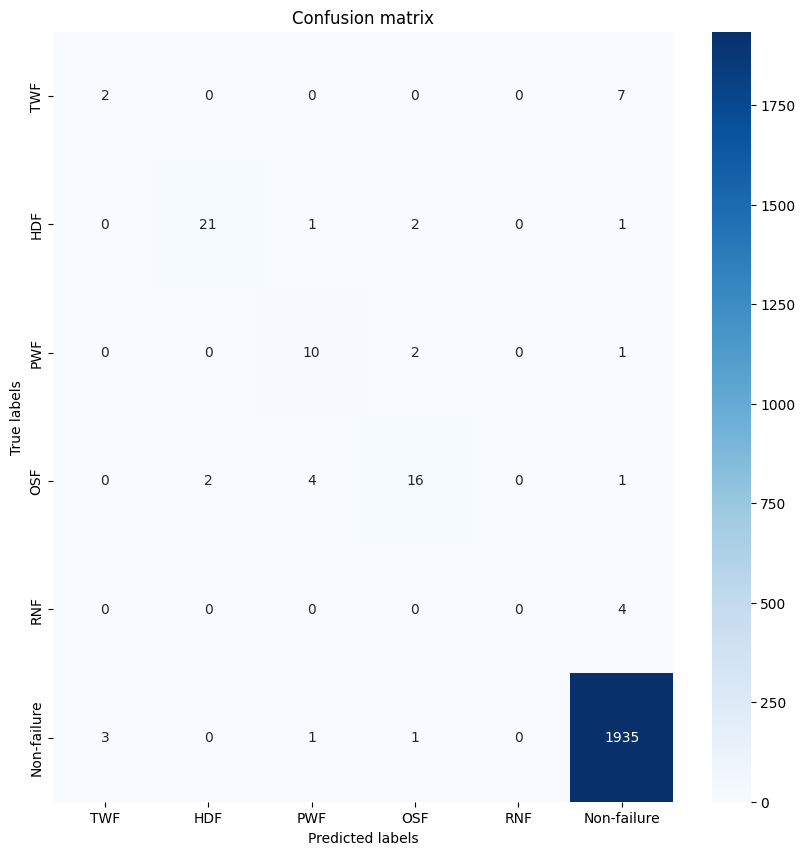

In [10]:
conf_mat = np.zeros((6, 6))

for i in range(6):
    for j in range(6):
        conf_mat[i, j] = np.sum((y_test[:, i] == 1) & (y_pred_dense[:, j] == 1))

label_names = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True,fmt=".0f", cmap='Blues',xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()